In [318]:
import io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

#lecture du fichier .csv par la libraire Pandas
data=pd.read_csv('train.csv')

#  <span style="color:pink">I. Preprocessing </span>

#  <span style="color:green">I.I Dataset observation </span>

In [319]:
#We need to separate X and Y
X=data.loc[:,data.columns!="retweets_count"]
Y=data['retweets_count']


In [320]:
df=data.copy() #We make a copy of the dataset to modify the copy and not the original
df.shape

(353969, 12)

In [321]:
display(df) #we need to understand the dataset

,text,retweets_count,favorites_count,followers_count,statuses_count,friends_count,mentions,urls,verified,hashtags,timestamp,TweetID
0,rt refarcir macron ans nom prépare,3,0,3682,453535,3628,[],[],0,[],1646978048000,832509
1,populaire,0,0,86,1016,284,[],[],0,[],1647694288000,1388011
2,faut dégager cinglé,3,1,1944,28234,1995,[],[],0,[],1647370048000,63896
3,enseignants mettre prescriptions président rép...,0,0,1,1072,0,[],['https://t.co/rytlted08g'],0,[],1647256282000,979251
4,mafieuse oppressive macron,0,0,13957,25311,10841,[],[],0,[],1647258374000,1040049
...,...,...,...,...,...,...,...,...,...,...,...,...
353964,gonflette tour raciste frustré,0,0,34,1509,55,[],['https://t.co/pma33zhslx'],0,[],1647438153000,142573
353965,france caste crapuleuse encadrée gangsters irr...,0,0,89,11166,127,[],[],0,[],1647072106000,240866
353966,eric zemmour français berbère,3,0,1888,712,3086,[],[],0,[],1647607230000,1173763
353967,gauchistes dépression pq,0,0,139,486,320,[],[],0,[],1646987195000,929182


## <span style="color:green">I.II Features explanations </span>

TweetID (-): Its an incremental number that is used to identify each tweet

timestamp (+): The time (in timestamp format) that the tweet was published

retweets_count(+): the actual number of retweets the tweet receive at the time of the of the crawl(only in training dataset)

verified (+): A boolean field indicating if the user has been verified by Twitter

statuses_count(+): The total number of tweets (statuses) the user has published

followers_count(+): The number of followers the user has

friends_count(+): The number of users that the user is following

Mentions: The users that are mentioned within the tweet (e.g. "@someuser"). The entries are comma separated (e.g. "someuser,anotheruser").

urls(~Transformer en nombre ?): The URLs that are included within the tweet. The entries are comma separated (e.g. "someurl.com,anotherurl.fr")

hashtags(++): The hashtags that are included within the tweet. The entries are comma separated (e.g. "hashtag1,hashtag2")

favorites_count(+=: The number of users that clicked the favorite (like) button for this tweet.

text(++): The text of the tweet as posted by the user


In [322]:
print(pd.__version__)

1.5.2


In [323]:
df.describe() #Allow us to have several informations about our dataset

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,3.539690e+05,3.539690e+05,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,15.831810,46.655442,2.021548e+04,4.808507e+04,1459.289003,0.030005,1.647004e+12,6.872503e+05
std,241.986723,852.044385,2.598715e+05,1.133854e+05,2502.933271,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,1.600000e+02,2.972000e+03,214.000000,0.000000,1.647068e+12,3.194490e+05
50%,1.000000,0.000000,7.260000e+02,1.250100e+04,693.000000,0.000000,1.647292e+12,6.719730e+05
75%,3.000000,1.000000,2.283000e+03,4.352200e+04,1804.000000,0.000000,1.647532e+12,1.049644e+06
max,63674.000000,122591.000000,1.441710e+07,8.183508e+06,237269.000000,1.000000,1.647727e+12,1.434456e+06


In [324]:
df.quantile(0.99) #We check if there is a lot ludicrous values 

C:\Users\feoni\AppData\Local\Temp\ipykernel_26044\530322659.py:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.quantile(0.99) #We check if there is a lot ludicrous values


retweets_count     2.630000e+02
favorites_count    7.210000e+02
followers_count    2.125720e+05
statuses_count     5.605584e+05
friends_count      9.966000e+03
verified           1.000000e+00
timestamp          1.647718e+12
TweetID            1.416835e+06
Name: 0.99, dtype: float64

In [325]:
from sklearn.impute import SimpleImputer

#If our dataset contains empty values, we put the mean value of the collum
if df.isnull().sum().sum()!=0: 
    imputer=SimpleImputer(missing_values=np.nan,strategy='mean')
else: 
        print("No missing_values in this dataset")


No missing_values in this dataset


C:\Users\feoni\AppData\Local\Temp\ipykernel_26044\3233098998.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<AxesSubplot: >

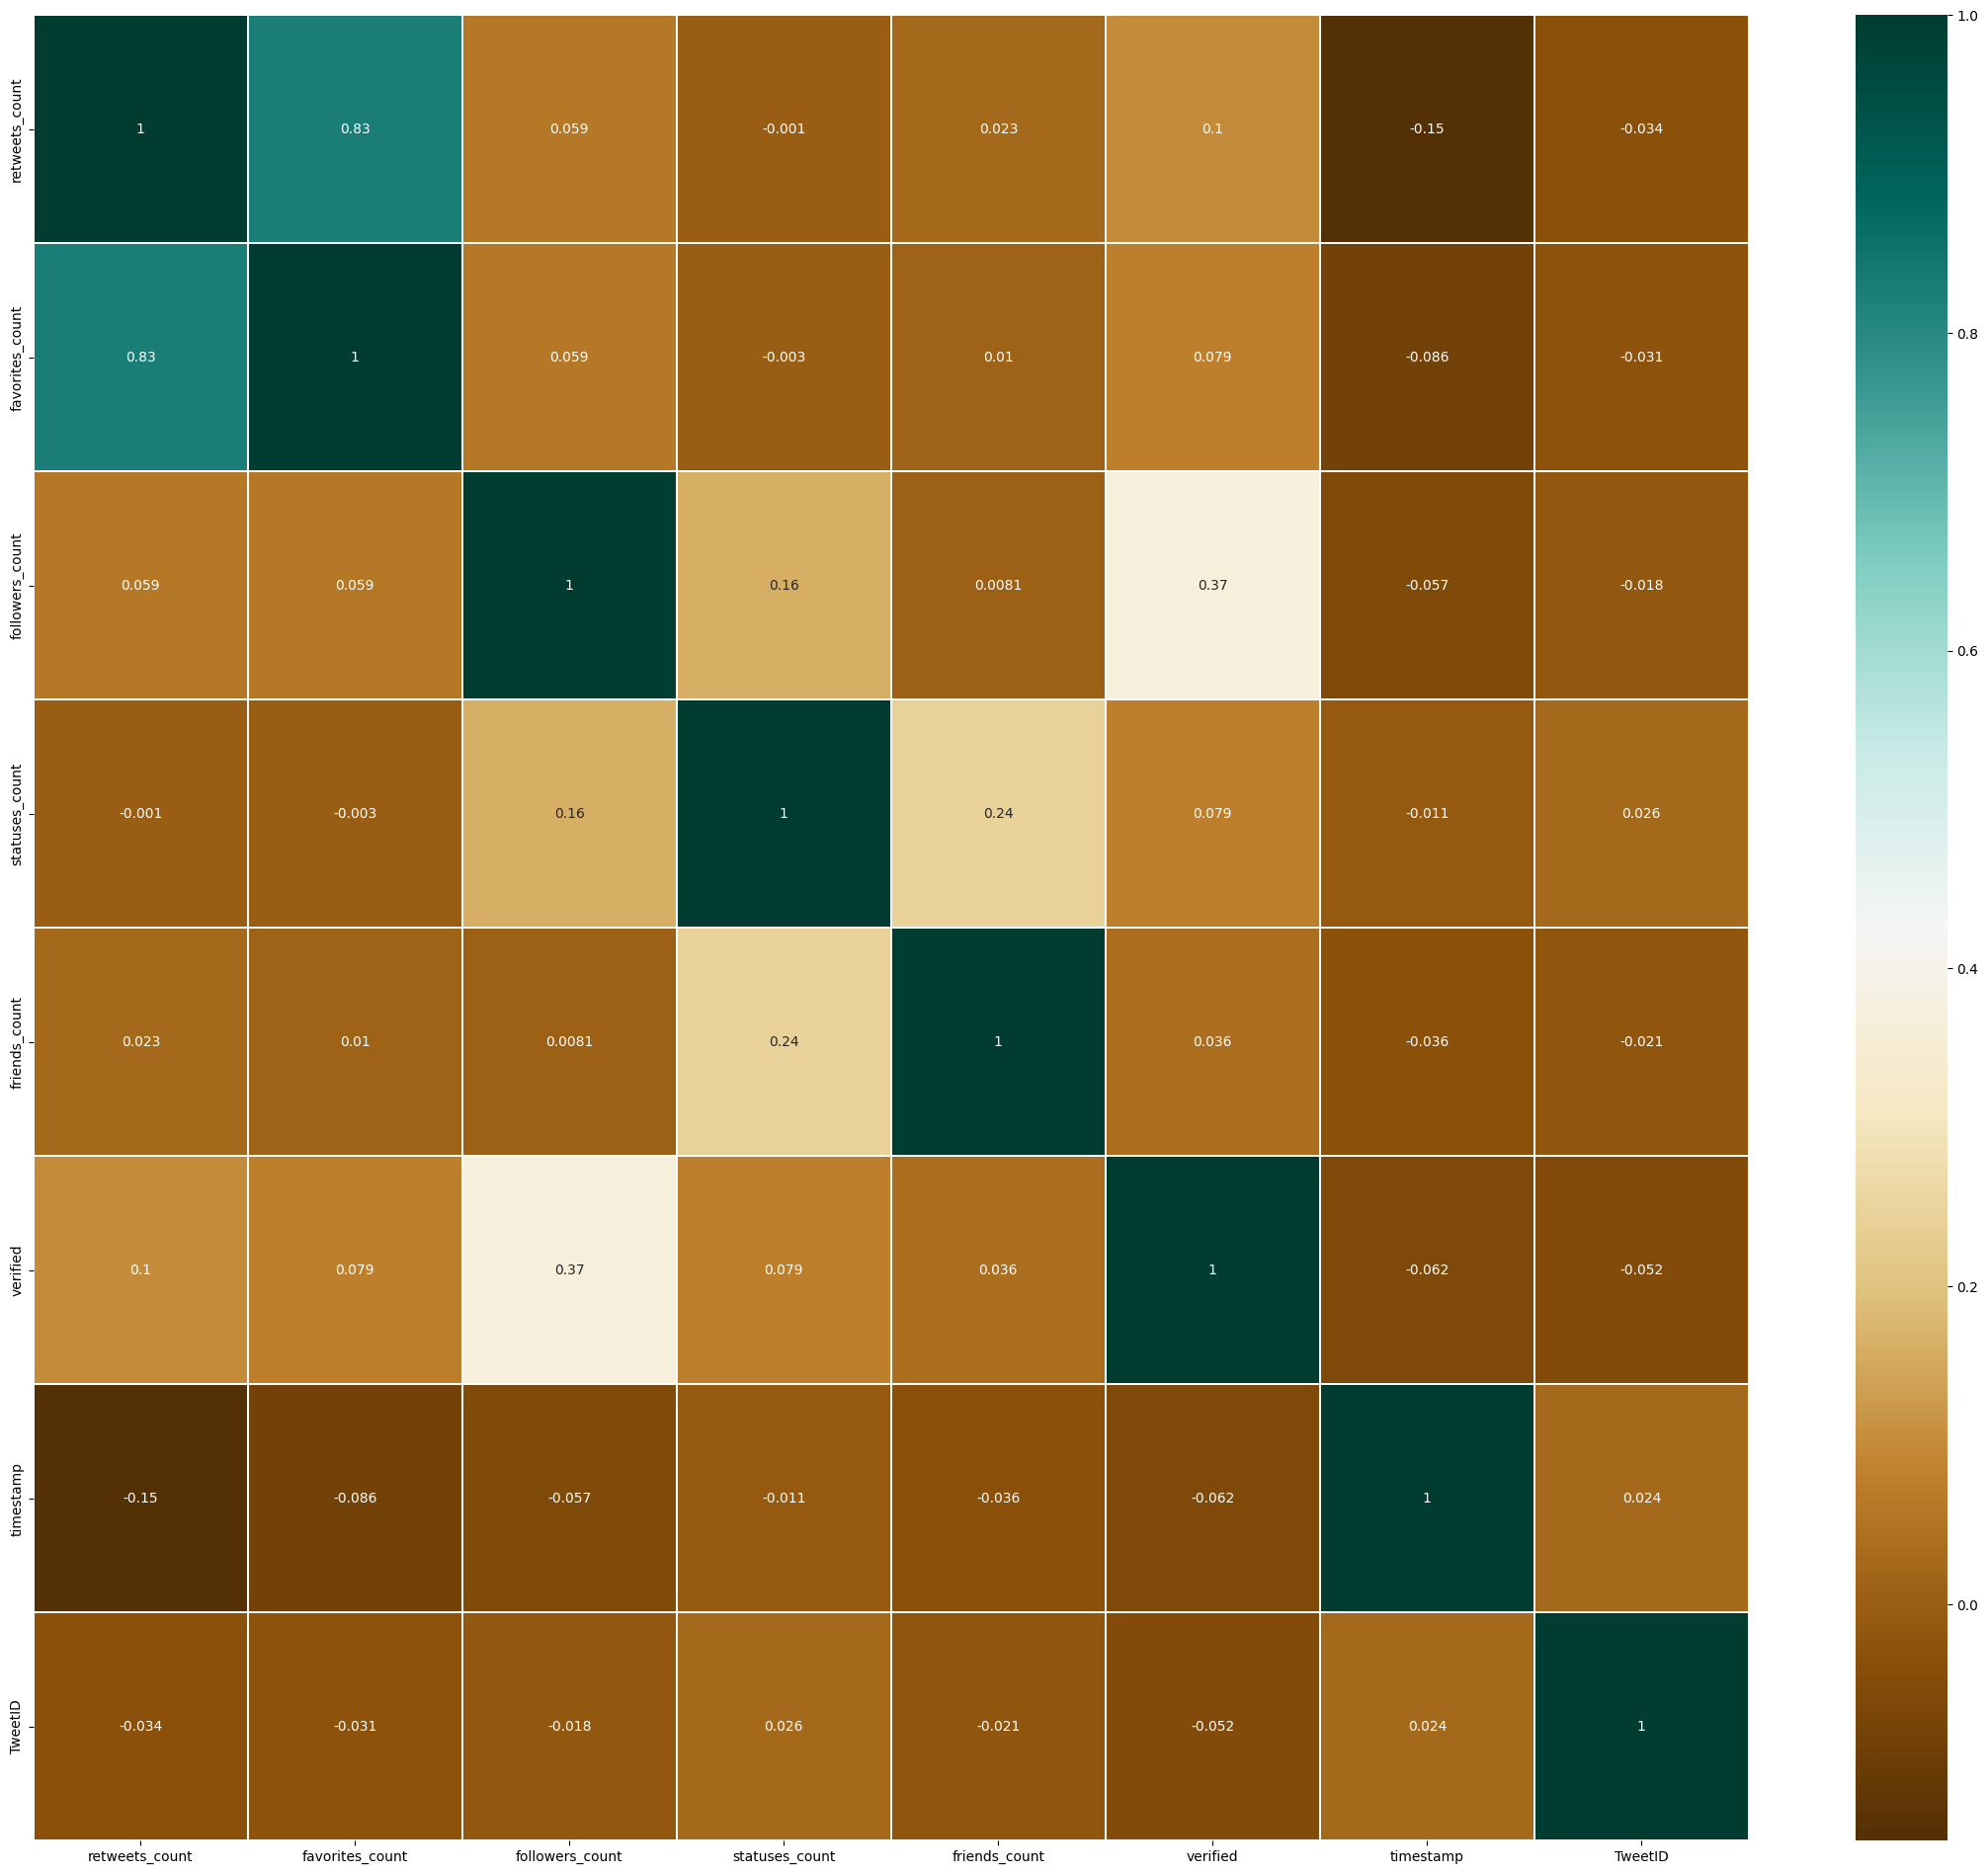

In [326]:
corr_matrix = df.corr()
plt.figure(figsize=(28,24))
sns.heatmap(data = corr_matrix,cmap='BrBG', annot=True, linewidths=0.2)

 ------> We observe that the only strong correlation that we can see at this time is the one between [favorite_count] 
and [retweet_count] , so we can already say that to predict the number of retweet, the number of favorite count is very important.

In [327]:
#checking for missing values in output
for i in range(df.shape[0]):
    if df['retweets_count'][i]==[]:
        print(df['retweets_count'][i])

C:\Users\feoni\AppData\Local\Temp\ipykernel_26044\2578964689.py:3: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if df['retweets_count'][i]==[]:


## <span style="color:green">I.III Normalisations </span>


On doit normaliser les données mais chaque colonne doit être normalisé différemment. 
- "favorites_count" -> moins de 1% de valeurs abhérantes (au top)
- "followers_count", -> Exponential 
- "statutes_count",
- "friends_count" -> moins de 1% de valeurs abhérantes (au top)


We can plot a graph to show the need of applying log.

In [328]:
#Les puissances de 10 sont importantes, donc on va passer tout au log et ensuite on fait min max.
#On peut tout le temps faire le log (sauf en cas de val négative) et ensuite passer au min max


Normalization=pd.DataFrame(df,columns=["retweets_count","favorites_count","followers_count","statuses_count","friends_count"])

def myfunc(x):
     return np.log(1+x)
    
Normalization['favorites_count'] = Normalization['favorites_count'].transform(myfunc)
Normalization['followers_count'] = Normalization['followers_count'].transform(myfunc)
Normalization['friends_count'] = Normalization['friends_count'].transform(myfunc)
Normalization['statuses_count'] = Normalization['statuses_count'].transform(myfunc)
#We also normalize the output because we can see that there is some extreme values
Normalization['retweets_count'] = Normalization['retweets_count'].transform(myfunc)



In [284]:
Normalization.describe() #with log applied

,retweets_count,favorites_count,followers_count,statuses_count,friends_count
count,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000
mean,0.813123,0.712285,6.379931,9.222199,6.314336
std,1.145401,1.457394,2.286417,2.076228,1.653755
min,0.000000,0.000000,0.000000,0.693147,0.000000
25%,0.000000,0.000000,5.081404,7.997327,5.370638
50%,0.693147,0.000000,6.588926,9.433644,6.542472
75%,1.386294,0.693147,7.733684,10.681045,7.498316
max,11.061547,11.716617,16.483925,15.917632,12.376954


In [285]:
Normalization.quantile(0.999)

retweets_count      7.743339
favorites_count     8.771524
followers_count    15.080642
statuses_count     14.065230
friends_count      10.280382
Name: 0.999, dtype: float64

In [286]:
#Now we used the log function over all the variables in the colums of normalization, we need to do the minMax normalization 
#who seems to us the best normalization function for this type of data. 

from sklearn.preprocessing import MinMaxScaler

minmax_scale = MinMaxScaler().fit(Normalization[['favorites_count', 'followers_count','friends_count','statuses_count','retweets_count']])
Temp = minmax_scale.transform(Normalization[['favorites_count', 'followers_count','friends_count','statuses_count','retweets_count']])

column_names = ["favorites_count", "followers_count", "friends_count","statuses_count","retweets_count"]

Normalization = pd.DataFrame(Temp,columns=column_names)

Normalization.describe() #with log and min-max 

,favorites_count,followers_count,friends_count,statuses_count,retweets_count
count,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000
mean,0.060793,0.387040,0.510169,0.560219,0.073509
std,0.124387,0.138706,0.133616,0.136374,0.103548
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.308264,0.433922,0.479765,0.000000
50%,0.000000,0.399718,0.528601,0.574108,0.062663
75%,0.059159,0.469165,0.605829,0.656042,0.125326
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [287]:
df['favorites_count']=Normalization['favorites_count']
df['followers_count']=Normalization['followers_count'] 
df['statuses_count']=Normalization['statuses_count']
df['friends_count']=Normalization['friends_count']
df['retweets_count']=Normalization['retweets_count']


In [297]:
df.describe()

,retweets_count,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,353969.000000,3.539690e+05,3.539690e+05
mean,0.073509,0.060793,0.387040,0.560219,0.510169,0.030005,1.647004e+12,6.872503e+05
std,0.103548,0.124387,0.138706,0.136374,0.133616,0.170602,4.846468e+09,4.175793e+05
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.301178e+12,3.000000e+00
25%,0.000000,0.000000,0.308264,0.479765,0.433922,0.000000,1.647068e+12,3.194490e+05
50%,0.062663,0.000000,0.399718,0.574108,0.528601,0.000000,1.647292e+12,6.719730e+05
75%,0.125326,0.059159,0.469165,0.656042,0.605829,0.000000,1.647532e+12,1.049644e+06
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.647727e+12,1.434456e+06


#  <span style="color:pink">II. PCA Text and # treatment </span>


## <span style="color:green">II.I PCA on words: Understanding the main components of bags of words </span>


### II.I.I Getting the most important words in the text

Use the dictionary DICO to count all the word occurencences in the text column

In [338]:
DICO={}
I=df.shape[0]
for i in range(I):
    sentence=df["text"][i].split()
    for word in sentence:
        if word in DICO:
            DICO[word]+=1
        else:
            DICO[word]=1
            
DICO

{'rt': 60603,
 'refarcir': 1,
 'macron': 100812,
 'ans': 14267,
 'nom': 1684,
 'prépare': 441,
 'populaire': 994,
 'faut': 11535,
 'dégager': 649,
 'cinglé': 51,
 'enseignants': 801,
 'mettre': 3701,
 'prescriptions': 6,
 'président': 38642,
 'république': 5219,
 'croire': 2647,
 'donner': 2234,
 'période': 415,
 'compte': 3698,
 'mesures': 1249,
 'appliquées': 25,
 'grever': 4,
 'mafieuse': 20,
 'oppressive': 3,
 'équipe': 948,
 'campagne': 7577,
 'prie': 105,
 'soutien': 3206,
 'sarko': 514,
 'bizarre': 678,
 'cousin': 56,
 'sensés': 19,
 'dems': 5,
 'votent': 1730,
 'pauvre': 1826,
 'envoies': 10,
 'chameau': 7,
 'cheval': 140,
 'dessiné': 22,
 'commission': 719,
 'emmanuel': 8649,
 'annule': 138,
 'venue': 228,
 'soirée': 590,
 'électorale': 1019,
 'bfmtv': 349,
 'chaîne': 843,
 'prend': 2185,
 'décision': 571,
 'radicale': 229,
 'violer': 77,
 'ukrainienne': 531,
 'abusée': 2,
 'africains': 372,
 'düsseldorf': 4,
 'petites': 422,
 'minutes': 770,
 'temps': 7763,
 'bfm': 566,
 'heu

We try to find a good number to remove many words

In [339]:
values=list(DICO.values())
values

[60603,
 1,
 100812,
 14267,
 1684,
 441,
 994,
 11535,
 649,
 51,
 801,
 3701,
 6,
 38642,
 5219,
 2647,
 2234,
 415,
 3698,
 1249,
 25,
 4,
 20,
 3,
 948,
 7577,
 105,
 3206,
 514,
 678,
 56,
 19,
 5,
 1730,
 1826,
 10,
 7,
 140,
 22,
 719,
 8649,
 138,
 228,
 590,
 1019,
 349,
 843,
 2185,
 571,
 229,
 77,
 531,
 2,
 372,
 4,
 422,
 770,
 7763,
 566,
 1058,
 296,
 44,
 863,
 401,
 131,
 3329,
 1158,
 980,
 54,
 904,
 21937,
 1967,
 455,
 5,
 136,
 856,
 1,
 1,
 52,
 3363,
 5947,
 8994,
 381,
 151,
 522,
 987,
 236,
 164,
 530,
 163,
 13,
 1775,
 91,
 30,
 2178,
 139,
 12,
 534,
 29,
 2357,
 425,
 1912,
 2329,
 1283,
 394,
 220,
 1973,
 95,
 3286,
 274,
 553,
 362,
 263,
 147,
 9085,
 273,
 110,
 275,
 157,
 247,
 35,
 1199,
 25790,
 15,
 59,
 12,
 986,
 4,
 119,
 23454,
 24,
 155,
 9983,
 1321,
 16,
 16,
 22190,
 809,
 10,
 669,
 1082,
 627,
 35,
 26,
 266,
 289,
 245,
 609,
 2862,
 220,
 4709,
 21,
 254,
 234,
 93,
 81,
 387,
 144,
 1464,
 7,
 487,
 1654,
 2280,
 24,
 1191,
 121,
 

In [340]:
np.std(values)

473.53870591966825

In [341]:
np.median(values)

2.0

In [342]:
pd.DataFrame(values).quantile(0.99)

0    460.0
Name: 0.99, dtype: float64

Remove words with less than 500 occurences. If we take words that occure less, we risk overloading the PCA, and these words that occur less are responsible for less variance in words anyway.

In [343]:
most_occurr_DICO={}
for word in DICO:
    if DICO[word]>5000:
        most_occurr_DICO[word]=0
most_occurr_DICO

{'rt': 0,
 'macron': 0,
 'ans': 0,
 'faut': 0,
 'président': 0,
 'république': 0,
 'campagne': 0,
 'emmanuel': 0,
 'temps': 0,
 'vote': 0,
 'melenchon': 0,
 'jamais': 0,
 'pecresse': 0,
 'gauche': 0,
 'france': 0,
 'programme': 0,
 'faire': 0,
 'pécresse': 0,
 'éric': 0,
 'zemmour': 0,
 'pouvoir': 0,
 'français': 0,
 'voter': 0,
 'voir': 0,
 'guerre': 0,
 'veut': 0,
 'pen': 0,
 'déjà': 0,
 'vraiment': 0,
 'oui': 0,
 'débat': 0,
 'pays': 0,
 'hidalgo': 0,
 'face': 0,
 'sondages': 0,
 'poutine': 0,
 'tour': 0,
 'mélenchon': 0,
 'démocratie': 0,
 'présidentielle': 0,
 'candidat': 0,
 'monde': 0,
 'grand': 0,
 'politique': 0,
 'candidats': 0}

In [344]:
len(most_occurr_DICO)

45

In [345]:
num_important_words=len(most_occurr_DICO)

In [346]:
important_words=list(most_occurr_DICO.keys())
important_words

['rt',
 'macron',
 'ans',
 'faut',
 'président',
 'république',
 'campagne',
 'emmanuel',
 'temps',
 'vote',
 'melenchon',
 'jamais',
 'pecresse',
 'gauche',
 'france',
 'programme',
 'faire',
 'pécresse',
 'éric',
 'zemmour',
 'pouvoir',
 'français',
 'voter',
 'voir',
 'guerre',
 'veut',
 'pen',
 'déjà',
 'vraiment',
 'oui',
 'débat',
 'pays',
 'hidalgo',
 'face',
 'sondages',
 'poutine',
 'tour',
 'mélenchon',
 'démocratie',
 'présidentielle',
 'candidat',
 'monde',
 'grand',
 'politique',
 'candidats']

In [347]:
measurer={}
for i in range(len(important_words)):
    measurer[important_words[i]]=i
measurer

{'rt': 0,
 'macron': 1,
 'ans': 2,
 'faut': 3,
 'président': 4,
 'république': 5,
 'campagne': 6,
 'emmanuel': 7,
 'temps': 8,
 'vote': 9,
 'melenchon': 10,
 'jamais': 11,
 'pecresse': 12,
 'gauche': 13,
 'france': 14,
 'programme': 15,
 'faire': 16,
 'pécresse': 17,
 'éric': 18,
 'zemmour': 19,
 'pouvoir': 20,
 'français': 21,
 'voter': 22,
 'voir': 23,
 'guerre': 24,
 'veut': 25,
 'pen': 26,
 'déjà': 27,
 'vraiment': 28,
 'oui': 29,
 'débat': 30,
 'pays': 31,
 'hidalgo': 32,
 'face': 33,
 'sondages': 34,
 'poutine': 35,
 'tour': 36,
 'mélenchon': 37,
 'démocratie': 38,
 'présidentielle': 39,
 'candidat': 40,
 'monde': 41,
 'grand': 42,
 'politique': 43,
 'candidats': 44}

In [348]:
array_words1=np.zeros((I, len(most_occurr_DICO)))

It is much faster to iterate over a numpy array than over a pandas data frame.

In [349]:
for i in range(I):
    sentence=df["text"][i].split()
    for word in sentence:
        if word in important_words:
            array_words1[i,measurer[word]]=1
        
array_words1      

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [350]:
df_words1=pd.DataFrame(array_words1, columns=important_words)
df_words1

,rt,macron,ans,faut,président,république,campagne,emmanuel,temps,vote,...,poutine,tour,mélenchon,démocratie,présidentielle,candidat,monde,grand,politique,candidats
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
353964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
353967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### II.I.II PCA on the most important words

In [351]:
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [352]:
pca1=PCA(n_components=4)
pca1.fit(array_words1.T)

PCA(n_components=4)

mds=MDS(n_components=20, metric=False)
mds.fit(array_words1)

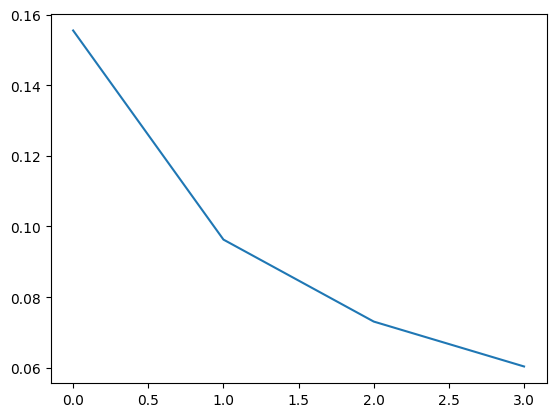

In [353]:
plt.plot(pca1.explained_variance_ratio_)

In [354]:
print(pca1.singular_values_)

[299.73657783 235.85050656 205.45261464 186.71538456]


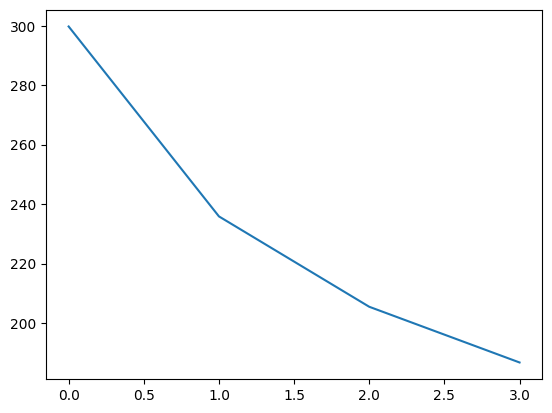

In [355]:
plt.plot(pca1.singular_values_)

In [356]:
#for the moment select 4 first eigenvalues

In [357]:
total_var_explained=0
for i in range(4):
    total_var_explained+=pca1.explained_variance_ratio_[i]
    
total_var_explained

0.38514046747705555

In [358]:
PCA_text=pca1.components_.T
PCA_text.shape

(353969, 4)

## <span style="color:green">II.II PCA for # column</span>

In [359]:
df["hashtags"]

0         []
1         []
2         []
3         []
4         []
          ..
353964    []
353965    []
353966    []
353967    []
353968    []
Name: hashtags, Length: 353969, dtype: object

In [360]:
DICO2={} #DICO2 is for hashtags
I=df.shape[0]
for i in range(I):
    sentence=df["hashtags"][i][1:-1].replace(' ', '').split(',')
    for word in sentence:
        extracted_word=word[1:-1]
        if extracted_word in DICO2:
            DICO2[extracted_word]+=1
        else:
            DICO2[extracted_word]=1
            
DICO2

{'': 290287,
 'aec2023': 1,
 'presidentielle2022': 2058,
 'melenchon': 1725,
 'commejaime': 2,
 'hidalgo': 1032,
 'zemmourpresident': 1376,
 'facealaguerretf1': 2075,
 'pasdedebatpasdemandat': 406,
 'corsica': 15,
 'corse': 451,
 'yvancolonna': 43,
 'ajaccio': 7,
 'debatzemmourpecresse': 32,
 'le79inter': 13,
 'quinquennat': 10,
 'metropole': 1,
 'balancetonporc': 3,
 'pecresse': 2063,
 'laec': 17,
 'yannickjadot': 16,
 'elysee2022': 827,
 'naynayfm': 7,
 'fabienroussel': 32,
 'zemmourvspecresse': 1284,
 'maine': 2,
 'angers': 9,
 'cholet': 3,
 'macron': 13928,
 'programmezemmour': 18,
 'francedesoubliés': 4,
 'fracturerurale': 2,
 'facealaguerre': 26,
 'humour': 9,
 'présidentielle2022': 550,
 'pecressedetresse': 483,
 'ilsvousdisent': 458,
 'zemmour': 5629,
 'dictaturesanitaire': 9,
 'sarkozy': 238,
 'nationalité': 2,
 'melenchon2022': 230,
 'unionpopulaire': 242,
 'eelv': 97,
 'mélenchon': 310,
 'traduisonsles': 37,
 'guinée': 16,
 'pécresse': 382,
 'lepen': 810,
 'vladimirzemmour':

In [361]:
values2=list(DICO2.values())[1:]
'''
still take into account the 'nothing' hashtag as this component may affect the number of rt
(not taking into account may remove the "meaning" of not putting a hashtag in the hashtag column which 
will only show the variance of the non-empty hashtag)
'''
values2

[1,
 2058,
 1725,
 2,
 1032,
 1376,
 2075,
 406,
 15,
 451,
 43,
 7,
 32,
 13,
 10,
 1,
 3,
 2063,
 17,
 16,
 827,
 7,
 32,
 1284,
 2,
 9,
 3,
 13928,
 18,
 4,
 2,
 26,
 9,
 550,
 483,
 458,
 5629,
 9,
 238,
 2,
 230,
 242,
 97,
 310,
 37,
 16,
 382,
 810,
 93,
 17,
 2,
 85,
 1,
 14,
 1447,
 51,
 356,
 200,
 18,
 2,
 2,
 27,
 33,
 658,
 393,
 34,
 15,
 177,
 8,
 266,
 1,
 33,
 54,
 61,
 377,
 3,
 222,
 2,
 8,
 46,
 43,
 2,
 2,
 152,
 463,
 296,
 2,
 160,
 124,
 112,
 1,
 59,
 354,
 1085,
 556,
 2,
 88,
 11,
 1,
 2,
 1,
 332,
 208,
 133,
 22,
 313,
 454,
 157,
 48,
 1,
 2,
 159,
 53,
 715,
 36,
 23,
 9,
 40,
 4,
 2,
 57,
 205,
 24,
 255,
 515,
 79,
 1,
 659,
 471,
 1,
 1,
 1,
 91,
 63,
 20,
 181,
 10,
 9,
 10,
 33,
 1,
 6,
 854,
 24,
 84,
 147,
 42,
 242,
 458,
 264,
 184,
 9,
 326,
 240,
 301,
 57,
 593,
 11,
 18,
 7,
 11,
 39,
 131,
 12,
 6,
 1,
 54,
 8,
 16,
 83,
 21,
 18,
 473,
 1,
 10,
 2,
 225,
 31,
 189,
 2,
 2,
 5,
 23,
 5,
 215,
 4,
 1,
 178,
 911,
 267,
 127,
 24,
 5,
 4,
 30,

Later (after submissions) we will see if it is better to keep more hashtags or not. Now we take 80%.

In [362]:
pd.DataFrame(values).quantile(0.8)

0    10.0
Name: 0.8, dtype: float64

In [363]:
most_occurr_DICO2={}
for word in DICO2:
    if DICO2[word]>10 :#and word!=''
        most_occurr_DICO2[word]=0
most_occurr_DICO2

{'': 0,
 'presidentielle2022': 0,
 'melenchon': 0,
 'hidalgo': 0,
 'zemmourpresident': 0,
 'facealaguerretf1': 0,
 'pasdedebatpasdemandat': 0,
 'corsica': 0,
 'corse': 0,
 'yvancolonna': 0,
 'debatzemmourpecresse': 0,
 'le79inter': 0,
 'pecresse': 0,
 'laec': 0,
 'yannickjadot': 0,
 'elysee2022': 0,
 'fabienroussel': 0,
 'zemmourvspecresse': 0,
 'macron': 0,
 'programmezemmour': 0,
 'facealaguerre': 0,
 'présidentielle2022': 0,
 'pecressedetresse': 0,
 'ilsvousdisent': 0,
 'zemmour': 0,
 'sarkozy': 0,
 'melenchon2022': 0,
 'unionpopulaire': 0,
 'eelv': 0,
 'mélenchon': 0,
 'traduisonsles': 0,
 'guinée': 0,
 'pécresse': 0,
 'lepen': 0,
 'vladimirzemmour': 0,
 'foutriquet': 0,
 'ukrainerussie': 0,
 'filsdeclovis': 0,
 'ukraine': 0,
 'pouvoirdachat': 0,
 'lrem': 0,
 'ue': 0,
 'flash': 0,
 'autonomie': 0,
 'les48hdelareconquête': 0,
 'faceababa': 0,
 'presidentielles2022': 0,
 'praud': 0,
 'joffrin': 0,
 'biden': 0,
 'mlp': 0,
 'bigorgne': 0,
 'marineprésidente': 0,
 'jevotepourzemmour': 0

In [364]:
num_important_hashtags=len(most_occurr_DICO2)

In [365]:
important_hashtags=list(most_occurr_DICO2.keys())
important_hashtags

['',
 'presidentielle2022',
 'melenchon',
 'hidalgo',
 'zemmourpresident',
 'facealaguerretf1',
 'pasdedebatpasdemandat',
 'corsica',
 'corse',
 'yvancolonna',
 'debatzemmourpecresse',
 'le79inter',
 'pecresse',
 'laec',
 'yannickjadot',
 'elysee2022',
 'fabienroussel',
 'zemmourvspecresse',
 'macron',
 'programmezemmour',
 'facealaguerre',
 'présidentielle2022',
 'pecressedetresse',
 'ilsvousdisent',
 'zemmour',
 'sarkozy',
 'melenchon2022',
 'unionpopulaire',
 'eelv',
 'mélenchon',
 'traduisonsles',
 'guinée',
 'pécresse',
 'lepen',
 'vladimirzemmour',
 'foutriquet',
 'ukrainerussie',
 'filsdeclovis',
 'ukraine',
 'pouvoirdachat',
 'lrem',
 'ue',
 'flash',
 'autonomie',
 'les48hdelareconquête',
 'faceababa',
 'presidentielles2022',
 'praud',
 'joffrin',
 'biden',
 'mlp',
 'bigorgne',
 'marineprésidente',
 'jevotepourzemmour',
 'projetmacron',
 'pourquelafrancerestelafrance',
 'mlafrance',
 'débat',
 'ggrmc',
 'cnews',
 'hdpros',
 'sanslui',
 'guerre',
 'valeriepecresse',
 'frexit',
 

In [366]:
measurer2={}
for i in range(len(important_hashtags)):
    measurer2[important_hashtags[i]]=i
measurer2

{'': 0,
 'presidentielle2022': 1,
 'melenchon': 2,
 'hidalgo': 3,
 'zemmourpresident': 4,
 'facealaguerretf1': 5,
 'pasdedebatpasdemandat': 6,
 'corsica': 7,
 'corse': 8,
 'yvancolonna': 9,
 'debatzemmourpecresse': 10,
 'le79inter': 11,
 'pecresse': 12,
 'laec': 13,
 'yannickjadot': 14,
 'elysee2022': 15,
 'fabienroussel': 16,
 'zemmourvspecresse': 17,
 'macron': 18,
 'programmezemmour': 19,
 'facealaguerre': 20,
 'présidentielle2022': 21,
 'pecressedetresse': 22,
 'ilsvousdisent': 23,
 'zemmour': 24,
 'sarkozy': 25,
 'melenchon2022': 26,
 'unionpopulaire': 27,
 'eelv': 28,
 'mélenchon': 29,
 'traduisonsles': 30,
 'guinée': 31,
 'pécresse': 32,
 'lepen': 33,
 'vladimirzemmour': 34,
 'foutriquet': 35,
 'ukrainerussie': 36,
 'filsdeclovis': 37,
 'ukraine': 38,
 'pouvoirdachat': 39,
 'lrem': 40,
 'ue': 41,
 'flash': 42,
 'autonomie': 43,
 'les48hdelareconquête': 44,
 'faceababa': 45,
 'presidentielles2022': 46,
 'praud': 47,
 'joffrin': 48,
 'biden': 49,
 'mlp': 50,
 'bigorgne': 51,
 'mar

In [367]:
array_hashtags1=np.zeros((I, len(most_occurr_DICO2)))

In [368]:
for i in range(I):
    sentence=df["hashtags"][i][1:-1].replace(' ', '').split(',')
    for word in sentence:
        extracted_word=word[1:-1]
        if extracted_word in important_hashtags:
            array_hashtags1[i,measurer2[extracted_word]]=1
array_hashtags1

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [369]:
pca2=PCA(n_components=2)
pca2.fit(array_hashtags1.T)

PCA(n_components=2)

In [370]:
print(pca2.explained_variance_ratio_)

[0.77726172 0.03717501]


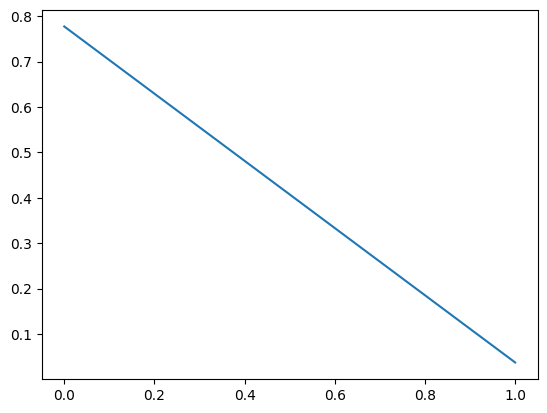

In [49]:
plt.plot(pca2.explained_variance_ratio_)

In [50]:
print(pca2.singular_values_)

[538.43854722 117.7546435 ]


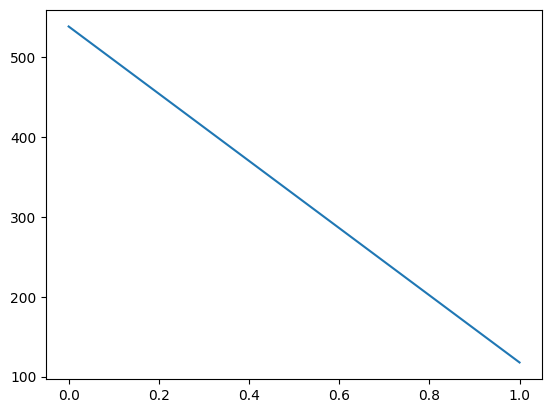

In [51]:
plt.plot(pca2.singular_values_)

In [52]:
PCA_hashtag=pca2.components_.T
PCA_hashtag.shape

(353969, 2)

#  <span style="color:pink">III. Preparing RNN on word sequences: Understanding relations between words </span>


## <span style="color:green"> III.I Pre-treatment for word embedding </span>

We will use the FastText method. We divide each word into groups of 3 letters (spaces are the "empty letter"). We keep the order in the text and make an embedding also using the adjacent words. For instance:
"macron demission"==> -ma,mac,acr,...,on-,n-d,-de,dem,... (- is the empty letter)

The fast text method will guess the adjacent 3 letters to each given patch of 3 letters. Hence for "mac" we want a high probability of "---" (3 times empty letter) and "ron". 

In [53]:
#returns an array with the words in the sentence cut (n=3 that is in pieces of 3)
def cutter(sent, n):
    sentence=sent.split()
    length=len(sentence)+2-n
    for word in sentence:
        length+=len(word)
    result=[]
    padding=''
    for i in range(n):
        padding+=' '
    sent=' '+sent+' '
    padd_sent=padding+sent+padding
    
    for i in range(length):
        middle=sent[i:i+n]
        before=padd_sent[i:i+n]
        after=padd_sent[2*n+i:3*n+i]
        result.append([before, middle, after])
    return np.array(result)

In [54]:
30**3 #input vector length (29+1 for empty letter)

27000

In [55]:
n_alphabet=30 #We define that the alphabet has 30 characters

## <span style="color:green">III.II Encoder/decoder to get a good embedding </span>

In [56]:
if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

print(device)

cuda:0


In [57]:
def batch_maker(size):
    X=np.zeros((size,3*n_alphabet))
    Y=np.zeros((size,6*n_alphabet))
    for i in range(size):
        
        line=random.randrange(0,350000)
        cut=cutter(df["text"][line],3)
        
        alphabet={
        ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
        'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
        'è':28,
        #thus use mod 30 (as 29 is for any other letter (arabic...))
        }
        
        possibilities=[        
        ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
        'y','z','é','è',]
        
        length=cut.shape[0]
        word_index=random.randrange(0,length)
        
        word0=cut[word_index, 0]
        word1=cut[word_index, 1]
        word2=cut[word_index, 2]
        for letter_ind in range(3):
            index0=0
            index1=0
            index2=0
            if (word0[letter_ind] not in possibilities):
                index0=29
            else:
                index0=alphabet[word0[letter_ind]]
                
            if (word1[letter_ind] not in possibilities):
                index1=29
            else:
                index1=alphabet[word1[letter_ind]]
                
            if (word2[letter_ind] not in possibilities):
                index2=29
            else:
                index2=alphabet[word2[letter_ind]]
                
            Y[i,letter_ind*n_alphabet+index0]=1
            X[i,letter_ind*n_alphabet+index1]=1
            Y[i,3*n_alphabet+letter_ind*n_alphabet+index2]=1
        
    return torch.tensor(X, requires_grad=True).float(),torch.tensor(Y, requires_grad=True).float()

In [58]:
batch_maker(1000)


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ToCopyBackward0>),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.]], grad_fn=<ToCopyBackward0>))

This model takes a "word" (3 letters patch) as input and return a size 100 vector who is encoded to take into consideration the past and future patches

In [59]:
class embedd(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        #A sequential container: Modules will be added to it in the order they are passed in the constructor. 
        self.encoder=nn.Sequential(
            
        nn.Linear(3*n_alphabet,60,bias=True),
        nn.ReLU(),
        
        nn.Linear(60,30,bias=True),
        nn.Sigmoid())
        
        self.decoder=nn.Sequential(
        
        nn.Linear(30,100, bias=True),
        nn.ReLU(),
        
        nn.Linear(100,6*n_alphabet,bias=True),
        )
        
        #The forward() method of Sequential accepts 
        #any input and forwards it to the first module it contains.
        
    def forward(self, x):
        
        return self.decoder(self.encoder(x))

In [60]:
from pathlib import Path
# PARAMS

BATCH_SIZE=1000
NUM_BACKWARDS=8500 #iterations
LEARNING_RATE=0.001

###############

loss_list=[]
Emb=embedd().to(device)
Emb.train()
optimizer = Adam(Emb.parameters(),lr=LEARNING_RATE)

for n in range(NUM_BACKWARDS):
    
    print(n)
    
    x,y_target=batch_maker(BATCH_SIZE)
    x = x.to(device) #we put the model and the variable on the gpu
    y=Emb(x)
    y = y.to(device)
    y_target = y_target.to(device) #because we use y_target after and we neet to put it on the gpu
    
    optimizer.zero_grad()
    loss_func=nn.CrossEntropyLoss()
    loss1_target = (y_target[:,:n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss2_target = (y_target[:,n_alphabet:2*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss3_target = (y_target[:,2*n_alphabet:3*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    
    loss4_target = (y_target[:,3*n_alphabet:4*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss5_target = (y_target[:,4*n_alphabet:5*n_alphabet] == 1).nonzero(as_tuple=True)[1]
    loss6_target = (y_target[:,5*n_alphabet:6*n_alphabet] == 1).nonzero(as_tuple=True)[1]

    loss1=loss_func(y[:,:n_alphabet],loss1_target)
    loss2=loss_func(y[:,n_alphabet:2*n_alphabet],loss2_target)
    loss3=loss_func(y[:,2*n_alphabet:3*n_alphabet],loss3_target)
    
    loss4=loss_func(y[:,3*n_alphabet:4*n_alphabet],loss4_target)
    loss5=loss_func(y[:,4*n_alphabet:5*n_alphabet],loss5_target)
    loss6=loss_func(y[:,5*n_alphabet:6*n_alphabet],loss6_target)
    
    
    loss=(loss1+loss2+loss3+loss4+loss5+loss6)/6
    loss.backward()
    optimizer.step()

    loss_list.append(loss.item()) #All this to update the loss plot
    fig, ax = plt.subplots()
    ax.plot(loss_list)
    fig.savefig("loss plot embedd bigbatch.png")
    plt.close(fig)
    
    if NUM_BACKWARDS%1000==0:
        torch.save(Emb.state_dict(),"Model.h5")
   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [62]:
def find_output(Model, word):

    rev_alphabet={0:'_', 1:'a', 2:'b', 3:'c', 4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j',11:'k',12:'l',
                 13:'m',14:'n',15:'o',16:'p',17:'q',18:'r',19:'s',20:'t',21:'u',22:'v',23:'w',24:'x',
                 25:'y',26:'z',27:'é',28:'è',29:'others'}

    alphabet={
            ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
            'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
            'è':28}

    possibilities=[        
            ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
            'y','z','é','è',]


    inp=np.zeros((1,3*n_alphabet))
    for letter_ind in range(3):
        if word[letter_ind] in possibilities:
            inp[0,letter_ind*n_alphabet+alphabet[word[letter_ind]]]=1
        else:
            inp[0,letter_ind*n_alphabet+29]=1

    inp=torch.tensor(inp, requires_grad=True).float()
    y=Model(inp)


    print(type(y))
    y00=np.argmax(y[:,:n_alphabet].detach().numpy())
    y01=np.argmax(y[:,n_alphabet:2*n_alphabet].detach().numpy())
    y02=np.argmax(y[:,2*n_alphabet:3*n_alphabet].detach().numpy())
    y10=np.argmax(y[:,3*n_alphabet:4*n_alphabet].detach().numpy())
    y11=np.argmax(y[:,4*n_alphabet:5*n_alphabet].detach().numpy())
    y12=np.argmax(y[:,5*n_alphabet:6*n_alphabet].detach().numpy())


    before=rev_alphabet[y00]+rev_alphabet[y01]+rev_alphabet[y02]
    after=rev_alphabet[y10]+rev_alphabet[y11]+rev_alphabet[y12]

    return before, after

In [105]:
Emb = embedd()
Emb.load_state_dict(torch.load("C:/Users/feoni/OneDrive/Bureau/Polytechnique/ML/DeepLearning_Project/Model.h5"))
Emb.eval()

find_output(Emb, "cro")
#Encoder avec plus de perceptron

<class 'torch.Tensor'>


('_ma', 'n__')

In [67]:
Emb.to(device)

embedd(
  (encoder): Sequential(
    (0): Linear(in_features=90, out_features=60, bias=True)
    (1): ReLU()
    (2): Linear(in_features=60, out_features=30, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=30, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=180, bias=True)
  )
)

In [68]:
Emb(x)

tensor([[ 2.9279e+00, -7.1812e-02, -1.2989e+00,  ..., -8.8230e-01,
         -3.0954e+00, -2.0092e+00],
        [ 2.1227e+00,  2.7349e-01, -4.2988e-01,  ..., -8.4241e-01,
         -4.4074e+00, -1.5676e+00],
        [ 2.0595e+00, -4.6789e-03, -7.6187e-01,  ..., -4.6893e-01,
         -1.7448e+00, -2.3021e+00],
        ...,
        [ 2.1533e+00,  1.2807e+00, -3.5287e-01,  ..., -1.1507e+00,
         -3.8741e+00, -5.1328e+00],
        [ 1.6262e+00,  1.8118e-01, -1.1170e+00,  ..., -5.8569e-01,
         -5.0797e+00, -3.4498e+00],
        [ 2.1559e+00,  1.3616e+00, -1.8002e+00,  ..., -2.1496e-01,
         -4.6426e+00, -2.3862e+00]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
def pre_encoder(word): #gives a number to each 3-letters "words" on the sentence
    alphabet={
        ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
        'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
        'è':28,
        #thus use mod 30 (as 29 is for any other letter (arabic...))
    }
    
    possibilities=[        
        ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
        'y','z','é','è',]
    
    result=0
    for i in range(len(word)):
        if word[i] in possibilities:
            result+=alphabet[word[i]]*n_alphabet**(len(word)-i-1)
        else:
            result+=n_alphabet-1
    return result

#then need to vectorize in between 

def pre_decoder(arr_num): #gives a 3*30 vector to each number
    result_dico={}
    for i in range(arr_num.shape[0]):
        for j in range(arr_num.shape[1]):
            result=np.zeros((3,n_alphabet))
            number=arr_num[i,j] #the number given by pre_encoder
            index=3 #first letter is 30**2, second 30**1, last 30**0..., use index to iterate
            
            while index!=0:
                index-=1 #directly remove 1 to match the while condition
                letter=number//(n_alphabet**index)
                number-=letter*(n_alphabet**index)
                result[2-index, letter]=1
                
            result_dico[(i,j)]=result
    return result_dico

In [126]:
def pre_embedder(sentence): #prepares the data to be into the network
    
    vect_pre_encoder=np.vectorize(pre_encoder)
    pre_enc=vect_pre_encoder(np.array(cutter(sentence,3)))
        
    final_X=np.zeros((pre_enc.shape[0],3*n_alphabet))
    final_Y1=np.zeros((pre_enc.shape[0], 3*n_alphabet))
    final_Y2=np.zeros((pre_enc.shape[0],3*n_alphabet))

    for i in range(pre_enc.shape[0]):

        final_X[i,:]=np.concatenate((pre_decoder(pre_enc)[(i,1)][0,:],
                                     pre_decoder(pre_enc)[(i,1)][1,:],
                                     pre_decoder(pre_enc)[(i,1)][2,:]))
                                      
        final_Y1[i,:]=np.concatenate((pre_decoder(pre_enc)[(i,0)][0,:],
                                     pre_decoder(pre_enc)[(i,0)][1,:],
                                     pre_decoder(pre_enc)[(i,0)][2,:]))
        
        final_Y2[i,:]=np.concatenate((pre_decoder(pre_enc)[(i,2)][0,:],
                                     pre_decoder(pre_enc)[(i,2)][1,:],
                                     pre_decoder(pre_enc)[(i,2)][2,:]))
        
    return final_X, final_Y1, final_Y2

In [127]:
def sentence_encoded_older(line): #stacks in an array the vectors of each patches of 3 in one sentence
    length=pre_embedder(df["text"][line])[0].shape[0]
    X=np.zeros((length,3*n_alphabet))
    
    for word_index in range(length):

        X[word_index,:]=pre_embedder(df["text"][line])[0][word_index,:]
        
    return Emb.encoder(torch.tensor(X).float()) 

In [236]:
def sentence_encoded(line):
    
    cut=cutter(df["text"][line],3)
    length=cut.shape[0]
    X=np.zeros((length,3*n_alphabet))
    
    alphabet={
        ' ':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,
        'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26,'é':27,
        'è':28,
        #thus use mod 30 (as 29 is for any other letter (arabic...))
        }
        
    possibilities=[        
        ' ','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x',
        'y','z','é','è',]

    for word_index in range(length):

        word=cut[word_index,1]
        inp=np.zeros(3*n_alphabet)

        for letter_ind in range(3):
            
            index=0

            if (word[letter_ind] not in possibilities):
                index0=29
            else:
                index0=alphabet[word[letter_ind]]
                

            X[word_index,letter_ind*n_alphabet+index0]=1

        
    return Emb.encoder(torch.tensor(X, requires_grad=True).float())

In [237]:
#sentence_encoded(2) #give the tensor of the complete embedded tweet (each 3 letter)

sentence_encoded(3).shape
#30 for the alphabet size 
#the first argument is the tweet lenght

torch.Size([123, 30])

#  <span style="color:PINK">IV. Create the final network: Understanding relations between words </span>

## <span style="color:green">IV.I Encoder/decoder to get a good embedding </span>

In [249]:
n_feelings=5 #return of RNN part
n_mainstream=5 #followers, likes, verified... data that didn't get treated (no need) (after normalisation)
n_PCA_words=4 #after PCA on words
n_PCA_hashtag=2 #after PCA on hashtags

final_dim=n_feelings+n_mainstream+n_PCA_words+n_PCA_hashtag
final_dim

16

In [250]:
class FeelingsFinder(nn.Module):
    
    def __init__(self,device):
        
        super().__init__()
        
        #RNN layer (30 for the input word vectors and 5 for the feeling vector of previous run)
        self.recurrNN=nn.RNN(30, n_feelings)
        #30 is the input vector and n_feelings the output vector
        self.lin=nn.Linear(n_feelings,n_feelings)
        #the rnn output 2 vectors : 1 output "normal" and one for the repetition
        #the two args need to have the same size because the layer is expected to receive a same size input 
        
    def forward(self,x): #x is a matrix of vectorised sentence
            
        #initialize first feeling vector 
        h=torch.zeros(1,n_feelings).to(device)
        
        #feed forward (x of shape (number of patches of 3, 100))
        for i in range(x.shape[0]):
            #we dont have to pay attention to the "h", because the thing we return is the "out" after it passed through the linear layer
            out, _ =self.recurrNN(x[i:i+1,:],h)
            out=self.lin(out)
            h=out
        
        return out

In [251]:
ff = FeelingsFinder("cuda:0").to(device)
ff

dummy_input = torch.rand((40, 30)).to(device)
dummy_input

print(ff(dummy_input).shape)

torch.Size([1, 5])


In [252]:
class RTFinder(nn.Module):
    
    def __init__(self,device):
        
        super().__init__()
        
        self.NN=nn.Sequential(
        
        nn.Linear(final_dim,8,bias=True),
        nn.ReLU(True),
            
        nn.Linear(8,4,bias=True),
        nn.ReLU(True),
        
        nn.Linear(4,1, bias=True),
        nn.Sigmoid())
        
        self.feelings_finder = FeelingsFinder("cuda:0").to(device)
        
    def forward(self, x, y): #x is concatenatioon of all dimensions and y same as x in forward of FeelingsFinder
        
        return self.NN(torch.cat((x.T,self.feelings_finder(y).T)).T)
        

In [253]:
dummy_input = torch.rand((40, 30)).to(device)

RT= RTFinder("cuda:0").to(device)

dummy_input2 = torch.rand((1, 11)).to(device)
dummy_input3 = torch.rand((1, 11)).to(device)

#print(torch.cat((dummy_input2.T, dummy_input3.T)).T.shape)
print(RT(dummy_input2, dummy_input))

tensor([[0.6085]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [254]:
def data_to_train(line):
    concat_data=np.zeros((1, 11))
    concat_data[0,0]=df["favorites_count"][line]
    concat_data[0,1]=df["followers_count"][line]
    concat_data[0,2]=df["friends_count"][line]
    concat_data[0,3]=df["statuses_count"][line]
    concat_data[0,4]=df["verified"][line]
    
    concat_data[0,5:9]=PCA_text[line]
    concat_data[0,9:11]=PCA_hashtag[line]
    
    return torch.tensor(concat_data).float(), sentence_encoded(line)

In [255]:
print(df.iloc[3])

text               enseignants mettre prescriptions président rép...
retweets_count                                                   0.0
favorites_count                                                  0.0
followers_count                                              0.04205
statuses_count                                              0.412826
friends_count                                                    0.0
mentions                                                          []
urls                                     ['https://t.co/rytlted08g']
verified                                                           0
hashtags                                                          []
timestamp                                              1647256282000
TweetID                                                       979251
Name: 3, dtype: object


In [256]:
sentence_encoded(15)
#data_to_train(3)

tensor([[0.9144, 0.1810, 0.3464,  ..., 0.4074, 0.0314, 0.7064],
        [0.4662, 0.9130, 0.6329,  ..., 0.6207, 0.1715, 0.7563],
        [0.2621, 0.8853, 0.9426,  ..., 0.6195, 0.0559, 0.4890],
        ...,
        [0.2341, 0.0566, 0.9458,  ..., 0.7968, 0.8088, 0.1517],
        [0.0812, 0.9950, 0.9941,  ..., 0.0606, 0.6756, 0.8072],
        [0.1686, 0.8477, 0.9783,  ..., 0.7893, 0.0158, 0.8277]],
       grad_fn=<SigmoidBackward0>)

In [261]:
#Training loop (train for each line)

RT=RTFinder("cuda:0").to(device)
progressbar = tqdm(range(35000))
loss=None
loss_list=[]

optimizer = Adam(RT.parameters(),lr=0.001)

for line in progressbar:
    print(line)
    if loss is None:
        optimizer.zero_grad()
    x0, x1 = data_to_train(line)
    x0 = x0.to(device)
    x1 = x1.to(device)
    rt=RT(x0, x1)
    rt_target=df["retweets_count"][line]
    rt_target = torch.tensor(rt_target).to(device)
    loss_func=nn.MSELoss()
    
    if loss is None:
        loss=loss_func(rt, torch.tensor(rt_target).float())
    else:
        loss+=loss_func(rt, torch.tensor(rt_target).float())
    
    if line%200==0 and line!=0: 
        loss/=200
    if line%1000==0:
        torch.save(Emb.state_dict(),"Final_Network.h5")
        
        loss_list.append(loss.item()) #All this to update the loss plot
        fig, ax = plt.subplots()
        ax.plot(loss_list)
        fig.savefig("loss plot.png")
        plt.close(fig)
        
        loss.backward()
        optimizer.step()
        print(f"Loss: {loss.item(): .6f}")
        #progressbar.set_description(f"Loss: {loss.item(): .6f}")
        loss=None

  0%|                                                                                        | 0/35000 [00:00<?, ?it/s]C:\Users\feoni\AppData\Local\Temp\ipykernel_26044\4184781604.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss=loss_func(rt, torch.tensor(rt_target).float())
  0%|                                                                              | 1/35000 [00:00<1:39:28,  5.86it/s]C:\Users\feoni\AppData\Local\Temp\ipykernel_26044\4184781604.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss+=loss_func(rt, torch.tensor(rt_target).float())


0
Loss:  0.215558
1
2
3


  0%|                                                                               | 12/35000 [00:00<16:45, 34.78it/s]

4
5
6
7
8
9
10
11
12
13


  0%|                                                                               | 24/35000 [00:00<12:23, 47.03it/s]

14
15
16
17
18
19
20
21
22
23
24
25


  0%|                                                                               | 34/35000 [00:00<13:10, 44.24it/s]

26
27
28
29
30
31
32
33
34
35


  0%|                                                                               | 39/35000 [00:00<13:20, 43.68it/s]

36
37
38
39
40
41
42
43


  0%|                                                                               | 50/35000 [00:01<12:40, 45.99it/s]

44
45
46
47
48
49
50
51
52
53


  0%|▏                                                                              | 61/35000 [00:01<12:34, 46.34it/s]

54
55
56
57
58
59
60
61
62
63
64


  0%|▏                                                                              | 76/35000 [00:01<10:10, 57.19it/s]

65
66
67
68
69
70
71
72
73
74
75
76
77


  0%|▏                                                                              | 89/35000 [00:01<10:02, 57.94it/s]

78
79
80
81
82
83
84
85
86
87
88
89


  0%|▏                                                                              | 95/35000 [00:02<10:47, 53.93it/s]

90
91
92
93
94
95
96
97
98
99
100


  0%|▏                                                                             | 107/35000 [00:02<11:05, 52.40it/s]

101
102
103
104
105
106
107
108
109
110
111
112


  0%|▎                                                                             | 120/35000 [00:02<10:22, 56.01it/s]

113
114
115
116
117
118
119
120
121
122
123
124
125


  0%|▎                                                                             | 134/35000 [00:02<09:29, 61.25it/s]

126
127
128
129
130
131
132
133
134
135
136
137
138
139


  0%|▎                                                                             | 149/35000 [00:02<09:46, 59.44it/s]

140
141
142
143
144
145
146
147
148
149
150
151


  0%|▎                                                                             | 156/35000 [00:03<10:49, 53.68it/s]

152
153
154
155
156
157
158
159
160
161


  0%|▎                                                                             | 168/35000 [00:03<12:12, 47.54it/s]

162
163
164
165
166
167
168
169
170


  1%|▍                                                                             | 178/35000 [00:03<12:30, 46.41it/s]

171
172
173
174
175
176
177
178
179
180
181
182


  1%|▍                                                                             | 191/35000 [00:03<12:05, 47.95it/s]

183
184
185
186
187
188
189
190
191
192
193


  1%|▍                                                                             | 203/35000 [00:04<11:06, 52.20it/s]

194
195
196
197
198
199
200
201
202
203
204
205


  1%|▍                                                                             | 216/35000 [00:04<10:53, 53.25it/s]

206
207
208
209
210
211
212
213
214
215
216
217
218


  1%|▍                                                                             | 222/35000 [00:04<10:51, 53.38it/s]

219
220
221
222
223
224
225
226
227


  1%|▌                                                                             | 234/35000 [00:04<11:18, 51.22it/s]

228
229
230
231
232
233
234
235
236
237
238
239


  1%|▌                                                                             | 246/35000 [00:04<11:29, 50.37it/s]

240
241
242
243
244
245
246
247
248


  1%|▌                                                                             | 258/35000 [00:05<11:14, 51.47it/s]

249
250
251
252
253
254
255
256
257
258
259
260
261
262


  1%|▌                                                                             | 270/35000 [00:05<11:39, 49.64it/s]

263
264
265
266
267
268
269
270


  1%|▋                                                                             | 282/35000 [00:05<10:55, 52.96it/s]

271
272
273
274
275
276
277
278
279
280
281
282
283


  1%|▋                                                                             | 288/35000 [00:05<11:29, 50.38it/s]

284
285
286
287
288
289
290
291
292
293
294


  1%|▋                                                                             | 301/35000 [00:05<11:34, 49.97it/s]

295
296
297
298
299
300
301
302
303
304
305
306


  1%|▋                                                                             | 315/35000 [00:06<10:14, 56.44it/s]

307
308
309
310
311
312
313
314
315
316


  1%|▋                                                                             | 321/35000 [00:06<11:21, 50.90it/s]

317
318
319
320
321
322
323
324
325
326


  1%|▋                                                                             | 333/35000 [00:06<11:34, 49.93it/s]

327
328
329
330
331
332
333
334
335
336
337
338
339


  1%|▊                                                                             | 347/35000 [00:06<10:13, 56.48it/s]

340
341
342
343
344
345
346
347
348
349
350
351
352


  1%|▊                                                                             | 363/35000 [00:07<08:48, 65.48it/s]

353
354
355
356
357
358
359
360
361
362
363
364
365
366


  1%|▊                                                                             | 370/35000 [00:07<09:08, 63.14it/s]

367
368
369
370
371
372
373
374
375
376


  1%|▊                                                                             | 383/35000 [00:07<10:27, 55.17it/s]

377
378
379
380
381
382
383
384
385
386
387
388
389


  1%|▉                                                                             | 398/35000 [00:07<09:31, 60.50it/s]

390
391
392
393
394
395
396
397
398
399
400
401
402
403


  1%|▉                                                                             | 412/35000 [00:07<10:17, 55.98it/s]

404
405
406
407
408
409
410
411
412
413
414
415


  1%|▉                                                                             | 424/35000 [00:08<10:16, 56.08it/s]

416
417
418
419
420
421
422
423
424
425
426


  1%|▉                                                                             | 436/35000 [00:08<10:56, 52.68it/s]

427
428
429
430
431
432
433
434
435
436
437
438


  1%|▉                                                                             | 444/35000 [00:08<10:02, 57.38it/s]

439
440
441
442
443
444
445
446
447
448
449


  1%|█                                                                             | 457/35000 [00:08<10:16, 55.99it/s]

450
451
452
453
454
455
456
457
458
459
460
461


  1%|█                                                                             | 469/35000 [00:09<11:15, 51.12it/s]

462
463
464
465
466
467
468
469
470
471


  1%|█                                                                             | 481/35000 [00:09<11:15, 51.08it/s]

472
473
474
475
476
477
478
479
480
481
482


  1%|█                                                                             | 487/35000 [00:09<11:22, 50.54it/s]

483
484
485
486
487
488
489
490
491
492


  1%|█                                                                             | 502/35000 [00:09<09:32, 60.21it/s]

493
494
495
496
497
498
499
500
501
502
503
504
505
506
507


  1%|█▏                                                                            | 517/35000 [00:09<08:53, 64.65it/s]

508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523


  2%|█▏                                                                            | 531/35000 [00:10<09:32, 60.22it/s]

524
525
526
527
528
529
530
531
532
533
534


  2%|█▏                                                                            | 538/35000 [00:10<10:31, 54.61it/s]

535
536
537
538
539
540
541
542
543


  2%|█▏                                                                            | 550/35000 [00:10<10:51, 52.84it/s]

544
545
546
547
548
549
550
551
552
553
554
555


  2%|█▎                                                                            | 565/35000 [00:10<09:31, 60.27it/s]

556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571


  2%|█▎                                                                            | 580/35000 [00:10<08:46, 65.37it/s]

572
573
574
575
576
577
578
579
580
581
582
583
584
585


  2%|█▎                                                                            | 595/35000 [00:11<08:31, 67.21it/s]

586
587
588
589
590
591
592
593
594
595
596
597
598
599


  2%|█▎                                                                            | 609/35000 [00:11<09:14, 62.01it/s]

600
601
602
603
604
605
606
607
608
609
610
611


  2%|█▎                                                                            | 616/35000 [00:11<09:47, 58.55it/s]

612
613
614
615
616
617
618
619
620
621


  2%|█▍                                                                            | 629/35000 [00:11<10:12, 56.12it/s]

622
623
624
625
626
627
628
629
630
631


  2%|█▍                                                                            | 641/35000 [00:12<11:03, 51.78it/s]

632
633
634
635
636
637
638
639
640
641
642


  2%|█▍                                                                            | 647/35000 [00:12<10:51, 52.71it/s]

643
644
645
646
647
648
649
650
651
652
653


  2%|█▍                                                                            | 662/35000 [00:12<09:35, 59.65it/s]

654
655
656
657
658
659
660
661
662
663
664
665
666
667
668


  2%|█▌                                                                            | 676/35000 [00:12<09:12, 62.15it/s]

669
670
671
672
673
674
675
676
677
678
679
680
681


  2%|█▌                                                                            | 690/35000 [00:12<09:21, 61.07it/s]

682
683
684
685
686
687
688
689
690
691
692
693


  2%|█▌                                                                            | 704/35000 [00:13<09:29, 60.25it/s]

694
695
696
697
698
699
700
701
702
703
704
705
706


  2%|█▌                                                                            | 717/35000 [00:13<10:15, 55.68it/s]

707
708
709
710
711
712
713
714
715
716
717
718


  2%|█▌                                                                            | 723/35000 [00:13<10:58, 52.08it/s]

719
720
721
722
723
724
725
726
727
728


  2%|█▋                                                                            | 735/35000 [00:13<10:49, 52.77it/s]

729
730
731
732
733
734
735
736
737
738
739
740
741
742


  2%|█▋                                                                            | 750/35000 [00:13<09:21, 61.00it/s]

743
744
745
746
747
748
749
750
751
752
753
754
755


  2%|█▋                                                                            | 763/35000 [00:14<10:05, 56.54it/s]

756
757
758
759
760
761
762
763
764
765
766
767


  2%|█▋                                                                            | 775/35000 [00:14<10:42, 53.26it/s]

768
769
770
771
772
773
774
775
776
777
778


  2%|█▊                                                                            | 787/35000 [00:14<11:06, 51.31it/s]

779
780
781
782
783
784
785
786
787
788
789
790


  2%|█▊                                                                            | 799/35000 [00:14<10:59, 51.89it/s]

791
792
793
794
795
796
797
798
799
800
801


  2%|█▊                                                                            | 806/35000 [00:14<10:52, 52.44it/s]

802
803
804
805
806
807
808
809
810
811


  2%|█▊                                                                            | 819/35000 [00:15<10:15, 55.54it/s]

812
813
814
815
816
817
818
819
820
821
822
823


  2%|█▊                                                                            | 834/35000 [00:15<09:38, 59.06it/s]

824
825
826
827
828
829
830
831
832
833
834
835
836
837
838


  2%|█▉                                                                            | 842/35000 [00:15<09:30, 59.90it/s]

839
840
841
842
843
844
845
846
847


  2%|█▉                                                                            | 855/35000 [00:15<10:50, 52.49it/s]

848
849
850
851
852
853
854
855
856
857
858
859


  2%|█▉                                                                            | 868/35000 [00:16<11:04, 51.34it/s]

860
861
862
863
864
865
866
867
868
869
870


  2%|█▉                                                                            | 874/35000 [00:16<11:53, 47.86it/s]

871
872
873
874
875
876
877
878
879


  3%|█▉                                                                            | 888/35000 [00:16<10:18, 55.17it/s]

880
881
882
883
884
885
886
887
888
889
890
891
892
893


  3%|██                                                                            | 901/35000 [00:16<09:38, 58.93it/s]

894
895
896
897
898
899
900
901
902
903
904
905


  3%|██                                                                            | 916/35000 [00:16<08:52, 64.03it/s]

906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921


  3%|██                                                                            | 930/35000 [00:17<08:45, 64.85it/s]

922
923
924
925
926
927
928
929
930
931


  3%|██                                                                            | 937/35000 [00:19<57:04,  9.95it/s]

932
933
934
935
936
937
938
939
940


  3%|██                                                                            | 948/35000 [00:19<36:52, 15.39it/s]

941
942
943
944
945
946
947
948
949
950
951


  3%|██▏                                                                           | 959/35000 [00:19<24:33, 23.11it/s]

952
953
954
955
956
957
958
959
960
961
962


  3%|██▏                                                                           | 971/35000 [00:19<17:21, 32.69it/s]

963
964
965
966
967
968
969
970
971
972


  3%|██▏                                                                           | 985/35000 [00:20<12:12, 46.41it/s]

973
974
975
976
977
978
979
980
981
982
983
984
985
986
987


  3%|██▏                                                                           | 992/35000 [00:20<11:29, 49.29it/s]

988
989
990
991
992
993
994
995
996
997
998
999


  3%|██▏                                                                          | 1000/35000 [00:20<10:47, 52.54it/s]

1000


  3%|██▏                                                                          | 1000/35000 [00:39<10:47, 52.54it/s]

Loss:  0.279444


  3%|██▏                                                                       | 1008/35000 [00:57<12:41:12,  1.34s/it]

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012


  3%|██▏                                                                        | 1021/35000 [00:57<5:58:56,  1.58it/s]

1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025


  3%|██▏                                                                        | 1033/35000 [00:57<3:03:10,  3.09it/s]

1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037


  3%|██▏                                                                        | 1046/35000 [00:57<1:31:13,  6.20it/s]

1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050


  3%|██▎                                                                          | 1061/35000 [00:58<45:31, 12.43it/s]

1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063


  3%|██▎                                                                          | 1067/35000 [00:58<36:20, 15.57it/s]

1064
1065
1066
1067
1068
1069
1070
1071
1072


  3%|██▍                                                                          | 1080/35000 [00:58<23:24, 24.15it/s]

1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085


  3%|██▍                                                                          | 1093/35000 [00:58<16:48, 33.61it/s]

1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099


  3%|██▍                                                                          | 1110/35000 [00:58<11:10, 50.56it/s]

1100
1101
1102
1103
1104
1105
1106
1107
1108
1109
1110
1111
1112
1113
1114
1115


  3%|██▍                                                                          | 1124/35000 [00:59<10:38, 53.03it/s]

1116
1117
1118
1119
1120
1121
1122
1123
1124
1125


  3%|██▍                                                                          | 1131/35000 [00:59<11:19, 49.87it/s]

1126
1127
1128
1129
1130
1131
1132
1133
1134
1135
1136
1137


  3%|██▌                                                                          | 1145/35000 [00:59<10:40, 52.90it/s]

1138
1139
1140
1141
1142
1143
1144
1145
1146
1147
1148
1149


  3%|██▌                                                                          | 1160/35000 [00:59<09:29, 59.38it/s]

1150
1151
1152
1153
1154
1155
1156
1157
1158
1159
1160
1161
1162
1163
1164


  3%|██▌                                                                          | 1168/35000 [00:59<09:05, 62.05it/s]

1165
1166
1167
1168
1169
1170
1171
1172
1173
1174


  3%|██▌                                                                          | 1181/35000 [01:00<10:00, 56.32it/s]

1175
1176
1177
1178
1179
1180
1181
1182
1183
1184
1185
1186
1187


  3%|██▋                                                                          | 1197/35000 [01:00<08:56, 62.95it/s]

1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201


  3%|██▋                                                                          | 1211/35000 [01:00<09:42, 57.98it/s]

1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212


  3%|██▋                                                                          | 1217/35000 [01:00<11:14, 50.10it/s]

1213
1214
1215
1216
1217
1218
1219
1220


  4%|██▋                                                                          | 1230/35000 [01:00<11:03, 50.92it/s]

1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232


  4%|██▋                                                                          | 1243/35000 [01:01<10:31, 53.48it/s]

1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244


  4%|██▋                                                                          | 1249/35000 [01:01<10:42, 52.50it/s]

1245
1246
1247
1248
1249
1250
1251
1252
1253
1254


  4%|██▊                                                                          | 1264/35000 [01:01<09:17, 60.48it/s]

1255
1256
1257
1258
1259
1260
1261
1262
1263
1264
1265
1266
1267
1268
1269


  4%|██▊                                                                          | 1278/35000 [01:01<10:06, 55.63it/s]

1270
1271
1272
1273
1274
1275
1276
1277
1278
1279


  4%|██▊                                                                          | 1285/35000 [01:01<09:48, 57.28it/s]

1280
1281
1282
1283
1284
1285
1286
1287
1288
1289
1290


  4%|██▊                                                                          | 1299/35000 [01:02<09:58, 56.32it/s]

1291
1292
1293
1294
1295
1296
1297
1298
1299
1300
1301
1302
1303
1304
1305


  4%|██▉                                                                          | 1316/35000 [01:02<08:21, 67.20it/s]

1306
1307
1308
1309
1310
1311
1312
1313
1314
1315
1316
1317
1318
1319
1320


  4%|██▉                                                                          | 1332/35000 [01:02<07:55, 70.82it/s]

1321
1322
1323
1324
1325
1326
1327
1328
1329
1330
1331
1332
1333
1334
1335
1336


  4%|██▉                                                                          | 1347/35000 [01:02<08:56, 62.76it/s]

1337
1338
1339
1340
1341
1342
1343
1344
1345
1346
1347
1348
1349


  4%|██▉                                                                          | 1354/35000 [01:03<10:16, 54.54it/s]

1350
1351
1352
1353
1354
1355
1356
1357


  4%|███                                                                          | 1367/35000 [01:03<10:40, 52.53it/s]

1358
1359
1360
1361
1362
1363
1364
1365
1366
1367
1368
1369


  4%|███                                                                          | 1379/35000 [01:03<10:34, 52.98it/s]

1370
1371
1372
1373
1374
1375
1376
1377
1378
1379
1380


  4%|███                                                                          | 1385/35000 [01:03<11:03, 50.65it/s]

1381
1382
1383
1384
1385
1386
1387
1388
1389
1390


  4%|███                                                                          | 1397/35000 [01:03<10:32, 53.14it/s]

1391
1392
1393
1394
1395
1396
1397
1398
1399
1400


  4%|███                                                                          | 1410/35000 [01:04<10:52, 51.47it/s]

1401
1402
1403
1404
1405
1406
1407
1408
1409
1410
1411


  4%|███                                                                          | 1416/35000 [01:04<12:49, 43.63it/s]

1412
1413
1414
1415
1416
1417
1418
1419
1420


  4%|███▏                                                                         | 1430/35000 [01:04<10:15, 54.54it/s]

1421
1422
1423
1424
1425
1426
1427
1428
1429
1430
1431
1432
1433
1434
1435


  4%|███▏                                                                         | 1444/35000 [01:04<10:16, 54.41it/s]

1436
1437
1438
1439
1440
1441
1442
1443
1444


  4%|███▏                                                                         | 1450/35000 [01:04<10:52, 51.43it/s]

1445
1446
1447
1448
1449
1450
1451
1452
1453
1454
1455


  4%|███▏                                                                         | 1462/35000 [01:05<10:23, 53.77it/s]

1456
1457
1458
1459
1460
1461
1462
1463
1464
1465
1466
1467
1468
1469


  4%|███▏                                                                         | 1476/35000 [01:05<10:07, 55.22it/s]

1470
1471
1472
1473
1474
1475
1476
1477
1478
1479
1480
1481


  4%|███▎                                                                         | 1488/35000 [01:05<10:24, 53.63it/s]

1482
1483
1484
1485
1486
1487
1488
1489
1490
1491
1492


  4%|███▎                                                                         | 1500/35000 [01:05<11:15, 49.63it/s]

1493
1494
1495
1496
1497
1498
1499
1500


  4%|███▎                                                                         | 1506/35000 [01:06<15:09, 36.82it/s]

1501
1502
1503
1504
1505
1506
1507
1508
1509
1510


  4%|███▎                                                                         | 1516/35000 [01:06<13:46, 40.51it/s]

1511
1512
1513
1514
1515
1516
1517
1518
1519
1520
1521
1522


  4%|███▎                                                                         | 1530/35000 [01:06<10:46, 51.77it/s]

1523
1524
1525
1526
1527
1528
1529
1530
1531
1532
1533
1534


  4%|███▍                                                                         | 1546/35000 [01:06<09:06, 61.19it/s]

1535
1536
1537
1538
1539
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550


  4%|███▍                                                                         | 1560/35000 [01:07<08:40, 64.28it/s]

1551
1552
1553
1554
1555
1556
1557
1558
1559
1560
1561
1562
1563
1564


  5%|███▍                                                                         | 1576/35000 [01:07<08:29, 65.61it/s]

1565
1566
1567
1568
1569
1570
1571
1572
1573
1574
1575
1576
1577
1578


  5%|███▍                                                                         | 1583/35000 [01:07<09:46, 57.01it/s]

1579
1580
1581
1582
1583
1584
1585
1586


  5%|███▌                                                                         | 1595/35000 [01:07<11:04, 50.30it/s]

1587
1588
1589
1590
1591
1592
1593
1594
1595
1596
1597
1598


  5%|███▌                                                                         | 1608/35000 [01:07<10:31, 52.85it/s]

1599
1600
1601
1602
1603
1604
1605
1606
1607
1608
1609
1610


  5%|███▌                                                                         | 1621/35000 [01:08<09:57, 55.82it/s]

1611
1612
1613
1614
1615
1616
1617
1618
1619
1620
1621
1622
1623


  5%|███▌                                                                         | 1627/35000 [01:08<10:37, 52.39it/s]

1624
1625
1626
1627
1628
1629
1630
1631
1632


  5%|███▌                                                                         | 1638/35000 [01:08<12:32, 44.36it/s]

1633
1634
1635
1636
1637
1638
1639
1640
1641


  5%|███▋                                                                         | 1654/35000 [01:08<09:50, 56.43it/s]

1642
1643
1644
1645
1646
1647
1648
1649
1650
1651
1652
1653
1654
1655
1656


  5%|███▋                                                                         | 1660/35000 [01:09<11:23, 48.81it/s]

1657
1658
1659
1660
1661
1662
1663
1664
1665
1666
1667


  5%|███▋                                                                         | 1674/35000 [01:09<10:20, 53.74it/s]

1668
1669
1670
1671
1672
1673
1674
1675
1676
1677
1678
1679


  5%|███▋                                                                         | 1688/35000 [01:09<09:48, 56.61it/s]

1680
1681
1682
1683
1684
1685
1686
1687
1688
1689
1690
1691


  5%|███▋                                                                         | 1700/35000 [01:09<10:22, 53.49it/s]

1692
1693
1694
1695
1696
1697
1698
1699
1700
1701
1702
1703
1704


  5%|███▊                                                                         | 1713/35000 [01:09<10:04, 55.06it/s]

1705
1706
1707
1708
1709
1710
1711
1712
1713
1714


  5%|███▊                                                                         | 1719/35000 [01:10<11:40, 47.51it/s]

1715
1716
1717
1718
1719
1720
1721
1722


  5%|███▊                                                                         | 1729/35000 [01:10<11:57, 46.34it/s]

1723
1724
1725
1726
1727
1728
1729
1730
1731
1732


  5%|███▊                                                                         | 1743/35000 [01:10<09:50, 56.28it/s]

1733
1734
1735
1736
1737
1738
1739
1740
1741
1742
1743
1744
1745
1746


  5%|███▊                                                                         | 1749/35000 [01:10<09:52, 56.11it/s]

1747
1748
1749
1750
1751
1752
1753
1754


  5%|███▊                                                                         | 1761/35000 [01:10<11:44, 47.16it/s]

1755
1756
1757
1758
1759
1760
1761
1762
1763
1764
1765


  5%|███▉                                                                         | 1776/35000 [01:11<09:58, 55.47it/s]

1766
1767
1768
1769
1770
1771
1772
1773
1774
1775
1776
1777
1778


  5%|███▉                                                                         | 1790/35000 [01:11<08:54, 62.18it/s]

1779
1780
1781
1782
1783
1784
1785
1786
1787
1788
1789
1790
1791
1792
1793
1794


  5%|███▉                                                                         | 1797/35000 [01:11<09:09, 60.39it/s]

1795
1796
1797
1798
1799
1800
1801
1802
1803


  5%|███▉                                                                         | 1810/35000 [01:11<10:39, 51.91it/s]

1804
1805
1806
1807
1808
1809
1810
1811
1812
1813
1814
1815
1816


  5%|████                                                                         | 1823/35000 [01:12<09:57, 55.52it/s]

1817
1818
1819
1820
1821
1822
1823
1824
1825
1826
1827
1828


  5%|████                                                                         | 1837/35000 [01:12<09:41, 57.06it/s]

1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840


  5%|████                                                                         | 1843/35000 [01:12<10:42, 51.65it/s]

1841
1842
1843
1844
1845
1846
1847
1848
1849


  5%|████                                                                         | 1857/35000 [01:12<10:16, 53.74it/s]

1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860


  5%|████                                                                         | 1869/35000 [01:12<10:10, 54.27it/s]

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874


  5%|████▏                                                                        | 1882/35000 [01:13<10:35, 52.14it/s]

1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886


  5%|████▏                                                                        | 1890/35000 [01:13<10:06, 54.60it/s]

1887
1888
1889
1890
1891
1892
1893
1894
1895


  5%|████▏                                                                        | 1902/35000 [01:13<10:36, 51.96it/s]

1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910


  5%|████▏                                                                        | 1919/35000 [01:13<09:08, 60.28it/s]

1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923


  6%|████▎                                                                        | 1932/35000 [01:14<10:12, 54.02it/s]

1924
1925
1926
1927
1928
1929
1930
1931
1932


  6%|████▎                                                                        | 1938/35000 [01:14<10:09, 54.20it/s]

1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944


  6%|████▎                                                                        | 1951/35000 [01:14<11:13, 49.11it/s]

1945
1946
1947
1948
1949
1950
1951
1952


  6%|████▎                                                                        | 1957/35000 [01:14<10:56, 50.33it/s]

1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964


  6%|████▎                                                                        | 1971/35000 [01:14<10:36, 51.90it/s]

1965
1966
1967
1968
1969
1970
1971
1972
1973


  6%|████▎                                                                        | 1983/35000 [01:15<10:53, 50.56it/s]

1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988


  6%|████▍                                                                        | 1994/35000 [01:15<14:41, 37.45it/s]

1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000


  6%|████▍                                                                        | 1994/35000 [01:29<14:41, 37.45it/s]

Loss:  0.289375


  6%|████▏                                                                     | 2008/35000 [01:54<11:52:45,  1.30s/it]

2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013


  6%|████▎                                                                      | 2023/35000 [01:54<5:24:48,  1.69it/s]

2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


  6%|████▎                                                                      | 2036/35000 [01:55<2:51:22,  3.21it/s]

2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037


  6%|████▍                                                                      | 2042/35000 [01:55<2:07:07,  4.32it/s]

2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048


  6%|████▍                                                                      | 2055/35000 [01:55<1:07:55,  8.08it/s]

2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059


  6%|████▌                                                                        | 2068/35000 [01:55<38:05, 14.41it/s]

2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071


  6%|████▌                                                                        | 2080/35000 [01:56<25:00, 21.93it/s]

2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083


  6%|████▌                                                                        | 2094/35000 [01:56<16:12, 33.84it/s]

2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097


  6%|████▋                                                                        | 2107/35000 [01:56<12:46, 42.94it/s]

2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108


  6%|████▋                                                                        | 2120/35000 [01:56<11:02, 49.63it/s]

2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123


  6%|████▋                                                                        | 2135/35000 [01:57<09:21, 58.54it/s]

2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138


  6%|████▋                                                                        | 2142/35000 [01:57<09:42, 56.45it/s]

2139
2140
2141
2142
2143
2144
2145
2146
2147
2148


  6%|████▋                                                                        | 2155/35000 [01:57<11:51, 46.14it/s]

2149
2150
2151
2152
2153
2154
2155
2156


  6%|████▊                                                                        | 2166/35000 [01:57<11:08, 49.15it/s]

2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170


  6%|████▊                                                                        | 2177/35000 [01:57<12:03, 45.38it/s]

2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181


  6%|████▊                                                                        | 2191/35000 [01:58<10:33, 51.75it/s]

2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192


  6%|████▊                                                                        | 2198/35000 [01:58<09:54, 55.21it/s]

2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203


  6%|████▊                                                                        | 2210/35000 [01:58<10:50, 50.42it/s]

2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216


  6%|████▉                                                                        | 2225/35000 [01:58<09:15, 59.05it/s]

2217
2218
2219
2220
2221
2222
2223
2224
2225
2226
2227
2228


  6%|████▉                                                                        | 2232/35000 [01:58<09:34, 56.99it/s]

2229
2230
2231
2232
2233
2234
2235
2236
2237
2238


  6%|████▉                                                                        | 2245/35000 [01:59<10:47, 50.58it/s]

2239
2240
2241
2242
2243
2244
2245
2246
2247


  6%|████▉                                                                        | 2251/35000 [01:59<11:43, 46.54it/s]

2248
2249
2250
2251
2252
2253
2254
2255
2256


  6%|████▉                                                                        | 2262/35000 [01:59<12:23, 44.02it/s]

2257
2258
2259
2260
2261
2262
2263
2264


  6%|████▉                                                                        | 2272/35000 [01:59<13:11, 41.38it/s]

2265
2266
2267
2268
2269
2270
2271
2272
2273


  7%|█████                                                                        | 2277/35000 [01:59<12:39, 43.10it/s]

2274
2275
2276
2277
2278
2279
2280
2281


  7%|█████                                                                        | 2288/35000 [02:00<12:39, 43.05it/s]

2282
2283
2284
2285
2286
2287
2288
2289
2290
2291
2292
2293
2294


  7%|█████                                                                        | 2303/35000 [02:00<09:45, 55.87it/s]

2295
2296
2297
2298
2299
2300
2301
2302
2303
2304
2305
2306
2307
2308


  7%|█████                                                                        | 2316/35000 [02:00<09:16, 58.72it/s]

2309
2310
2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321


  7%|█████▏                                                                       | 2330/35000 [02:00<10:05, 53.92it/s]

2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333


  7%|█████▏                                                                       | 2342/35000 [02:01<10:58, 49.58it/s]

2334
2335
2336
2337
2338
2339
2340
2341
2342
2343


  7%|█████▏                                                                       | 2348/35000 [02:01<11:19, 48.03it/s]

2344
2345
2346
2347
2348
2349
2350
2351
2352
2353


  7%|█████▏                                                                       | 2362/35000 [02:01<10:07, 53.75it/s]

2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366


  7%|█████▏                                                                       | 2376/35000 [02:01<09:41, 56.12it/s]

2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381


  7%|█████▎                                                                       | 2391/35000 [02:02<09:08, 59.43it/s]

2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394


  7%|█████▎                                                                       | 2397/35000 [02:02<09:42, 55.97it/s]

2395
2396
2397
2398
2399
2400
2401
2402


  7%|█████▎                                                                       | 2410/35000 [02:02<09:33, 56.81it/s]

2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417


  7%|█████▎                                                                       | 2424/35000 [02:02<09:42, 55.90it/s]

2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429


  7%|█████▎                                                                       | 2437/35000 [02:02<09:03, 59.86it/s]

2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442


  7%|█████▍                                                                       | 2450/35000 [02:03<10:45, 50.42it/s]

2443
2444
2445
2446
2447
2448
2449
2450
2451


  7%|█████▍                                                                       | 2456/35000 [02:03<10:38, 50.94it/s]

2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462


  7%|█████▍                                                                       | 2469/35000 [02:03<11:26, 47.39it/s]

2463
2464
2465
2466
2467
2468
2469
2470
2471


  7%|█████▍                                                                       | 2480/35000 [02:03<10:47, 50.21it/s]

2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484


  7%|█████▍                                                                       | 2492/35000 [02:04<11:17, 47.95it/s]

2485
2486
2487
2488
2489
2490
2491
2492


  7%|█████▍                                                                       | 2497/35000 [02:04<11:42, 46.26it/s]

2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504


  7%|█████▌                                                                       | 2512/35000 [02:04<10:03, 53.84it/s]

2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517


  7%|█████▌                                                                       | 2526/35000 [02:04<09:36, 56.36it/s]

2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530


  7%|█████▌                                                                       | 2539/35000 [02:04<09:18, 58.15it/s]

2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542


  7%|█████▌                                                                       | 2551/35000 [02:05<10:09, 53.24it/s]

2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554


  7%|█████▋                                                                       | 2557/35000 [02:05<09:53, 54.63it/s]

2555
2556
2557
2558
2559
2560
2561
2562


  7%|█████▋                                                                       | 2569/35000 [02:05<11:19, 47.71it/s]

2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573


  7%|█████▋                                                                       | 2588/35000 [02:05<11:52, 45.50it/s]

2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587


  7%|█████▋                                                                       | 2594/35000 [02:06<11:11, 48.24it/s]

2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598


  7%|█████▋                                                                       | 2606/35000 [02:06<11:17, 47.81it/s]

2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609


  7%|█████▊                                                                       | 2619/35000 [02:06<10:18, 52.35it/s]

2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621


  8%|█████▊                                                                       | 2625/35000 [02:06<11:03, 48.80it/s]

2622
2623
2624
2625
2626
2627
2628
2629
2630


  8%|█████▊                                                                       | 2637/35000 [02:06<11:05, 48.62it/s]

2631
2632
2633
2634
2635
2636
2637
2638
2639


  8%|█████▊                                                                       | 2642/35000 [02:07<11:37, 46.42it/s]

2640
2641
2642
2643
2644
2645
2646
2647
2648


  8%|█████▊                                                                       | 2657/35000 [02:07<10:19, 52.22it/s]

2649
2650
2651
2652
2653
2654
2655
2656
2657
2658
2659
2660
2661
2662


  8%|█████▊                                                                       | 2670/35000 [02:07<10:01, 53.73it/s]

2663
2664
2665
2666
2667
2668
2669
2670
2671
2672
2673


  8%|█████▉                                                                       | 2678/35000 [02:07<09:43, 55.42it/s]

2674
2675
2676
2677
2678
2679
2680
2681
2682
2683


  8%|█████▉                                                                       | 2690/35000 [02:07<11:09, 48.24it/s]

2684
2685
2686
2687
2688
2689
2690
2691
2692
2693
2694
2695


  8%|█████▉                                                                       | 2705/35000 [02:08<09:36, 56.06it/s]

2696
2697
2698
2699
2700
2701
2702
2703
2704
2705
2706
2707


  8%|█████▉                                                                       | 2711/35000 [02:08<09:36, 55.97it/s]

2708
2709
2710
2711
2712
2713
2714
2715
2716
2717
2718


  8%|█████▉                                                                       | 2725/35000 [02:08<09:36, 55.94it/s]

2719
2720
2721
2722
2723
2724
2725
2726
2727
2728
2729


  8%|██████                                                                       | 2737/35000 [02:08<10:19, 52.06it/s]

2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740


  8%|██████                                                                       | 2743/35000 [02:08<11:34, 46.46it/s]

2741
2742
2743
2744
2745
2746
2747
2748
2749


  8%|██████                                                                       | 2756/35000 [02:09<10:33, 50.88it/s]

2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760


  8%|██████                                                                       | 2768/35000 [02:09<10:20, 51.91it/s]

2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773


  8%|██████                                                                       | 2782/35000 [02:09<09:24, 57.10it/s]

2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785


  8%|██████▏                                                                      | 2794/35000 [02:09<10:33, 50.81it/s]

2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797


  8%|██████▏                                                                      | 2808/35000 [02:10<09:04, 59.17it/s]

2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811


  8%|██████▏                                                                      | 2816/35000 [02:10<09:00, 59.55it/s]

2812
2813
2814
2815
2816
2817
2818
2819
2820
2821


  8%|██████▏                                                                      | 2829/35000 [02:10<10:12, 52.51it/s]

2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832


  8%|██████▎                                                                      | 2842/35000 [02:10<10:01, 53.45it/s]

2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844


  8%|██████▎                                                                      | 2856/35000 [02:11<09:42, 55.19it/s]

2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858


  8%|██████▎                                                                      | 2862/35000 [02:11<10:18, 51.96it/s]

2859
2860
2861
2862
2863
2864
2865
2866
2867


  8%|██████▎                                                                      | 2874/35000 [02:11<10:32, 50.82it/s]

2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878


  8%|██████▎                                                                      | 2885/35000 [02:11<11:44, 45.61it/s]

2879
2880
2881
2882
2883
2884
2885


  8%|██████▎                                                                      | 2890/35000 [02:11<12:25, 43.08it/s]

2886
2887
2888
2889
2890
2891
2892
2893
2894


  8%|██████▍                                                                      | 2900/35000 [02:12<12:32, 42.68it/s]

2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907


  8%|██████▍                                                                      | 2915/35000 [02:12<09:57, 53.72it/s]

2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919


  8%|██████▍                                                                      | 2928/35000 [02:12<10:10, 52.52it/s]

2920
2921
2922
2923
2924
2925
2926
2927
2928
2929
2930
2931


  8%|██████▍                                                                      | 2935/35000 [02:12<09:56, 53.75it/s]

2932
2933
2934
2935
2936
2937
2938
2939
2940


  8%|██████▍                                                                      | 2947/35000 [02:12<11:03, 48.27it/s]

2941
2942
2943
2944
2945
2946
2947


  8%|██████▍                                                                      | 2952/35000 [02:13<12:07, 44.06it/s]

2948
2949
2950
2951
2952
2953
2954
2955
2956
2957


  8%|██████▌                                                                      | 2965/35000 [02:13<10:46, 49.54it/s]

2958
2959
2960
2961
2962
2963
2964
2965
2966
2967
2968
2969
2970
2971


  9%|██████▌                                                                      | 2983/35000 [02:13<08:51, 60.19it/s]

2972
2973
2974
2975
2976
2977
2978
2979
2980
2981
2982
2983


  9%|██████▌                                                                      | 2990/35000 [02:13<09:52, 54.01it/s]

2984
2985
2986
2987
2988
2989
2990
2991
2992
2993
2994


  9%|██████▌                                                                      | 2997/35000 [02:13<09:19, 57.16it/s]

2995
2996
2997
2998
2999
3000


  9%|██████▌                                                                      | 2997/35000 [02:29<09:19, 57.16it/s]

Loss:  0.283848


  9%|██████▎                                                                   | 3007/35000 [02:53<12:06:32,  1.36s/it]

3001
3002
3003
3004
3005
3006
3007
3008
3009
3010
3011
3012
3013
3014
3015
3016


  9%|██████▍                                                                    | 3024/35000 [02:54<5:09:31,  1.72it/s]

3017
3018
3019
3020
3021
3022
3023
3024
3025
3026
3027
3028
3029
3030
3031


  9%|██████▌                                                                    | 3040/35000 [02:54<2:28:37,  3.58it/s]

3032
3033
3034
3035
3036
3037
3038
3039
3040
3041


  9%|██████▌                                                                    | 3047/35000 [02:54<1:51:22,  4.78it/s]

3042
3043
3044
3045
3046
3047
3048
3049
3050
3051


  9%|██████▌                                                                    | 3059/35000 [02:54<1:05:16,  8.15it/s]

3052
3053
3054
3055
3056
3057
3058
3059
3060


  9%|██████▋                                                                      | 3065/35000 [02:55<52:50, 10.07it/s]

3061
3062
3063
3064
3065
3066
3067
3068
3069
3070
3071
3072


  9%|██████▊                                                                      | 3079/35000 [02:55<30:29, 17.45it/s]

3073
3074
3075
3076
3077
3078
3079
3080
3081


  9%|██████▊                                                                      | 3085/35000 [02:55<25:07, 21.17it/s]

3082
3083
3084
3085
3086
3087
3088
3089
3090
3091


  9%|██████▊                                                                      | 3105/35000 [02:55<14:24, 36.91it/s]

3092
3093
3094
3095
3096
3097
3098
3099
3100
3101
3102
3103
3104


  9%|██████▊                                                                      | 3111/35000 [02:55<13:30, 39.37it/s]

3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115


  9%|██████▊                                                                      | 3124/35000 [02:56<11:34, 45.91it/s]

3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129


  9%|██████▉                                                                      | 3139/35000 [02:56<09:41, 54.79it/s]

3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143


  9%|██████▉                                                                      | 3147/35000 [02:56<08:48, 60.31it/s]

3144
3145
3146
3147
3148
3149
3150
3151
3152
3153


  9%|██████▉                                                                      | 3160/35000 [02:56<11:09, 47.55it/s]

3154
3155
3156
3157
3158
3159
3160
3161


  9%|██████▉                                                                      | 3166/35000 [02:56<12:13, 43.37it/s]

3162
3163
3164
3165
3166
3167
3168
3169


  9%|██████▉                                                                      | 3179/35000 [02:57<10:27, 50.74it/s]

3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184


  9%|███████                                                                      | 3193/35000 [02:57<09:17, 57.09it/s]

3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196


  9%|███████                                                                      | 3205/35000 [02:57<10:41, 49.54it/s]

3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207


  9%|███████                                                                      | 3214/35000 [02:57<09:05, 58.28it/s]

3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220


  9%|███████                                                                      | 3229/35000 [02:58<08:48, 60.07it/s]

3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234


  9%|███████▏                                                                     | 3242/35000 [02:58<10:03, 52.61it/s]

3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245


  9%|███████▏                                                                     | 3256/35000 [02:58<09:04, 58.29it/s]

3246
3247
3248
3249
3250
3251
3252
3253
3254
3255
3256
3257


  9%|███████▏                                                                     | 3262/35000 [02:58<10:09, 52.05it/s]

3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268


  9%|███████▏                                                                     | 3277/35000 [02:58<08:39, 61.09it/s]

3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284


  9%|███████▏                                                                     | 3292/35000 [02:59<09:36, 55.04it/s]

3285
3286
3287
3288
3289
3290
3291
3292
3293


  9%|███████▎                                                                     | 3299/35000 [02:59<09:31, 55.48it/s]

3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304


  9%|███████▎                                                                     | 3317/35000 [02:59<09:33, 55.21it/s]

3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316


  9%|███████▎                                                                     | 3323/35000 [02:59<11:11, 47.15it/s]

3317
3318
3319
3320
3321
3322
3323
3324


 10%|███████▎                                                                     | 3328/35000 [02:59<11:54, 44.32it/s]

3325
3326
3327
3328
3329
3330
3331
3332
3333


 10%|███████▎                                                                     | 3340/35000 [03:00<11:13, 47.01it/s]

3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347


 10%|███████▍                                                                     | 3354/35000 [03:00<09:40, 54.52it/s]

3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361


 10%|███████▍                                                                     | 3370/35000 [03:00<08:59, 58.64it/s]

3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375


 10%|███████▍                                                                     | 3378/35000 [03:00<08:17, 63.55it/s]

3376
3377
3378
3379
3380
3381
3382
3383
3384


 10%|███████▍                                                                     | 3398/35000 [03:01<08:59, 58.58it/s]

3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397


 10%|███████▍                                                                     | 3404/35000 [03:01<10:06, 52.10it/s]

3398
3399
3400
3401
3402
3403
3404
3405
3406
3407


 10%|███████▌                                                                     | 3412/35000 [03:01<09:07, 57.70it/s]

3408
3409
3410
3411
3412
3413
3414
3415
3416
3417


 10%|███████▌                                                                     | 3425/35000 [03:01<09:21, 56.19it/s]

3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430


 10%|███████▌                                                                     | 3431/35000 [03:01<09:27, 55.63it/s]

3431
3432
3433


 10%|███████▌                                                                     | 3443/35000 [03:02<12:18, 42.75it/s]

3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445


 10%|███████▌                                                                     | 3453/35000 [03:02<12:35, 41.78it/s]

3446
3447
3448
3449
3450
3451
3452


 10%|███████▋                                                                     | 3466/35000 [03:02<10:22, 50.68it/s]

3453
3454
3455
3456
3457
3458
3459
3460
3461
3462
3463
3464
3465


 10%|███████▋                                                                     | 3472/35000 [03:02<10:06, 51.95it/s]

3466
3467
3468
3469
3470
3471
3472
3473
3474
3475
3476
3477


 10%|███████▋                                                                     | 3484/35000 [03:02<10:10, 51.62it/s]

3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488


 10%|███████▋                                                                     | 3496/35000 [03:03<10:38, 49.37it/s]

3489
3490
3491
3492
3493
3494
3495
3496
3497


 10%|███████▋                                                                     | 3502/35000 [03:03<11:47, 44.53it/s]

3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508


 10%|███████▋                                                                     | 3515/35000 [03:03<10:22, 50.55it/s]

3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520


 10%|███████▊                                                                     | 3527/35000 [03:03<10:00, 52.45it/s]

3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532


 10%|███████▊                                                                     | 3539/35000 [03:03<09:56, 52.75it/s]

3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543


 10%|███████▊                                                                     | 3553/35000 [03:04<09:00, 58.18it/s]

3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558


 10%|███████▊                                                                     | 3567/35000 [03:04<08:32, 61.31it/s]

3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573


 10%|███████▉                                                                     | 3581/35000 [03:04<08:39, 60.53it/s]

3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584


 10%|███████▉                                                                     | 3588/35000 [03:04<09:35, 54.57it/s]

3585
3586
3587
3588
3589
3590
3591
3592
3593
3594


 10%|███████▉                                                                     | 3602/35000 [03:05<09:11, 56.92it/s]

3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607


 10%|███████▉                                                                     | 3614/35000 [03:05<09:44, 53.66it/s]

3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621


 10%|███████▉                                                                     | 3628/35000 [03:05<09:30, 54.99it/s]

3622
3623
3624
3625
3626
3627
3628
3629
3630
3631


 10%|████████                                                                     | 3641/35000 [03:05<10:09, 51.43it/s]

3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643


 10%|████████                                                                     | 3648/35000 [03:05<09:48, 53.31it/s]

3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655


 10%|████████                                                                     | 3662/35000 [03:06<09:26, 55.33it/s]

3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666


 10%|████████                                                                     | 3675/35000 [03:06<09:59, 52.29it/s]

3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677


 11%|████████                                                                     | 3681/35000 [03:06<09:48, 53.20it/s]

3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688


 11%|████████▏                                                                    | 3696/35000 [03:06<09:16, 56.26it/s]

3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


 11%|████████▏                                                                    | 3709/35000 [03:07<09:12, 56.61it/s]

3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713


 11%|████████▏                                                                    | 3721/35000 [03:07<09:38, 54.11it/s]

3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725


 11%|████████▏                                                                    | 3733/35000 [03:07<09:27, 55.05it/s]

3726
3727
3728
3729
3730
3731
3732
3733
3734


 11%|████████▏                                                                    | 3739/35000 [03:07<10:16, 50.72it/s]

3735
3736
3737
3738
3739
3740
3741
3742
3743
3744


 11%|████████▎                                                                    | 3751/35000 [03:07<10:36, 49.06it/s]

3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756


 11%|████████▎                                                                    | 3763/35000 [03:08<10:54, 47.75it/s]

3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768


 11%|████████▎                                                                    | 3778/35000 [03:08<09:17, 56.03it/s]

3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781


 11%|████████▎                                                                    | 3792/35000 [03:08<08:54, 58.37it/s]

3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795


 11%|████████▍                                                                    | 3809/35000 [03:08<07:46, 66.81it/s]

3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810


 11%|████████▍                                                                    | 3816/35000 [03:08<08:20, 62.35it/s]

3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822


 11%|████████▍                                                                    | 3830/35000 [03:09<10:07, 51.35it/s]

3823
3824
3825
3826
3827
3828
3829


 11%|████████▍                                                                    | 3836/35000 [03:09<10:54, 47.64it/s]

3830
3831
3832
3833
3834
3835
3836
3837
3838
3839


 11%|████████▍                                                                    | 3848/35000 [03:09<10:42, 48.51it/s]

3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851


 11%|████████▍                                                                    | 3854/35000 [03:09<10:31, 49.31it/s]

3852
3853
3854
3855
3856
3857
3858
3859


 11%|████████▌                                                                    | 3866/35000 [03:10<10:50, 47.90it/s]

3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870


 11%|████████▌                                                                    | 3878/35000 [03:10<10:53, 47.61it/s]

3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881


 11%|████████▌                                                                    | 3894/35000 [03:10<08:14, 62.86it/s]

3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892
3893
3894
3895
3896
3897
3898
3899
3900


 11%|████████▌                                                                    | 3908/35000 [03:10<10:48, 47.95it/s]

3901
3902
3903
3904
3905
3906
3907
3908
3909
3910
3911
3912
3913
3914


 11%|████████▋                                                                    | 3924/35000 [03:11<08:42, 59.53it/s]

3915
3916
3917
3918
3919
3920
3921
3922
3923
3924
3925
3926
3927


 11%|████████▋                                                                    | 3931/35000 [03:11<09:58, 51.89it/s]

3928
3929
3930
3931
3932
3933
3934
3935
3936


 11%|████████▋                                                                    | 3943/35000 [03:11<10:00, 51.73it/s]

3937
3938
3939
3940
3941
3942
3943
3944
3945
3946
3947


 11%|████████▋                                                                    | 3955/35000 [03:11<09:59, 51.78it/s]

3948
3949
3950
3951
3952
3953
3954
3955
3956
3957


 11%|████████▋                                                                    | 3967/35000 [03:11<10:22, 49.85it/s]

3958
3959
3960
3961
3962
3963
3964
3965
3966
3967


 11%|████████▋                                                                    | 3973/35000 [03:12<10:00, 51.70it/s]

3968
3969
3970
3971
3972
3973
3974
3975
3976
3977
3978


 11%|████████▊                                                                    | 3985/35000 [03:12<10:02, 51.44it/s]

3979
3980
3981
3982
3983
3984
3985
3986
3987
3988
3989
3990
3991


 11%|████████▊                                                                    | 4000/35000 [03:12<08:43, 59.25it/s]

3992
3993
3994
3995
3996
3997
3998
3999
4000


 11%|████████▊                                                                    | 4000/35000 [03:29<08:43, 59.25it/s]

Loss:  0.274824


 11%|████████▍                                                                 | 4006/35000 [03:51<14:02:01,  1.63s/it]

4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012


 11%|████████▌                                                                  | 4021/35000 [03:51<5:39:10,  1.52it/s]

4013
4014
4015
4016
4017
4018
4019
4020
4021


 12%|████████▋                                                                  | 4028/35000 [03:51<3:52:05,  2.22it/s]

4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034


 12%|████████▋                                                                  | 4041/35000 [03:52<1:58:58,  4.34it/s]

4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047


 12%|████████▋                                                                  | 4055/35000 [03:52<1:00:14,  8.56it/s]

4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060


 12%|████████▉                                                                    | 4067/35000 [03:52<36:08, 14.26it/s]

4061
4062
4063
4064
4065
4066
4067
4068
4069
4070


 12%|████████▉                                                                    | 4081/35000 [03:52<20:54, 24.64it/s]

4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083


 12%|████████▉                                                                    | 4087/35000 [03:52<18:34, 27.74it/s]

4084
4085
4086
4087
4088
4089
4090
4091
4092
4093


 12%|█████████                                                                    | 4101/35000 [03:53<13:14, 38.90it/s]

4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106


 12%|█████████                                                                    | 4123/35000 [03:53<09:23, 54.81it/s]

4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122


 12%|█████████                                                                    | 4130/35000 [03:53<09:02, 56.91it/s]

4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134


 12%|█████████                                                                    | 4144/35000 [03:53<08:54, 57.74it/s]

4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149


 12%|█████████▏                                                                   | 4151/35000 [03:53<08:32, 60.18it/s]

4150
4151
4152
4153
4154
4155
4156
4157


 12%|█████████▏                                                                   | 4164/35000 [03:54<09:22, 54.84it/s]

4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168


 12%|█████████▏                                                                   | 4176/35000 [03:54<10:13, 50.23it/s]

4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180


 12%|█████████▏                                                                   | 4185/35000 [03:54<08:41, 59.14it/s]

4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191


 12%|█████████▏                                                                   | 4198/35000 [03:54<09:44, 52.71it/s]

4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203


 12%|█████████▎                                                                   | 4211/35000 [03:55<09:31, 53.89it/s]

4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215


 12%|█████████▎                                                                   | 4224/35000 [03:55<09:50, 52.08it/s]

4216
4217
4218
4219
4220
4221
4222
4223
4224


 12%|█████████▎                                                                   | 4230/35000 [03:55<10:40, 48.02it/s]

4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236


 12%|█████████▎                                                                   | 4243/35000 [03:55<10:14, 50.06it/s]

4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249


 12%|█████████▎                                                                   | 4251/35000 [03:55<08:56, 57.34it/s]

4250
4251
4252
4253
4254
4255
4256


 12%|█████████▍                                                                   | 4265/35000 [03:56<09:33, 53.58it/s]

4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270


 12%|█████████▍                                                                   | 4279/35000 [03:56<08:35, 59.58it/s]

4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287


 12%|█████████▍                                                                   | 4295/35000 [03:56<07:52, 64.96it/s]

4288
4289
4290
4291
4292
4293
4294
4295
4296
4297
4298
4299
4300
4301


 12%|█████████▍                                                                   | 4309/35000 [03:56<08:22, 61.11it/s]

4302
4303
4304
4305
4306
4307
4308
4309
4310
4311
4312
4313


 12%|█████████▌                                                                   | 4322/35000 [03:57<09:06, 56.10it/s]

4314
4315
4316
4317
4318
4319
4320
4321
4322
4323


 12%|█████████▌                                                                   | 4328/35000 [03:57<10:09, 50.34it/s]

4324
4325
4326
4327
4328
4329
4330
4331
4332
4333
4334


 12%|█████████▌                                                                   | 4341/35000 [03:57<10:10, 50.20it/s]

4335
4336
4337
4338
4339
4340
4341
4342
4343
4344
4345
4346


 12%|█████████▌                                                                   | 4356/35000 [03:57<08:36, 59.34it/s]

4347
4348
4349
4350
4351
4352
4353
4354
4355
4356
4357
4358
4359
4360


 12%|█████████▌                                                                   | 4370/35000 [03:57<08:48, 57.96it/s]

4361
4362
4363
4364
4365
4366
4367
4368
4369
4370
4371


 13%|█████████▋                                                                   | 4376/35000 [03:58<09:05, 56.19it/s]

4372
4373
4374
4375
4376
4377
4378
4379
4380
4381
4382
4383


 13%|█████████▋                                                                   | 4392/35000 [03:58<08:24, 60.64it/s]

4384
4385
4386
4387
4388
4389
4390
4391
4392
4393
4394
4395
4396
4397


 13%|█████████▋                                                                   | 4407/35000 [03:58<08:37, 59.12it/s]

4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408


 13%|█████████▋                                                                   | 4414/35000 [03:58<09:05, 56.11it/s]

4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421


 13%|█████████▋                                                                   | 4429/35000 [03:58<08:13, 61.97it/s]

4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435


 13%|█████████▊                                                                   | 4455/35000 [03:59<06:53, 73.83it/s]

4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454


 13%|█████████▊                                                                   | 4463/35000 [03:59<07:22, 69.03it/s]

4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468


 13%|█████████▊                                                                   | 4471/35000 [03:59<08:36, 59.16it/s]

4469
4470
4471
4472
4473
4474
4475
4476
4477


 13%|█████████▊                                                                   | 4485/35000 [03:59<09:35, 53.07it/s]

4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488


 13%|█████████▉                                                                   | 4493/35000 [04:00<08:48, 57.71it/s]

4489
4490
4491
4492
4493
4494
4495
4496
4497


 13%|█████████▉                                                                   | 4507/35000 [04:00<10:31, 48.30it/s]

4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509


 13%|█████████▉                                                                   | 4514/35000 [04:00<10:05, 50.34it/s]

4510
4511
4512
4513
4514
4515
4516
4517
4518


 13%|█████████▉                                                                   | 4526/35000 [04:00<10:58, 46.29it/s]

4519
4520
4521
4522
4523
4524
4525
4526
4527
4528


 13%|█████████▉                                                                   | 4538/35000 [04:01<10:03, 50.44it/s]

4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541


 13%|██████████                                                                   | 4552/35000 [04:01<08:55, 56.87it/s]

4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554


 13%|██████████                                                                   | 4567/35000 [04:01<08:30, 59.63it/s]

4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569


 13%|██████████                                                                   | 4574/35000 [04:01<08:30, 59.58it/s]

4570
4571
4572
4573
4574
4575
4576
4577
4578
4579


 13%|██████████                                                                   | 4587/35000 [04:01<09:37, 52.63it/s]

4580
4581
4582
4583
4584
4585
4586
4587
4588


 13%|██████████                                                                   | 4595/35000 [04:01<09:15, 54.74it/s]

4589
4590
4591
4592
4593
4594
4595
4596
4597
4598
4599
4600
4601
4602


 13%|██████████▏                                                                  | 4611/35000 [04:02<08:11, 61.78it/s]

4603
4604
4605
4606
4607
4608
4609
4610
4611
4612
4613
4614


 13%|██████████▏                                                                  | 4625/35000 [04:02<08:41, 58.21it/s]

4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626


 13%|██████████▏                                                                  | 4633/35000 [04:02<08:17, 61.02it/s]

4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639


 13%|██████████▏                                                                  | 4647/35000 [04:02<08:41, 58.23it/s]

4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652


 13%|██████████▎                                                                  | 4662/35000 [04:03<08:15, 61.21it/s]

4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666


 13%|██████████▎                                                                  | 4679/35000 [04:03<07:14, 69.80it/s]

4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683


 13%|██████████▎                                                                  | 4687/35000 [04:03<07:57, 63.54it/s]

4684
4685
4686
4687
4688
4689
4690
4691
4692
4693


 13%|██████████▎                                                                  | 4701/35000 [04:03<08:34, 58.87it/s]

4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704


 13%|██████████▎                                                                  | 4707/35000 [04:03<09:34, 52.72it/s]

4705
4706
4707
4708
4709
4710
4711
4712
4713
4714


 13%|██████████▍                                                                  | 4722/35000 [04:04<08:39, 58.28it/s]

4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728


 14%|██████████▍                                                                  | 4737/35000 [04:04<08:13, 61.27it/s]

4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742


 14%|██████████▍                                                                  | 4752/35000 [04:04<07:53, 63.94it/s]

4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756


 14%|██████████▍                                                                  | 4766/35000 [04:04<08:48, 57.22it/s]

4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769


 14%|██████████▌                                                                  | 4778/35000 [04:05<08:46, 57.39it/s]

4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784


 14%|██████████▌                                                                  | 4791/35000 [04:05<08:35, 58.63it/s]

4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797


 14%|██████████▌                                                                  | 4804/35000 [04:05<09:50, 51.11it/s]

4798
4799
4800
4801
4802
4803
4804
4805
4806
4807


 14%|██████████▌                                                                  | 4819/35000 [04:05<08:09, 61.60it/s]

4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821


 14%|██████████▋                                                                  | 4833/35000 [04:05<08:00, 62.81it/s]

4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834


 14%|██████████▋                                                                  | 4840/35000 [04:06<09:11, 54.71it/s]

4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847


 14%|██████████▋                                                                  | 4855/35000 [04:06<08:30, 59.05it/s]

4848
4849
4850
4851
4852
4853
4854
4855
4856
4857
4858
4859
4860
4861


 14%|██████████▋                                                                  | 4869/35000 [04:06<08:50, 56.76it/s]

4862
4863
4864
4865
4866
4867
4868
4869
4870
4871
4872
4873


 14%|██████████▋                                                                  | 4883/35000 [04:06<08:35, 58.41it/s]

4874
4875
4876
4877
4878
4879
4880
4881
4882
4883
4884
4885


 14%|██████████▊                                                                  | 4895/35000 [04:07<09:29, 52.89it/s]

4886
4887
4888
4889
4890
4891
4892
4893
4894
4895


 14%|██████████▊                                                                  | 4901/35000 [04:07<10:17, 48.74it/s]

4896
4897
4898
4899
4900
4901
4902
4903
4904


 14%|██████████▊                                                                  | 4911/35000 [04:07<10:54, 45.97it/s]

4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918


 14%|██████████▊                                                                  | 4925/35000 [04:07<09:25, 53.20it/s]

4919
4920
4921
4922
4923
4924
4925
4926
4927
4928


 14%|██████████▊                                                                  | 4939/35000 [04:07<09:29, 52.77it/s]

4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941


 14%|██████████▉                                                                  | 4945/35000 [04:08<09:30, 52.64it/s]

4942
4943
4944
4945
4946
4947
4948
4949
4950


 14%|██████████▉                                                                  | 4957/35000 [04:08<09:35, 52.20it/s]

4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961


 14%|██████████▉                                                                  | 4969/35000 [04:08<10:16, 48.68it/s]

4962
4963
4964
4965
4966
4967
4968
4969
4970
4971


 14%|██████████▉                                                                  | 4982/35000 [04:08<09:19, 53.68it/s]

4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983


 14%|██████████▉                                                                  | 4995/35000 [04:09<08:55, 56.05it/s]

4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000


 14%|██████████▉                                                                  | 4995/35000 [04:19<08:55, 56.05it/s]

Loss:  0.281425


 14%|██████████▌                                                               | 5006/35000 [04:46<11:14:35,  1.35s/it]

5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011


 14%|██████████▊                                                                | 5018/35000 [04:46<5:32:42,  1.50it/s]

5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022


 14%|██████████▊                                                                | 5031/35000 [04:47<2:39:07,  3.14it/s]

5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035


 14%|██████████▊                                                                | 5043/35000 [04:47<1:25:22,  5.85it/s]

5036
5037
5038
5039
5040
5041
5042
5043
5044


 14%|███████████                                                                  | 5054/35000 [04:47<49:47, 10.02it/s]

5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056


 14%|███████████▏                                                                 | 5064/35000 [04:47<31:37, 15.78it/s]

5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067


 15%|███████████▏                                                                 | 5076/35000 [04:48<19:36, 25.43it/s]

5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078


 15%|███████████▏                                                                 | 5086/35000 [04:48<15:45, 31.63it/s]

5079
5080
5081
5082
5083
5084
5085
5086
5087


 15%|███████████▏                                                                 | 5098/35000 [04:48<12:10, 40.95it/s]

5088
5089
5090
5091
5092
5093
5094
5095
5096
5097
5098


 15%|███████████▏                                                                 | 5104/35000 [04:48<11:18, 44.08it/s]

5099
5100
5101
5102
5103
5104
5105
5106
5107
5108


 15%|███████████▎                                                                 | 5117/35000 [04:49<10:45, 46.32it/s]

5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122


 15%|███████████▎                                                                 | 5131/35000 [04:49<09:47, 50.88it/s]

5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133


 15%|███████████▎                                                                 | 5140/35000 [04:49<08:33, 58.10it/s]

5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146


 15%|███████████▎                                                                 | 5155/35000 [04:49<08:18, 59.84it/s]

5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160


 15%|███████████▎                                                                 | 5170/35000 [04:49<08:11, 60.64it/s]

5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173


 15%|███████████▍                                                                 | 5183/35000 [04:50<08:58, 55.33it/s]

5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184


 15%|███████████▍                                                                 | 5190/35000 [04:50<08:33, 58.07it/s]

5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196


 15%|███████████▍                                                                 | 5204/35000 [04:50<09:45, 50.90it/s]

5197
5198
5199
5200
5201
5202
5203


 15%|███████████▍                                                                 | 5212/35000 [04:50<08:54, 55.74it/s]

5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216


 15%|███████████▍                                                                 | 5225/35000 [04:50<09:11, 54.00it/s]

5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228


 15%|███████████▌                                                                 | 5237/35000 [04:51<09:26, 52.58it/s]

5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242


 15%|███████████▌                                                                 | 5250/35000 [04:51<09:23, 52.75it/s]

5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253


 15%|███████████▌                                                                 | 5262/35000 [04:51<09:24, 52.64it/s]

5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264


 15%|███████████▌                                                                 | 5277/35000 [04:51<08:11, 60.42it/s]

5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281


 15%|███████████▋                                                                 | 5291/35000 [04:52<08:07, 60.96it/s]

5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292


 15%|███████████▋                                                                 | 5306/35000 [04:52<07:59, 61.90it/s]

5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308


 15%|███████████▋                                                                 | 5325/35000 [04:52<06:30, 76.05it/s]

5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326


 15%|███████████▋                                                                 | 5333/35000 [04:52<07:26, 66.44it/s]

5327
5328
5329
5330
5331
5332
5333
5334
5335
5336


 15%|███████████▊                                                                 | 5347/35000 [04:52<08:08, 60.74it/s]

5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349


 15%|███████████▊                                                                 | 5354/35000 [04:53<08:25, 58.67it/s]

5350
5351
5352
5353
5354
5355
5356
5357
5358
5359


 15%|███████████▊                                                                 | 5366/35000 [04:53<09:17, 53.12it/s]

5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370


 15%|███████████▊                                                                 | 5378/35000 [04:53<09:48, 50.34it/s]

5371
5372
5373
5374
5375
5376
5377
5378
5379
5380


 15%|███████████▊                                                                 | 5391/35000 [04:53<09:03, 54.53it/s]

5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393


 15%|███████████▉                                                                 | 5404/35000 [04:53<08:42, 56.64it/s]

5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406


 15%|███████████▉                                                                 | 5410/35000 [04:54<09:24, 52.44it/s]

5407
5408
5409
5410
5411
5412
5413
5414
5415


 15%|███████████▉                                                                 | 5422/35000 [04:54<10:39, 46.26it/s]

5416
5417
5418
5419
5420
5421
5422
5423
5424
5425


 16%|███████████▉                                                                 | 5434/35000 [04:54<10:31, 46.83it/s]

5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436


 16%|███████████▉                                                                 | 5446/35000 [04:54<09:48, 50.18it/s]

5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449


 16%|████████████                                                                 | 5460/35000 [04:55<08:41, 56.60it/s]

5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462


 16%|████████████                                                                 | 5466/35000 [04:55<09:20, 52.73it/s]

5463
5464
5465
5466
5467
5468
5469
5470
5471


 16%|████████████                                                                 | 5477/35000 [04:55<10:44, 45.81it/s]

5472
5473
5474
5475
5476
5477
5478
5479
5480
5481
5482
5483


 16%|████████████                                                                 | 5492/35000 [04:55<08:56, 54.99it/s]

5484
5485
5486
5487
5488
5489
5490
5491
5492
5493


 16%|████████████                                                                 | 5498/35000 [04:55<09:15, 53.15it/s]

5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504


 16%|████████████▏                                                                | 5512/35000 [04:56<08:33, 57.43it/s]

5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516


 16%|████████████▏                                                                | 5525/35000 [04:56<08:34, 57.30it/s]

5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531


 16%|████████████▏                                                                | 5540/35000 [04:56<08:04, 60.82it/s]

5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542


 16%|████████████▏                                                                | 5547/35000 [04:56<08:53, 55.17it/s]

5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553


 16%|████████████▏                                                                | 5560/35000 [04:56<09:11, 53.42it/s]

5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565


 16%|████████████▎                                                                | 5573/35000 [04:57<08:37, 56.91it/s]

5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579


 16%|████████████▎                                                                | 5587/35000 [04:57<07:57, 61.56it/s]

5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592


 16%|████████████▎                                                                | 5594/35000 [04:57<08:09, 60.11it/s]

5593
5594
5595
5596
5597


 16%|████████████▎                                                                | 5606/35000 [04:57<12:01, 40.76it/s]

5598
5599
5600
5601
5602
5603
5604
5605
5606
5607


 16%|████████████▎                                                                | 5618/35000 [04:58<10:08, 48.26it/s]

5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620


 16%|████████████▎                                                                | 5624/35000 [04:58<10:23, 47.12it/s]

5621
5622
5623
5624
5625
5626
5627
5628
5629


 16%|████████████▍                                                                | 5642/35000 [04:58<09:26, 51.78it/s]

5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641


 16%|████████████▍                                                                | 5649/35000 [04:58<09:17, 52.62it/s]

5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652


 16%|████████████▍                                                                | 5662/35000 [04:59<09:10, 53.28it/s]

5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665


 16%|████████████▍                                                                | 5669/35000 [04:59<09:09, 53.38it/s]

5666
5667
5668
5669
5670
5671
5672
5673
5674


 16%|████████████▌                                                                | 5683/35000 [04:59<08:17, 58.92it/s]

5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686


 16%|████████████▌                                                                | 5696/35000 [04:59<09:05, 53.70it/s]

5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701


 16%|████████████▌                                                                | 5709/35000 [04:59<08:45, 55.75it/s]

5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713


 16%|████████████▌                                                                | 5721/35000 [05:00<09:58, 48.92it/s]

5714
5715
5716
5717
5718
5719
5720
5721
5722


 16%|████████████▌                                                                | 5727/35000 [05:00<09:41, 50.35it/s]

5723
5724
5725
5726
5727
5728
5729
5730
5731


 16%|████████████▋                                                                | 5739/35000 [05:00<09:39, 50.47it/s]

5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745


 16%|████████████▋                                                                | 5753/35000 [05:00<08:30, 57.31it/s]

5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756


 16%|████████████▋                                                                | 5765/35000 [05:00<09:28, 51.39it/s]

5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767


 17%|████████████▋                                                                | 5777/35000 [05:01<09:35, 50.75it/s]

5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780


 17%|████████████▋                                                                | 5792/35000 [05:01<08:39, 56.20it/s]

5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792


 17%|████████████▊                                                                | 5798/35000 [05:01<09:56, 48.98it/s]

5793
5794
5795
5796
5797
5798
5799
5800
5801
5802


 17%|████████████▊                                                                | 5810/35000 [05:01<09:18, 52.26it/s]

5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815


 17%|████████████▊                                                                | 5822/35000 [05:02<09:52, 49.24it/s]

5816
5817
5818
5819
5820
5821
5822
5823
5824
5825
5826


 17%|████████████▊                                                                | 5835/35000 [05:02<08:48, 55.14it/s]

5827
5828
5829
5830
5831
5832
5833
5834
5835
5836
5837


 17%|████████████▊                                                                | 5848/35000 [05:02<08:38, 56.20it/s]

5838
5839
5840
5841
5842
5843
5844
5845
5846
5847
5848
5849
5850
5851
5852
5853
5854


 17%|████████████▉                                                                | 5864/35000 [05:02<08:14, 58.97it/s]

5855
5856
5857
5858
5859
5860
5861
5862
5863
5864
5865
5866


 17%|████████████▉                                                                | 5870/35000 [05:02<09:04, 53.54it/s]

5867
5868
5869
5870
5871
5872
5873
5874
5875


 17%|████████████▉                                                                | 5884/35000 [05:03<08:13, 59.00it/s]

5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886


 17%|████████████▉                                                                | 5896/35000 [05:03<08:52, 54.69it/s]

5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897


 17%|█████████████                                                                | 5910/35000 [05:03<08:21, 58.03it/s]

5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914


 17%|█████████████                                                                | 5917/35000 [05:03<08:13, 58.92it/s]

5915
5916
5917
5918
5919
5920
5921
5922


 17%|█████████████                                                                | 5929/35000 [05:03<08:51, 54.69it/s]

5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933


 17%|█████████████                                                                | 5942/35000 [05:04<08:34, 56.48it/s]

5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946


 17%|█████████████                                                                | 5954/35000 [05:04<08:39, 55.95it/s]

5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958


 17%|█████████████▏                                                               | 5967/35000 [05:04<08:19, 58.16it/s]

5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972


 17%|█████████████▏                                                               | 5975/35000 [05:04<07:35, 63.78it/s]

5973
5974
5975
5976
5977
5978
5979
5980
5981


 17%|█████████████▏                                                               | 5988/35000 [05:05<09:14, 52.36it/s]

5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992


 17%|█████████████▏                                                               | 6000/35000 [05:05<10:18, 46.92it/s]

5993
5994
5995
5996
5997
5998
5999
6000


 17%|█████████████▏                                                               | 6000/35000 [05:19<10:18, 46.92it/s]

Loss:  0.281848


 17%|████████████▋                                                             | 6007/35000 [05:44<13:10:30,  1.64s/it]

6001
6002
6003
6004
6005
6006
6007
6008
6009
6010


 17%|████████████▉                                                              | 6019/35000 [05:44<6:01:01,  1.34it/s]

6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021


 17%|████████████▉                                                              | 6029/35000 [05:45<3:11:51,  2.52it/s]

6022
6023
6024
6025
6026
6027
6028
6029
6030


 17%|████████████▉                                                              | 6035/35000 [05:45<2:12:25,  3.65it/s]

6031
6032
6033
6034
6035
6036
6037
6038


 17%|████████████▉                                                              | 6046/35000 [05:45<1:10:51,  6.81it/s]

6039
6040
6041
6042
6043
6044
6045
6046
6047
6048


 17%|█████████████▎                                                               | 6053/35000 [05:45<48:25,  9.96it/s]

6049
6050
6051
6052
6053
6054
6055
6056
6057
6058


 17%|█████████████▎                                                               | 6067/35000 [05:45<25:43, 18.75it/s]

6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070
6071


 17%|█████████████▍                                                               | 6080/35000 [05:46<17:17, 27.87it/s]

6072
6073
6074
6075
6076
6077
6078
6079
6080
6081
6082


 17%|█████████████▍                                                               | 6086/35000 [05:46<19:08, 25.18it/s]

6083
6084
6085
6086
6087
6088
6089
6090
6091


 17%|█████████████▍                                                               | 6101/35000 [05:46<12:25, 38.75it/s]

6092
6093
6094
6095
6096
6097
6098
6099
6100
6101
6102
6103
6104
6105
6106
6107


 17%|█████████████▍                                                               | 6115/35000 [05:47<10:33, 45.61it/s]

6108
6109
6110
6111
6112
6113
6114
6115
6116
6117
6118
6119


 18%|█████████████▍                                                               | 6128/35000 [05:47<09:31, 50.52it/s]

6120
6121
6122
6123
6124
6125
6126
6127
6128
6129
6130


 18%|█████████████▍                                                               | 6134/35000 [05:47<09:35, 50.18it/s]

6131
6132
6133
6134
6135
6136
6137
6138
6139


 18%|█████████████▌                                                               | 6147/35000 [05:47<09:10, 52.40it/s]

6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151


 18%|█████████████▌                                                               | 6160/35000 [05:47<09:10, 52.38it/s]

6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168


 18%|█████████████▌                                                               | 6176/35000 [05:48<08:21, 57.46it/s]

6169
6170
6171
6172
6173
6174
6175
6176
6177


 18%|█████████████▌                                                               | 6190/35000 [05:48<07:55, 60.64it/s]

6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192


 18%|█████████████▋                                                               | 6197/35000 [05:48<07:43, 62.18it/s]

6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203


 18%|█████████████▋                                                               | 6210/35000 [05:48<09:43, 49.33it/s]

6204
6205
6206
6207
6208
6209
6210
6211


 18%|█████████████▋                                                               | 6223/35000 [05:49<09:16, 51.74it/s]

6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225


 18%|█████████████▋                                                               | 6237/35000 [05:49<08:16, 57.93it/s]

6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239


 18%|█████████████▋                                                               | 6244/35000 [05:49<08:11, 58.55it/s]

6240
6241
6242
6243
6244
6245
6246
6247
6248
6249


 18%|█████████████▊                                                               | 6256/35000 [05:49<08:50, 54.19it/s]

6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263


 18%|█████████████▊                                                               | 6271/35000 [05:49<07:55, 60.47it/s]

6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276


 18%|█████████████▊                                                               | 6284/35000 [05:50<08:26, 56.67it/s]

6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287


 18%|█████████████▊                                                               | 6296/35000 [05:50<09:36, 49.83it/s]

6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298


 18%|█████████████▉                                                               | 6308/35000 [05:50<09:10, 52.08it/s]

6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309


 18%|█████████████▉                                                               | 6323/35000 [05:50<07:55, 60.31it/s]

6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325


 18%|█████████████▉                                                               | 6330/35000 [05:50<08:13, 58.12it/s]

6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336


 18%|█████████████▉                                                               | 6343/35000 [05:51<08:23, 56.90it/s]

6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348


 18%|█████████████▉                                                               | 6355/35000 [05:51<08:46, 54.36it/s]

6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360


 18%|██████████████                                                               | 6368/35000 [05:51<08:06, 58.80it/s]

6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373


 18%|██████████████                                                               | 6380/35000 [05:51<08:51, 53.85it/s]

6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386


 18%|██████████████                                                               | 6395/35000 [05:52<08:30, 56.05it/s]

6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397


 18%|██████████████                                                               | 6408/35000 [05:52<08:14, 57.86it/s]

6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409


 18%|██████████████                                                               | 6414/35000 [05:52<09:00, 52.90it/s]

6410
6411
6412
6413
6414
6415
6416
6417
6418
6419


 18%|██████████████▏                                                              | 6426/35000 [05:52<09:29, 50.16it/s]

6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433


 18%|██████████████▏                                                              | 6440/35000 [05:52<08:31, 55.86it/s]

6434
6435
6436
6437
6438
6439
6440
6441
6442
6443


 18%|██████████████▏                                                              | 6452/35000 [05:53<09:17, 51.22it/s]

6444
6445
6446
6447
6448
6449
6450
6451
6452
6453


 18%|██████████████▏                                                              | 6464/35000 [05:53<09:17, 51.18it/s]

6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464


 18%|██████████████▏                                                              | 6470/35000 [05:53<09:36, 49.50it/s]

6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476


 19%|██████████████▏                                                              | 6477/35000 [05:53<08:46, 54.14it/s]

6477
6478
6479
6480
6481


 19%|██████████████▎                                                              | 6488/35000 [05:54<11:50, 40.13it/s]

6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492


 19%|██████████████▎                                                              | 6500/35000 [05:54<10:29, 45.31it/s]

6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505


 19%|██████████████▎                                                              | 6516/35000 [05:54<07:54, 60.08it/s]

6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521


 19%|██████████████▎                                                              | 6530/35000 [05:54<08:36, 55.11it/s]

6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532


 19%|██████████████▍                                                              | 6536/35000 [05:54<09:23, 50.54it/s]

6533
6534
6535
6536
6537
6538
6539
6540
6541


 19%|██████████████▍                                                              | 6549/35000 [05:55<08:55, 53.10it/s]

6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553
6554
6555
6556


 19%|██████████████▍                                                              | 6565/35000 [05:55<07:26, 63.72it/s]

6557
6558
6559
6560
6561
6562
6563
6564
6565
6566
6567
6568
6569


 19%|██████████████▍                                                              | 6580/35000 [05:55<07:33, 62.71it/s]

6570
6571
6572
6573
6574
6575
6576
6577
6578
6579
6580
6581
6582
6583
6584
6585
6586


 19%|██████████████▌                                                              | 6594/35000 [05:55<07:24, 63.97it/s]

6587
6588
6589
6590
6591
6592
6593
6594
6595
6596
6597
6598
6599


 19%|██████████████▌                                                              | 6609/35000 [05:56<07:25, 63.71it/s]

6600
6601
6602
6603
6604
6605
6606
6607
6608
6609
6610
6611


 19%|██████████████▌                                                              | 6616/35000 [05:56<08:30, 55.59it/s]

6612
6613
6614
6615
6616
6617
6618
6619
6620
6621
6622
6623


 19%|██████████████▌                                                              | 6631/35000 [05:56<08:02, 58.76it/s]

6624
6625
6626
6627
6628
6629
6630
6631
6632
6633
6634


 19%|██████████████▌                                                              | 6644/35000 [05:56<08:36, 54.92it/s]

6635
6636
6637
6638
6639
6640
6641
6642
6643
6644
6645


 19%|██████████████▋                                                              | 6650/35000 [05:56<09:21, 50.47it/s]

6646
6647
6648
6649
6650
6651
6652
6653


 19%|██████████████▋                                                              | 6663/35000 [05:57<09:31, 49.61it/s]

6654
6655
6656
6657
6658
6659
6660
6661
6662
6663
6664


 19%|██████████████▋                                                              | 6675/35000 [05:57<09:05, 51.89it/s]

6665
6666
6667
6668
6669
6670
6671
6672
6673
6674
6675
6676
6677


 19%|██████████████▋                                                              | 6681/35000 [05:57<09:42, 48.60it/s]

6678
6679
6680
6681
6682
6683
6684
6685
6686


 19%|██████████████▋                                                              | 6693/35000 [05:57<09:29, 49.73it/s]

6687
6688
6689
6690
6691
6692
6693
6694
6695
6696
6697
6698
6699


 19%|██████████████▊                                                              | 6708/35000 [05:57<07:49, 60.22it/s]

6700
6701
6702
6703
6704
6705
6706
6707
6708
6709
6710
6711
6712
6713
6714


 19%|██████████████▊                                                              | 6722/35000 [05:58<07:32, 62.50it/s]

6715
6716
6717
6718
6719
6720
6721
6722
6723
6724
6725
6726
6727
6728


 19%|██████████████▊                                                              | 6737/35000 [05:58<08:02, 58.63it/s]

6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742


 19%|██████████████▊                                                              | 6751/35000 [05:58<08:21, 56.36it/s]

6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754


 19%|██████████████▉                                                              | 6763/35000 [05:58<08:49, 53.37it/s]

6755
6756
6757
6758
6759
6760
6761
6762
6763


 19%|██████████████▉                                                              | 6776/35000 [05:59<08:09, 57.60it/s]

6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778


 19%|██████████████▉                                                              | 6789/35000 [05:59<08:17, 56.69it/s]

6779
6780
6781
6782
6783
6784
6785
6786
6787
6788


 19%|██████████████▉                                                              | 6795/35000 [05:59<08:27, 55.53it/s]

6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799


 19%|██████████████▉                                                              | 6801/35000 [05:59<08:58, 52.39it/s]

6800
6801
6802
6803
6804
6805
6806


 19%|██████████████▉                                                              | 6814/35000 [05:59<09:32, 49.20it/s]

6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818


 20%|███████████████                                                              | 6825/35000 [06:00<09:48, 47.86it/s]

6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829


 20%|███████████████                                                              | 6835/35000 [06:00<10:17, 45.63it/s]

6830
6831
6832
6833
6834
6835
6836
6837


 20%|███████████████                                                              | 6845/35000 [06:00<10:40, 43.95it/s]

6838
6839
6840
6841
6842
6843
6844
6845
6846
6847


 20%|███████████████                                                              | 6857/35000 [06:00<10:04, 46.59it/s]

6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859


 20%|███████████████                                                              | 6862/35000 [06:00<10:01, 46.78it/s]

6860
6861
6862
6863
6864
6865
6866
6867


 20%|███████████████                                                              | 6874/35000 [06:01<09:16, 50.57it/s]

6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878


 20%|███████████████▏                                                             | 6885/35000 [06:01<09:53, 47.39it/s]

6879
6880
6881
6882
6883
6884
6885
6886
6887
6888


 20%|███████████████▏                                                             | 6895/35000 [06:01<10:26, 44.89it/s]

6889
6890
6891
6892
6893
6894
6895
6896


 20%|███████████████▏                                                             | 6910/35000 [06:01<08:18, 56.30it/s]

6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914


 20%|███████████████▏                                                             | 6917/35000 [06:01<07:51, 59.62it/s]

6915
6916
6917
6918
6919
6920
6921
6922
6923


 20%|███████████████▏                                                             | 6930/35000 [06:02<09:02, 51.75it/s]

6924
6925
6926
6927
6928
6929
6930
6931
6932


 20%|███████████████▎                                                             | 6941/35000 [06:02<10:23, 45.01it/s]

6933
6934
6935
6936
6937
6938
6939
6940
6941


 20%|███████████████▎                                                             | 6946/35000 [06:02<10:13, 45.71it/s]

6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953


 20%|███████████████▎                                                             | 6961/35000 [06:02<08:23, 55.67it/s]

6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966


 20%|███████████████▎                                                             | 6981/35000 [06:03<09:01, 51.79it/s]

6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980


 20%|███████████████▎                                                             | 6988/35000 [06:03<08:26, 55.26it/s]

6981
6982
6983
6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995


 20%|███████████████▍                                                             | 6996/35000 [06:03<07:49, 59.70it/s]

6996
6997
6998
6999
7000


 20%|███████████████▍                                                             | 6996/35000 [06:19<07:49, 59.70it/s]

Loss:  0.279148


 20%|███████████████                                                            | 7008/35000 [06:42<9:44:56,  1.25s/it]

7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013


 20%|███████████████                                                            | 7022/35000 [06:43<4:43:43,  1.64it/s]

7014
7015
7016
7017
7018
7019
7020
7021
7022
7023


 20%|███████████████                                                            | 7028/35000 [06:43<3:29:32,  2.22it/s]

7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034


 20%|███████████████                                                            | 7041/35000 [06:43<1:48:29,  4.29it/s]

7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046


 20%|███████████████▌                                                             | 7053/35000 [06:43<59:20,  7.85it/s]

7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059


 20%|███████████████▌                                                             | 7067/35000 [06:44<31:11, 14.93it/s]

7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072


 20%|███████████████▌                                                             | 7081/35000 [06:44<18:58, 24.52it/s]

7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084


 20%|███████████████▌                                                             | 7094/35000 [06:44<13:17, 34.98it/s]

7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099


 20%|███████████████▋                                                             | 7108/35000 [06:44<10:21, 44.85it/s]

7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113


 20%|███████████████▋                                                             | 7123/35000 [06:44<08:44, 53.12it/s]

7114
7115
7116
7117
7118
7119
7120
7121
7122
7123


 20%|███████████████▋                                                             | 7130/35000 [06:45<09:08, 50.85it/s]

7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137


 20%|███████████████▋                                                             | 7146/35000 [06:45<07:44, 60.02it/s]

7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154


 20%|███████████████▊                                                             | 7163/35000 [06:45<06:46, 68.55it/s]

7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168


 21%|███████████████▊                                                             | 7178/35000 [06:45<07:34, 61.25it/s]

7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182


 21%|███████████████▊                                                             | 7193/35000 [06:46<07:13, 64.08it/s]

7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196


 21%|███████████████▊                                                             | 7200/35000 [06:46<07:59, 57.99it/s]

7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207


 21%|███████████████▊                                                             | 7215/35000 [06:46<08:24, 55.10it/s]

7208
7209
7210
7211
7212
7213
7214
7215
7216


 21%|███████████████▉                                                             | 7221/35000 [06:46<09:28, 48.89it/s]

7217
7218
7219
7220
7221
7222
7223
7224
7225
7226
7227


 21%|███████████████▉                                                             | 7235/35000 [06:46<08:30, 54.39it/s]

7228
7229
7230
7231
7232
7233
7234
7235
7236
7237
7238
7239
7240


 21%|███████████████▉                                                             | 7250/35000 [06:47<07:17, 63.45it/s]

7241
7242
7243
7244
7245
7246
7247
7248
7249
7250
7251
7252
7253
7254
7255


 21%|███████████████▉                                                             | 7264/35000 [06:47<07:57, 58.10it/s]

7256
7257
7258
7259
7260
7261
7262
7263
7264
7265
7266
7267
7268
7269


 21%|████████████████                                                             | 7273/35000 [06:47<07:33, 61.18it/s]

7270
7271
7272
7273
7274
7275
7276
7277
7278
7279


 21%|████████████████                                                             | 7286/35000 [06:47<08:12, 56.29it/s]

7280
7281
7282
7283
7284
7285
7286
7287
7288
7289


 21%|████████████████                                                             | 7299/35000 [06:47<08:34, 53.86it/s]

7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300


 21%|████████████████                                                             | 7314/35000 [06:48<07:25, 62.13it/s]

7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317


 21%|████████████████                                                             | 7328/35000 [06:48<07:50, 58.84it/s]

7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331


 21%|████████████████▏                                                            | 7335/35000 [06:48<07:36, 60.54it/s]

7332
7333
7334
7335
7336
7337
7338
7339
7340
7341


 21%|████████████████▏                                                            | 7348/35000 [06:48<08:57, 51.41it/s]

7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354


 21%|████████████████▏                                                            | 7362/35000 [06:49<08:03, 57.14it/s]

7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366


 21%|████████████████▏                                                            | 7376/35000 [06:49<07:31, 61.23it/s]

7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379


 21%|████████████████▎                                                            | 7393/35000 [06:49<06:40, 68.98it/s]

7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396


 21%|████████████████▎                                                            | 7408/35000 [06:49<07:21, 62.54it/s]

7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409


 21%|████████████████▎                                                            | 7415/35000 [06:49<07:28, 61.49it/s]

7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421


 21%|████████████████▎                                                            | 7429/35000 [06:50<07:39, 60.05it/s]

7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434


 21%|████████████████▎                                                            | 7443/35000 [06:50<07:25, 61.91it/s]

7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447


 21%|████████████████▍                                                            | 7457/35000 [06:50<07:55, 57.94it/s]

7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459


 21%|████████████████▍                                                            | 7469/35000 [06:50<08:04, 56.84it/s]

7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470


 21%|████████████████▍                                                            | 7475/35000 [06:51<10:04, 45.51it/s]

7471
7472
7473
7474
7475
7476
7477
7478


 21%|████████████████▍                                                            | 7485/35000 [06:51<10:11, 45.02it/s]

7479
7480
7481
7482
7483
7484
7485
7486
7487
7488
7489
7490


 21%|████████████████▍                                                            | 7499/35000 [06:51<08:47, 52.15it/s]

7491
7492
7493
7494
7495
7496
7497
7498
7499
7500
7501


 21%|████████████████▌                                                            | 7511/35000 [06:51<08:38, 53.04it/s]

7502
7503
7504
7505
7506
7507
7508
7509
7510
7511
7512


 21%|████████████████▌                                                            | 7517/35000 [06:51<08:38, 52.96it/s]

7513
7514
7515
7516
7517
7518
7519
7520
7521
7522


 22%|████████████████▌                                                            | 7530/35000 [06:52<08:50, 51.74it/s]

7523
7524
7525
7526
7527
7528
7529
7530
7531
7532
7533
7534
7535
7536


 22%|████████████████▌                                                            | 7544/35000 [06:52<08:29, 53.89it/s]

7537
7538
7539
7540
7541
7542
7543
7544
7545
7546
7547
7548


 22%|████████████████▋                                                            | 7557/35000 [06:52<08:13, 55.64it/s]

7549
7550
7551
7552
7553
7554
7555
7556
7557
7558
7559
7560
7561
7562


 22%|████████████████▋                                                            | 7571/35000 [06:52<08:13, 55.62it/s]

7563
7564
7565
7566
7567
7568
7569
7570
7571


 22%|████████████████▋                                                            | 7577/35000 [06:52<08:43, 52.40it/s]

7572
7573
7574
7575
7576
7577
7578
7579
7580


 22%|████████████████▋                                                            | 7589/35000 [06:53<09:14, 49.39it/s]

7581
7582
7583
7584
7585
7586
7587
7588
7589
7590
7591
7592
7593
7594


 22%|████████████████▋                                                            | 7602/35000 [06:53<10:58, 41.60it/s]

7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607


 22%|████████████████▊                                                            | 7614/35000 [06:53<09:55, 45.96it/s]

7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619


 22%|████████████████▊                                                            | 7625/35000 [06:54<10:33, 43.24it/s]

7620
7621
7622
7623
7624
7625
7626
7627
7628
7629


 22%|████████████████▊                                                            | 7638/35000 [06:54<09:20, 48.84it/s]

7630
7631
7632
7633
7634
7635
7636
7637
7638


 22%|████████████████▊                                                            | 7644/35000 [06:54<09:52, 46.19it/s]

7639
7640
7641
7642
7643
7644
7645
7646
7647
7648


 22%|████████████████▊                                                            | 7654/35000 [06:54<10:45, 42.34it/s]

7649
7650
7651
7652
7653
7654
7655
7656
7657


 22%|████████████████▊                                                            | 7666/35000 [06:54<09:50, 46.27it/s]

7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668


 22%|████████████████▉                                                            | 7673/35000 [06:55<09:12, 49.43it/s]

7669
7670
7671
7672
7673
7674
7675
7676
7677
7678


 22%|████████████████▉                                                            | 7685/35000 [06:55<08:59, 50.67it/s]

7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689


 22%|████████████████▉                                                            | 7699/35000 [06:55<08:23, 54.25it/s]

7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701


 22%|████████████████▉                                                            | 7711/35000 [06:55<08:22, 54.28it/s]

7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717


 22%|████████████████▉                                                            | 7727/35000 [06:56<07:21, 61.82it/s]

7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729


 22%|█████████████████                                                            | 7734/35000 [06:56<07:57, 57.11it/s]

7730
7731
7732
7733
7734
7735
7736
7737
7738
7739


 22%|█████████████████                                                            | 7746/35000 [06:56<09:27, 48.00it/s]

7740
7741
7742
7743
7744
7745
7746
7747
7748
7749


 22%|█████████████████                                                            | 7760/35000 [06:56<08:15, 54.99it/s]

7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764


 22%|█████████████████                                                            | 7774/35000 [06:56<07:59, 56.81it/s]

7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777


 22%|█████████████████                                                            | 7782/35000 [06:57<07:13, 62.80it/s]

7778
7779
7780
7781
7782
7783
7784
7785
7786
7787
7788


 22%|█████████████████▏                                                           | 7795/35000 [06:57<08:49, 51.37it/s]

7789
7790
7791
7792
7793
7794
7795
7796
7797
7798
7799
7800
7801


 22%|█████████████████▏                                                           | 7812/35000 [06:57<07:08, 63.49it/s]

7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815


 22%|█████████████████▏                                                           | 7819/35000 [06:57<07:33, 59.93it/s]

7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826


 22%|█████████████████▏                                                           | 7833/35000 [06:57<08:14, 54.95it/s]

7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839


 22%|█████████████████▎                                                           | 7846/35000 [06:58<08:18, 54.51it/s]

7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850


 22%|█████████████████▎                                                           | 7858/35000 [06:58<08:45, 51.61it/s]

7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861


 22%|█████████████████▎                                                           | 7864/35000 [06:58<09:20, 48.45it/s]

7862
7863
7864
7865
7866
7867
7868


 23%|█████████████████▎                                                           | 7876/35000 [06:58<09:04, 49.80it/s]

7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881


 23%|█████████████████▎                                                           | 7888/35000 [06:59<09:06, 49.61it/s]

7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892


 23%|█████████████████▍                                                           | 7900/35000 [06:59<09:41, 46.59it/s]

7893
7894
7895
7896
7897
7898
7899
7900
7901


 23%|█████████████████▍                                                           | 7906/35000 [06:59<09:03, 49.83it/s]

7902
7903
7904
7905
7906
7907
7908
7909
7910
7911


 23%|█████████████████▍                                                           | 7920/35000 [06:59<08:42, 51.86it/s]

7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926


 23%|█████████████████▍                                                           | 7934/35000 [06:59<07:55, 56.90it/s]

7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939


 23%|█████████████████▍                                                           | 7946/35000 [07:00<08:46, 51.34it/s]

7940
7941
7942
7943
7944
7945
7946
7947
7948
7949


 23%|█████████████████▌                                                           | 7959/35000 [07:00<08:51, 50.90it/s]

7950
7951
7952
7953
7954
7955
7956
7957
7958


 23%|█████████████████▌                                                           | 7965/35000 [07:00<08:49, 51.05it/s]

7959
7960
7961
7962
7963
7964
7965
7966
7967
7968


 23%|█████████████████▌                                                           | 7979/35000 [07:00<07:57, 56.64it/s]

7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981


 23%|█████████████████▌                                                           | 7985/35000 [07:00<08:25, 53.47it/s]

7982
7983
7984
7985
7986
7987
7988
7989
7990


 23%|█████████████████▌                                                           | 7997/35000 [07:01<08:29, 53.00it/s]

7991
7992
7993
7994
7995
7996
7997
7998
7999
8000


 23%|█████████████████▌                                                           | 7997/35000 [07:19<08:29, 53.00it/s]

Loss:  0.271455


 23%|████████████████▉                                                         | 8006/35000 [07:39<11:19:10,  1.51s/it]

8001
8002
8003
8004
8005
8006
8007
8008
8009
8010
8011


 23%|█████████████████▏                                                         | 8019/35000 [07:39<5:03:23,  1.48it/s]

8012
8013
8014
8015
8016
8017
8018
8019
8020
8021
8022
8023


 23%|█████████████████▏                                                         | 8031/35000 [07:40<2:33:38,  2.93it/s]

8024
8025
8026
8027
8028
8029
8030
8031
8032
8033


 23%|█████████████████▏                                                         | 8039/35000 [07:40<1:40:24,  4.47it/s]

8034
8035
8036
8037
8038
8039
8040
8041
8042
8043
8044
8045


 23%|█████████████████▋                                                           | 8055/35000 [07:40<47:30,  9.45it/s]

8046
8047
8048
8049
8050
8051
8052
8053
8054
8055
8056
8057
8058
8059
8060
8061


 23%|█████████████████▊                                                           | 8069/35000 [07:40<28:58, 15.49it/s]

8062
8063
8064
8065
8066
8067
8068


 23%|█████████████████▊                                                           | 8075/35000 [07:40<23:56, 18.75it/s]

8069
8070
8071
8072
8073
8074
8075
8076
8077
8078


 23%|█████████████████▊                                                           | 8087/35000 [07:41<17:52, 25.09it/s]

8079
8080
8081
8082
8083
8084
8085
8086
8087
8088
8089
8090
8091


 23%|█████████████████▊                                                           | 8102/35000 [07:41<12:07, 36.98it/s]

8092
8093
8094
8095
8096
8097
8098
8099
8100
8101
8102
8103


 23%|█████████████████▊                                                           | 8108/35000 [07:41<12:03, 37.15it/s]

8104
8105
8106
8107
8108
8109
8110
8111
8112
8113


 23%|█████████████████▊                                                           | 8120/35000 [07:41<10:18, 43.45it/s]

8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124


 23%|█████████████████▉                                                           | 8133/35000 [07:42<09:07, 49.10it/s]

8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137


 23%|█████████████████▉                                                           | 8139/35000 [07:42<09:26, 47.39it/s]

8138
8139
8140
8141
8142
8143
8144


 23%|█████████████████▉                                                           | 8152/35000 [07:42<09:08, 48.94it/s]

8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158


 23%|█████████████████▉                                                           | 8165/35000 [07:42<10:09, 44.04it/s]

8159
8160
8161
8162
8163
8164


 23%|█████████████████▉                                                           | 8170/35000 [07:42<09:56, 45.01it/s]

8165
8166
8167
8168
8169
8170
8171
8172
8173
8174


 23%|██████████████████                                                           | 8190/35000 [07:43<07:48, 57.19it/s]

8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189


 23%|██████████████████                                                           | 8197/35000 [07:43<07:37, 58.65it/s]

8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201


 23%|██████████████████                                                           | 8204/35000 [07:43<08:44, 51.08it/s]

8202
8203
8204
8205
8206
8207
8208
8209


 23%|██████████████████                                                           | 8216/35000 [07:43<08:56, 49.88it/s]

8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220


 24%|██████████████████                                                           | 8228/35000 [07:44<08:54, 50.10it/s]

8221
8222
8223
8224
8225
8226
8227
8228
8229
8230
8231


 24%|██████████████████▏                                                          | 8240/35000 [07:44<08:38, 51.59it/s]

8232
8233
8234
8235
8236
8237
8238
8239
8240
8241


 24%|██████████████████▏                                                          | 8252/35000 [07:44<08:21, 53.34it/s]

8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255


 24%|██████████████████▏                                                          | 8264/35000 [07:44<08:21, 53.32it/s]

8256
8257
8258
8259
8260
8261
8262
8263
8264
8265


 24%|██████████████████▏                                                          | 8276/35000 [07:44<08:25, 52.88it/s]

8266
8267
8268
8269
8270
8271
8272
8273
8274
8275


 24%|██████████████████▏                                                          | 8282/35000 [07:45<08:33, 52.03it/s]

8276
8277
8278
8279
8280
8281
8282
8283
8284


 24%|██████████████████▏                                                          | 8294/35000 [07:45<08:17, 53.64it/s]

8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297


 24%|██████████████████▎                                                          | 8308/35000 [07:45<07:55, 56.17it/s]

8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309


 24%|██████████████████▎                                                          | 8315/35000 [07:45<07:32, 58.97it/s]

8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320


 24%|██████████████████▎                                                          | 8328/35000 [07:45<07:53, 56.30it/s]

8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334


 24%|██████████████████▎                                                          | 8344/35000 [07:46<06:55, 64.20it/s]

8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349


 24%|██████████████████▍                                                          | 8357/35000 [07:46<07:47, 57.01it/s]

8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360


 24%|██████████████████▍                                                          | 8370/35000 [07:46<07:46, 57.12it/s]

8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372


 24%|██████████████████▍                                                          | 8382/35000 [07:46<08:03, 55.05it/s]

8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384


 24%|██████████████████▍                                                          | 8396/35000 [07:46<07:11, 61.60it/s]

8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398


 24%|██████████████████▍                                                          | 8403/35000 [07:47<07:23, 59.98it/s]

8399
8400
8401
8402
8403
8404
8405
8406
8407
8408


 24%|██████████████████▌                                                          | 8416/35000 [07:47<08:16, 53.54it/s]

8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423


 24%|██████████████████▌                                                          | 8432/35000 [07:47<07:07, 62.15it/s]

8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436


 24%|██████████████████▌                                                          | 8445/35000 [07:47<07:55, 55.86it/s]

8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447


 24%|██████████████████▌                                                          | 8452/35000 [07:47<07:27, 59.27it/s]

8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458


 24%|██████████████████▌                                                          | 8465/35000 [07:48<08:50, 50.04it/s]

8459
8460
8461
8462
8463
8464
8465
8466
8467


 24%|██████████████████▋                                                          | 8477/35000 [07:48<10:06, 43.72it/s]

8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482


 24%|██████████████████▋                                                          | 8490/35000 [07:48<08:32, 51.69it/s]

8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494


 24%|██████████████████▋                                                          | 8502/35000 [07:49<08:40, 50.93it/s]

8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507


 24%|██████████████████▋                                                          | 8515/35000 [07:49<08:12, 53.74it/s]

8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520


 24%|██████████████████▊                                                          | 8529/35000 [07:49<07:41, 57.32it/s]

8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533


 24%|██████████████████▊                                                          | 8544/35000 [07:49<07:19, 60.18it/s]

8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546


 24%|██████████████████▊                                                          | 8558/35000 [07:49<07:16, 60.51it/s]

8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559


 24%|██████████████████▊                                                          | 8565/35000 [07:50<08:26, 52.20it/s]

8560
8561
8562
8563
8564
8565
8566
8567
8568
8569


 25%|██████████████████▊                                                          | 8579/35000 [07:50<07:35, 57.94it/s]

8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583


 25%|██████████████████▉                                                          | 8586/35000 [07:50<07:55, 55.51it/s]

8584
8585
8586
8587
8588
8589
8590
8591


 25%|██████████████████▉                                                          | 8599/35000 [07:50<08:37, 51.00it/s]

8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603


 25%|██████████████████▉                                                          | 8611/35000 [07:51<09:07, 48.22it/s]

8604
8605
8606
8607
8608
8609
8610
8611
8612


 25%|██████████████████▉                                                          | 8622/35000 [07:51<08:54, 49.33it/s]

8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624


 25%|██████████████████▉                                                          | 8628/35000 [07:51<09:15, 47.46it/s]

8625
8626
8627
8628
8629
8630
8631
8632
8633
8634


 25%|███████████████████                                                          | 8641/35000 [07:51<08:36, 51.00it/s]

8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645


 25%|███████████████████                                                          | 8653/35000 [07:51<08:41, 50.48it/s]

8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656


 25%|███████████████████                                                          | 8664/35000 [07:52<09:02, 48.57it/s]

8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667


 25%|███████████████████                                                          | 8674/35000 [07:52<09:58, 43.98it/s]

8668
8669
8670
8671
8672
8673
8674
8675
8676


 25%|███████████████████                                                          | 8686/35000 [07:52<09:20, 46.97it/s]

8677
8678
8679
8680
8681
8682
8683
8684
8685
8686


 25%|███████████████████                                                          | 8691/35000 [07:52<09:24, 46.58it/s]

8687
8688
8689
8690
8691
8692
8693
8694
8695
8696


 25%|███████████████████▏                                                         | 8703/35000 [07:53<09:30, 46.08it/s]

8697
8698
8699
8700
8701
8702
8703
8704
8705


 25%|███████████████████▏                                                         | 8718/35000 [07:53<07:49, 56.00it/s]

8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720


 25%|███████████████████▏                                                         | 8725/35000 [07:53<07:49, 55.90it/s]

8721
8722
8723
8724
8725
8726
8727
8728
8729
8730


 25%|███████████████████▏                                                         | 8739/35000 [07:53<07:40, 57.09it/s]

8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746


 25%|███████████████████▎                                                         | 8755/35000 [07:53<06:51, 63.78it/s]

8747
8748
8749
8750
8751
8752
8753
8754
8755
8756
8757
8758
8759


 25%|███████████████████▎                                                         | 8768/35000 [07:54<07:51, 55.66it/s]

8760
8761
8762
8763
8764
8765
8766
8767
8768
8769
8770


 25%|███████████████████▎                                                         | 8775/35000 [07:54<07:28, 58.48it/s]

8771
8772
8773
8774
8775
8776
8777
8778
8779
8780


 25%|███████████████████▎                                                         | 8787/35000 [07:54<08:17, 52.64it/s]

8781
8782
8783
8784
8785
8786
8787
8788
8789
8790
8791
8792


 25%|███████████████████▎                                                         | 8800/35000 [07:54<08:30, 51.31it/s]

8793
8794
8795
8796
8797
8798
8799
8800
8801
8802


 25%|███████████████████▎                                                         | 8806/35000 [07:54<08:48, 49.53it/s]

8803
8804
8805
8806
8807
8808
8809
8810
8811
8812


 25%|███████████████████▍                                                         | 8820/35000 [07:55<08:23, 52.01it/s]

8813
8814
8815
8816
8817
8818
8819
8820
8821
8822
8823


 25%|███████████████████▍                                                         | 8826/35000 [07:55<08:52, 49.13it/s]

8824
8825
8826
8827
8828
8829
8830
8831


 25%|███████████████████▍                                                         | 8839/35000 [07:55<08:44, 49.83it/s]

8832
8833
8834
8835
8836
8837
8838
8839
8840
8841
8842


 25%|███████████████████▍                                                         | 8850/35000 [07:55<09:28, 46.01it/s]

8843
8844
8845
8846
8847
8848
8849
8850
8851
8852


 25%|███████████████████▍                                                         | 8855/35000 [07:55<09:44, 44.70it/s]

8853
8854
8855
8856
8857
8858
8859


 25%|███████████████████▌                                                         | 8865/35000 [07:56<09:33, 45.56it/s]

8860
8861
8862
8863
8864
8865
8866
8867
8868
8869


 25%|███████████████████▌                                                         | 8881/35000 [07:56<09:05, 47.86it/s]

8870
8871
8872
8873
8874
8875
8876
8877
8878
8879
8880


 25%|███████████████████▌                                                         | 8888/35000 [07:56<08:05, 53.76it/s]

8881
8882
8883
8884
8885
8886
8887
8888
8889
8890
8891
8892


 25%|███████████████████▌                                                         | 8902/35000 [07:56<07:22, 58.93it/s]

8893
8894
8895
8896
8897
8898
8899
8900
8901
8902
8903
8904
8905
8906
8907
8908


 25%|███████████████████▌                                                         | 8916/35000 [07:57<07:57, 54.65it/s]

8909
8910
8911
8912
8913
8914
8915
8916
8917
8918


 26%|███████████████████▋                                                         | 8928/35000 [07:57<08:03, 53.92it/s]

8919
8920
8921
8922
8923
8924
8925
8926
8927
8928
8929


 26%|███████████████████▋                                                         | 8934/35000 [07:57<09:04, 47.91it/s]

8930
8931
8932
8933
8934
8935
8936
8937
8938
8939


 26%|███████████████████▋                                                         | 8940/35000 [07:57<09:13, 47.10it/s]

8940
8941
8942


 26%|███████████████████▋                                                         | 8951/35000 [07:57<11:31, 37.68it/s]

8943
8944
8945
8946
8947
8948
8949
8950
8951
8952
8953


 26%|███████████████████▋                                                         | 8957/35000 [07:58<10:52, 39.94it/s]

8954
8955
8956
8957
8958
8959
8960
8961


 26%|███████████████████▋                                                         | 8967/35000 [07:58<10:08, 42.77it/s]

8962
8963
8964
8965
8966
8967
8968
8969
8970
8971


 26%|███████████████████▋                                                         | 8977/35000 [07:58<09:56, 43.65it/s]

8972
8973
8974
8975
8976
8977
8978
8979
8980


 26%|███████████████████▊                                                         | 8989/35000 [07:58<09:37, 45.04it/s]

8981
8982
8983
8984
8985
8986
8987
8988
8989
8990


 26%|███████████████████▊                                                         | 8996/35000 [07:58<08:51, 48.91it/s]

8991
8992
8993
8994
8995
8996
8997
8998
8999
9000


 26%|███████████████████▊                                                         | 8996/35000 [08:09<08:51, 48.91it/s]

Loss:  0.269557


 26%|███████████████████▎                                                       | 9008/35000 [08:38<9:59:28,  1.38s/it]

9001
9002
9003
9004
9005
9006
9007
9008
9009
9010
9011
9012
9013
9014
9015


 26%|███████████████████▎                                                       | 9023/35000 [08:39<4:29:21,  1.61it/s]

9016
9017
9018
9019
9020
9021
9022
9023
9024
9025
9026


 26%|███████████████████▎                                                       | 9036/35000 [08:39<2:18:06,  3.13it/s]

9027
9028
9029
9030
9031
9032
9033
9034
9035
9036
9037
9038
9039


 26%|███████████████████▍                                                       | 9048/35000 [08:39<1:15:03,  5.76it/s]

9040
9041
9042
9043
9044
9045
9046
9047
9048
9049
9050
9051
9052
9053
9054


 26%|███████████████████▉                                                         | 9063/35000 [08:39<37:24, 11.55it/s]

9055
9056
9057
9058
9059
9060
9061
9062
9063
9064
9065
9066


 26%|███████████████████▉                                                         | 9070/35000 [08:40<28:50, 14.99it/s]

9067
9068
9069
9070
9071
9072
9073
9074
9075


 26%|███████████████████▉                                                         | 9082/35000 [08:40<19:50, 21.77it/s]

9076
9077
9078
9079
9080
9081
9082
9083
9084


 26%|████████████████████                                                         | 9094/35000 [08:40<14:28, 29.81it/s]

9085
9086
9087
9088
9089
9090
9091
9092
9093
9094


 26%|████████████████████                                                         | 9104/35000 [08:40<12:03, 35.81it/s]

9095
9096
9097
9098
9099
9100
9101
9102
9103
9104
9105


 26%|████████████████████                                                         | 9109/35000 [08:40<11:20, 38.07it/s]

9106
9107
9108
9109
9110
9111
9112
9113


 26%|████████████████████                                                         | 9122/35000 [08:41<09:36, 44.86it/s]

9114
9115
9116
9117
9118
9119
9120
9121
9122
9123
9124
9125


 26%|████████████████████                                                         | 9134/35000 [08:41<09:00, 47.83it/s]

9126
9127
9128
9129
9130
9131
9132
9133
9134
9135
9136


 26%|████████████████████▏                                                        | 9148/35000 [08:41<07:43, 55.83it/s]

9137
9138
9139
9140
9141
9142
9143
9144
9145
9146
9147
9148
9149


 26%|████████████████████▏                                                        | 9154/35000 [08:41<08:20, 51.64it/s]

9150
9151
9152
9153
9154
9155
9156
9157
9158
9159


 26%|████████████████████▏                                                        | 9168/35000 [08:41<07:24, 58.14it/s]

9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173


 26%|████████████████████▏                                                        | 9180/35000 [08:42<07:46, 55.34it/s]

9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184


 26%|████████████████████▏                                                        | 9192/35000 [08:42<08:09, 52.72it/s]

9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195


 26%|████████████████████▎                                                        | 9205/35000 [08:42<07:47, 55.20it/s]

9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208


 26%|████████████████████▎                                                        | 9219/35000 [08:42<07:42, 55.69it/s]

9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222


 26%|████████████████████▎                                                        | 9232/35000 [08:43<07:37, 56.33it/s]

9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234


 26%|████████████████████▎                                                        | 9238/35000 [08:43<07:53, 54.46it/s]

9235
9236
9237
9238
9239
9240
9241
9242
9243
9244


 26%|████████████████████▎                                                        | 9252/35000 [08:43<07:10, 59.76it/s]

9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257


 26%|████████████████████▍                                                        | 9265/35000 [08:43<07:50, 54.74it/s]

9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270


 26%|████████████████████▍                                                        | 9274/35000 [08:43<07:00, 61.17it/s]

9271
9272
9273
9274
9275
9276
9277
9278
9279
9280


 27%|████████████████████▍                                                        | 9287/35000 [08:44<07:46, 55.14it/s]

9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292


 27%|████████████████████▍                                                        | 9305/35000 [08:44<06:00, 71.28it/s]

9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309


 27%|████████████████████▍                                                        | 9313/35000 [08:44<07:10, 59.71it/s]

9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321


 27%|████████████████████▌                                                        | 9330/35000 [08:44<06:33, 65.22it/s]

9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332


 27%|████████████████████▌                                                        | 9337/35000 [08:44<08:18, 51.52it/s]

9333
9334
9335
9336
9337
9338
9339
9340
9341
9342


 27%|████████████████████▌                                                        | 9353/35000 [08:45<07:00, 60.99it/s]

9343
9344
9345
9346
9347
9348
9349
9350
9351
9352
9353
9354
9355
9356


 27%|████████████████████▌                                                        | 9367/35000 [08:45<07:26, 57.45it/s]

9357
9358
9359
9360
9361
9362
9363
9364
9365
9366
9367
9368
9369


 27%|████████████████████▋                                                        | 9375/35000 [08:45<07:05, 60.24it/s]

9370
9371
9372
9373
9374
9375
9376
9377
9378
9379
9380
9381


 27%|████████████████████▋                                                        | 9389/35000 [08:45<07:07, 59.97it/s]

9382
9383
9384
9385
9386
9387
9388
9389
9390
9391


 27%|████████████████████▋                                                        | 9396/35000 [08:45<07:23, 57.68it/s]

9392
9393
9394
9395
9396
9397
9398
9399
9400
9401


 27%|████████████████████▋                                                        | 9408/35000 [08:46<08:19, 51.29it/s]

9402
9403
9404
9405
9406
9407
9408
9409
9410
9411
9412


 27%|████████████████████▋                                                        | 9421/35000 [08:46<08:04, 52.77it/s]

9413
9414
9415
9416
9417
9418
9419
9420
9421
9422
9423
9424
9425


 27%|████████████████████▊                                                        | 9436/35000 [08:46<07:00, 60.76it/s]

9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438


 27%|████████████████████▊                                                        | 9443/35000 [08:46<07:30, 56.76it/s]

9439
9440
9441
9442
9443
9444
9445
9446
9447
9448


 27%|████████████████████▊                                                        | 9455/35000 [08:47<08:10, 52.07it/s]

9449
9450
9451
9452
9453
9454
9455
9456
9457
9458


 27%|████████████████████▊                                                        | 9467/35000 [08:47<08:49, 48.21it/s]

9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471


 27%|████████████████████▊                                                        | 9480/35000 [08:47<08:26, 50.35it/s]

9472
9473
9474
9475
9476
9477
9478
9479
9480
9481


 27%|████████████████████▊                                                        | 9486/35000 [08:47<08:24, 50.53it/s]

9482
9483
9484
9485
9486
9487
9488
9489
9490
9491


 27%|████████████████████▉                                                        | 9497/35000 [08:48<09:40, 43.90it/s]

9492
9493
9494
9495
9496
9497
9498
9499
9500


 27%|████████████████████▉                                                        | 9509/35000 [08:48<08:40, 48.97it/s]

9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512


 27%|████████████████████▉                                                        | 9524/35000 [08:48<07:30, 56.49it/s]

9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524


 27%|████████████████████▉                                                        | 9536/35000 [08:48<08:39, 49.01it/s]

9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539


 27%|█████████████████████                                                        | 9548/35000 [08:49<08:26, 50.24it/s]

9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550


 27%|█████████████████████                                                        | 9554/35000 [08:49<08:52, 47.76it/s]

9551
9552
9553
9554
9555
9556
9557
9558


 27%|█████████████████████                                                        | 9571/35000 [08:49<08:12, 51.61it/s]

9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570


 27%|█████████████████████                                                        | 9577/35000 [08:49<08:13, 51.55it/s]

9571
9572
9573
9574
9575
9576
9577
9578
9579
9580


 27%|█████████████████████                                                        | 9589/35000 [08:49<08:17, 51.04it/s]

9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591


 27%|█████████████████████                                                        | 9602/35000 [08:50<07:33, 56.01it/s]

9592
9593
9594
9595
9596
9597
9598
9599
9600
9601
9602
9603
9604


 27%|█████████████████████▏                                                       | 9616/35000 [08:50<07:07, 59.38it/s]

9605
9606
9607
9608
9609
9610
9611
9612
9613
9614
9615
9616
9617
9618


 28%|█████████████████████▏                                                       | 9629/35000 [08:50<07:13, 58.50it/s]

9619
9620
9621
9622
9623
9624
9625
9626
9627
9628
9629
9630
9631
9632


 28%|█████████████████████▏                                                       | 9637/35000 [08:50<06:42, 63.07it/s]

9633
9634
9635
9636
9637
9638
9639
9640
9641
9642
9643


 28%|█████████████████████▏                                                       | 9651/35000 [08:50<06:52, 61.42it/s]

9644
9645
9646
9647
9648
9649
9650
9651
9652
9653


 28%|█████████████████████▎                                                       | 9665/35000 [08:51<07:12, 58.56it/s]

9654
9655
9656
9657
9658
9659
9660
9661
9662
9663
9664
9665


 28%|█████████████████████▎                                                       | 9672/35000 [08:51<08:03, 52.38it/s]

9666
9667
9668
9669
9670
9671
9672
9673
9674
9675


 28%|█████████████████████▎                                                       | 9687/35000 [08:51<07:01, 60.07it/s]

9676
9677
9678
9679
9680
9681
9682
9683
9684
9685
9686
9687
9688
9689
9690
9691


 28%|█████████████████████▎                                                       | 9701/35000 [08:51<07:07, 59.14it/s]

9692
9693
9694
9695
9696
9697
9698
9699
9700
9701
9702
9703
9704


 28%|█████████████████████▎                                                       | 9708/35000 [08:51<07:18, 57.67it/s]

9705
9706
9707
9708
9709
9710
9711
9712
9713


 28%|█████████████████████▍                                                       | 9720/35000 [08:52<07:56, 53.01it/s]

9714
9715
9716
9717
9718
9719
9720
9721
9722
9723
9724
9725


 28%|█████████████████████▍                                                       | 9734/35000 [08:52<07:48, 53.98it/s]

9726
9727
9728
9729
9730
9731
9732
9733
9734
9735
9736
9737
9738


 28%|█████████████████████▍                                                       | 9747/35000 [08:52<07:28, 56.26it/s]

9739
9740
9741
9742
9743
9744
9745
9746
9747
9748
9749
9750
9751


 28%|█████████████████████▍                                                       | 9761/35000 [08:52<06:53, 61.08it/s]

9752
9753
9754
9755
9756
9757
9758
9759
9760
9761
9762
9763


 28%|█████████████████████▍                                                       | 9768/35000 [08:52<07:22, 56.98it/s]

9764
9765
9766
9767
9768
9769
9770
9771
9772
9773


 28%|█████████████████████▌                                                       | 9780/35000 [08:53<07:53, 53.23it/s]

9774
9775
9776
9777
9778
9779
9780
9781
9782
9783
9784
9785


 28%|█████████████████████▌                                                       | 9795/35000 [08:53<06:53, 60.97it/s]

9786
9787
9788
9789
9790
9791
9792
9793
9794
9795
9796
9797
9798


 28%|█████████████████████▌                                                       | 9809/35000 [08:53<07:01, 59.70it/s]

9799
9800
9801
9802
9803
9804
9805
9806
9807
9808
9809
9810
9811


 28%|█████████████████████▌                                                       | 9816/35000 [08:53<08:03, 52.08it/s]

9812
9813
9814
9815
9816
9817
9818
9819
9820
9821


 28%|█████████████████████▌                                                       | 9829/35000 [08:54<07:49, 53.57it/s]

9822
9823
9824
9825
9826
9827
9828
9829
9830
9831
9832
9833
9834


 28%|█████████████████████▋                                                       | 9841/35000 [08:54<08:24, 49.91it/s]

9835
9836
9837
9838
9839
9840
9841
9842
9843
9844
9845


 28%|█████████████████████▋                                                       | 9855/35000 [08:54<07:34, 55.32it/s]

9846
9847
9848
9849
9850
9851
9852
9853
9854
9855
9856
9857
9858


 28%|█████████████████████▋                                                       | 9867/35000 [08:54<08:00, 52.29it/s]

9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869


 28%|█████████████████████▋                                                       | 9873/35000 [08:54<08:04, 51.91it/s]

9870
9871
9872
9873
9874
9875
9876
9877
9878


 28%|█████████████████████▋                                                       | 9884/35000 [08:55<08:57, 46.72it/s]

9879
9880
9881
9882
9883
9884
9885
9886
9887
9888


 28%|█████████████████████▊                                                       | 9894/35000 [08:55<09:06, 45.97it/s]

9889
9890
9891
9892
9893
9894
9895
9896
9897
9898


 28%|█████████████████████▊                                                       | 9905/35000 [08:55<08:39, 48.33it/s]

9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910


 28%|█████████████████████▊                                                       | 9916/35000 [08:55<09:20, 44.74it/s]

9911
9912
9913
9914
9915
9916
9917
9918
9919


 28%|█████████████████████▊                                                       | 9926/35000 [08:56<09:36, 43.48it/s]

9920
9921
9922
9923
9924
9925
9926
9927
9928
9929


 28%|█████████████████████▊                                                       | 9940/35000 [08:56<07:36, 54.93it/s]

9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943


 28%|█████████████████████▉                                                       | 9952/35000 [08:56<08:07, 51.43it/s]

9944
9945
9946
9947
9948
9949
9950
9951
9952
9953


 28%|█████████████████████▉                                                       | 9958/35000 [08:56<08:43, 47.79it/s]

9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965


 28%|█████████████████████▉                                                       | 9972/35000 [08:56<08:00, 52.09it/s]

9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976


 29%|█████████████████████▉                                                       | 9987/35000 [08:57<07:01, 59.37it/s]

9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989


 29%|█████████████████████▉                                                       | 9994/35000 [08:57<08:10, 51.01it/s]

9990
9991
9992
9993
9994
9995
9996
9997


 29%|█████████████████████▋                                                      | 10000/35000 [08:57<09:04, 45.89it/s]

9998
9999
10000


 29%|█████████████████████▋                                                      | 10000/35000 [09:09<09:04, 45.89it/s]

Loss:  0.273979


 29%|████████████████████▊                                                    | 10006/35000 [09:36<11:31:26,  1.66s/it]

10001
10002
10003
10004
10005
10006
10007
10008
10009
10010


 29%|█████████████████████▏                                                    | 10016/35000 [09:36<5:45:04,  1.21it/s]

10011
10012
10013
10014
10015
10016
10017


 29%|█████████████████████▏                                                    | 10030/35000 [09:37<2:26:43,  2.84it/s]

10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029


 29%|█████████████████████▏                                                    | 10036/35000 [09:37<1:45:44,  3.94it/s]

10030
10031
10032
10033
10034
10035
10036
10037
10038


 29%|█████████████████████▊                                                      | 10049/35000 [09:37<53:30,  7.77it/s]

10039
10040
10041
10042
10043
10044
10045
10046
10047
10048
10049
10050
10051


 29%|█████████████████████▊                                                      | 10063/35000 [09:37<28:04, 14.81it/s]

10052
10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063


 29%|█████████████████████▊                                                      | 10069/35000 [09:37<23:26, 17.72it/s]

10064
10065
10066
10067
10068
10069
10070
10071
10072


 29%|█████████████████████▉                                                      | 10076/35000 [09:38<18:09, 22.87it/s]

10073
10074
10075
10076
10077
10078
10079
10080
10081


 29%|█████████████████████▉                                                      | 10089/35000 [09:38<13:37, 30.47it/s]

10082
10083
10084
10085
10086
10087
10088
10089
10090
10091


 29%|█████████████████████▉                                                      | 10095/35000 [09:38<13:32, 30.66it/s]

10092
10093
10094
10095
10096
10097
10098
10099
10100
10101


 29%|█████████████████████▉                                                      | 10108/35000 [09:38<10:49, 38.30it/s]

10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112


 29%|█████████████████████▉                                                      | 10120/35000 [09:39<09:02, 45.88it/s]

10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123


 29%|█████████████████████▉                                                      | 10126/35000 [09:39<08:57, 46.31it/s]

10124
10125
10126
10127
10128
10129
10130
10131


 29%|██████████████████████                                                      | 10138/35000 [09:39<08:34, 48.35it/s]

10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146


 29%|██████████████████████                                                      | 10154/35000 [09:39<07:13, 57.31it/s]

10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157


 29%|██████████████████████                                                      | 10166/35000 [09:39<07:30, 55.14it/s]

10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169


 29%|██████████████████████                                                      | 10172/35000 [09:39<07:58, 51.91it/s]

10170
10171
10172
10173
10174
10175
10176
10177


 29%|██████████████████████                                                      | 10186/35000 [09:40<07:43, 53.59it/s]

10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192


 29%|██████████████████████▏                                                     | 10201/35000 [09:40<07:25, 55.71it/s]

10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203


 29%|██████████████████████▏                                                     | 10214/35000 [09:40<07:05, 58.29it/s]

10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216


 29%|██████████████████████▏                                                     | 10226/35000 [09:40<07:32, 54.76it/s]

10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228


 29%|██████████████████████▏                                                     | 10235/35000 [09:41<06:54, 59.79it/s]

10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241


 29%|██████████████████████▎                                                     | 10249/35000 [09:41<07:38, 53.97it/s]

10242
10243
10244
10245
10246
10247
10248
10249
10250
10251


 29%|██████████████████████▎                                                     | 10261/35000 [09:41<07:44, 53.26it/s]

10252
10253
10254
10255
10256
10257
10258
10259
10260
10261
10262


 29%|██████████████████████▎                                                     | 10267/35000 [09:41<07:39, 53.79it/s]

10263
10264
10265
10266
10267
10268
10269
10270
10271
10272


 29%|██████████████████████▎                                                     | 10282/35000 [09:41<06:56, 59.33it/s]

10273
10274
10275
10276
10277
10278
10279
10280
10281
10282
10283
10284
10285
10286
10287
10288


 29%|██████████████████████▎                                                     | 10296/35000 [09:42<07:12, 57.14it/s]

10289
10290
10291
10292
10293
10294
10295
10296
10297
10298


 29%|██████████████████████▍                                                     | 10308/35000 [09:42<07:46, 52.98it/s]

10299
10300
10301
10302
10303
10304
10305
10306
10307
10308
10309
10310


 29%|██████████████████████▍                                                     | 10314/35000 [09:42<07:51, 52.40it/s]

10311
10312
10313
10314
10315
10316
10317
10318
10319


 30%|██████████████████████▍                                                     | 10328/35000 [09:42<07:52, 52.26it/s]

10320
10321
10322
10323
10324
10325
10326
10327
10328
10329
10330


 30%|██████████████████████▍                                                     | 10341/35000 [09:43<07:30, 54.68it/s]

10331
10332
10333
10334
10335
10336
10337
10338
10339
10340
10341
10342
10343


 30%|██████████████████████▍                                                     | 10347/35000 [09:43<07:43, 53.20it/s]

10344
10345
10346
10347
10348
10349
10350
10351
10352


 30%|██████████████████████▍                                                     | 10358/35000 [09:43<09:22, 43.79it/s]

10353
10354
10355
10356
10357
10358
10359
10360


 30%|██████████████████████▌                                                     | 10372/35000 [09:43<07:52, 52.14it/s]

10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375


 30%|██████████████████████▌                                                     | 10384/35000 [09:44<09:06, 45.02it/s]

10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388


 30%|██████████████████████▌                                                     | 10397/35000 [09:44<08:07, 50.49it/s]

10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402


 30%|██████████████████████▌                                                     | 10413/35000 [09:44<06:26, 63.62it/s]

10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418


 30%|██████████████████████▋                                                     | 10420/35000 [09:44<06:58, 58.70it/s]

10419
10420
10421
10422
10423
10424
10425
10426


 30%|██████████████████████▋                                                     | 10433/35000 [09:44<07:45, 52.78it/s]

10427
10428
10429
10430
10431
10432
10433
10434
10435
10436


 30%|██████████████████████▋                                                     | 10445/35000 [09:45<08:34, 47.73it/s]

10437
10438
10439
10440
10441
10442
10443
10444
10445


 30%|██████████████████████▋                                                     | 10457/35000 [09:45<07:39, 53.46it/s]

10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459


 30%|██████████████████████▋                                                     | 10470/35000 [09:45<07:24, 55.20it/s]

10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473


 30%|██████████████████████▊                                                     | 10478/35000 [09:45<06:59, 58.46it/s]

10474
10475
10476
10477
10478
10479
10480
10481
10482
10483


 30%|██████████████████████▊                                                     | 10490/35000 [09:46<08:28, 48.16it/s]

10484
10485
10486
10487
10488
10489
10490
10491


 30%|██████████████████████▊                                                     | 10496/35000 [09:46<09:03, 45.07it/s]

10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503


 30%|██████████████████████▊                                                     | 10511/35000 [09:46<07:24, 55.13it/s]

10504
10505
10506
10507
10508
10509
10510
10511
10512
10513


 30%|██████████████████████▊                                                     | 10517/35000 [09:46<08:18, 49.14it/s]

10514
10515
10516
10517
10518
10519
10520
10521
10522


 30%|██████████████████████▊                                                     | 10528/35000 [09:46<08:32, 47.78it/s]

10523
10524
10525
10526
10527
10528
10529
10530
10531
10532
10533


 30%|██████████████████████▉                                                     | 10542/35000 [09:47<07:18, 55.75it/s]

10534
10535
10536
10537
10538
10539
10540
10541
10542
10543
10544
10545
10546


 30%|██████████████████████▉                                                     | 10554/35000 [09:47<07:48, 52.14it/s]

10547
10548
10549
10550
10551
10552
10553
10554
10555
10556
10557
10558


 30%|██████████████████████▉                                                     | 10567/35000 [09:47<07:14, 56.28it/s]

10559
10560
10561
10562
10563
10564
10565
10566
10567
10568
10569
10570
10571
10572


 30%|██████████████████████▉                                                     | 10579/35000 [09:47<07:30, 54.18it/s]

10573
10574
10575
10576
10577
10578
10579
10580
10581
10582
10583
10584
10585


 30%|██████████████████████▉                                                     | 10592/35000 [09:47<07:47, 52.16it/s]

10586
10587
10588
10589
10590
10591
10592
10593
10594
10595
10596


 30%|███████████████████████                                                     | 10605/35000 [09:48<07:42, 52.73it/s]

10597
10598
10599
10600
10601
10602
10603
10604
10605
10606
10607
10608
10609


 30%|███████████████████████                                                     | 10621/35000 [09:48<06:28, 62.78it/s]

10610
10611
10612
10613
10614
10615
10616
10617
10618
10619
10620
10621
10622
10623
10624


 30%|███████████████████████                                                     | 10628/35000 [09:48<07:08, 56.82it/s]

10625
10626
10627
10628
10629
10630
10631
10632


 30%|███████████████████████                                                     | 10640/35000 [09:48<07:47, 52.15it/s]

10633
10634
10635
10636
10637
10638
10639
10640
10641
10642
10643
10644


 30%|███████████████████████▏                                                    | 10652/35000 [09:49<08:00, 50.70it/s]

10645
10646
10647
10648
10649
10650
10651
10652
10653
10654
10655
10656
10657


 30%|███████████████████████▏                                                    | 10664/35000 [09:49<08:33, 47.38it/s]

10658
10659
10660
10661
10662
10663
10664
10665
10666
10667
10668


 31%|███████████████████████▏                                                    | 10677/35000 [09:49<07:34, 53.48it/s]

10669
10670
10671
10672
10673
10674
10675
10676
10677
10678
10679
10680
10681
10682


 31%|███████████████████████▏                                                    | 10691/35000 [09:49<07:13, 56.11it/s]

10683
10684
10685
10686
10687
10688
10689
10690
10691
10692
10693
10694


 31%|███████████████████████▏                                                    | 10697/35000 [09:49<07:28, 54.18it/s]

10695
10696
10697
10698
10699
10700
10701
10702


 31%|███████████████████████▎                                                    | 10708/35000 [09:50<08:41, 46.55it/s]

10703
10704
10705
10706
10707
10708
10709
10710
10711
10712
10713
10714
10715
10716
10717


 31%|███████████████████████▎                                                    | 10724/35000 [09:50<07:22, 54.84it/s]

10718
10719
10720
10721
10722
10723
10724
10725
10726
10727
10728
10729


 31%|███████████████████████▎                                                    | 10736/35000 [09:50<07:24, 54.57it/s]

10730
10731
10732
10733
10734
10735
10736
10737
10738
10739


 31%|███████████████████████▎                                                    | 10748/35000 [09:50<08:14, 49.03it/s]

10740
10741
10742
10743
10744
10745
10746
10747
10748
10749


 31%|███████████████████████▎                                                    | 10755/35000 [09:51<07:54, 51.15it/s]

10750
10751
10752
10753
10754
10755
10756
10757
10758
10759
10760
10761
10762


 31%|███████████████████████▍                                                    | 10777/35000 [09:51<06:36, 61.02it/s]

10763
10764
10765
10766
10767
10768
10769
10770
10771
10772
10773
10774
10775
10776


 31%|███████████████████████▍                                                    | 10785/35000 [09:51<06:36, 61.09it/s]

10777
10778
10779
10780
10781
10782
10783
10784
10785
10786
10787
10788


 31%|███████████████████████▍                                                    | 10798/35000 [09:51<07:04, 57.08it/s]

10789
10790
10791
10792
10793
10794
10795
10796
10797
10798
10799
10800


 31%|███████████████████████▍                                                    | 10804/35000 [09:51<07:08, 56.40it/s]

10801
10802
10803
10804
10805
10806
10807
10808
10809


 31%|███████████████████████▍                                                    | 10822/35000 [09:52<07:10, 56.22it/s]

10810
10811
10812
10813
10814
10815
10816
10817
10818
10819
10820
10821


 31%|███████████████████████▌                                                    | 10828/35000 [09:52<07:22, 54.58it/s]

10822
10823
10824
10825
10826
10827
10828
10829
10830
10831


 31%|███████████████████████▌                                                    | 10834/35000 [09:52<07:41, 52.37it/s]

10832
10833
10834
10835


 31%|███████████████████████▌                                                    | 10845/35000 [09:52<09:56, 40.47it/s]

10836
10837
10838
10839
10840
10841
10842
10843
10844
10845
10846
10847


 31%|███████████████████████▌                                                    | 10859/35000 [09:53<07:57, 50.56it/s]

10848
10849
10850
10851
10852
10853
10854
10855
10856
10857
10858
10859
10860
10861


 31%|███████████████████████▌                                                    | 10865/35000 [09:53<08:11, 49.15it/s]

10862
10863
10864
10865
10866
10867
10868
10869


 31%|███████████████████████▌                                                    | 10876/35000 [09:53<09:00, 44.62it/s]

10870
10871
10872
10873
10874
10875
10876
10877
10878


 31%|███████████████████████▋                                                    | 10887/35000 [09:53<08:41, 46.21it/s]

10879
10880
10881
10882
10883
10884
10885
10886
10887
10888
10889


 31%|███████████████████████▋                                                    | 10893/35000 [09:53<08:25, 47.73it/s]

10890
10891
10892
10893
10894
10895
10896
10897
10898


 31%|███████████████████████▋                                                    | 10904/35000 [09:54<08:26, 47.58it/s]

10899
10900
10901
10902
10903
10904
10905
10906
10907


 31%|███████████████████████▋                                                    | 10915/35000 [09:54<08:15, 48.61it/s]

10908
10909
10910
10911
10912
10913
10914
10915
10916
10917
10918
10919


 31%|███████████████████████▋                                                    | 10926/35000 [09:54<08:30, 47.20it/s]

10920
10921
10922
10923
10924
10925
10926
10927
10928
10929
10930
10931


 31%|███████████████████████▊                                                    | 10938/35000 [09:54<08:02, 49.86it/s]

10932
10933
10934
10935
10936
10937
10938
10939
10940
10941
10942
10943


 31%|███████████████████████▊                                                    | 10950/35000 [09:54<07:33, 53.08it/s]

10944
10945
10946
10947
10948
10949
10950
10951
10952
10953
10954
10955


 31%|███████████████████████▊                                                    | 10964/35000 [09:55<06:57, 57.52it/s]

10956
10957
10958
10959
10960
10961
10962
10963
10964
10965
10966
10967
10968
10969


 31%|███████████████████████▊                                                    | 10976/35000 [09:55<07:58, 50.25it/s]

10970
10971
10972
10973
10974
10975
10976
10977
10978
10979
10980


 31%|███████████████████████▊                                                    | 10984/35000 [09:55<07:26, 53.78it/s]

10981
10982
10983
10984
10985
10986
10987
10988
10989


 31%|███████████████████████▉                                                    | 10996/35000 [09:55<08:07, 49.24it/s]

10990
10991
10992
10993
10994
10995
10996
10997
10998
10999
11000


 31%|███████████████████████▉                                                    | 10996/35000 [10:09<08:07, 49.24it/s]

Loss:  0.270594


 31%|███████████████████████▎                                                  | 11007/35000 [10:36<9:29:50,  1.43s/it]

11001
11002
11003
11004
11005
11006
11007
11008
11009
11010


 31%|███████████████████████▎                                                  | 11018/35000 [10:36<4:58:04,  1.34it/s]

11011
11012
11013
11014
11015
11016
11017
11018
11019
11020


 32%|███████████████████████▎                                                  | 11032/35000 [10:36<2:14:03,  2.98it/s]

11021
11022
11023
11024
11025
11026
11027
11028
11029
11030
11031
11032
11033


 32%|███████████████████████▎                                                  | 11045/35000 [10:36<1:08:08,  5.86it/s]

11034
11035
11036
11037
11038
11039
11040
11041
11042
11043
11044
11045
11046
11047


 32%|████████████████████████                                                    | 11055/35000 [10:36<42:44,  9.34it/s]

11048
11049
11050
11051
11052
11053
11054
11055
11056
11057
11058
11059
11060
11061


 32%|████████████████████████                                                    | 11069/35000 [10:37<25:31, 15.62it/s]

11062
11063
11064
11065
11066
11067
11068
11069
11070
11071
11072
11073
11074
11075


 32%|████████████████████████                                                    | 11084/35000 [10:37<15:58, 24.96it/s]

11076
11077
11078
11079
11080
11081
11082
11083
11084
11085


 32%|████████████████████████                                                    | 11090/35000 [10:37<14:01, 28.42it/s]

11086
11087
11088
11089
11090
11091
11092
11093
11094
11095


 32%|████████████████████████                                                    | 11102/35000 [10:37<11:12, 35.53it/s]

11096
11097
11098
11099
11100
11101
11102
11103


 32%|████████████████████████                                                    | 11108/35000 [10:37<10:21, 38.46it/s]

11104
11105
11106
11107
11108
11109
11110
11111
11112
11113


 32%|████████████████████████▏                                                   | 11119/35000 [10:38<09:57, 39.94it/s]

11114
11115
11116
11117
11118
11119
11120
11121
11122


 32%|████████████████████████▏                                                   | 11129/35000 [10:38<09:54, 40.17it/s]

11123
11124
11125
11126
11127
11128
11129
11130
11131
11132


 32%|████████████████████████▏                                                   | 11142/35000 [10:38<07:59, 49.79it/s]

11133
11134
11135
11136
11137
11138
11139
11140
11141
11142
11143
11144
11145
11146


 32%|████████████████████████▏                                                   | 11150/35000 [10:38<07:09, 55.48it/s]

11147
11148
11149
11150
11151
11152
11153
11154
11155


 32%|████████████████████████▏                                                   | 11162/35000 [10:38<07:37, 52.12it/s]

11156
11157
11158
11159
11160
11161
11162
11163
11164
11165
11166
11167
11168


 32%|████████████████████████▎                                                   | 11176/35000 [10:39<07:03, 56.27it/s]

11169
11170
11171
11172
11173
11174
11175
11176
11177
11178
11179
11180
11181


 32%|████████████████████████▎                                                   | 11188/35000 [10:39<07:11, 55.16it/s]

11182
11183
11184
11185
11186
11187
11188
11189
11190
11191
11192
11193
11194


 32%|████████████████████████▎                                                   | 11202/35000 [10:39<07:37, 52.06it/s]

11195
11196
11197
11198
11199
11200
11201
11202
11203
11204


 32%|████████████████████████▎                                                   | 11210/35000 [10:39<07:22, 53.74it/s]

11205
11206
11207
11208
11209
11210
11211
11212
11213
11214
11215


 32%|████████████████████████▎                                                   | 11222/35000 [10:40<08:04, 49.12it/s]

11216
11217
11218
11219
11220
11221
11222
11223
11224
11225


 32%|████████████████████████▍                                                   | 11235/35000 [10:40<07:34, 52.30it/s]

11226
11227
11228
11229
11230
11231
11232
11233
11234
11235
11236
11237
11238
11239
11240


 32%|████████████████████████▍                                                   | 11248/35000 [10:40<07:20, 53.94it/s]

11241
11242
11243
11244
11245
11246
11247
11248
11249
11250
11251
11252


 32%|████████████████████████▍                                                   | 11261/35000 [10:40<06:45, 58.48it/s]

11253
11254
11255
11256
11257
11258
11259
11260
11261
11262
11263


 32%|████████████████████████▍                                                   | 11267/35000 [10:40<07:04, 55.86it/s]

11264
11265
11266
11267
11268
11269
11270
11271
11272


 32%|████████████████████████▍                                                   | 11279/35000 [10:41<07:35, 52.06it/s]

11273
11274
11275
11276
11277
11278
11279
11280
11281
11282
11283
11284


 32%|████████████████████████▌                                                   | 11291/35000 [10:41<07:30, 52.62it/s]

11285
11286
11287
11288
11289
11290
11291
11292
11293
11294


 32%|████████████████████████▌                                                   | 11297/35000 [10:41<08:43, 45.26it/s]

11295
11296
11297
11298
11299
11300
11301
11302


 32%|████████████████████████▌                                                   | 11309/35000 [10:41<08:02, 49.11it/s]

11303
11304
11305
11306
11307
11308
11309
11310
11311
11312
11313
11314


 32%|████████████████████████▌                                                   | 11321/35000 [10:41<07:32, 52.27it/s]

11315
11316
11317
11318
11319
11320
11321
11322
11323
11324
11325
11326


 32%|████████████████████████▌                                                   | 11333/35000 [10:42<07:47, 50.61it/s]

11327
11328
11329
11330
11331
11332
11333
11334
11335
11336


 32%|████████████████████████▋                                                   | 11348/35000 [10:42<07:09, 55.01it/s]

11337
11338
11339
11340
11341
11342
11343
11344
11345
11346
11347
11348
11349
11350


 32%|████████████████████████▋                                                   | 11360/35000 [10:42<07:18, 53.93it/s]

11351
11352
11353
11354
11355
11356
11357
11358
11359
11360
11361


 32%|████████████████████████▋                                                   | 11372/35000 [10:42<07:11, 54.76it/s]

11362
11363
11364
11365
11366
11367
11368
11369
11370
11371
11372
11373
11374
11375
11376


 33%|████████████████████████▋                                                   | 11384/35000 [10:43<09:26, 41.66it/s]

11377
11378
11379
11380
11381
11382
11383
11384
11385
11386
11387


 33%|████████████████████████▋                                                   | 11396/35000 [10:43<08:28, 46.43it/s]

11388
11389
11390
11391
11392
11393
11394
11395
11396
11397
11398
11399


 33%|████████████████████████▊                                                   | 11412/35000 [10:43<06:30, 60.43it/s]

11400
11401
11402
11403
11404
11405
11406
11407
11408
11409
11410
11411
11412
11413
11414
11415
11416


 33%|████████████████████████▊                                                   | 11427/35000 [10:44<06:16, 62.66it/s]

11417
11418
11419
11420
11421
11422
11423
11424
11425
11426
11427
11428
11429
11430


 33%|████████████████████████▊                                                   | 11442/35000 [10:44<06:09, 63.81it/s]

11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444


 33%|████████████████████████▊                                                   | 11449/35000 [10:44<06:35, 59.60it/s]

11445
11446
11447
11448
11449
11450
11451
11452
11453
11454


 33%|████████████████████████▉                                                   | 11462/35000 [10:44<07:14, 54.12it/s]

11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467


 33%|████████████████████████▉                                                   | 11478/35000 [10:44<06:18, 62.10it/s]

11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482


 33%|████████████████████████▉                                                   | 11487/35000 [10:45<06:01, 65.05it/s]

11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493


 33%|████████████████████████▉                                                   | 11501/35000 [10:45<07:22, 53.08it/s]

11494
11495
11496
11497
11498
11499
11500
11501
11502
11503


 33%|█████████████████████████                                                   | 11514/35000 [10:45<07:05, 55.23it/s]

11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517


 33%|█████████████████████████                                                   | 11521/35000 [10:45<06:40, 58.59it/s]

11518
11519
11520
11521
11522
11523
11524
11525
11526


 33%|█████████████████████████                                                   | 11533/35000 [10:45<06:59, 55.97it/s]

11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538


 33%|█████████████████████████                                                   | 11547/35000 [10:46<06:30, 60.00it/s]

11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549


 33%|█████████████████████████                                                   | 11554/35000 [10:46<08:01, 48.69it/s]

11550
11551
11552
11553
11554
11555
11556
11557
11558
11559


 33%|█████████████████████████                                                   | 11566/35000 [10:46<08:13, 47.50it/s]

11560
11561
11562
11563
11564
11565
11566
11567
11568
11569


 33%|█████████████████████████▏                                                  | 11576/35000 [10:46<08:36, 45.35it/s]

11570
11571
11572
11573
11574
11575
11576
11577
11578
11579


 33%|█████████████████████████▏                                                  | 11583/35000 [10:46<07:49, 49.88it/s]

11580
11581
11582
11583
11584
11585
11586
11587


 33%|█████████████████████████▏                                                  | 11594/35000 [10:47<08:23, 46.46it/s]

11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601


 33%|█████████████████████████▏                                                  | 11608/35000 [10:47<07:24, 52.58it/s]

11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612


 33%|█████████████████████████▏                                                  | 11614/35000 [10:47<07:47, 49.98it/s]

11613
11614
11615
11616
11617
11618
11619


 33%|█████████████████████████▏                                                  | 11626/35000 [10:47<08:10, 47.66it/s]

11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631


 33%|█████████████████████████▎                                                  | 11639/35000 [10:48<07:26, 52.38it/s]

11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644


 33%|█████████████████████████▎                                                  | 11651/35000 [10:48<08:10, 47.62it/s]

11645
11646
11647
11648
11649
11650
11651
11652
11653


 33%|█████████████████████████▎                                                  | 11663/35000 [10:48<07:24, 52.51it/s]

11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665


 33%|█████████████████████████▎                                                  | 11670/35000 [10:48<07:11, 54.06it/s]

11666
11667
11668
11669
11670
11671
11672
11673
11674
11675


 33%|█████████████████████████▎                                                  | 11682/35000 [10:48<07:29, 51.93it/s]

11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686


 33%|█████████████████████████▍                                                  | 11694/35000 [10:49<07:42, 50.35it/s]

11687
11688
11689
11690
11691
11692
11693
11694
11695
11696


 33%|█████████████████████████▍                                                  | 11701/35000 [10:49<07:00, 55.38it/s]

11697
11698
11699
11700
11701
11702
11703
11704
11705
11706


 33%|█████████████████████████▍                                                  | 11713/35000 [10:49<07:53, 49.18it/s]

11707
11708
11709
11710
11711
11712
11713
11714
11715


 34%|█████████████████████████▍                                                  | 11727/35000 [10:49<07:19, 53.01it/s]

11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729


 34%|█████████████████████████▍                                                  | 11733/35000 [10:49<07:45, 50.01it/s]

11730
11731
11732
11733
11734
11735
11736
11737
11738
11739


 34%|█████████████████████████▌                                                  | 11746/35000 [10:50<07:41, 50.41it/s]

11740
11741
11742
11743
11744
11745
11746
11747
11748


 34%|█████████████████████████▌                                                  | 11759/35000 [10:50<07:19, 52.92it/s]

11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765


 34%|█████████████████████████▌                                                  | 11775/35000 [10:50<06:33, 59.06it/s]

11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778


 34%|█████████████████████████▌                                                  | 11788/35000 [10:50<06:40, 57.94it/s]

11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791


 34%|█████████████████████████▌                                                  | 11794/35000 [10:51<07:06, 54.46it/s]

11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803


 34%|█████████████████████████▋                                                  | 11812/35000 [10:51<06:13, 62.02it/s]

11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816


 34%|█████████████████████████▋                                                  | 11819/35000 [10:51<07:06, 54.37it/s]

11817
11818
11819
11820
11821
11822
11823
11824


 34%|█████████████████████████▋                                                  | 11833/35000 [10:51<06:42, 57.51it/s]

11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839


 34%|█████████████████████████▋                                                  | 11840/35000 [10:51<06:39, 57.93it/s]

11840
11841
11842
11843
11844


 34%|█████████████████████████▋                                                  | 11851/35000 [10:52<09:49, 39.28it/s]

11845
11846
11847
11848
11849
11850
11851
11852
11853


 34%|█████████████████████████▊                                                  | 11862/35000 [10:52<08:46, 43.97it/s]

11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864


 34%|█████████████████████████▊                                                  | 11873/35000 [10:52<08:12, 46.98it/s]

11865
11866
11867
11868
11869
11870
11871
11872
11873
11874
11875
11876
11877
11878


 34%|█████████████████████████▊                                                  | 11881/35000 [10:52<06:58, 55.28it/s]

11879
11880
11881
11882
11883
11884
11885
11886


 34%|█████████████████████████▊                                                  | 11895/35000 [10:53<07:01, 54.84it/s]

11887
11888
11889
11890
11891
11892
11893
11894
11895
11896
11897
11898
11899


 34%|█████████████████████████▊                                                  | 11907/35000 [10:53<07:44, 49.73it/s]

11900
11901
11902
11903
11904
11905
11906
11907
11908


 34%|█████████████████████████▉                                                  | 11922/35000 [10:53<06:44, 57.04it/s]

11909
11910
11911
11912
11913
11914
11915
11916
11917
11918
11919
11920
11921
11922
11923
11924
11925


 34%|█████████████████████████▉                                                  | 11936/35000 [10:53<06:10, 62.22it/s]

11926
11927
11928
11929
11930
11931
11932
11933
11934
11935
11936
11937
11938
11939
11940


 34%|█████████████████████████▉                                                  | 11951/35000 [10:53<06:04, 63.31it/s]

11941
11942
11943
11944
11945
11946
11947
11948
11949
11950
11951
11952
11953
11954


 34%|█████████████████████████▉                                                  | 11958/35000 [10:54<06:58, 55.10it/s]

11955
11956
11957
11958
11959
11960
11961
11962
11963
11964
11965


 34%|█████████████████████████▉                                                  | 11973/35000 [10:54<06:32, 58.63it/s]

11966
11967
11968
11969
11970
11971
11972
11973
11974
11975
11976
11977
11978


 34%|██████████████████████████                                                  | 11988/35000 [10:54<06:01, 63.71it/s]

11979
11980
11981
11982
11983
11984
11985
11986
11987
11988
11989
11990
11991
11992
11993


 34%|██████████████████████████                                                  | 11996/35000 [10:54<05:48, 66.03it/s]

11994
11995
11996
11997
11998
11999
12000


 34%|██████████████████████████                                                  | 11996/35000 [11:09<05:48, 66.03it/s]

Loss:  0.275808


 34%|█████████████████████████▍                                                | 12008/35000 [11:33<7:42:39,  1.21s/it]

12001
12002
12003
12004
12005
12006
12007
12008
12009
12010
12011
12012
12013


 34%|█████████████████████████▍                                                | 12022/35000 [11:34<3:48:01,  1.68it/s]

12014
12015
12016
12017
12018
12019
12020
12021
12022
12023
12024
12025


 34%|█████████████████████████▍                                                | 12029/35000 [11:34<2:41:03,  2.38it/s]

12026
12027
12028
12029
12030
12031
12032
12033


 34%|█████████████████████████▍                                                | 12041/35000 [11:34<1:28:28,  4.33it/s]

12034
12035
12036
12037
12038
12039
12040
12041
12042
12043
12044


 34%|██████████████████████████▏                                                 | 12053/35000 [11:34<48:48,  7.84it/s]

12045
12046
12047
12048
12049
12050
12051
12052
12053
12054
12055
12056
12057


 34%|██████████████████████████▏                                                 | 12066/35000 [11:34<26:29, 14.43it/s]

12058
12059
12060
12061
12062
12063
12064
12065
12066
12067
12068


 34%|██████████████████████████▏                                                 | 12072/35000 [11:35<21:29, 17.79it/s]

12069
12070
12071
12072
12073
12074
12075
12076
12077


 35%|██████████████████████████▏                                                 | 12084/35000 [11:35<14:18, 26.69it/s]

12078
12079
12080
12081
12082
12083
12084
12085
12086
12087
12088
12089
12090
12091
12092


 35%|██████████████████████████▎                                                 | 12100/35000 [11:35<09:14, 41.31it/s]

12093
12094
12095
12096
12097
12098
12099
12100
12101
12102
12103
12104
12105
12106


 35%|██████████████████████████▎                                                 | 12116/35000 [11:35<07:23, 51.55it/s]

12107
12108
12109
12110
12111
12112
12113
12114
12115
12116
12117
12118
12119
12120


 35%|██████████████████████████▎                                                 | 12130/35000 [11:35<06:38, 57.37it/s]

12121
12122
12123
12124
12125
12126
12127
12128
12129
12130


 35%|██████████████████████████▎                                                 | 12137/35000 [11:36<07:13, 52.74it/s]

12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142


 35%|██████████████████████████▍                                                 | 12150/35000 [11:36<06:53, 55.26it/s]

12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154


 35%|██████████████████████████▍                                                 | 12162/35000 [11:36<07:26, 51.10it/s]

12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166


 35%|██████████████████████████▍                                                 | 12176/35000 [11:36<06:44, 56.36it/s]

12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179


 35%|██████████████████████████▍                                                 | 12188/35000 [11:36<06:45, 56.29it/s]

12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192


 35%|██████████████████████████▍                                                 | 12200/35000 [11:37<07:04, 53.77it/s]

12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205


 35%|██████████████████████████▌                                                 | 12213/35000 [11:37<07:11, 52.77it/s]

12206
12207
12208
12209
12210
12211
12212
12213
12214
12215


 35%|██████████████████████████▌                                                 | 12227/35000 [11:37<06:40, 56.91it/s]

12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229


 35%|██████████████████████████▌                                                 | 12239/35000 [11:37<06:57, 54.51it/s]

12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241


 35%|██████████████████████████▌                                                 | 12245/35000 [11:38<07:23, 51.34it/s]

12242
12243
12244
12245
12246
12247
12248
12249
12250


 35%|██████████████████████████▌                                                 | 12257/35000 [11:38<07:47, 48.61it/s]

12251
12252
12253
12254
12255
12256
12257
12258
12259
12260


 35%|██████████████████████████▋                                                 | 12270/35000 [11:38<06:58, 54.37it/s]

12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273


 35%|██████████████████████████▋                                                 | 12283/35000 [11:38<07:03, 53.66it/s]

12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285


 35%|██████████████████████████▋                                                 | 12290/35000 [11:38<06:53, 54.98it/s]

12286
12287
12288
12289
12290
12291
12292
12293
12294
12295


 35%|██████████████████████████▋                                                 | 12302/35000 [11:39<07:00, 53.96it/s]

12296
12297
12298
12299
12300
12301
12302
12303
12304
12305
12306


 35%|██████████████████████████▋                                                 | 12315/35000 [11:39<06:48, 55.49it/s]

12307
12308
12309
12310
12311
12312
12313
12314
12315
12316
12317
12318
12319


 35%|██████████████████████████▊                                                 | 12327/35000 [11:39<06:53, 54.78it/s]

12320
12321
12322
12323
12324
12325
12326
12327
12328
12329
12330
12331


 35%|██████████████████████████▊                                                 | 12339/35000 [11:39<06:54, 54.73it/s]

12332
12333
12334
12335
12336
12337
12338
12339
12340
12341
12342
12343


 35%|██████████████████████████▊                                                 | 12351/35000 [11:40<07:01, 53.77it/s]

12344
12345
12346
12347
12348
12349
12350
12351
12352
12353
12354


 35%|██████████████████████████▊                                                 | 12363/35000 [11:40<07:10, 52.56it/s]

12355
12356
12357
12358
12359
12360
12361
12362
12363
12364
12365
12366
12367
12368


 35%|██████████████████████████▉                                                 | 12377/35000 [11:40<06:43, 56.05it/s]

12369
12370
12371
12372
12373
12374
12375
12376
12377
12378
12379
12380


 35%|██████████████████████████▉                                                 | 12389/35000 [11:40<07:04, 53.24it/s]

12381
12382
12383
12384
12385
12386
12387
12388
12389
12390
12391
12392
12393
12394
12395


 35%|██████████████████████████▉                                                 | 12406/35000 [11:40<06:14, 60.32it/s]

12396
12397
12398
12399
12400
12401
12402
12403
12404
12405
12406
12407
12408


 35%|██████████████████████████▉                                                 | 12413/35000 [11:41<06:00, 62.58it/s]

12409
12410
12411
12412
12413
12414
12415
12416
12417
12418
12419


 36%|██████████████████████████▉                                                 | 12426/35000 [11:41<07:09, 52.51it/s]

12420
12421
12422
12423
12424
12425
12426
12427


 36%|██████████████████████████▉                                                 | 12432/35000 [11:41<09:40, 38.86it/s]

12428
12429
12430
12431
12432
12433
12434
12435
12436
12437


 36%|███████████████████████████                                                 | 12449/35000 [11:41<06:37, 56.73it/s]

12438
12439
12440
12441
12442
12443
12444
12445
12446
12447
12448
12449
12450
12451
12452
12453
12454


 36%|███████████████████████████                                                 | 12463/35000 [11:42<06:30, 57.69it/s]

12455
12456
12457
12458
12459
12460
12461
12462
12463
12464
12465
12466
12467
12468
12469


 36%|███████████████████████████                                                 | 12477/35000 [11:42<06:35, 56.93it/s]

12470
12471
12472
12473
12474
12475
12476
12477
12478
12479
12480
12481


 36%|███████████████████████████                                                 | 12489/35000 [11:42<07:10, 52.29it/s]

12482
12483
12484
12485
12486
12487
12488
12489
12490
12491


 36%|███████████████████████████▏                                                | 12495/35000 [11:42<07:15, 51.67it/s]

12492
12493
12494
12495
12496
12497
12498
12499


 36%|███████████████████████████▏                                                | 12508/35000 [11:42<07:08, 52.43it/s]

12500
12501
12502
12503
12504
12505
12506
12507
12508
12509
12510
12511
12512
12513
12514


 36%|███████████████████████████▏                                                | 12521/35000 [11:43<07:12, 52.01it/s]

12515
12516
12517
12518
12519
12520
12521
12522
12523
12524
12525
12526
12527


 36%|███████████████████████████▏                                                | 12534/35000 [11:43<07:04, 52.94it/s]

12528
12529
12530
12531
12532
12533
12534
12535
12536
12537
12538


 36%|███████████████████████████▏                                                | 12546/35000 [11:43<07:21, 50.84it/s]

12539
12540
12541
12542
12543
12544
12545
12546
12547


 36%|███████████████████████████▎                                                | 12552/35000 [11:43<07:24, 50.50it/s]

12548
12549
12550
12551
12552
12553
12554
12555
12556
12557


 36%|███████████████████████████▎                                                | 12565/35000 [11:44<07:01, 53.28it/s]

12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572


 36%|███████████████████████████▎                                                | 12579/35000 [11:44<06:26, 58.03it/s]

12573
12574
12575
12576
12577
12578
12579
12580
12581
12582


 36%|███████████████████████████▎                                                | 12594/35000 [11:44<06:26, 57.98it/s]

12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596


 36%|███████████████████████████▎                                                | 12603/35000 [11:44<05:48, 64.27it/s]

12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608


 36%|███████████████████████████▍                                                | 12617/35000 [11:44<06:46, 55.02it/s]

12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619


 36%|███████████████████████████▍                                                | 12629/35000 [11:45<07:06, 52.42it/s]

12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631


 36%|███████████████████████████▍                                                | 12635/35000 [11:45<07:34, 49.17it/s]

12632
12633
12634
12635
12636
12637
12638
12639


 36%|███████████████████████████▍                                                | 12649/35000 [11:45<07:26, 50.09it/s]

12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651


 36%|███████████████████████████▍                                                | 12662/35000 [11:45<06:53, 54.02it/s]

12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663


 36%|███████████████████████████▌                                                | 12675/35000 [11:46<06:38, 56.04it/s]

12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674


 36%|███████████████████████████▌                                                | 12681/35000 [11:46<06:33, 56.68it/s]

12675
12676
12677
12678
12679
12680
12681
12682
12683
12684
12685
12686
12687


 36%|███████████████████████████▌                                                | 12695/35000 [11:46<06:07, 60.69it/s]

12688
12689
12690
12691
12692
12693
12694
12695
12696
12697
12698
12699
12700


 36%|███████████████████████████▌                                                | 12708/35000 [11:46<06:33, 56.63it/s]

12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714


 36%|███████████████████████████▋                                                | 12725/35000 [11:46<05:36, 66.25it/s]

12715
12716
12717
12718
12719
12720
12721
12722
12723
12724
12725
12726
12727
12728
12729
12730


 36%|███████████████████████████▋                                                | 12733/35000 [11:46<05:27, 68.04it/s]

12731
12732
12733
12734
12735
12736
12737
12738
12739


 36%|███████████████████████████▋                                                | 12748/35000 [11:47<06:05, 60.83it/s]

12740
12741
12742
12743
12744
12745
12746
12747
12748
12749
12750
12751
12752
12753


 36%|███████████████████████████▋                                                | 12762/35000 [11:47<06:27, 57.36it/s]

12754
12755
12756
12757
12758
12759
12760
12761
12762
12763
12764


 37%|███████████████████████████▋                                                | 12778/35000 [11:47<05:45, 64.36it/s]

12765
12766
12767
12768
12769
12770
12771
12772
12773
12774
12775
12776
12777
12778
12779
12780


 37%|███████████████████████████▊                                                | 12785/35000 [11:47<05:48, 63.71it/s]

12781
12782
12783
12784
12785
12786
12787
12788
12789
12790
12791


 37%|███████████████████████████▊                                                | 12801/35000 [11:48<05:32, 66.85it/s]

12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806


 37%|███████████████████████████▊                                                | 12815/35000 [11:48<06:01, 61.33it/s]

12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819


 37%|███████████████████████████▊                                                | 12828/35000 [11:48<06:48, 54.22it/s]

12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830


 37%|███████████████████████████▊                                                | 12834/35000 [11:48<07:11, 51.32it/s]

12831
12832
12833
12834
12835
12836
12837
12838
12839


 37%|███████████████████████████▉                                                | 12845/35000 [11:48<07:51, 46.96it/s]

12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851


 37%|███████████████████████████▉                                                | 12860/35000 [11:49<06:40, 55.33it/s]

12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862


 37%|███████████████████████████▉                                                | 12875/35000 [11:49<06:28, 56.92it/s]

12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877


 37%|███████████████████████████▉                                                | 12888/35000 [11:49<06:24, 57.49it/s]

12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888


 37%|███████████████████████████▉                                                | 12894/35000 [11:49<06:47, 54.19it/s]

12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899


 37%|████████████████████████████                                                | 12908/35000 [11:50<06:17, 58.53it/s]

12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914


 37%|████████████████████████████                                                | 12922/35000 [11:50<06:07, 60.05it/s]

12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925


 37%|████████████████████████████                                                | 12929/35000 [11:50<08:38, 42.57it/s]

12926
12927
12928
12929
12930
12931
12932
12933


 37%|████████████████████████████                                                | 12939/35000 [11:50<08:43, 42.17it/s]

12934
12935
12936
12937
12938
12939
12940
12941
12942


 37%|████████████████████████████                                                | 12952/35000 [11:51<07:12, 50.94it/s]

12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955


 37%|████████████████████████████▏                                               | 12966/35000 [11:51<06:39, 55.15it/s]

12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970


 37%|████████████████████████████▏                                               | 12979/35000 [11:51<06:24, 57.24it/s]

12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982


 37%|████████████████████████████▏                                               | 12992/35000 [11:51<06:32, 56.08it/s]

12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996


 37%|████████████████████████████▏                                               | 12999/35000 [11:51<06:22, 57.53it/s]

12997
12998
12999
13000


 37%|████████████████████████████▏                                               | 12999/35000 [12:09<06:22, 57.53it/s]

Loss:  0.265544


 37%|███████████████████████████▌                                              | 13008/35000 [12:30<8:34:58,  1.40s/it]

13001
13002
13003
13004
13005
13006
13007
13008
13009
13010
13011


 37%|███████████████████████████▌                                              | 13022/35000 [12:30<3:48:38,  1.60it/s]

13012
13013
13014
13015
13016
13017
13018
13019
13020
13021
13022
13023
13024
13025
13026


 37%|███████████████████████████▌                                              | 13037/35000 [12:30<1:47:47,  3.40it/s]

13027
13028
13029
13030
13031
13032
13033
13034
13035
13036
13037
13038
13039


 37%|███████████████████████████▌                                              | 13046/35000 [12:31<1:10:53,  5.16it/s]

13040
13041
13042
13043
13044
13045
13046
13047
13048
13049
13050
13051
13052


 37%|████████████████████████████▎                                               | 13060/35000 [12:31<39:44,  9.20it/s]

13053
13054
13055
13056
13057
13058
13059
13060
13061
13062
13063
13064
13065


 37%|████████████████████████████▍                                               | 13073/35000 [12:31<24:01, 15.21it/s]

13066
13067
13068
13069
13070
13071
13072
13073
13074
13075
13076
13077
13078


 37%|████████████████████████████▍                                               | 13081/35000 [12:31<17:33, 20.81it/s]

13079
13080
13081
13082
13083
13084
13085
13086
13087


 37%|████████████████████████████▍                                               | 13095/35000 [12:31<11:52, 30.73it/s]

13088
13089
13090
13091
13092
13093
13094
13095
13096
13097
13098
13099
13100


 37%|████████████████████████████▍                                               | 13108/35000 [12:32<09:30, 38.40it/s]

13101
13102
13103
13104
13105
13106
13107
13108
13109
13110
13111
13112
13113


 37%|████████████████████████████▍                                               | 13122/35000 [12:32<07:15, 50.29it/s]

13114
13115
13116
13117
13118
13119
13120
13121
13122
13123
13124
13125
13126
13127
13128


 38%|████████████████████████████▌                                               | 13135/35000 [12:32<07:05, 51.33it/s]

13129
13130
13131
13132
13133
13134
13135
13136
13137
13138
13139
13140
13141
13142


 38%|████████████████████████████▌                                               | 13150/35000 [12:32<06:36, 55.11it/s]

13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153


 38%|████████████████████████████▌                                               | 13162/35000 [12:33<06:50, 53.17it/s]

13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164


 38%|████████████████████████████▌                                               | 13174/35000 [12:33<06:40, 54.50it/s]

13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179


 38%|████████████████████████████▋                                               | 13185/35000 [12:33<05:15, 69.08it/s]

13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192


 38%|████████████████████████████▋                                               | 13200/35000 [12:33<06:17, 57.78it/s]

13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204


 38%|████████████████████████████▋                                               | 13214/35000 [12:33<06:03, 59.98it/s]

13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218


 38%|████████████████████████████▋                                               | 13221/35000 [12:34<05:56, 61.05it/s]

13219
13220
13221
13222
13223
13224
13225
13226
13227


 38%|████████████████████████████▋                                               | 13234/35000 [12:34<06:55, 52.44it/s]

13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238


 38%|████████████████████████████▊                                               | 13248/35000 [12:34<06:32, 55.48it/s]

13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250


 38%|████████████████████████████▊                                               | 13262/35000 [12:34<06:00, 60.32it/s]

13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264


 38%|████████████████████████████▊                                               | 13276/35000 [12:35<05:53, 61.42it/s]

13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279


 38%|████████████████████████████▊                                               | 13295/35000 [12:35<04:49, 75.03it/s]

13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297


 38%|████████████████████████████▉                                               | 13303/35000 [12:35<05:25, 66.57it/s]

13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309


 38%|████████████████████████████▉                                               | 13317/35000 [12:35<06:16, 57.65it/s]

13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320


 38%|████████████████████████████▉                                               | 13323/35000 [12:35<07:00, 51.55it/s]

13321
13322
13323
13324
13325
13326
13327
13328
13329


 38%|████████████████████████████▉                                               | 13336/35000 [12:36<07:05, 50.93it/s]

13330
13331
13332
13333
13334
13335
13336
13337
13338
13339


 38%|████████████████████████████▉                                               | 13351/35000 [12:36<06:10, 58.41it/s]

13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353


 38%|█████████████████████████████                                               | 13363/35000 [12:36<06:31, 55.22it/s]

13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367


 38%|█████████████████████████████                                               | 13378/35000 [12:36<05:43, 62.88it/s]

13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380


 38%|█████████████████████████████                                               | 13385/35000 [12:36<06:19, 56.99it/s]

13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392


 38%|█████████████████████████████                                               | 13400/35000 [12:37<05:56, 60.59it/s]

13393
13394
13395
13396
13397
13398
13399
13400
13401
13402


 38%|█████████████████████████████▏                                              | 13414/35000 [12:37<06:01, 59.63it/s]

13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417


 38%|█████████████████████████████▏                                              | 13428/35000 [12:37<05:45, 62.45it/s]

13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430


 38%|█████████████████████████████▏                                              | 13441/35000 [12:37<06:30, 55.26it/s]

13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441


 38%|█████████████████████████████▏                                              | 13447/35000 [12:37<06:46, 53.09it/s]

13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452


 38%|█████████████████████████████▏                                              | 13459/35000 [12:38<06:37, 54.14it/s]

13453
13454
13455
13456
13457
13458
13459
13460
13461
13462
13463
13464


 38%|█████████████████████████████▎                                              | 13471/35000 [12:38<06:53, 52.03it/s]

13465
13466
13467
13468
13469
13470
13471
13472
13473
13474
13475


 39%|█████████████████████████████▎                                              | 13484/35000 [12:38<06:48, 52.69it/s]

13476
13477
13478
13479
13480
13481
13482
13483
13484
13485
13486
13487


 39%|█████████████████████████████▎                                              | 13490/35000 [12:38<06:53, 52.05it/s]

13488
13489
13490
13491
13492
13493
13494
13495


 39%|█████████████████████████████▎                                              | 13502/35000 [12:39<07:16, 49.27it/s]

13496
13497
13498
13499
13500
13501
13502
13503
13504
13505
13506
13507


 39%|█████████████████████████████▎                                              | 13515/35000 [12:39<06:48, 52.65it/s]

13508
13509
13510
13511
13512
13513
13514
13515
13516
13517
13518


 39%|█████████████████████████████▍                                              | 13530/35000 [12:39<05:52, 60.87it/s]

13519
13520
13521
13522
13523
13524
13525
13526
13527
13528
13529
13530
13531
13532
13533
13534
13535


 39%|█████████████████████████████▍                                              | 13544/35000 [12:39<06:12, 57.65it/s]

13536
13537
13538
13539
13540
13541
13542
13543
13544
13545
13546
13547
13548
13549


 39%|█████████████████████████████▍                                              | 13552/35000 [12:39<05:46, 61.93it/s]

13550
13551
13552
13553
13554
13555
13556
13557


 39%|█████████████████████████████▍                                              | 13565/35000 [12:40<07:54, 45.13it/s]

13558
13559
13560
13561
13562
13563
13564
13565
13566
13567
13568
13569
13570


 39%|█████████████████████████████▍                                              | 13578/35000 [12:40<07:02, 50.69it/s]

13571
13572
13573
13574
13575
13576
13577
13578
13579
13580
13581


 39%|█████████████████████████████▍                                              | 13584/35000 [12:40<07:29, 47.62it/s]

13582
13583
13584
13585
13586
13587
13588
13589


 39%|█████████████████████████████▌                                              | 13595/35000 [12:40<07:40, 46.45it/s]

13590
13591
13592
13593
13594
13595
13596
13597
13598
13599


 39%|█████████████████████████████▌                                              | 13605/35000 [12:41<08:16, 43.13it/s]

13600
13601
13602
13603
13604
13605
13606
13607
13608
13609
13610


 39%|█████████████████████████████▌                                              | 13619/35000 [12:41<07:09, 49.83it/s]

13611
13612
13613
13614
13615
13616
13617
13618
13619
13620
13621
13622
13623
13624
13625


 39%|█████████████████████████████▌                                              | 13635/35000 [12:41<05:59, 59.47it/s]

13626
13627
13628
13629
13630
13631
13632
13633
13634
13635
13636
13637
13638
13639
13640


 39%|█████████████████████████████▋                                              | 13651/35000 [12:41<05:37, 63.33it/s]

13641
13642
13643
13644
13645
13646
13647
13648
13649
13650
13651
13652
13653
13654
13655


 39%|█████████████████████████████▋                                              | 13658/35000 [12:41<05:59, 59.44it/s]

13656
13657
13658
13659
13660
13661
13662
13663
13664


 39%|█████████████████████████████▋                                              | 13672/35000 [12:42<06:30, 54.61it/s]

13665
13666
13667
13668
13669
13670
13671
13672
13673
13674
13675
13676
13677


 39%|█████████████████████████████▋                                              | 13685/35000 [12:42<06:11, 57.38it/s]

13678
13679
13680
13681
13682
13683
13684
13685
13686
13687
13688


 39%|█████████████████████████████▋                                              | 13699/35000 [12:42<06:09, 57.72it/s]

13689
13690
13691
13692
13693
13694
13695
13696
13697
13698
13699
13700
13701
13702
13703
13704


 39%|█████████████████████████████▊                                              | 13712/35000 [12:42<06:01, 58.90it/s]

13705
13706
13707
13708
13709
13710
13711
13712
13713
13714
13715
13716
13717
13718


 39%|█████████████████████████████▊                                              | 13725/35000 [12:43<06:36, 53.68it/s]

13719
13720
13721
13722
13723
13724
13725
13726
13727
13728
13729


 39%|█████████████████████████████▊                                              | 13739/35000 [12:43<05:54, 59.89it/s]

13730
13731
13732
13733
13734
13735
13736
13737
13738
13739
13740
13741
13742
13743


 39%|█████████████████████████████▊                                              | 13755/35000 [12:43<05:12, 68.05it/s]

13744
13745
13746
13747
13748
13749
13750
13751
13752
13753
13754
13755
13756
13757


 39%|█████████████████████████████▉                                              | 13769/35000 [12:43<05:29, 64.43it/s]

13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770


 39%|█████████████████████████████▉                                              | 13776/35000 [12:43<05:41, 62.09it/s]

13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781


 39%|█████████████████████████████▉                                              | 13790/35000 [12:44<05:58, 59.08it/s]

13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794


 39%|█████████████████████████████▉                                              | 13803/35000 [12:44<06:16, 56.36it/s]

13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809


 39%|██████████████████████████████                                              | 13819/35000 [12:44<06:01, 58.58it/s]

13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821


 40%|██████████████████████████████                                              | 13826/35000 [12:44<05:56, 59.42it/s]

13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832


 40%|██████████████████████████████                                              | 13840/35000 [12:45<05:59, 58.85it/s]

13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848


 40%|██████████████████████████████                                              | 13857/35000 [12:45<05:19, 66.26it/s]

13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863


 40%|██████████████████████████████                                              | 13871/35000 [12:45<05:30, 63.98it/s]

13864
13865
13866
13867
13868
13869
13870
13871
13872
13873


 40%|██████████████████████████████▏                                             | 13884/35000 [12:45<06:33, 53.60it/s]

13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885


 40%|██████████████████████████████▏                                             | 13891/35000 [12:45<06:32, 53.72it/s]

13886
13887
13888
13889
13890
13891
13892
13893
13894
13895


 40%|██████████████████████████████▏                                             | 13903/35000 [12:46<06:33, 53.61it/s]

13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906


 40%|██████████████████████████████▏                                             | 13909/35000 [12:46<06:50, 51.42it/s]

13907
13908
13909
13910
13911
13912
13913
13914


 40%|██████████████████████████████▏                                             | 13922/35000 [12:46<06:40, 52.67it/s]

13915
13916
13917
13918
13919
13920
13921
13922
13923
13924
13925
13926
13927


 40%|██████████████████████████████▎                                             | 13935/35000 [12:46<06:12, 56.60it/s]

13928
13929
13930
13931
13932
13933
13934
13935
13936
13937
13938
13939


 40%|██████████████████████████████▎                                             | 13947/35000 [12:46<06:21, 55.19it/s]

13940
13941
13942
13943
13944
13945
13946
13947
13948
13949
13950
13951
13952


 40%|██████████████████████████████▎                                             | 13960/35000 [12:47<06:30, 53.88it/s]

13953
13954
13955
13956
13957
13958
13959
13960
13961


 40%|██████████████████████████████▎                                             | 13973/35000 [12:47<06:29, 53.92it/s]

13962
13963
13964
13965
13966
13967
13968
13969
13970
13971
13972
13973
13974
13975


 40%|██████████████████████████████▎                                             | 13981/35000 [12:47<06:05, 57.54it/s]

13976
13977
13978
13979
13980
13981
13982
13983
13984
13985
13986


 40%|██████████████████████████████▍                                             | 13993/35000 [12:47<06:43, 52.08it/s]

13987
13988
13989
13990
13991
13992
13993
13994
13995
13996
13997


 40%|██████████████████████████████▍                                             | 13999/35000 [12:47<06:30, 53.74it/s]

13998
13999
14000


 40%|██████████████████████████████▍                                             | 13999/35000 [12:59<06:30, 53.74it/s]

Loss:  0.275536


 40%|█████████████████████████████▋                                            | 14015/35000 [13:25<5:26:18,  1.07it/s]

14001
14002
14003
14004
14005
14006
14007
14008
14009
14010
14011
14012
14013
14014


 40%|█████████████████████████████▋                                            | 14022/35000 [13:25<3:39:42,  1.59it/s]

14015
14016
14017
14018
14019
14020
14021
14022
14023
14024
14025
14026
14027
14028
14029


 40%|█████████████████████████████▋                                            | 14038/35000 [13:26<1:37:42,  3.58it/s]

14030
14031
14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042


 40%|██████████████████████████████▌                                             | 14051/35000 [13:26<53:57,  6.47it/s]

14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056


 40%|██████████████████████████████▌                                             | 14059/35000 [13:26<37:30,  9.30it/s]

14057
14058
14059
14060
14061
14062
14063
14064


 40%|██████████████████████████████▌                                             | 14072/35000 [13:26<24:10, 14.43it/s]

14065
14066
14067
14068
14069
14070
14071
14072
14073
14074


 40%|██████████████████████████████▌                                             | 14084/35000 [13:27<15:22, 22.68it/s]

14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085


 40%|██████████████████████████████▌                                             | 14090/35000 [13:27<13:10, 26.46it/s]

14086
14087
14088
14089
14090
14091
14092
14093
14094
14095


 40%|██████████████████████████████▋                                             | 14104/35000 [13:27<09:12, 37.81it/s]

14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109


 40%|██████████████████████████████▋                                             | 14124/35000 [13:27<06:37, 52.47it/s]

14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123


 40%|██████████████████████████████▋                                             | 14131/35000 [13:27<06:49, 50.93it/s]

14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138


 40%|██████████████████████████████▋                                             | 14149/35000 [13:28<05:28, 63.50it/s]

14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151


 40%|██████████████████████████████▋                                             | 14156/35000 [13:28<06:00, 57.85it/s]

14152
14153
14154
14155
14156
14157
14158
14159
14160
14161


 40%|██████████████████████████████▊                                             | 14170/35000 [13:28<06:18, 54.96it/s]

14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176


 41%|██████████████████████████████▊                                             | 14187/35000 [13:28<05:28, 63.31it/s]

14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190


 41%|██████████████████████████████▊                                             | 14194/35000 [13:28<06:03, 57.17it/s]

14191
14192
14193
14194
14195
14196
14197
14198
14199


 41%|██████████████████████████████▊                                             | 14207/35000 [13:29<05:56, 58.26it/s]

14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211


 41%|██████████████████████████████▉                                             | 14219/35000 [13:29<06:22, 54.35it/s]

14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223


 41%|██████████████████████████████▉                                             | 14231/35000 [13:29<06:16, 55.12it/s]

14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235


 41%|██████████████████████████████▉                                             | 14244/35000 [13:29<05:54, 58.50it/s]

14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249


 41%|██████████████████████████████▉                                             | 14258/35000 [13:30<06:00, 57.60it/s]

14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260


 41%|██████████████████████████████▉                                             | 14270/35000 [13:30<06:17, 54.90it/s]

14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272


 41%|███████████████████████████████                                             | 14283/35000 [13:30<06:04, 56.87it/s]

14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287


 41%|███████████████████████████████                                             | 14290/35000 [13:30<05:43, 60.34it/s]

14288
14289
14290
14291
14292
14293
14294
14295
14296


 41%|███████████████████████████████                                             | 14303/35000 [13:30<07:03, 48.83it/s]

14297
14298
14299
14300
14301
14302
14303
14304
14305


 41%|███████████████████████████████                                             | 14317/35000 [13:31<06:03, 56.89it/s]

14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320


 41%|███████████████████████████████                                             | 14331/35000 [13:31<05:35, 61.52it/s]

14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333


 41%|███████████████████████████████▏                                            | 14345/35000 [13:31<05:59, 57.43it/s]

14334
14335
14336
14337
14338
14339
14340
14341
14342
14343
14344
14345
14346


 41%|███████████████████████████████▏                                            | 14358/35000 [13:31<05:47, 59.33it/s]

14347
14348
14349
14350
14351
14352
14353
14354
14355
14356
14357
14358
14359


 41%|███████████████████████████████▏                                            | 14365/35000 [13:32<06:10, 55.62it/s]

14360
14361
14362
14363
14364
14365
14366
14367
14368
14369


 41%|███████████████████████████████▏                                            | 14377/35000 [13:32<06:18, 54.54it/s]

14370
14371
14372
14373
14374
14375
14376
14377
14378
14379
14380


 41%|███████████████████████████████▏                                            | 14389/35000 [13:32<06:28, 53.05it/s]

14381
14382
14383
14384
14385
14386
14387
14388
14389
14390
14391
14392


 41%|███████████████████████████████▎                                            | 14397/35000 [13:32<05:42, 60.16it/s]

14393
14394
14395
14396
14397
14398
14399
14400
14401
14402
14403


 41%|███████████████████████████████▎                                            | 14410/35000 [13:32<06:20, 54.06it/s]

14404
14405
14406
14407
14408
14409
14410
14411
14412
14413


 41%|███████████████████████████████▎                                            | 14426/35000 [13:33<05:27, 62.80it/s]

14414
14415
14416
14417
14418
14419
14420
14421
14422
14423
14424
14425
14426
14427
14428
14429
14430
14431


 41%|███████████████████████████████▎                                            | 14436/35000 [13:33<05:03, 67.69it/s]

14432
14433
14434
14435
14436
14437
14438
14439
14440
14441
14442


 41%|███████████████████████████████▍                                            | 14453/35000 [13:33<04:55, 69.44it/s]

14443
14444
14445
14446
14447
14448
14449
14450
14451
14452
14453
14454
14455


 41%|███████████████████████████████▍                                            | 14461/35000 [13:33<05:42, 59.97it/s]

14456
14457
14458
14459
14460
14461
14462
14463
14464
14465
14466
14467
14468


 41%|███████████████████████████████▍                                            | 14469/35000 [13:33<05:32, 61.68it/s]

14469
14470
14471
14472
14473


 41%|███████████████████████████████▍                                            | 14482/35000 [13:34<07:15, 47.11it/s]

14474
14475
14476
14477
14478
14479
14480
14481
14482
14483
14484
14485
14486
14487


 41%|███████████████████████████████▍                                            | 14494/35000 [13:34<07:05, 48.24it/s]

14488
14489
14490
14491
14492
14493
14494
14495
14496
14497
14498


 41%|███████████████████████████████▍                                            | 14506/35000 [13:34<06:31, 52.33it/s]

14499
14500
14501
14502
14503
14504
14505
14506
14507
14508
14509
14510


 41%|███████████████████████████████▌                                            | 14522/35000 [13:34<05:47, 58.94it/s]

14511
14512
14513
14514
14515
14516
14517
14518
14519
14520
14521
14522
14523


 42%|███████████████████████████████▌                                            | 14529/35000 [13:34<05:44, 59.39it/s]

14524
14525
14526
14527
14528
14529
14530
14531
14532
14533
14534
14535


 42%|███████████████████████████████▌                                            | 14542/35000 [13:35<06:07, 55.69it/s]

14536
14537
14538
14539
14540
14541
14542
14543
14544
14545
14546
14547
14548
14549


 42%|███████████████████████████████▌                                            | 14551/35000 [13:35<05:40, 60.12it/s]

14550
14551
14552
14553
14554
14555
14556
14557


 42%|███████████████████████████████▌                                            | 14564/35000 [13:35<06:48, 50.04it/s]

14558
14559
14560
14561
14562
14563
14564
14565
14566
14567


 42%|███████████████████████████████▋                                            | 14576/35000 [13:35<06:32, 52.03it/s]

14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580


 42%|███████████████████████████████▋                                            | 14582/35000 [13:35<06:30, 52.24it/s]

14581
14582
14583
14584
14585
14586
14587


 42%|███████████████████████████████▋                                            | 14594/35000 [13:36<07:02, 48.26it/s]

14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601


 42%|███████████████████████████████▋                                            | 14608/35000 [13:36<06:53, 49.27it/s]

14602
14603
14604
14605
14606
14607
14608
14609
14610


 42%|███████████████████████████████▋                                            | 14619/35000 [13:36<07:09, 47.49it/s]

14611
14612
14613
14614
14615
14616
14617
14618
14619
14620


 42%|███████████████████████████████▊                                            | 14631/35000 [13:36<06:52, 49.33it/s]

14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634


 42%|███████████████████████████████▊                                            | 14646/35000 [13:37<05:43, 59.19it/s]

14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648


 42%|███████████████████████████████▊                                            | 14653/35000 [13:37<05:38, 60.06it/s]

14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
14659


 42%|███████████████████████████████▊                                            | 14667/35000 [13:37<05:53, 57.45it/s]

14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673


 42%|███████████████████████████████▉                                            | 14681/35000 [13:37<05:34, 60.80it/s]

14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687


 42%|███████████████████████████████▉                                            | 14695/35000 [13:38<06:28, 52.31it/s]

14688
14689
14690
14691
14692
14693
14694


 42%|███████████████████████████████▉                                            | 14711/35000 [13:38<05:24, 62.46it/s]

14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710


 42%|███████████████████████████████▉                                            | 14718/35000 [13:38<05:16, 63.99it/s]

14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721


 42%|███████████████████████████████▉                                            | 14731/35000 [13:38<06:06, 55.23it/s]

14722
14723
14724
14725
14726
14727
14728
14729
14730
14731
14732
14733


 42%|████████████████████████████████                                            | 14744/35000 [13:38<05:50, 57.74it/s]

14734
14735
14736
14737
14738
14739
14740
14741
14742
14743
14744
14745
14746
14747
14748


 42%|████████████████████████████████                                            | 14754/35000 [13:39<05:12, 64.71it/s]

14749
14750
14751
14752
14753
14754
14755
14756
14757
14758
14759
14760


 42%|████████████████████████████████                                            | 14768/35000 [13:39<05:51, 57.63it/s]

14761
14762
14763
14764
14765
14766
14767
14768
14769
14770
14771
14772


 42%|████████████████████████████████                                            | 14783/35000 [13:39<05:41, 59.24it/s]

14773
14774
14775
14776
14777
14778
14779
14780
14781
14782
14783
14784
14785
14786


 42%|████████████████████████████████                                            | 14790/35000 [13:39<05:39, 59.60it/s]

14787
14788
14789
14790
14791
14792
14793
14794
14795
14796


 42%|████████████████████████████████▏                                           | 14803/35000 [13:39<07:04, 47.57it/s]

14797
14798
14799
14800
14801
14802
14803
14804
14805


 42%|████████████████████████████████▏                                           | 14814/35000 [13:40<06:52, 48.97it/s]

14806
14807
14808
14809
14810
14811
14812
14813
14814
14815
14816
14817


 42%|████████████████████████████████▏                                           | 14830/35000 [13:40<05:28, 61.44it/s]

14818
14819
14820
14821
14822
14823
14824
14825
14826
14827
14828
14829
14830
14831
14832
14833


 42%|████████████████████████████████▏                                           | 14844/35000 [13:40<05:43, 58.68it/s]

14834
14835
14836
14837
14838
14839
14840
14841
14842
14843
14844
14845
14846
14847


 42%|████████████████████████████████▎                                           | 14858/35000 [13:40<05:41, 59.01it/s]

14848
14849
14850
14851
14852
14853
14854
14855
14856
14857
14858
14859
14860
14861


 42%|████████████████████████████████▎                                           | 14870/35000 [13:41<05:56, 56.48it/s]

14862
14863
14864
14865
14866
14867
14868
14869
14870
14871
14872


 43%|████████████████████████████████▎                                           | 14882/35000 [13:41<06:15, 53.51it/s]

14873
14874
14875
14876
14877
14878
14879
14880
14881
14882
14883
14884


 43%|████████████████████████████████▎                                           | 14889/35000 [13:41<06:02, 55.44it/s]

14885
14886
14887
14888
14889
14890
14891
14892
14893
14894


 43%|████████████████████████████████▎                                           | 14901/35000 [13:41<06:16, 53.41it/s]

14895
14896
14897
14898
14899
14900
14901
14902
14903
14904
14905
14906


 43%|████████████████████████████████▍                                           | 14914/35000 [13:41<06:17, 53.21it/s]

14907
14908
14909
14910
14911
14912
14913
14914
14915
14916


 43%|████████████████████████████████▍                                           | 14926/35000 [13:42<06:22, 52.45it/s]

14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928


 43%|████████████████████████████████▍                                           | 14938/35000 [13:42<06:27, 51.79it/s]

14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940


 43%|████████████████████████████████▍                                           | 14946/35000 [13:42<06:13, 53.65it/s]

14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952


 43%|████████████████████████████████▍                                           | 14953/35000 [13:42<06:04, 55.07it/s]

14953
14954
14955
14956


 43%|████████████████████████████████▍                                           | 14967/35000 [13:43<07:00, 47.64it/s]

14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970


 43%|████████████████████████████████▌                                           | 14979/35000 [13:43<06:33, 50.91it/s]

14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981


 43%|████████████████████████████████▌                                           | 14991/35000 [13:43<06:12, 53.69it/s]

14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994


 43%|████████████████████████████████▌                                           | 14997/35000 [13:43<06:02, 55.13it/s]

14995
14996
14997
14998
14999
15000


 43%|████████████████████████████████▌                                           | 14997/35000 [13:59<06:02, 55.13it/s]

Loss:  0.275275


 43%|███████████████████████████████▋                                          | 15006/35000 [14:21<8:20:15,  1.50s/it]

15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011


 43%|███████████████████████████████▊                                          | 15025/35000 [14:21<2:35:01,  2.15it/s]

15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024


 43%|███████████████████████████████▊                                          | 15031/35000 [14:22<1:50:45,  3.00it/s]

15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035


 43%|████████████████████████████████▋                                           | 15043/35000 [14:22<57:50,  5.75it/s]

15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049


 43%|████████████████████████████████▋                                           | 15058/35000 [14:22<28:14, 11.77it/s]

15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062


 43%|████████████████████████████████▋                                           | 15070/35000 [14:22<18:04, 18.37it/s]

15063
15064
15065
15066
15067
15068
15069
15070
15071
15072


 43%|████████████████████████████████▊                                           | 15084/35000 [14:23<11:23, 29.14it/s]

15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084


 43%|████████████████████████████████▊                                           | 15090/35000 [14:23<10:23, 31.91it/s]

15085
15086
15087
15088
15089
15090
15091
15092
15093
15094
15095


 43%|████████████████████████████████▊                                           | 15106/35000 [14:23<07:01, 47.21it/s]

15096
15097
15098
15099
15100
15101
15102
15103
15104
15105
15106
15107
15108
15109


 43%|████████████████████████████████▊                                           | 15122/35000 [14:23<05:56, 55.75it/s]

15110
15111
15112
15113
15114
15115
15116
15117
15118
15119
15120
15121
15122
15123
15124
15125
15126


 43%|████████████████████████████████▊                                           | 15138/35000 [14:23<05:22, 61.63it/s]

15127
15128
15129
15130
15131
15132
15133
15134
15135
15136
15137
15138
15139


 43%|████████████████████████████████▉                                           | 15146/35000 [14:23<05:04, 65.27it/s]

15140
15141
15142
15143
15144
15145
15146
15147
15148
15149
15150
15151
15152
15153


 43%|████████████████████████████████▉                                           | 15161/35000 [14:24<05:31, 59.76it/s]

15154
15155
15156
15157
15158
15159
15160
15161
15162
15163


 43%|████████████████████████████████▉                                           | 15168/35000 [14:24<06:06, 54.13it/s]

15164
15165
15166
15167
15168
15169
15170
15171
15172
15173
15174


 43%|████████████████████████████████▉                                           | 15181/35000 [14:24<06:20, 52.05it/s]

15175
15176
15177
15178
15179
15180
15181
15182
15183
15184
15185
15186


 43%|████████████████████████████████▉                                           | 15196/35000 [14:24<05:42, 57.82it/s]

15187
15188
15189
15190
15191
15192
15193
15194
15195
15196
15197
15198
15199


 43%|█████████████████████████████████                                           | 15209/35000 [14:25<05:29, 60.14it/s]

15200
15201
15202
15203
15204
15205
15206
15207
15208
15209
15210
15211
15212
15213
15214


 43%|█████████████████████████████████                                           | 15224/35000 [14:25<05:15, 62.61it/s]

15215
15216
15217
15218
15219
15220
15221
15222
15223
15224
15225
15226
15227


 44%|█████████████████████████████████                                           | 15238/35000 [14:25<05:21, 61.56it/s]

15228
15229
15230
15231
15232
15233
15234
15235
15236
15237
15238
15239
15240
15241


 44%|█████████████████████████████████                                           | 15251/35000 [14:25<05:42, 57.69it/s]

15242
15243
15244
15245
15246
15247
15248
15249
15250
15251
15252
15253


 44%|█████████████████████████████████▏                                          | 15265/35000 [14:26<05:29, 59.84it/s]

15254
15255
15256
15257
15258
15259
15260
15261
15262
15263
15264
15265
15266
15267
15268
15269


 44%|█████████████████████████████████▏                                          | 15281/35000 [14:26<05:01, 65.44it/s]

15270
15271
15272
15273
15274
15275
15276
15277
15278
15279
15280
15281
15282


 44%|█████████████████████████████████▏                                          | 15288/35000 [14:26<05:46, 56.87it/s]

15283
15284
15285
15286
15287
15288
15289
15290
15291
15292
15293


 44%|█████████████████████████████████▏                                          | 15302/35000 [14:26<05:44, 57.15it/s]

15294
15295
15296
15297
15298
15299
15300
15301
15302
15303
15304
15305
15306


 44%|█████████████████████████████████▎                                          | 15314/35000 [14:26<05:50, 56.24it/s]

15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319


 44%|█████████████████████████████████▎                                          | 15326/35000 [14:27<06:00, 54.55it/s]

15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332


 44%|█████████████████████████████████▎                                          | 15342/35000 [14:27<05:10, 63.24it/s]

15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345


 44%|█████████████████████████████████▎                                          | 15356/35000 [14:27<05:47, 56.54it/s]

15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359


 44%|█████████████████████████████████▎                                          | 15364/35000 [14:27<05:23, 60.71it/s]

15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370


 44%|█████████████████████████████████▍                                          | 15378/35000 [14:27<05:30, 59.41it/s]

15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382


 44%|█████████████████████████████████▍                                          | 15391/35000 [14:28<05:42, 57.32it/s]

15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394


 44%|█████████████████████████████████▍                                          | 15403/35000 [14:28<06:09, 53.10it/s]

15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406


 44%|█████████████████████████████████▍                                          | 15409/35000 [14:28<06:13, 52.47it/s]

15407
15408
15409
15410
15411
15412
15413
15414


 44%|█████████████████████████████████▍                                          | 15423/35000 [14:28<05:56, 54.94it/s]

15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427


 44%|█████████████████████████████████▌                                          | 15436/35000 [14:29<05:52, 55.49it/s]

15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439


 44%|█████████████████████████████████▌                                          | 15448/35000 [14:29<06:13, 52.32it/s]

15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450


 44%|█████████████████████████████████▌                                          | 15460/35000 [14:29<06:09, 52.93it/s]

15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463


 44%|█████████████████████████████████▌                                          | 15472/35000 [14:29<06:32, 49.78it/s]

15464
15465
15466
15467
15468
15469
15470
15471
15472
15473


 44%|█████████████████████████████████▋                                          | 15486/35000 [14:29<05:37, 57.89it/s]

15474
15475
15476
15477
15478
15479
15480
15481
15482
15483
15484
15485
15486
15487


 44%|█████████████████████████████████▋                                          | 15495/35000 [14:30<05:20, 60.92it/s]

15488
15489
15490
15491
15492
15493
15494
15495
15496
15497
15498
15499
15500
15501


 44%|█████████████████████████████████▋                                          | 15508/35000 [14:30<05:34, 58.26it/s]

15502
15503
15504
15505
15506
15507
15508
15509
15510
15511
15512
15513
15514
15515
15516


 44%|█████████████████████████████████▋                                          | 15524/35000 [14:30<05:18, 61.17it/s]

15517
15518
15519
15520
15521
15522
15523
15524
15525
15526


 44%|█████████████████████████████████▋                                          | 15531/35000 [14:30<06:04, 53.43it/s]

15527
15528
15529
15530
15531
15532
15533
15534
15535
15536


 44%|█████████████████████████████████▊                                          | 15551/35000 [14:31<05:16, 61.48it/s]

15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550


 44%|█████████████████████████████████▊                                          | 15558/35000 [14:31<06:01, 53.82it/s]

15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562


 44%|█████████████████████████████████▊                                          | 15567/35000 [14:31<05:23, 60.04it/s]

15563
15564
15565
15566
15567
15568
15569
15570
15571
15572


 45%|█████████████████████████████████▊                                          | 15580/35000 [14:31<06:06, 53.04it/s]

15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584


 45%|█████████████████████████████████▊                                          | 15591/35000 [14:31<07:44, 41.80it/s]

15585
15586
15587
15588
15589
15590
15591
15592
15593
15594


 45%|█████████████████████████████████▉                                          | 15603/35000 [14:32<06:42, 48.24it/s]

15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607


 45%|█████████████████████████████████▉                                          | 15617/35000 [14:32<05:35, 57.81it/s]

15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622


 45%|█████████████████████████████████▉                                          | 15631/35000 [14:32<05:33, 58.16it/s]

15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634


 45%|█████████████████████████████████▉                                          | 15639/35000 [14:32<05:10, 62.40it/s]

15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645


 45%|█████████████████████████████████▉                                          | 15653/35000 [14:33<05:45, 55.95it/s]

15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657


 45%|██████████████████████████████████                                          | 15665/35000 [14:33<05:52, 54.81it/s]

15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669


 45%|██████████████████████████████████                                          | 15677/35000 [14:33<06:23, 50.41it/s]

15670
15671
15672
15673
15674
15675
15676
15677
15678


 45%|██████████████████████████████████                                          | 15683/35000 [14:33<06:10, 52.11it/s]

15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689


 45%|██████████████████████████████████                                          | 15696/35000 [14:33<05:58, 53.83it/s]

15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704


 45%|██████████████████████████████████                                          | 15712/35000 [14:34<05:33, 57.82it/s]

15705
15706
15707
15708
15709
15710
15711
15712
15713
15714


 45%|██████████████████████████████████▏                                         | 15718/35000 [14:34<06:10, 52.09it/s]

15715
15716
15717
15718
15719
15720
15721
15722
15723


 45%|██████████████████████████████████▏                                         | 15731/35000 [14:34<05:54, 54.42it/s]

15724
15725
15726
15727
15728
15729
15730
15731
15732
15733
15734
15735
15736


 45%|██████████████████████████████████▏                                         | 15746/35000 [14:34<05:05, 63.13it/s]

15737
15738
15739
15740
15741
15742
15743
15744
15745
15746
15747
15748
15749
15750
15751


 45%|██████████████████████████████████▏                                         | 15760/35000 [14:34<05:13, 61.28it/s]

15752
15753
15754
15755
15756
15757
15758
15759
15760
15761
15762
15763
15764


 45%|██████████████████████████████████▎                                         | 15775/35000 [14:35<05:24, 59.30it/s]

15765
15766
15767
15768
15769
15770
15771
15772
15773
15774
15775
15776
15777


 45%|██████████████████████████████████▎                                         | 15790/35000 [14:35<05:20, 59.87it/s]

15778
15779
15780
15781
15782
15783
15784
15785
15786
15787
15788
15789
15790
15791
15792


 45%|██████████████████████████████████▎                                         | 15798/35000 [14:35<05:10, 61.91it/s]

15793
15794
15795
15796
15797
15798
15799
15800
15801
15802
15803
15804


 45%|██████████████████████████████████▎                                         | 15811/35000 [14:35<05:30, 58.12it/s]

15805
15806
15807
15808
15809
15810
15811
15812
15813
15814
15815
15816


 45%|██████████████████████████████████▎                                         | 15823/35000 [14:36<06:13, 51.37it/s]

15817
15818
15819
15820
15821
15822
15823
15824
15825
15826
15827
15828


 45%|██████████████████████████████████▍                                         | 15838/35000 [14:36<05:06, 62.42it/s]

15829
15830
15831
15832
15833
15834
15835
15836
15837
15838
15839
15840
15841
15842
15843
15844


 45%|██████████████████████████████████▍                                         | 15853/35000 [14:36<05:00, 63.62it/s]

15845
15846
15847
15848
15849
15850
15851
15852
15853
15854
15855
15856
15857
15858


 45%|██████████████████████████████████▍                                         | 15860/35000 [14:36<05:25, 58.74it/s]

15859
15860
15861
15862
15863
15864
15865
15866


 45%|██████████████████████████████████▍                                         | 15873/35000 [14:36<06:00, 53.08it/s]

15867
15868
15869
15870
15871
15872
15873
15874
15875
15876
15877
15878
15879


 45%|██████████████████████████████████▍                                         | 15888/35000 [14:37<05:29, 57.95it/s]

15880
15881
15882
15883
15884
15885
15886
15887
15888
15889
15890
15891
15892
15893


 45%|██████████████████████████████████▌                                         | 15902/35000 [14:37<05:16, 60.42it/s]

15894
15895
15896
15897
15898
15899
15900
15901
15902
15903
15904
15905
15906
15907
15908


 45%|██████████████████████████████████▌                                         | 15916/35000 [14:37<05:21, 59.42it/s]

15909
15910
15911
15912
15913
15914
15915
15916
15917
15918


 46%|██████████████████████████████████▌                                         | 15931/35000 [14:37<05:19, 59.68it/s]

15919
15920
15921
15922
15923
15924
15925
15926
15927
15928
15929
15930
15931
15932
15933


 46%|██████████████████████████████████▌                                         | 15939/35000 [14:38<05:07, 61.94it/s]

15934
15935
15936
15937
15938
15939
15940
15941
15942
15943
15944
15945


 46%|██████████████████████████████████▋                                         | 15953/35000 [14:38<05:35, 56.73it/s]

15946
15947
15948
15949
15950
15951
15952
15953
15954
15955
15956
15957


 46%|██████████████████████████████████▋                                         | 15968/35000 [14:38<05:06, 62.13it/s]

15958
15959
15960
15961
15962
15963
15964
15965
15966
15967
15968
15969
15970
15971
15972


 46%|██████████████████████████████████▋                                         | 15984/35000 [14:38<04:56, 64.18it/s]

15973
15974
15975
15976
15977
15978
15979
15980
15981
15982
15983
15984
15985


 46%|██████████████████████████████████▋                                         | 15991/35000 [14:38<05:50, 54.29it/s]

15986
15987
15988
15989
15990
15991
15992
15993
15994
15995
15996
15997


 46%|██████████████████████████████████▋                                         | 15998/35000 [14:39<05:37, 56.33it/s]

15998
15999
16000


 46%|██████████████████████████████████▋                                         | 15998/35000 [14:49<05:37, 56.33it/s]

Loss:  0.270911


 46%|█████████████████████████████████▊                                        | 16008/35000 [15:16<6:39:34,  1.26s/it]

16001
16002
16003
16004
16005
16006
16007
16008
16009
16010


 46%|█████████████████████████████████▉                                        | 16022/35000 [15:16<3:08:17,  1.68it/s]

16011
16012
16013
16014
16015
16016
16017
16018
16019
16020
16021
16022
16023


 46%|█████████████████████████████████▉                                        | 16028/35000 [15:17<2:17:58,  2.29it/s]

16024
16025
16026
16027
16028
16029
16030
16031
16032
16033
16034
16035
16036


 46%|██████████████████████████████████▊                                         | 16046/35000 [15:17<58:53,  5.36it/s]

16037
16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050


 46%|██████████████████████████████████▊                                         | 16060/35000 [15:17<33:01,  9.56it/s]

16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062


 46%|██████████████████████████████████▉                                         | 16075/35000 [15:17<18:27, 17.08it/s]

16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077


 46%|██████████████████████████████████▉                                         | 16082/35000 [15:17<14:53, 21.18it/s]

16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088


 46%|██████████████████████████████████▉                                         | 16095/35000 [15:18<10:51, 29.01it/s]

16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099


 46%|██████████████████████████████████▉                                         | 16107/35000 [15:18<08:30, 37.03it/s]

16100
16101
16102
16103
16104
16105
16106
16107
16108
16109


 46%|██████████████████████████████████▉                                         | 16113/35000 [15:18<08:14, 38.20it/s]

16110
16111
16112
16113
16114
16115
16116


 46%|███████████████████████████████████                                         | 16124/35000 [15:18<08:51, 35.50it/s]

16117
16118
16119
16120
16121
16122
16123
16124
16125
16126


 46%|███████████████████████████████████                                         | 16137/35000 [15:19<07:10, 43.86it/s]

16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138


 46%|███████████████████████████████████                                         | 16150/35000 [15:19<06:06, 51.38it/s]

16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151


 46%|███████████████████████████████████                                         | 16156/35000 [15:19<06:03, 51.90it/s]

16152
16153
16154
16155
16156
16157
16158
16159
16160
16161


 46%|███████████████████████████████████                                         | 16168/35000 [15:19<06:00, 52.23it/s]

16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172


 46%|███████████████████████████████████▏                                        | 16180/35000 [15:19<06:20, 49.50it/s]

16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185


 46%|███████████████████████████████████▏                                        | 16194/35000 [15:20<05:27, 57.47it/s]

16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197


 46%|███████████████████████████████████▏                                        | 16207/35000 [15:20<05:51, 53.41it/s]

16198
16199
16200
16201
16202
16203
16204
16205
16206
16207
16208


 46%|███████████████████████████████████▏                                        | 16213/35000 [15:20<06:12, 50.47it/s]

16209
16210
16211
16212
16213
16214
16215
16216


 46%|███████████████████████████████████▏                                        | 16226/35000 [15:20<06:03, 51.67it/s]

16217
16218
16219
16220
16221
16222
16223
16224
16225
16226
16227
16228


 46%|███████████████████████████████████▎                                        | 16238/35000 [15:21<05:56, 52.67it/s]

16229
16230
16231
16232
16233
16234
16235
16236
16237
16238
16239


 46%|███████████████████████████████████▎                                        | 16244/35000 [15:21<06:32, 47.81it/s]

16240
16241
16242
16243
16244
16245
16246
16247
16248
16249


 46%|███████████████████████████████████▎                                        | 16260/35000 [15:21<05:15, 59.38it/s]

16250
16251
16252
16253
16254
16255
16256
16257
16258
16259
16260
16261
16262
16263


 46%|███████████████████████████████████▎                                        | 16267/35000 [15:21<05:57, 52.42it/s]

16264
16265
16266
16267
16268
16269
16270
16271
16272


 47%|███████████████████████████████████▎                                        | 16279/35000 [15:21<06:26, 48.43it/s]

16273
16274
16275
16276
16277
16278
16279
16280
16281
16282
16283


 47%|███████████████████████████████████▍                                        | 16294/35000 [15:22<05:48, 53.74it/s]

16284
16285
16286
16287
16288
16289
16290
16291
16292
16293
16294
16295
16296


 47%|███████████████████████████████████▍                                        | 16301/35000 [15:22<05:41, 54.70it/s]

16297
16298
16299
16300
16301
16302
16303
16304
16305


 47%|███████████████████████████████████▍                                        | 16313/35000 [15:22<06:17, 49.54it/s]

16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316


 47%|███████████████████████████████████▍                                        | 16326/35000 [15:22<06:06, 50.96it/s]

16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327


 47%|███████████████████████████████████▍                                        | 16338/35000 [15:22<06:04, 51.21it/s]

16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339


 47%|███████████████████████████████████▍                                        | 16345/35000 [15:23<05:33, 55.86it/s]

16340
16341
16342
16343
16344
16345
16346
16347
16348
16349
16350


 47%|███████████████████████████████████▌                                        | 16358/35000 [15:23<05:37, 55.20it/s]

16351
16352
16353
16354
16355
16356
16357
16358
16359
16360
16361
16362
16363
16364
16365


 47%|███████████████████████████████████▌                                        | 16367/35000 [15:23<05:05, 60.95it/s]

16366
16367
16368
16369
16370
16371
16372
16373


 47%|███████████████████████████████████▌                                        | 16380/35000 [15:23<05:32, 55.92it/s]

16374
16375
16376
16377
16378
16379
16380
16381
16382
16383
16384


 47%|███████████████████████████████████▌                                        | 16392/35000 [15:23<06:10, 50.17it/s]

16385
16386
16387
16388
16389
16390
16391
16392
16393
16394


 47%|███████████████████████████████████▌                                        | 16398/35000 [15:24<06:34, 47.12it/s]

16395
16396
16397
16398
16399
16400
16401
16402
16403


 47%|███████████████████████████████████▋                                        | 16410/35000 [15:24<06:17, 49.19it/s]

16404
16405
16406
16407
16408
16409
16410
16411
16412
16413
16414
16415


 47%|███████████████████████████████████▋                                        | 16422/35000 [15:24<06:36, 46.85it/s]

16416
16417
16418
16419
16420
16421
16422
16423


 47%|███████████████████████████████████▋                                        | 16434/35000 [15:24<06:11, 49.96it/s]

16424
16425
16426
16427
16428
16429
16430
16431
16432
16433
16434
16435


 47%|███████████████████████████████████▋                                        | 16446/35000 [15:25<06:08, 50.29it/s]

16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448
16449


 47%|███████████████████████████████████▋                                        | 16458/35000 [15:25<06:06, 50.54it/s]

16450
16451
16452
16453
16454
16455
16456
16457
16458
16459


 47%|███████████████████████████████████▊                                        | 16464/35000 [15:25<06:06, 50.54it/s]

16460
16461
16462
16463
16464
16465
16466
16467
16468
16469
16470


 47%|███████████████████████████████████▊                                        | 16479/35000 [15:25<05:04, 60.74it/s]

16471
16472
16473
16474
16475
16476
16477
16478
16479
16480
16481
16482
16483
16484


 47%|███████████████████████████████████▊                                        | 16492/35000 [15:25<06:04, 50.74it/s]

16485
16486
16487
16488
16489
16490
16491
16492
16493


 47%|███████████████████████████████████▊                                        | 16505/35000 [15:26<05:28, 56.30it/s]

16494
16495
16496
16497
16498
16499
16500
16501
16502
16503
16504
16505
16506
16507
16508
16509
16510


 47%|███████████████████████████████████▊                                        | 16516/35000 [15:26<07:12, 42.71it/s]

16511
16512
16513
16514
16515
16516
16517
16518
16519
16520
16521
16522


 47%|███████████████████████████████████▉                                        | 16530/35000 [15:26<06:11, 49.69it/s]

16523
16524
16525
16526
16527
16528
16529
16530
16531
16532
16533


 47%|███████████████████████████████████▉                                        | 16536/35000 [15:26<06:54, 44.54it/s]

16534
16535
16536
16537
16538
16539
16540
16541


 47%|███████████████████████████████████▉                                        | 16547/35000 [15:27<06:43, 45.77it/s]

16542
16543
16544
16545
16546
16547
16548
16549
16550
16551
16552


 47%|███████████████████████████████████▉                                        | 16561/35000 [15:27<05:51, 52.47it/s]

16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566


 47%|███████████████████████████████████▉                                        | 16574/35000 [15:27<05:42, 53.77it/s]

16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577


 47%|████████████████████████████████████                                        | 16587/35000 [15:27<05:21, 57.19it/s]

16578
16579
16580
16581
16582
16583
16584
16585
16586
16587
16588
16589
16590


 47%|████████████████████████████████████                                        | 16599/35000 [15:28<05:53, 52.01it/s]

16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601


 47%|████████████████████████████████████                                        | 16607/35000 [15:28<05:29, 55.89it/s]

16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613


 47%|████████████████████████████████████                                        | 16620/35000 [15:28<05:50, 52.50it/s]

16614
16615
16616
16617
16618
16619
16620
16621
16622
16623


 48%|████████████████████████████████████                                        | 16632/35000 [15:28<05:50, 52.43it/s]

16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635


 48%|████████████████████████████████████▏                                       | 16638/35000 [15:28<05:47, 52.80it/s]

16636
16637
16638
16639
16640
16641
16642
16643


 48%|████████████████████████████████████▏                                       | 16653/35000 [15:29<05:53, 51.88it/s]

16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657


 48%|████████████████████████████████████▏                                       | 16665/35000 [15:29<05:53, 51.80it/s]

16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671


 48%|████████████████████████████████████▏                                       | 16674/35000 [15:29<05:16, 57.90it/s]

16672
16673
16674
16675
16676
16677
16678
16679


 48%|████████████████████████████████████▏                                       | 16686/35000 [15:29<05:35, 54.62it/s]

16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691


 48%|████████████████████████████████████▎                                       | 16698/35000 [15:29<05:22, 56.76it/s]

16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705


 48%|████████████████████████████████████▎                                       | 16714/35000 [15:30<05:03, 60.24it/s]

16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717


 48%|████████████████████████████████████▎                                       | 16727/35000 [15:30<05:30, 55.32it/s]

16718
16719
16720
16721
16722
16723
16724
16725
16726
16727
16728
16729


 48%|████████████████████████████████████▎                                       | 16739/35000 [15:30<05:28, 55.57it/s]

16730
16731
16732
16733
16734
16735
16736
16737
16738
16739
16740


 48%|████████████████████████████████████▎                                       | 16745/35000 [15:30<05:50, 52.01it/s]

16741
16742
16743
16744
16745
16746
16747
16748
16749
16750


 48%|████████████████████████████████████▍                                       | 16759/35000 [15:30<05:34, 54.51it/s]

16751
16752
16753
16754
16755
16756
16757
16758
16759
16760
16761
16762
16763


 48%|████████████████████████████████████▍                                       | 16771/35000 [15:31<06:19, 48.03it/s]

16764
16765
16766
16767
16768
16769
16770
16771
16772
16773


 48%|████████████████████████████████████▍                                       | 16781/35000 [15:31<06:45, 44.91it/s]

16774
16775
16776
16777
16778
16779
16780
16781
16782
16783
16784


 48%|████████████████████████████████████▍                                       | 16796/35000 [15:31<05:34, 54.41it/s]

16785
16786
16787
16788
16789
16790
16791
16792
16793
16794
16795
16796
16797


 48%|████████████████████████████████████▍                                       | 16803/35000 [15:31<05:27, 55.64it/s]

16798
16799
16800
16801
16802
16803
16804
16805
16806
16807
16808
16809
16810
16811


 48%|████████████████████████████████████▌                                       | 16819/35000 [15:32<04:42, 64.39it/s]

16812
16813
16814
16815
16816
16817
16818
16819
16820
16821
16822
16823


 48%|████████████████████████████████████▌                                       | 16832/35000 [15:32<05:29, 55.18it/s]

16824
16825
16826
16827
16828
16829
16830
16831
16832
16833
16834


 48%|████████████████████████████████████▌                                       | 16838/35000 [15:32<05:24, 56.03it/s]

16835
16836
16837
16838
16839
16840
16841
16842
16843


 48%|████████████████████████████████████▌                                       | 16850/35000 [15:32<06:20, 47.73it/s]

16844
16845
16846
16847
16848
16849
16850
16851
16852
16853
16854


 48%|████████████████████████████████████▌                                       | 16862/35000 [15:32<06:04, 49.81it/s]

16855
16856
16857
16858
16859
16860
16861
16862
16863
16864
16865


 48%|████████████████████████████████████▋                                       | 16868/35000 [15:33<05:51, 51.55it/s]

16866
16867
16868
16869
16870
16871
16872
16873


 48%|████████████████████████████████████▋                                       | 16881/35000 [15:33<06:01, 50.12it/s]

16874
16875
16876
16877
16878
16879
16880
16881
16882
16883
16884
16885
16886
16887


 48%|████████████████████████████████████▋                                       | 16894/35000 [15:33<05:36, 53.82it/s]

16888
16889
16890
16891
16892
16893
16894
16895
16896
16897
16898
16899


 48%|████████████████████████████████████▋                                       | 16906/35000 [15:33<05:30, 54.79it/s]

16900
16901
16902
16903
16904
16905
16906
16907
16908
16909


 48%|████████████████████████████████████▋                                       | 16918/35000 [15:34<05:42, 52.82it/s]

16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923


 48%|████████████████████████████████████▊                                       | 16932/35000 [15:34<05:05, 59.22it/s]

16924
16925
16926
16927
16928
16929
16930
16931
16932
16933


 48%|████████████████████████████████████▊                                       | 16938/35000 [15:34<05:41, 52.85it/s]

16934
16935
16936
16937
16938
16939
16940
16941
16942
16943


 48%|████████████████████████████████████▊                                       | 16950/35000 [15:34<05:57, 50.46it/s]

16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954


 48%|████████████████████████████████████▊                                       | 16957/35000 [15:34<05:46, 52.06it/s]

16955
16956
16957
16958
16959
16960
16961
16962


 48%|████████████████████████████████████▊                                       | 16968/35000 [15:34<06:24, 46.90it/s]

16963
16964
16965
16966
16967
16968
16969
16970
16971
16972


 49%|████████████████████████████████████▊                                       | 16978/35000 [15:35<06:19, 47.43it/s]

16973
16974
16975
16976
16977
16978
16979
16980
16981


 49%|████████████████████████████████████▉                                       | 16988/35000 [15:35<06:38, 45.19it/s]

16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993


 49%|████████████████████████████████████▉                                       | 16994/35000 [15:35<06:09, 48.71it/s]

16994
16995
16996
16997
16998
16999
17000


 49%|████████████████████████████████████▉                                       | 16994/35000 [15:49<06:09, 48.71it/s]

Loss:  0.267811


 49%|███████████████████████████████████▉                                      | 17003/35000 [16:17<9:15:14,  1.85s/it]

17001
17002
17003
17004
17005
17006


 49%|███████████████████████████████████▉                                      | 17016/35000 [16:17<3:53:31,  1.28it/s]

17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017


 49%|███████████████████████████████████▉                                      | 17022/35000 [16:17<2:41:46,  1.85it/s]

17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029


 49%|████████████████████████████████████                                      | 17036/35000 [16:17<1:14:59,  3.99it/s]

17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040


 49%|█████████████████████████████████████                                       | 17048/35000 [16:17<40:43,  7.35it/s]

17041
17042
17043
17044
17045
17046
17047
17048
17049
17050


 49%|█████████████████████████████████████                                       | 17054/35000 [16:17<30:23,  9.84it/s]

17051
17052
17053
17054
17055
17056
17057
17058
17059


 49%|█████████████████████████████████████                                       | 17066/35000 [16:18<18:10, 16.44it/s]

17060
17061
17062
17063
17064
17065
17066
17067
17068
17069


 49%|█████████████████████████████████████                                       | 17077/35000 [16:18<12:14, 24.41it/s]

17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080


 49%|█████████████████████████████████████                                       | 17083/35000 [16:18<10:23, 28.71it/s]

17081
17082
17083
17084
17085
17086
17087


 49%|█████████████████████████████████████                                       | 17094/35000 [16:18<08:26, 35.36it/s]

17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099


 49%|█████████████████████████████████████▏                                      | 17106/35000 [16:19<07:24, 40.26it/s]

17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110


 49%|█████████████████████████████████████▏                                      | 17119/35000 [16:19<06:03, 49.20it/s]

17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122


 49%|█████████████████████████████████████▏                                      | 17134/35000 [16:19<05:12, 57.08it/s]

17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137


 49%|█████████████████████████████████████▏                                      | 17147/35000 [16:19<05:27, 54.48it/s]

17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148


 49%|█████████████████████████████████████▎                                      | 17159/35000 [16:20<05:24, 54.99it/s]

17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159


 49%|█████████████████████████████████████▎                                      | 17165/35000 [16:20<06:17, 47.20it/s]

17160
17161
17162
17163
17164
17165
17166
17167
17168
17169
17170


 49%|█████████████████████████████████████▎                                      | 17179/35000 [16:20<06:02, 49.22it/s]

17171
17172
17173
17174
17175
17176
17177
17178


 49%|█████████████████████████████████████▎                                      | 17188/35000 [16:20<05:08, 57.66it/s]

17179
17180
17181
17182
17183
17184
17185
17186
17187
17188
17189
17190
17191
17192
17193
17194
17195
17196


 49%|█████████████████████████████████████▎                                      | 17204/35000 [16:20<05:00, 59.21it/s]

17197
17198
17199
17200
17201
17202
17203
17204
17205
17206


 49%|█████████████████████████████████████▎                                      | 17211/35000 [16:20<05:31, 53.63it/s]

17207
17208
17209
17210
17211
17212
17213
17214
17215
17216
17217


 49%|█████████████████████████████████████▍                                      | 17228/35000 [16:21<04:32, 65.23it/s]

17218
17219
17220
17221
17222
17223
17224
17225
17226
17227
17228
17229
17230
17231


 49%|█████████████████████████████████████▍                                      | 17243/35000 [16:21<04:21, 67.84it/s]

17232
17233
17234
17235
17236
17237
17238
17239
17240
17241
17242
17243
17244
17245
17246


 49%|█████████████████████████████████████▍                                      | 17257/35000 [16:21<04:48, 61.47it/s]

17247
17248
17249
17250
17251
17252
17253
17254
17255
17256
17257
17258


 49%|█████████████████████████████████████▍                                      | 17264/35000 [16:21<05:24, 54.71it/s]

17259
17260
17261
17262
17263
17264
17265
17266
17267
17268


 49%|█████████████████████████████████████▌                                      | 17276/35000 [16:22<05:24, 54.56it/s]

17269
17270
17271
17272
17273
17274
17275
17276
17277
17278
17279
17280


 49%|█████████████████████████████████████▌                                      | 17289/35000 [16:22<05:11, 56.81it/s]

17281
17282
17283
17284
17285
17286
17287
17288
17289
17290
17291
17292


 49%|█████████████████████████████████████▌                                      | 17295/35000 [16:22<05:48, 50.75it/s]

17293
17294
17295
17296
17297
17298
17299
17300


 49%|█████████████████████████████████████▌                                      | 17307/35000 [16:22<06:27, 45.70it/s]

17301
17302
17303
17304
17305
17306
17307
17308
17309
17310
17311


 49%|█████████████████████████████████████▌                                      | 17321/35000 [16:22<05:54, 49.86it/s]

17312
17313
17314
17315
17316
17317
17318
17319
17320
17321
17322


 50%|█████████████████████████████████████▌                                      | 17327/35000 [16:23<06:17, 46.76it/s]

17323
17324
17325
17326
17327
17328
17329
17330
17331
17332
17333
17334


 50%|█████████████████████████████████████▋                                      | 17342/35000 [16:23<05:11, 56.73it/s]

17335
17336
17337
17338
17339
17340
17341
17342
17343
17344
17345
17346
17347


 50%|█████████████████████████████████████▋                                      | 17354/35000 [16:23<05:33, 52.93it/s]

17348
17349
17350
17351
17352
17353
17354
17355
17356
17357


 50%|█████████████████████████████████████▋                                      | 17366/35000 [16:23<05:46, 50.90it/s]

17358
17359
17360
17361
17362
17363
17364
17365
17366
17367
17368


 50%|█████████████████████████████████████▋                                      | 17380/35000 [16:24<04:58, 59.10it/s]

17369
17370
17371
17372
17373
17374
17375
17376
17377
17378
17379
17380


 50%|█████████████████████████████████████▊                                      | 17387/35000 [16:24<05:12, 56.28it/s]

17381
17382
17383
17384
17385
17386
17387
17388
17389
17390
17391
17392


 50%|█████████████████████████████████████▊                                      | 17400/35000 [16:24<04:55, 59.48it/s]

17393
17394
17395
17396
17397
17398
17399
17400
17401
17402
17403
17404
17405


 50%|█████████████████████████████████████▊                                      | 17407/35000 [16:24<05:16, 55.54it/s]

17406
17407


 50%|█████████████████████████████████████▊                                      | 17413/35000 [16:24<07:14, 40.47it/s]

17408
17409
17410
17411
17412
17413
17414
17415
17416
17417


 50%|█████████████████████████████████████▊                                      | 17424/35000 [16:24<06:24, 45.69it/s]

17418
17419
17420
17421
17422
17423
17424
17425
17426
17427
17428
17429


 50%|█████████████████████████████████████▊                                      | 17436/35000 [16:25<06:53, 42.49it/s]

17430
17431
17432
17433
17434
17435


 50%|█████████████████████████████████████▉                                      | 17444/35000 [16:25<05:45, 50.75it/s]

17436
17437
17438
17439
17440
17441
17442
17443
17444
17445
17446
17447
17448
17449
17450


 50%|█████████████████████████████████████▉                                      | 17457/35000 [16:25<05:26, 53.73it/s]

17451
17452
17453
17454
17455
17456
17457
17458
17459
17460
17461


 50%|█████████████████████████████████████▉                                      | 17469/35000 [16:25<05:21, 54.45it/s]

17462
17463
17464
17465
17466
17467
17468
17469
17470
17471
17472


 50%|█████████████████████████████████████▉                                      | 17481/35000 [16:26<05:38, 51.75it/s]

17473
17474
17475
17476
17477
17478
17479
17480
17481
17482
17483
17484
17485
17486
17487


 50%|█████████████████████████████████████▉                                      | 17496/35000 [16:26<05:05, 57.22it/s]

17488
17489
17490
17491
17492
17493
17494
17495
17496
17497
17498


 50%|██████████████████████████████████████                                      | 17502/35000 [16:26<05:55, 49.19it/s]

17499
17500
17501
17502
17503
17504
17505


 50%|██████████████████████████████████████                                      | 17514/35000 [16:26<06:10, 47.16it/s]

17506
17507
17508
17509
17510
17511
17512
17513
17514
17515


 50%|██████████████████████████████████████                                      | 17524/35000 [16:26<06:23, 45.59it/s]

17516
17517
17518
17519
17520
17521
17522
17523
17524
17525


 50%|██████████████████████████████████████                                      | 17535/35000 [16:27<06:22, 45.61it/s]

17526
17527
17528
17529
17530
17531
17532
17533
17534
17535
17536
17537


 50%|██████████████████████████████████████                                      | 17545/35000 [16:27<06:18, 46.16it/s]

17538
17539
17540
17541
17542
17543
17544
17545
17546
17547
17548
17549


 50%|██████████████████████████████████████                                      | 17555/35000 [16:27<06:46, 42.92it/s]

17550
17551
17552
17553
17554
17555
17556
17557
17558
17559
17560


 50%|██████████████████████████████████████▏                                     | 17568/35000 [16:27<05:40, 51.25it/s]

17561
17562
17563
17564
17565
17566
17567
17568
17569
17570
17571


 50%|██████████████████████████████████████▏                                     | 17579/35000 [16:28<06:10, 47.02it/s]

17572
17573
17574
17575
17576
17577
17578
17579
17580
17581


 50%|██████████████████████████████████████▏                                     | 17591/35000 [16:28<05:39, 51.21it/s]

17582
17583
17584
17585
17586
17587
17588
17589
17590
17591
17592


 50%|██████████████████████████████████████▏                                     | 17597/35000 [16:28<06:01, 48.16it/s]

17593
17594
17595
17596
17597
17598
17599
17600
17601
17602


 50%|██████████████████████████████████████▏                                     | 17608/35000 [16:28<05:59, 48.33it/s]

17603
17604
17605
17606
17607
17608
17609
17610
17611
17612
17613


 50%|██████████████████████████████████████▎                                     | 17620/35000 [16:28<05:44, 50.39it/s]

17614
17615
17616
17617
17618
17619
17620
17621
17622
17623
17624
17625
17626
17627


 50%|██████████████████████████████████████▎                                     | 17635/35000 [16:29<05:10, 55.96it/s]

17628
17629
17630
17631
17632
17633
17634
17635
17636
17637


 50%|██████████████████████████████████████▎                                     | 17641/35000 [16:29<05:32, 52.20it/s]

17638
17639
17640
17641
17642
17643
17644
17645
17646


 50%|██████████████████████████████████████▎                                     | 17661/35000 [16:29<04:56, 58.50it/s]

17647
17648
17649
17650
17651
17652
17653
17654
17655
17656
17657
17658
17659
17660


 50%|██████████████████████████████████████▎                                     | 17667/35000 [16:29<05:04, 56.93it/s]

17661
17662
17663
17664
17665
17666
17667
17668
17669


 50%|██████████████████████████████████████▍                                     | 17673/35000 [16:29<05:59, 48.18it/s]

17670
17671
17672
17673
17674
17675
17676
17677
17678


 51%|██████████████████████████████████████▍                                     | 17685/35000 [16:30<05:54, 48.86it/s]

17679
17680
17681
17682
17683
17684
17685
17686
17687
17688
17689
17690
17691


 51%|██████████████████████████████████████▍                                     | 17698/35000 [16:30<05:59, 48.08it/s]

17692
17693
17694
17695
17696
17697
17698
17699
17700
17701
17702
17703


 51%|██████████████████████████████████████▍                                     | 17712/35000 [16:30<05:23, 53.47it/s]

17704
17705
17706
17707
17708
17709
17710
17711
17712
17713


 51%|██████████████████████████████████████▍                                     | 17718/35000 [16:30<05:49, 49.45it/s]

17714
17715
17716
17717
17718
17719
17720
17721
17722
17723


 51%|██████████████████████████████████████▍                                     | 17730/35000 [16:31<05:48, 49.49it/s]

17724
17725
17726
17727
17728
17729
17730
17731
17732
17733
17734


 51%|██████████████████████████████████████▌                                     | 17742/35000 [16:31<05:28, 52.55it/s]

17735
17736
17737
17738
17739
17740
17741
17742
17743
17744
17745
17746


 51%|██████████████████████████████████████▌                                     | 17754/35000 [16:31<05:37, 51.10it/s]

17747
17748
17749
17750
17751
17752
17753
17754
17755
17756
17757


 51%|██████████████████████████████████████▌                                     | 17766/35000 [16:31<05:26, 52.81it/s]

17758
17759
17760
17761
17762
17763
17764
17765
17766
17767
17768


 51%|██████████████████████████████████████▌                                     | 17772/35000 [16:31<06:08, 46.78it/s]

17769
17770
17771
17772
17773
17774
17775
17776


 51%|██████████████████████████████████████▌                                     | 17782/35000 [16:32<06:19, 45.43it/s]

17777
17778
17779
17780
17781
17782
17783
17784
17785


 51%|██████████████████████████████████████▋                                     | 17793/35000 [16:32<06:16, 45.65it/s]

17786
17787
17788
17789
17790
17791
17792
17793
17794
17795
17796
17797


 51%|██████████████████████████████████████▋                                     | 17801/35000 [16:32<05:29, 52.20it/s]

17798
17799
17800
17801
17802
17803
17804
17805
17806


 51%|██████████████████████████████████████▋                                     | 17813/35000 [16:32<05:29, 52.11it/s]

17807
17808
17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819


 51%|██████████████████████████████████████▋                                     | 17827/35000 [16:32<04:58, 57.61it/s]

17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833


 51%|██████████████████████████████████████▋                                     | 17842/35000 [16:33<04:52, 58.75it/s]

17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844


 51%|██████████████████████████████████████▊                                     | 17848/35000 [16:33<05:17, 53.99it/s]

17845
17846
17847
17848
17849
17850
17851
17852
17853
17854


 51%|██████████████████████████████████████▊                                     | 17862/35000 [16:33<04:55, 58.00it/s]

17855
17856
17857
17858
17859
17860
17861
17862
17863
17864
17865
17866
17867


 51%|██████████████████████████████████████▊                                     | 17877/35000 [16:33<04:33, 62.57it/s]

17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882


 51%|██████████████████████████████████████▊                                     | 17893/35000 [16:33<04:08, 68.92it/s]

17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17895
17896


 51%|██████████████████████████████████████▉                                     | 17906/35000 [16:34<05:58, 47.69it/s]

17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907


 51%|██████████████████████████████████████▉                                     | 17912/35000 [16:34<06:27, 44.14it/s]

17908
17909
17910
17911
17912
17913
17914
17915
17916
17917
17918


 51%|██████████████████████████████████████▉                                     | 17926/35000 [16:34<05:42, 49.83it/s]

17919
17920
17921
17922
17923
17924
17925
17926
17927
17928
17929
17930


 51%|██████████████████████████████████████▉                                     | 17939/35000 [16:35<05:34, 50.96it/s]

17931
17932
17933
17934
17935
17936
17937
17938
17939
17940
17941


 51%|██████████████████████████████████████▉                                     | 17945/35000 [16:35<05:55, 48.04it/s]

17942
17943
17944
17945
17946
17947
17948
17949
17950


 51%|██████████████████████████████████████▉                                     | 17959/35000 [16:35<05:07, 55.34it/s]

17951
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963


 51%|███████████████████████████████████████                                     | 17971/35000 [16:35<05:24, 52.40it/s]

17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
17975


 51%|███████████████████████████████████████                                     | 17984/35000 [16:35<05:15, 53.89it/s]

17976
17977
17978
17979
17980
17981
17982
17983
17984
17985
17986


 51%|███████████████████████████████████████                                     | 17996/35000 [16:36<05:16, 53.79it/s]

17987
17988
17989
17990
17991
17992
17993
17994
17995
17996
17997
17998
17999
18000


 51%|███████████████████████████████████████                                     | 17996/35000 [16:49<05:16, 53.79it/s]

Loss:  0.267231


 51%|██████████████████████████████████████                                    | 18009/35000 [17:16<6:10:47,  1.31s/it]

18001
18002
18003
18004
18005
18006
18007
18008
18009
18010
18011
18012
18013
18014


 51%|██████████████████████████████████████                                    | 18021/35000 [17:16<3:11:53,  1.47it/s]

18015
18016
18017
18018
18019
18020
18021
18022
18023
18024
18025
18026


 52%|██████████████████████████████████████▏                                   | 18034/35000 [17:16<1:35:46,  2.95it/s]

18027
18028
18029
18030
18031
18032
18033
18034
18035


 52%|███████████████████████████████████████▏                                    | 18045/35000 [17:17<52:43,  5.36it/s]

18036
18037
18038
18039
18040
18041
18042
18043
18044
18045
18046
18047


 52%|███████████████████████████████████████▏                                    | 18058/35000 [17:17<26:32, 10.64it/s]

18048
18049
18050
18051
18052
18053
18054
18055
18056
18057
18058
18059
18060
18061


 52%|███████████████████████████████████████▏                                    | 18071/35000 [17:17<15:16, 18.46it/s]

18062
18063
18064
18065
18066
18067
18068
18069
18070
18071
18072
18073
18074


 52%|███████████████████████████████████████▎                                    | 18079/35000 [17:17<11:40, 24.17it/s]

18075
18076
18077
18078
18079
18080
18081
18082
18083
18084


 52%|███████████████████████████████████████▎                                    | 18093/35000 [17:17<08:03, 34.97it/s]

18085
18086
18087
18088
18089
18090
18091
18092
18093
18094
18095
18096
18097
18098


 52%|███████████████████████████████████████▎                                    | 18108/35000 [17:18<06:22, 44.22it/s]

18099
18100
18101
18102
18103
18104
18105
18106
18107
18108
18109


 52%|███████████████████████████████████████▎                                    | 18120/35000 [17:18<05:56, 47.29it/s]

18110
18111
18112
18113
18114
18115
18116
18117
18118
18119
18120
18121


 52%|███████████████████████████████████████▎                                    | 18126/35000 [17:18<05:55, 47.52it/s]

18122
18123
18124
18125
18126
18127
18128
18129
18130
18131


 52%|███████████████████████████████████████▍                                    | 18138/35000 [17:18<05:53, 47.64it/s]

18132
18133
18134
18135
18136
18137
18138
18139
18140
18141
18142
18143


 52%|███████████████████████████████████████▍                                    | 18150/35000 [17:18<05:27, 51.42it/s]

18144
18145
18146
18147
18148
18149
18150
18151
18152
18153
18154
18155
18156


 52%|███████████████████████████████████████▍                                    | 18164/35000 [17:19<05:29, 51.17it/s]

18157
18158
18159
18160
18161
18162
18163
18164
18165
18166


 52%|███████████████████████████████████████▍                                    | 18176/35000 [17:19<05:13, 53.60it/s]

18167
18168
18169
18170
18171
18172
18173
18174
18175
18176
18177


 52%|███████████████████████████████████████▍                                    | 18182/35000 [17:19<05:14, 53.49it/s]

18178
18179
18180
18181
18182
18183
18184
18185
18186
18187
18188
18189
18190


 52%|███████████████████████████████████████▌                                    | 18199/35000 [17:19<04:18, 64.90it/s]

18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206


 52%|███████████████████████████████████████▌                                    | 18214/35000 [17:19<04:28, 62.42it/s]

18207
18208
18209
18210
18211
18212
18213
18214
18215
18216


 52%|███████████████████████████████████████▌                                    | 18230/35000 [17:20<04:27, 62.60it/s]

18217
18218
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
18233


 52%|███████████████████████████████████████▌                                    | 18237/35000 [17:20<04:48, 58.14it/s]

18234
18235
18236
18237
18238
18239
18240


 52%|███████████████████████████████████████▋                                    | 18250/35000 [17:20<05:15, 53.04it/s]

18241
18242
18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253


 52%|███████████████████████████████████████▋                                    | 18262/35000 [17:20<05:21, 52.14it/s]

18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264


 52%|███████████████████████████████████████▋                                    | 18269/35000 [17:21<05:11, 53.73it/s]

18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275


 52%|███████████████████████████████████████▋                                    | 18283/35000 [17:21<04:57, 56.16it/s]

18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288


 52%|███████████████████████████████████████▋                                    | 18295/35000 [17:21<05:06, 54.45it/s]

18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301


 52%|███████████████████████████████████████▊                                    | 18308/35000 [17:21<05:10, 53.77it/s]

18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314


 52%|███████████████████████████████████████▊                                    | 18322/35000 [17:21<04:41, 59.35it/s]

18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328


 52%|███████████████████████████████████████▊                                    | 18336/35000 [17:22<04:32, 61.11it/s]

18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341


 52%|███████████████████████████████████████▊                                    | 18350/35000 [17:22<05:08, 54.01it/s]

18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353


 52%|███████████████████████████████████████▊                                    | 18356/35000 [17:22<05:12, 53.28it/s]

18354
18355
18356
18357
18358
18359
18360
18361


 52%|███████████████████████████████████████▉                                    | 18368/35000 [17:22<05:31, 50.14it/s]

18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372


 53%|███████████████████████████████████████▉                                    | 18380/35000 [17:23<05:26, 50.92it/s]

18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386


 53%|███████████████████████████████████████▉                                    | 18394/35000 [17:23<04:55, 56.19it/s]

18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397


 53%|███████████████████████████████████████▉                                    | 18407/35000 [17:23<05:00, 55.20it/s]

18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409


 53%|███████████████████████████████████████▉                                    | 18419/35000 [17:23<05:17, 52.23it/s]

18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421


 53%|████████████████████████████████████████                                    | 18426/35000 [17:23<05:02, 54.80it/s]

18422
18423
18424
18425
18426
18427
18428
18429
18430
18431


 53%|████████████████████████████████████████                                    | 18439/35000 [17:24<05:06, 53.96it/s]

18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
18443
18444
18445


 53%|████████████████████████████████████████                                    | 18453/35000 [17:24<04:38, 59.33it/s]

18446
18447
18448
18449
18450
18451
18452
18453
18454
18455
18456
18457
18458


 53%|████████████████████████████████████████                                    | 18468/35000 [17:24<04:36, 59.77it/s]

18459
18460
18461
18462
18463
18464
18465
18466
18467
18468
18469
18470
18471


 53%|████████████████████████████████████████                                    | 18475/35000 [17:24<05:05, 54.13it/s]

18472
18473
18474
18475
18476
18477
18478


 53%|████████████████████████████████████████▏                                   | 18487/35000 [17:25<05:34, 49.39it/s]

18479
18480
18481
18482
18483
18484
18485
18486
18487
18488
18489
18490


 53%|████████████████████████████████████████▏                                   | 18493/35000 [17:25<05:51, 46.98it/s]

18491
18492
18493
18494
18495
18496
18497


 53%|████████████████████████████████████████▏                                   | 18504/35000 [17:25<06:21, 43.22it/s]

18498
18499
18500
18501
18502
18503
18504
18505
18506
18507
18508
18509
18510


 53%|████████████████████████████████████████▏                                   | 18517/35000 [17:25<05:28, 50.12it/s]

18511
18512
18513
18514
18515
18516
18517
18518
18519
18520
18521
18522
18523


 53%|████████████████████████████████████████▏                                   | 18530/35000 [17:25<05:04, 54.11it/s]

18524
18525
18526
18527
18528
18529
18530
18531
18532
18533
18534
18535
18536
18537
18538


 53%|████████████████████████████████████████▎                                   | 18546/35000 [17:26<04:55, 55.61it/s]

18539
18540
18541
18542
18543
18544
18545
18546
18547
18548


 53%|████████████████████████████████████████▎                                   | 18552/35000 [17:26<05:07, 53.52it/s]

18549
18550
18551
18552
18553
18554
18555
18556
18557


 53%|████████████████████████████████████████▎                                   | 18564/35000 [17:26<05:12, 52.67it/s]

18558
18559
18560
18561
18562
18563
18564
18565
18566
18567
18568


 53%|████████████████████████████████████████▎                                   | 18575/35000 [17:26<05:52, 46.62it/s]

18569
18570
18571
18572
18573
18574
18575
18576
18577
18578


 53%|████████████████████████████████████████▎                                   | 18585/35000 [17:27<06:05, 44.90it/s]

18579
18580
18581
18582
18583
18584
18585
18586
18587
18588
18589
18590


 53%|████████████████████████████████████████▍                                   | 18599/35000 [17:27<05:09, 53.04it/s]

18591
18592
18593
18594
18595
18596
18597
18598
18599
18600
18601
18602
18603


 53%|████████████████████████████████████████▍                                   | 18612/35000 [17:27<04:52, 55.98it/s]

18604
18605
18606
18607
18608
18609
18610
18611
18612
18613
18614
18615
18616
18617
18618


 53%|████████████████████████████████████████▍                                   | 18629/35000 [17:27<04:10, 65.24it/s]

18619
18620
18621
18622
18623
18624
18625
18626
18627
18628
18629
18630
18631
18632
18633


 53%|████████████████████████████████████████▍                                   | 18643/35000 [17:27<04:29, 60.61it/s]

18634
18635
18636
18637
18638
18639
18640
18641
18642
18643


 53%|████████████████████████████████████████▍                                   | 18650/35000 [17:28<04:49, 56.42it/s]

18644
18645
18646
18647
18648
18649
18650
18651
18652


 53%|████████████████████████████████████████▌                                   | 18664/35000 [17:28<04:32, 59.87it/s]

18653
18654
18655
18656
18657
18658
18659
18660
18661
18662
18663
18664
18665
18666


 53%|████████████████████████████████████████▌                                   | 18671/35000 [17:28<04:30, 60.36it/s]

18667
18668
18669
18670
18671
18672
18673
18674
18675
18676
18677


 53%|████████████████████████████████████████▌                                   | 18684/35000 [17:28<04:55, 55.20it/s]

18678
18679
18680
18681
18682
18683
18684
18685
18686
18687
18688
18689


 53%|████████████████████████████████████████▌                                   | 18696/35000 [17:28<05:31, 49.12it/s]

18690
18691
18692
18693
18694
18695
18696
18697
18698
18699


 53%|████████████████████████████████████████▌                                   | 18708/35000 [17:29<05:29, 49.49it/s]

18700
18701
18702
18703
18704
18705
18706
18707
18708


 53%|████████████████████████████████████████▋                                   | 18714/35000 [17:29<05:14, 51.81it/s]

18709
18710
18711
18712
18713
18714
18715
18716
18717
18718


 54%|████████████████████████████████████████▋                                   | 18727/35000 [17:29<05:22, 50.45it/s]

18719
18720
18721
18722
18723
18724
18725
18726
18727
18728
18729
18730
18731


 54%|████████████████████████████████████████▋                                   | 18740/35000 [17:29<04:57, 54.61it/s]

18732
18733
18734
18735
18736
18737
18738
18739
18740
18741
18742
18743
18744


 54%|████████████████████████████████████████▋                                   | 18753/35000 [17:30<04:46, 56.75it/s]

18745
18746
18747
18748
18749
18750
18751
18752
18753
18754
18755


 54%|████████████████████████████████████████▋                                   | 18765/35000 [17:30<05:07, 52.72it/s]

18756
18757
18758
18759
18760
18761
18762
18763
18764
18765
18766
18767


 54%|████████████████████████████████████████▊                                   | 18771/35000 [17:30<05:19, 50.78it/s]

18768
18769
18770
18771
18772
18773
18774
18775
18776


 54%|████████████████████████████████████████▊                                   | 18784/35000 [17:30<05:06, 52.91it/s]

18777
18778
18779
18780
18781
18782
18783
18784
18785
18786
18787


 54%|████████████████████████████████████████▊                                   | 18796/35000 [17:30<05:18, 50.93it/s]

18788
18789
18790
18791
18792
18793
18794
18795
18796
18797


 54%|████████████████████████████████████████▊                                   | 18808/35000 [17:31<05:02, 53.61it/s]

18798
18799
18800
18801
18802
18803
18804
18805
18806
18807
18808
18809
18810
18811


 54%|████████████████████████████████████████▊                                   | 18821/35000 [17:31<04:44, 56.81it/s]

18812
18813
18814
18815
18816
18817
18818
18819
18820
18821
18822
18823


 54%|████████████████████████████████████████▉                                   | 18836/35000 [17:31<04:23, 61.25it/s]

18824
18825
18826
18827
18828
18829
18830
18831
18832
18833
18834
18835
18836
18837
18838


 54%|████████████████████████████████████████▉                                   | 18843/35000 [17:31<04:22, 61.51it/s]

18839
18840
18841
18842
18843
18844
18845
18846
18847
18848
18849


 54%|████████████████████████████████████████▉                                   | 18856/35000 [17:31<05:00, 53.75it/s]

18850
18851
18852
18853
18854
18855
18856
18857
18858
18859
18860


 54%|████████████████████████████████████████▉                                   | 18868/35000 [17:32<05:36, 47.96it/s]

18861
18862
18863
18864
18865
18866
18867
18868
18869
18870
18871
18872


 54%|████████████████████████████████████████▉                                   | 18880/35000 [17:32<05:14, 51.25it/s]

18873
18874
18875
18876
18877
18878
18879
18880
18881
18882
18883
18884


 54%|█████████████████████████████████████████                                   | 18892/35000 [17:32<05:22, 49.93it/s]

18885
18886
18887
18888
18889
18890
18891
18892
18893
18894


 54%|█████████████████████████████████████████                                   | 18898/35000 [17:32<05:24, 49.62it/s]

18895
18896
18897
18898
18899
18900
18901
18902
18903


 54%|█████████████████████████████████████████                                   | 18917/35000 [17:33<05:07, 52.32it/s]

18904
18905
18906
18907
18908
18909
18910
18911
18912
18913
18914
18915
18916


 54%|█████████████████████████████████████████                                   | 18923/35000 [17:33<05:35, 47.93it/s]

18917
18918
18919
18920
18921
18922
18923
18924
18925
18926
18927
18928


 54%|█████████████████████████████████████████                                   | 18937/35000 [17:33<05:02, 53.13it/s]

18929
18930
18931
18932
18933
18934
18935
18936
18937
18938


 54%|█████████████████████████████████████████▏                                  | 18943/35000 [17:33<05:06, 52.38it/s]

18939
18940
18941
18942
18943
18944
18945
18946
18947
18948
18949


 54%|█████████████████████████████████████████▏                                  | 18956/35000 [17:33<05:07, 52.22it/s]

18950
18951
18952
18953
18954
18955
18956
18957
18958
18959


 54%|█████████████████████████████████████████▏                                  | 18969/35000 [17:34<05:12, 51.36it/s]

18960
18961
18962
18963
18964
18965
18966
18967
18968
18969
18970
18971


 54%|█████████████████████████████████████████▏                                  | 18975/35000 [17:34<05:27, 48.89it/s]

18972
18973
18974
18975
18976
18977
18978
18979


 54%|█████████████████████████████████████████▏                                  | 18985/35000 [17:34<05:47, 46.06it/s]

18980
18981
18982
18983
18984
18985
18986
18987
18988


 54%|█████████████████████████████████████████▎                                  | 18997/35000 [17:34<05:20, 49.92it/s]

18989
18990
18991
18992
18993
18994
18995
18996
18997
18998
18999
19000


 54%|█████████████████████████████████████████▎                                  | 18997/35000 [17:50<05:20, 49.92it/s]

Loss:  0.275221


 54%|████████████████████████████████████████▏                                 | 19005/35000 [18:14<7:29:49,  1.69s/it]

19001
19002
19003
19004


 54%|████████████████████████████████████████▏                                 | 19012/35000 [18:14<4:41:36,  1.06s/it]

19005
19006
19007
19008
19009
19010
19011
19012
19013
19014
19015
19016
19017
19018
19019


 54%|████████████████████████████████████████▏                                 | 19022/35000 [18:14<2:40:07,  1.66it/s]

19020
19021
19022
19023
19024
19025
19026
19027
19028


 54%|████████████████████████████████████████▏                                 | 19035/35000 [18:14<1:24:15,  3.16it/s]

19029
19030
19031
19032
19033
19034
19035
19036
19037
19038


 54%|█████████████████████████████████████████▎                                  | 19047/35000 [18:14<46:02,  5.78it/s]

19039
19040
19041
19042
19043
19044
19045
19046
19047
19048
19049
19050


 54%|█████████████████████████████████████████▎                                  | 19053/35000 [18:15<34:15,  7.76it/s]

19051
19052
19053
19054
19055
19056
19057
19058


 54%|█████████████████████████████████████████▍                                  | 19064/35000 [18:15<20:45, 12.79it/s]

19059
19060
19061
19062
19063
19064
19065
19066
19067
19068
19069
19070


 55%|█████████████████████████████████████████▍                                  | 19077/35000 [18:15<12:07, 21.88it/s]

19071
19072
19073
19074
19075
19076
19077
19078
19079
19080
19081


 55%|█████████████████████████████████████████▍                                  | 19089/35000 [18:15<08:53, 29.84it/s]

19082
19083
19084
19085
19086
19087
19088
19089
19090
19091


 55%|█████████████████████████████████████████▍                                  | 19104/35000 [18:15<06:11, 42.83it/s]

19092
19093
19094
19095
19096
19097
19098
19099
19100
19101
19102
19103


 55%|█████████████████████████████████████████▌                                  | 19112/35000 [18:16<05:22, 49.27it/s]

19104
19105
19106
19107
19108
19109
19110
19111
19112
19113
19114
19115
19116
19117


 55%|█████████████████████████████████████████▌                                  | 19127/35000 [18:16<04:46, 55.33it/s]

19118
19119
19120
19121
19122
19123
19124
19125
19126
19127
19128
19129
19130
19131


 55%|█████████████████████████████████████████▌                                  | 19142/35000 [18:16<04:39, 56.77it/s]

19132
19133
19134
19135
19136
19137
19138
19139
19140
19141
19142
19143
19144


 55%|█████████████████████████████████████████▌                                  | 19149/35000 [18:16<04:27, 59.18it/s]

19145
19146
19147
19148
19149
19150
19151
19152
19153
19154
19155


 55%|█████████████████████████████████████████▌                                  | 19163/35000 [18:16<04:27, 59.14it/s]

19156
19157
19158
19159
19160
19161
19162
19163
19164
19165
19166
19167
19168


 55%|█████████████████████████████████████████▋                                  | 19176/35000 [18:17<04:59, 52.85it/s]

19169
19170
19171
19172
19173
19174
19175
19176


 55%|█████████████████████████████████████████▋                                  | 19182/35000 [18:17<05:29, 48.07it/s]

19177
19178
19179
19180
19181
19182
19183
19184


 55%|█████████████████████████████████████████▋                                  | 19192/35000 [18:17<06:00, 43.80it/s]

19185
19186
19187
19188
19189
19190
19191
19192
19193
19194
19195
19196


 55%|█████████████████████████████████████████▋                                  | 19203/35000 [18:17<05:43, 46.05it/s]

19197
19198
19199
19200
19201
19202
19203
19204
19205


 55%|█████████████████████████████████████████▋                                  | 19214/35000 [18:18<05:45, 45.72it/s]

19206
19207
19208
19209
19210
19211
19212
19213
19214
19215
19216
19217
19218


 55%|█████████████████████████████████████████▋                                  | 19225/35000 [18:18<05:43, 45.97it/s]

19219
19220
19221
19222
19223
19224
19225
19226
19227
19228
19229
19230


 55%|█████████████████████████████████████████▊                                  | 19234/35000 [18:18<04:48, 54.66it/s]

19231
19232
19233
19234
19235
19236
19237
19238
19239


 55%|█████████████████████████████████████████▊                                  | 19246/35000 [18:18<05:05, 51.60it/s]

19240
19241
19242
19243
19244
19245
19246
19247
19248
19249
19250


 55%|█████████████████████████████████████████▊                                  | 19260/35000 [18:18<04:33, 57.63it/s]

19251
19252
19253
19254
19255
19256
19257
19258
19259
19260
19261
19262
19263
19264


 55%|█████████████████████████████████████████▊                                  | 19272/35000 [18:19<04:48, 54.52it/s]

19265
19266
19267
19268
19269
19270
19271
19272
19273
19274
19275


 55%|█████████████████████████████████████████▉                                  | 19288/35000 [18:19<04:13, 61.99it/s]

19276
19277
19278
19279
19280
19281
19282
19283
19284
19285
19286
19287
19288
19289


 55%|█████████████████████████████████████████▉                                  | 19295/35000 [18:19<04:37, 56.63it/s]

19290
19291
19292
19293
19294
19295
19296
19297
19298
19299
19300


 55%|█████████████████████████████████████████▉                                  | 19307/35000 [18:19<04:48, 54.44it/s]

19301
19302
19303
19304
19305
19306
19307
19308
19309
19310
19311


 55%|█████████████████████████████████████████▉                                  | 19313/35000 [18:19<05:13, 50.06it/s]

19312
19313
19314
19315
19316
19317
19318


 55%|█████████████████████████████████████████▉                                  | 19324/35000 [18:20<06:05, 42.95it/s]

19319
19320
19321
19322
19323
19324
19325
19326
19327
19328


 55%|█████████████████████████████████████████▉                                  | 19337/35000 [18:20<05:26, 48.01it/s]

19329
19330
19331
19332
19333
19334
19335
19336
19337
19338
19339


 55%|██████████████████████████████████████████                                  | 19347/35000 [18:20<05:28, 47.69it/s]

19340
19341
19342
19343
19344
19345
19346
19347
19348
19349
19350
19351


 55%|██████████████████████████████████████████                                  | 19359/35000 [18:20<05:28, 47.57it/s]

19352
19353
19354
19355
19356
19357
19358
19359
19360
19361
19362
19363
19364


 55%|██████████████████████████████████████████                                  | 19376/35000 [18:21<04:24, 59.00it/s]

19365
19366
19367
19368
19369
19370
19371
19372
19373
19374
19375
19376
19377


 55%|██████████████████████████████████████████                                  | 19382/35000 [18:21<04:36, 56.50it/s]

19378
19379
19380
19381
19382
19383
19384
19385
19386
19387
19388


 55%|██████████████████████████████████████████                                  | 19389/35000 [18:21<04:27, 58.40it/s]

19389
19390
19391
19392


 55%|██████████████████████████████████████████▏                                 | 19400/35000 [18:21<06:57, 37.34it/s]

19393
19394
19395
19396
19397
19398
19399
19400
19401


 55%|██████████████████████████████████████████▏                                 | 19410/35000 [18:22<06:19, 41.05it/s]

19402
19403
19404
19405
19406
19407
19408
19409
19410
19411
19412


 55%|██████████████████████████████████████████▏                                 | 19422/35000 [18:22<05:30, 47.16it/s]

19413
19414
19415
19416
19417
19418
19419
19420
19421
19422
19423
19424


 56%|██████████████████████████████████████████▏                                 | 19427/35000 [18:22<05:36, 46.25it/s]

19425
19426
19427
19428
19429
19430
19431
19432
19433


 56%|██████████████████████████████████████████▏                                 | 19440/35000 [18:22<05:21, 48.33it/s]

19434
19435
19436
19437
19438
19439
19440
19441
19442
19443


 56%|██████████████████████████████████████████▏                                 | 19450/35000 [18:22<05:18, 48.84it/s]

19444
19445
19446
19447
19448
19449
19450
19451
19452
19453
19454


 56%|██████████████████████████████████████████▎                                 | 19461/35000 [18:23<05:18, 48.71it/s]

19455
19456
19457
19458
19459
19460
19461
19462
19463
19464
19465
19466


 56%|██████████████████████████████████████████▎                                 | 19473/35000 [18:23<05:21, 48.23it/s]

19467
19468
19469
19470
19471
19472
19473
19474
19475
19476


 56%|██████████████████████████████████████████▎                                 | 19484/35000 [18:23<05:22, 48.07it/s]

19477
19478
19479
19480
19481
19482
19483
19484
19485
19486
19487
19488


 56%|██████████████████████████████████████████▎                                 | 19496/35000 [18:23<05:11, 49.79it/s]

19489
19490
19491
19492
19493
19494
19495
19496
19497


 56%|██████████████████████████████████████████▎                                 | 19502/35000 [18:23<05:18, 48.66it/s]

19498
19499
19500
19501
19502
19503
19504
19505
19506
19507


 56%|██████████████████████████████████████████▎                                 | 19514/35000 [18:24<05:19, 48.45it/s]

19508
19509
19510
19511
19512
19513
19514
19515
19516
19517
19518
19519
19520


 56%|██████████████████████████████████████████▍                                 | 19529/35000 [18:24<04:48, 53.62it/s]

19521
19522
19523
19524
19525
19526
19527
19528
19529
19530
19531
19532


 56%|██████████████████████████████████████████▍                                 | 19542/35000 [18:24<04:30, 57.10it/s]

19533
19534
19535
19536
19537
19538
19539
19540
19541
19542
19543
19544


 56%|██████████████████████████████████████████▍                                 | 19548/35000 [18:24<05:04, 50.79it/s]

19545
19546
19547
19548
19549
19550
19551
19552
19553


 56%|██████████████████████████████████████████▍                                 | 19567/35000 [18:25<04:41, 54.85it/s]

19554
19555
19556
19557
19558
19559
19560
19561
19562
19563
19564
19565
19566


 56%|██████████████████████████████████████████▌                                 | 19573/35000 [18:25<04:53, 52.62it/s]

19567
19568
19569
19570
19571
19572
19573
19574
19575
19576
19577
19578


 56%|██████████████████████████████████████████▌                                 | 19581/35000 [18:25<04:20, 59.09it/s]

19579
19580
19581
19582
19583
19584
19585
19586
19587


 56%|██████████████████████████████████████████▌                                 | 19603/35000 [18:25<04:06, 62.44it/s]

19588
19589
19590
19591
19592
19593
19594
19595
19596
19597
19598
19599
19600
19601
19602


 56%|██████████████████████████████████████████▌                                 | 19610/35000 [18:25<04:35, 55.81it/s]

19603
19604
19605
19606
19607
19608
19609
19610
19611


 56%|██████████████████████████████████████████▌                                 | 19616/35000 [18:26<05:06, 50.24it/s]

19612
19613
19614
19615
19616
19617
19618
19619
19620
19621
19622


 56%|██████████████████████████████████████████▌                                 | 19629/35000 [18:26<05:00, 51.07it/s]

19623
19624
19625
19626
19627
19628
19629
19630
19631
19632


 56%|██████████████████████████████████████████▋                                 | 19635/35000 [18:26<05:10, 49.52it/s]

19633
19634
19635
19636
19637
19638
19639
19640


 56%|██████████████████████████████████████████▋                                 | 19646/35000 [18:26<05:22, 47.54it/s]

19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651


 56%|██████████████████████████████████████████▋                                 | 19660/35000 [18:26<04:46, 53.61it/s]

19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663


 56%|██████████████████████████████████████████▋                                 | 19673/35000 [18:27<04:48, 53.12it/s]

19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675


 56%|██████████████████████████████████████████▋                                 | 19679/35000 [18:27<04:46, 53.42it/s]

19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687


 56%|██████████████████████████████████████████▊                                 | 19695/35000 [18:27<04:38, 54.91it/s]

19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698


 56%|██████████████████████████████████████████▊                                 | 19710/35000 [18:27<04:18, 59.16it/s]

19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711


 56%|██████████████████████████████████████████▊                                 | 19717/35000 [18:27<04:36, 55.29it/s]

19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723


 56%|██████████████████████████████████████████▊                                 | 19730/35000 [18:28<04:49, 52.78it/s]

19724
19725
19726
19727
19728
19729
19730
19731
19732


 56%|██████████████████████████████████████████▊                                 | 19744/35000 [18:28<04:28, 56.88it/s]

19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746


 56%|██████████████████████████████████████████▉                                 | 19750/35000 [18:28<04:43, 53.83it/s]

19747
19748
19749
19750
19751
19752
19753
19754
19755


 56%|██████████████████████████████████████████▉                                 | 19762/35000 [18:28<05:22, 47.23it/s]

19756
19757
19758
19759
19760
19761
19762
19763
19764


 56%|██████████████████████████████████████████▉                                 | 19772/35000 [18:28<05:17, 47.91it/s]

19765
19766
19767
19768
19769
19770
19771
19772
19773
19774


 57%|██████████████████████████████████████████▉                                 | 19782/35000 [18:29<05:33, 45.59it/s]

19775
19776
19777
19778
19779
19780
19781
19782
19783


 57%|██████████████████████████████████████████▉                                 | 19797/35000 [18:29<04:26, 57.06it/s]

19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798


 57%|███████████████████████████████████████████                                 | 19811/35000 [18:29<04:03, 62.32it/s]

19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
19811


 57%|███████████████████████████████████████████                                 | 19818/35000 [18:29<04:15, 59.35it/s]

19812
19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825


 57%|███████████████████████████████████████████                                 | 19834/35000 [18:29<03:44, 67.61it/s]

19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839


 57%|███████████████████████████████████████████                                 | 19848/35000 [18:30<04:34, 55.16it/s]

19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850


 57%|███████████████████████████████████████████                                 | 19854/35000 [18:30<05:02, 50.10it/s]

19851
19852
19853
19854
19855
19856
19857
19858
19859


 57%|███████████████████████████████████████████▏                                | 19866/35000 [18:30<04:56, 51.08it/s]

19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870


 57%|███████████████████████████████████████████▏                                | 19872/35000 [18:30<05:10, 48.69it/s]

19871
19872
19873
19874


 57%|███████████████████████████████████████████▏                                | 19884/35000 [18:31<06:18, 39.92it/s]

19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886


 57%|███████████████████████████████████████████▏                                | 19895/35000 [18:31<05:54, 42.63it/s]

19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897


 57%|███████████████████████████████████████████▏                                | 19902/35000 [18:31<05:23, 46.71it/s]

19898
19899
19900
19901
19902
19903
19904
19905


 57%|███████████████████████████████████████████▏                                | 19913/35000 [18:31<05:45, 43.64it/s]

19906
19907
19908
19909
19910
19911
19912
19913
19914


 57%|███████████████████████████████████████████▎                                | 19923/35000 [18:32<05:57, 42.22it/s]

19915
19916
19917
19918
19919
19920
19921
19922
19923


 57%|███████████████████████████████████████████▎                                | 19935/35000 [18:32<05:13, 48.09it/s]

19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934


 57%|███████████████████████████████████████████▎                                | 19942/35000 [18:32<04:39, 53.80it/s]

19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948


 57%|███████████████████████████████████████████▎                                | 19955/35000 [18:32<04:23, 57.19it/s]

19949
19950
19951
19952
19953
19954
19955
19956
19957
19958


 57%|███████████████████████████████████████████▎                                | 19968/35000 [18:32<04:40, 53.67it/s]

19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970


 57%|███████████████████████████████████████████▎                                | 19974/35000 [18:33<04:47, 52.22it/s]

19971
19972
19973
19974
19975
19976
19977
19978
19979


 57%|███████████████████████████████████████████▍                                | 19986/35000 [18:33<04:53, 51.13it/s]

19980
19981
19982
19983
19984
19985
19986
19987
19988
19989
19990
19991
19992
19993


 57%|███████████████████████████████████████████▍                                | 20000/35000 [18:33<04:47, 52.14it/s]

19994
19995
19996
19997
19998
19999
20000


 57%|███████████████████████████████████████████▍                                | 20000/35000 [18:50<04:47, 52.14it/s]

Loss:  0.264102


 57%|██████████████████████████████████████████▎                               | 20007/35000 [19:15<7:04:46,  1.70s/it]

20001
20002
20003
20004
20005
20006
20007
20008
20009
20010
20011


 57%|██████████████████████████████████████████▎                               | 20019/35000 [19:15<3:15:16,  1.28it/s]

20012
20013
20014
20015
20016
20017
20018
20019
20020
20021
20022
20023
20024
20025


 57%|██████████████████████████████████████████▎                               | 20032/35000 [19:15<1:31:29,  2.73it/s]

20026
20027
20028
20029
20030
20031
20032
20033
20034
20035
20036
20037


 57%|███████████████████████████████████████████▌                                | 20045/35000 [19:15<45:42,  5.45it/s]

20038
20039
20040
20041
20042
20043
20044
20045
20046
20047
20048


 57%|███████████████████████████████████████████▌                                | 20051/35000 [19:16<33:49,  7.37it/s]

20049
20050
20051
20052
20053
20054
20055
20056


 57%|███████████████████████████████████████████▌                                | 20063/35000 [19:16<19:20, 12.87it/s]

20057
20058
20059
20060
20061
20062
20063
20064
20065
20066
20067
20068
20069
20070


 57%|███████████████████████████████████████████▌                                | 20078/35000 [19:16<10:49, 22.99it/s]

20071
20072
20073
20074
20075
20076
20077
20078
20079
20080
20081
20082


 57%|███████████████████████████████████████████▋                                | 20092/35000 [19:16<07:11, 34.56it/s]

20083
20084
20085
20086
20087
20088
20089
20090
20091
20092
20093
20094
20095
20096


 57%|███████████████████████████████████████████▋                                | 20105/35000 [19:16<06:07, 40.49it/s]

20097
20098
20099
20100
20101
20102
20103
20104


 57%|███████████████████████████████████████████▋                                | 20112/35000 [19:17<05:29, 45.23it/s]

20105
20106
20107
20108
20109
20110
20111
20112
20113
20114
20115
20116


 57%|███████████████████████████████████████████▋                                | 20125/35000 [19:17<05:05, 48.72it/s]

20117
20118
20119
20120
20121
20122
20123
20124
20125
20126
20127


 58%|███████████████████████████████████████████▋                                | 20131/35000 [19:17<04:54, 50.48it/s]

20128
20129
20130
20131
20132
20133
20134
20135
20136


 58%|███████████████████████████████████████████▊                                | 20151/35000 [19:17<04:29, 55.03it/s]

20137
20138
20139
20140
20141
20142
20143
20144
20145
20146
20147
20148
20149
20150


 58%|███████████████████████████████████████████▊                                | 20157/35000 [19:17<04:31, 54.65it/s]

20151
20152
20153
20154
20155
20156
20157
20158
20159
20160
20161
20162
20163


 58%|███████████████████████████████████████████▊                                | 20170/35000 [19:18<04:22, 56.59it/s]

20164
20165
20166
20167
20168
20169
20170
20171
20172
20173
20174


 58%|███████████████████████████████████████████▊                                | 20182/35000 [19:18<05:07, 48.11it/s]

20175
20176
20177
20178
20179
20180
20181
20182
20183


 58%|███████████████████████████████████████████▊                                | 20187/35000 [19:18<05:50, 42.21it/s]

20184
20185
20186
20187
20188
20189
20190
20191
20192
20193


 58%|███████████████████████████████████████████▊                                | 20199/35000 [19:18<05:39, 43.62it/s]

20194
20195
20196
20197
20198
20199
20200
20201
20202


 58%|███████████████████████████████████████████▉                                | 20212/35000 [19:19<04:55, 49.99it/s]

20203
20204
20205
20206
20207
20208
20209
20210
20211
20212
20213
20214


 58%|███████████████████████████████████████████▉                                | 20218/35000 [19:19<04:46, 51.67it/s]

20215
20216
20217
20218
20219
20220
20221
20222
20223


 58%|███████████████████████████████████████████▉                                | 20230/35000 [19:19<05:05, 48.33it/s]

20224
20225
20226
20227
20228
20229
20230
20231
20232
20233
20234


 58%|███████████████████████████████████████████▉                                | 20243/35000 [19:19<04:25, 55.65it/s]

20235
20236
20237
20238
20239
20240
20241
20242
20243
20244
20245
20246
20247


 58%|███████████████████████████████████████████▉                                | 20256/35000 [19:19<04:19, 56.91it/s]

20248
20249
20250
20251
20252
20253
20254
20255
20256
20257
20258


 58%|███████████████████████████████████████████▉                                | 20262/35000 [19:20<04:54, 50.01it/s]

20259
20260
20261
20262
20263
20264
20265
20266
20267
20268


 58%|████████████████████████████████████████████                                | 20275/35000 [19:20<04:33, 53.80it/s]

20269
20270
20271
20272
20273
20274
20275
20276
20277
20278
20279
20280


 58%|████████████████████████████████████████████                                | 20287/35000 [19:20<04:40, 52.40it/s]

20281
20282
20283
20284
20285
20286
20287
20288
20289
20290
20291
20292
20293
20294


 58%|████████████████████████████████████████████                                | 20302/35000 [19:20<04:13, 57.92it/s]

20295
20296
20297
20298
20299
20300
20301
20302
20303
20304
20305


 58%|████████████████████████████████████████████                                | 20314/35000 [19:21<04:55, 49.67it/s]

20306
20307
20308
20309
20310
20311
20312
20313
20314
20315
20316


 58%|████████████████████████████████████████████▏                               | 20327/35000 [19:21<04:38, 52.62it/s]

20317
20318
20319
20320
20321
20322
20323
20324
20325
20326
20327
20328


 58%|████████████████████████████████████████████▏                               | 20333/35000 [19:21<04:44, 51.64it/s]

20329
20330
20331
20332
20333
20334
20335
20336
20337
20338
20339


 58%|████████████████████████████████████████████▏                               | 20346/35000 [19:21<04:43, 51.69it/s]

20340
20341
20342
20343
20344
20345
20346
20347
20348
20349
20350
20351


 58%|████████████████████████████████████████████▏                               | 20359/35000 [19:21<04:31, 53.89it/s]

20352
20353
20354
20355
20356
20357
20358
20359
20360
20361
20362


 58%|████████████████████████████████████████████▏                               | 20371/35000 [19:22<04:33, 53.43it/s]

20363
20364
20365
20366
20367
20368
20369
20370
20371
20372
20373


 58%|████████████████████████████████████████████▏                               | 20377/35000 [19:22<04:41, 52.02it/s]

20374
20375
20376
20377
20378
20379
20380
20381
20382


 58%|████████████████████████████████████████████▎                               | 20389/35000 [19:22<04:48, 50.64it/s]

20383
20384
20385
20386
20387
20388
20389
20390
20391
20392
20393
20394
20395


 58%|████████████████████████████████████████████▎                               | 20405/35000 [19:22<03:55, 62.04it/s]

20396
20397
20398
20399
20400
20401
20402
20403
20404
20405
20406
20407
20408
20409
20410


 58%|████████████████████████████████████████████▎                               | 20412/35000 [19:22<04:05, 59.53it/s]

20411
20412
20413
20414
20415
20416
20417
20418


 58%|████████████████████████████████████████████▎                               | 20425/35000 [19:23<04:28, 54.29it/s]

20419
20420
20421
20422
20423
20424
20425
20426
20427
20428
20429


 58%|████████████████████████████████████████████▍                               | 20437/35000 [19:23<04:59, 48.70it/s]

20430
20431
20432
20433
20434
20435
20436
20437
20438


 58%|████████████████████████████████████████████▍                               | 20449/35000 [19:23<04:43, 51.29it/s]

20439
20440
20441
20442
20443
20444
20445
20446
20447
20448
20449
20450
20451


 58%|████████████████████████████████████████████▍                               | 20456/35000 [19:23<04:37, 52.40it/s]

20452
20453
20454
20455
20456
20457
20458
20459
20460
20461


 58%|████████████████████████████████████████████▍                               | 20468/35000 [19:23<04:34, 52.92it/s]

20462
20463
20464
20465
20466
20467
20468
20469
20470
20471
20472
20473


 58%|████████████████████████████████████████████▍                               | 20474/35000 [19:24<04:29, 53.99it/s]

20474
20475


 59%|████████████████████████████████████████████▍                               | 20486/35000 [19:24<05:52, 41.18it/s]

20476
20477
20478
20479
20480
20481
20482
20483
20484
20485
20486
20487
20488


 59%|████████████████████████████████████████████▍                               | 20491/35000 [19:24<05:38, 42.81it/s]

20489
20490
20491
20492
20493
20494
20495


 59%|████████████████████████████████████████████▌                               | 20504/35000 [19:24<05:11, 46.49it/s]

20496
20497
20498
20499
20500
20501
20502
20503
20504
20505
20506
20507
20508
20509


 59%|████████████████████████████████████████████▌                               | 20517/35000 [19:25<04:47, 50.34it/s]

20510
20511
20512
20513
20514
20515
20516
20517
20518
20519


 59%|████████████████████████████████████████████▌                               | 20530/35000 [19:25<04:18, 56.06it/s]

20520
20521
20522
20523
20524
20525
20526
20527
20528
20529
20530
20531
20532


 59%|████████████████████████████████████████████▌                               | 20542/35000 [19:25<04:34, 52.73it/s]

20533
20534
20535
20536
20537
20538
20539
20540
20541
20542
20543
20544


 59%|████████████████████████████████████████████▌                               | 20549/35000 [19:25<04:20, 55.45it/s]

20545
20546
20547
20548
20549
20550
20551
20552
20553
20554


 59%|████████████████████████████████████████████▋                               | 20561/35000 [19:25<05:02, 47.69it/s]

20555
20556
20557
20558
20559
20560
20561
20562
20563


 59%|████████████████████████████████████████████▋                               | 20573/35000 [19:26<04:36, 52.12it/s]

20564
20565
20566
20567
20568
20569
20570
20571
20572
20573
20574
20575


 59%|████████████████████████████████████████████▋                               | 20579/35000 [19:26<05:19, 45.17it/s]

20576
20577
20578
20579
20580
20581
20582
20583
20584


 59%|████████████████████████████████████████████▋                               | 20590/35000 [19:26<05:11, 46.26it/s]

20585
20586
20587
20588
20589
20590
20591
20592
20593
20594
20595


 59%|████████████████████████████████████████████▋                               | 20602/35000 [19:26<04:53, 48.99it/s]

20596
20597
20598
20599
20600
20601
20602
20603
20604
20605
20606
20607


 59%|████████████████████████████████████████████▊                               | 20614/35000 [19:26<04:39, 51.51it/s]

20608
20609
20610
20611
20612
20613
20614
20615
20616
20617
20618
20619


 59%|████████████████████████████████████████████▊                               | 20626/35000 [19:27<04:38, 51.65it/s]

20620
20621
20622
20623
20624
20625
20626
20627
20628
20629
20630


 59%|████████████████████████████████████████████▊                               | 20638/35000 [19:27<04:53, 49.01it/s]

20631
20632
20633
20634
20635
20636
20637
20638
20639
20640
20641


 59%|████████████████████████████████████████████▊                               | 20649/35000 [19:27<04:44, 50.50it/s]

20642
20643
20644
20645
20646
20647
20648
20649
20650
20651
20652
20653
20654


 59%|████████████████████████████████████████████▊                               | 20658/35000 [19:27<04:20, 55.16it/s]

20655
20656
20657
20658
20659
20660
20661
20662
20663
20664


 59%|████████████████████████████████████████████▉                               | 20672/35000 [19:28<04:10, 57.11it/s]

20665
20666
20667
20668
20669
20670
20671
20672
20673
20674
20675


 59%|████████████████████████████████████████████▉                               | 20684/35000 [19:28<04:33, 52.37it/s]

20676
20677
20678
20679
20680
20681
20682
20683
20684
20685
20686


 59%|████████████████████████████████████████████▉                               | 20696/35000 [19:28<04:41, 50.78it/s]

20687
20688
20689
20690
20691
20692
20693
20694
20695
20696


 59%|████████████████████████████████████████████▉                               | 20702/35000 [19:28<05:06, 46.58it/s]

20697
20698
20699
20700
20701
20702
20703
20704
20705
20706


 59%|████████████████████████████████████████████▉                               | 20717/35000 [19:28<04:20, 54.85it/s]

20707
20708
20709
20710
20711
20712
20713
20714
20715
20716
20717
20718
20719
20720
20721


 59%|█████████████████████████████████████████████                               | 20724/35000 [19:29<04:09, 57.13it/s]

20722
20723
20724
20725
20726
20727
20728
20729


 59%|█████████████████████████████████████████████                               | 20736/35000 [19:29<04:30, 52.77it/s]

20730
20731
20732
20733
20734
20735
20736
20737
20738
20739
20740
20741
20742


 59%|█████████████████████████████████████████████                               | 20749/35000 [19:29<04:27, 53.18it/s]

20743
20744
20745
20746
20747
20748
20749
20750
20751
20752


 59%|█████████████████████████████████████████████                               | 20755/35000 [19:29<04:54, 48.32it/s]

20753
20754
20755
20756
20757
20758
20759


 59%|█████████████████████████████████████████████                               | 20772/35000 [19:29<04:42, 50.43it/s]

20760
20761
20762
20763
20764
20765
20766
20767
20768
20769
20770
20771


 59%|█████████████████████████████████████████████                               | 20778/35000 [19:30<04:32, 52.18it/s]

20772
20773
20774
20775
20776
20777
20778
20779
20780
20781
20782


 59%|█████████████████████████████████████████████▏                              | 20789/35000 [19:30<04:58, 47.63it/s]

20783
20784
20785
20786
20787
20788
20789
20790
20791


 59%|█████████████████████████████████████████████▏                              | 20800/35000 [19:30<05:08, 45.99it/s]

20792
20793
20794
20795
20796
20797
20798
20799
20800
20801
20802


 59%|█████████████████████████████████████████████▏                              | 20813/35000 [19:30<04:28, 52.74it/s]

20803
20804
20805
20806
20807
20808
20809
20810
20811
20812
20813
20814
20815
20816
20817
20818


 60%|█████████████████████████████████████████████▏                              | 20826/35000 [19:31<04:33, 51.86it/s]

20819
20820
20821
20822
20823
20824
20825
20826
20827


 60%|█████████████████████████████████████████████▏                              | 20832/35000 [19:31<04:37, 51.10it/s]

20828
20829
20830
20831
20832
20833
20834
20835
20836
20837
20838


 60%|█████████████████████████████████████████████▎                              | 20846/35000 [19:31<04:21, 54.13it/s]

20839
20840
20841
20842
20843
20844
20845
20846
20847
20848


 60%|█████████████████████████████████████████████▎                              | 20857/35000 [19:31<04:56, 47.68it/s]

20849
20850
20851
20852
20853
20854
20855
20856
20857
20858


 60%|█████████████████████████████████████████████▎                              | 20862/35000 [19:31<05:17, 44.47it/s]

20859
20860
20861
20862
20863
20864
20865
20866
20867


 60%|█████████████████████████████████████████████▎                              | 20875/35000 [19:32<04:31, 52.09it/s]

20868
20869
20870
20871
20872
20873
20874
20875
20876
20877
20878
20879
20880
20881


 60%|█████████████████████████████████████████████▎                              | 20890/35000 [19:32<03:58, 59.21it/s]

20882
20883
20884
20885
20886
20887
20888
20889
20890
20891
20892
20893
20894


 60%|█████████████████████████████████████████████▍                              | 20903/35000 [19:32<04:24, 53.26it/s]

20895
20896
20897
20898
20899
20900
20901
20902
20903
20904
20905


 60%|█████████████████████████████████████████████▍                              | 20909/35000 [19:32<04:33, 51.59it/s]

20906
20907
20908
20909
20910
20911
20912
20913
20914


 60%|█████████████████████████████████████████████▍                              | 20921/35000 [19:32<04:40, 50.11it/s]

20915
20916
20917
20918
20919
20920
20921
20922
20923
20924
20925


 60%|█████████████████████████████████████████████▍                              | 20933/35000 [19:33<04:46, 49.03it/s]

20926
20927
20928
20929
20930
20931
20932
20933
20934


 60%|█████████████████████████████████████████████▍                              | 20938/35000 [19:33<05:31, 42.38it/s]

20935
20936
20937
20938
20939
20940
20941
20942


 60%|█████████████████████████████████████████████▍                              | 20949/35000 [19:33<05:00, 46.77it/s]

20943
20944
20945
20946
20947
20948
20949
20950
20951
20952
20953
20954


 60%|█████████████████████████████████████████████▌                              | 20955/35000 [19:33<04:42, 49.74it/s]

20955
20956
20957
20958


 60%|█████████████████████████████████████████████▌                              | 20968/35000 [19:34<06:04, 38.51it/s]

20959
20960
20961
20962
20963
20964
20965
20966
20967
20968
20969
20970
20971


 60%|█████████████████████████████████████████████▌                              | 20980/35000 [19:34<05:00, 46.69it/s]

20972
20973
20974
20975
20976
20977
20978
20979
20980
20981
20982
20983
20984
20985
20986


 60%|█████████████████████████████████████████████▌                              | 20994/35000 [19:34<04:19, 54.02it/s]

20987
20988
20989
20990
20991
20992
20993
20994
20995
20996


 60%|█████████████████████████████████████████████▌                              | 21000/35000 [19:34<04:24, 52.86it/s]

20997
20998
20999
21000


 60%|█████████████████████████████████████████████▌                              | 21000/35000 [19:50<04:24, 52.86it/s]

Loss:  0.267859


 60%|████████████████████████████████████████████▍                             | 21008/35000 [20:15<6:10:00,  1.59s/it]

21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016


 60%|████████████████████████████████████████████▍                             | 21018/35000 [20:15<3:27:54,  1.12it/s]

21017
21018
21019
21020
21021
21022
21023
21024


 60%|████████████████████████████████████████████▍                             | 21031/35000 [20:15<1:47:17,  2.17it/s]

21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036


 60%|█████████████████████████████████████████████▋                              | 21053/35000 [20:16<36:17,  6.40it/s]

21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052


 60%|█████████████████████████████████████████████▋                              | 21060/35000 [20:16<27:11,  8.55it/s]

21053
21054
21055
21056
21057
21058
21059
21060
21061
21062


 60%|█████████████████████████████████████████████▊                              | 21074/35000 [20:16<15:16, 15.20it/s]

21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073


 60%|█████████████████████████████████████████████▊                              | 21080/35000 [20:16<12:22, 18.75it/s]

21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084


 60%|█████████████████████████████████████████████▊                              | 21095/35000 [20:16<07:27, 31.04it/s]

21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097


 60%|█████████████████████████████████████████████▊                              | 21102/35000 [20:17<07:04, 32.73it/s]

21098
21099
21100
21101
21102
21103
21104
21105
21106
21107


 60%|█████████████████████████████████████████████▊                              | 21115/35000 [20:17<05:40, 40.74it/s]

21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118


 60%|█████████████████████████████████████████████▉                              | 21127/35000 [20:17<05:07, 45.06it/s]

21119
21120
21121
21122
21123
21124
21125
21126
21127
21128


 60%|█████████████████████████████████████████████▉                              | 21133/35000 [20:17<05:13, 44.17it/s]

21129
21130
21131
21132
21133
21134
21135
21136
21137
21138


 60%|█████████████████████████████████████████████▉                              | 21145/35000 [20:17<04:44, 48.64it/s]

21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149


 60%|█████████████████████████████████████████████▉                              | 21158/35000 [20:18<04:13, 54.57it/s]

21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163


 60%|█████████████████████████████████████████████▉                              | 21172/35000 [20:18<03:56, 58.58it/s]

21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
21177
21178


 61%|██████████████████████████████████████████████                              | 21187/35000 [20:18<03:57, 58.04it/s]

21179
21180
21181
21182
21183
21184
21185
21186
21187
21188


 61%|██████████████████████████████████████████████                              | 21193/35000 [20:18<04:29, 51.14it/s]

21189
21190
21191
21192
21193
21194
21195
21196
21197
21198
21199


 61%|██████████████████████████████████████████████                              | 21207/35000 [20:18<03:57, 58.07it/s]

21200
21201
21202
21203
21204
21205
21206
21207
21208
21209
21210
21211
21212
21213


 61%|██████████████████████████████████████████████                              | 21224/35000 [20:19<03:16, 70.04it/s]

21214
21215
21216
21217
21218
21219
21220
21221
21222
21223
21224
21225
21226
21227


 61%|██████████████████████████████████████████████                              | 21232/35000 [20:19<04:03, 56.50it/s]

21228
21229
21230
21231
21232
21233
21234
21235
21236
21237


 61%|██████████████████████████████████████████████▏                             | 21245/35000 [20:19<04:12, 54.49it/s]

21238
21239
21240
21241
21242
21243
21244
21245
21246
21247
21248
21249
21250


 61%|██████████████████████████████████████████████▏                             | 21261/35000 [20:19<03:38, 62.97it/s]

21251
21252
21253
21254
21255
21256
21257
21258
21259
21260
21261
21262
21263
21264
21265
21266
21267


 61%|██████████████████████████████████████████████▏                             | 21276/35000 [20:20<03:40, 62.30it/s]

21268
21269
21270
21271
21272
21273
21274
21275
21276
21277
21278
21279
21280


 61%|██████████████████████████████████████████████▏                             | 21284/35000 [20:20<03:43, 61.37it/s]

21281
21282
21283
21284
21285
21286
21287
21288
21289
21290


 61%|██████████████████████████████████████████████▏                             | 21297/35000 [20:20<03:54, 58.37it/s]

21291
21292
21293
21294
21295
21296
21297
21298
21299
21300
21301


 61%|██████████████████████████████████████████████▎                             | 21311/35000 [20:20<03:45, 60.77it/s]

21302
21303
21304
21305
21306
21307
21308
21309
21310
21311
21312
21313
21314
21315
21316


 61%|██████████████████████████████████████████████▎                             | 21324/35000 [20:20<03:57, 57.46it/s]

21317
21318
21319
21320
21321
21322
21323
21324
21325
21326
21327


 61%|██████████████████████████████████████████████▎                             | 21336/35000 [20:21<04:02, 56.25it/s]

21328
21329
21330
21331
21332
21333
21334
21335
21336
21337
21338


 61%|██████████████████████████████████████████████▎                             | 21348/35000 [20:21<04:17, 53.11it/s]

21339
21340
21341
21342
21343
21344
21345
21346
21347
21348
21349


 61%|██████████████████████████████████████████████▎                             | 21354/35000 [20:21<04:42, 48.38it/s]

21350
21351
21352
21353
21354
21355
21356
21357
21358
21359
21360


 61%|██████████████████████████████████████████████▍                             | 21367/35000 [20:21<04:23, 51.76it/s]

21361
21362
21363
21364
21365
21366
21367
21368
21369
21370
21371


 61%|██████████████████████████████████████████████▍                             | 21381/35000 [20:21<04:08, 54.80it/s]

21372
21373
21374
21375
21376
21377
21378
21379
21380
21381
21382
21383


 61%|██████████████████████████████████████████████▍                             | 21393/35000 [20:22<04:40, 48.44it/s]

21384
21385
21386
21387
21388
21389
21390
21391
21392
21393
21394


 61%|██████████████████████████████████████████████▍                             | 21399/35000 [20:22<04:40, 48.46it/s]

21395
21396
21397
21398
21399
21400
21401
21402
21403
21404
21405
21406


 61%|██████████████████████████████████████████████▍                             | 21413/35000 [20:22<04:36, 49.20it/s]

21407
21408
21409
21410
21411
21412
21413
21414
21415


 61%|██████████████████████████████████████████████▌                             | 21425/35000 [20:22<04:32, 49.76it/s]

21416
21417
21418
21419
21420
21421
21422
21423
21424
21425
21426


 61%|██████████████████████████████████████████████▌                             | 21431/35000 [20:23<05:04, 44.50it/s]

21427
21428
21429
21430
21431
21432
21433
21434
21435
21436


 61%|██████████████████████████████████████████████▌                             | 21439/35000 [20:23<04:19, 52.28it/s]

21437
21438
21439
21440
21441
21442
21443
21444


 61%|██████████████████████████████████████████████▌                             | 21450/35000 [20:23<04:53, 46.25it/s]

21445
21446
21447
21448
21449
21450
21451
21452
21453


 61%|██████████████████████████████████████████████▌                             | 21460/35000 [20:23<05:11, 43.45it/s]

21454
21455
21456
21457
21458
21459
21460
21461
21462
21463


 61%|██████████████████████████████████████████████▌                             | 21471/35000 [20:23<04:51, 46.38it/s]

21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475


 61%|██████████████████████████████████████████████▋                             | 21482/35000 [20:24<04:52, 46.18it/s]

21476
21477
21478
21479
21480
21481
21482
21483
21484


 61%|██████████████████████████████████████████████▋                             | 21492/35000 [20:24<05:08, 43.84it/s]

21485
21486
21487
21488
21489
21490
21491
21492
21493


 61%|██████████████████████████████████████████████▋                             | 21497/35000 [20:24<05:09, 43.66it/s]

21494
21495
21496
21497
21498
21499
21500
21501


 61%|██████████████████████████████████████████████▋                             | 21508/35000 [20:24<04:43, 47.54it/s]

21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514


 61%|██████████████████████████████████████████████▋                             | 21521/35000 [20:24<04:41, 47.82it/s]

21515
21516
21517
21518
21519
21520
21521
21522
21523


 62%|██████████████████████████████████████████████▊                             | 21533/35000 [20:25<04:30, 49.83it/s]

21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535


 62%|██████████████████████████████████████████████▊                             | 21540/35000 [20:25<04:14, 52.93it/s]

21536
21537
21538
21539
21540
21541
21542
21543
21544


 62%|██████████████████████████████████████████████▊                             | 21554/35000 [20:25<03:50, 58.37it/s]

21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558


 62%|██████████████████████████████████████████████▊                             | 21566/35000 [20:25<04:03, 55.20it/s]

21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571


 62%|██████████████████████████████████████████████▊                             | 21580/35000 [20:26<03:46, 59.24it/s]

21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587


 62%|██████████████████████████████████████████████▉                             | 21595/35000 [20:26<03:56, 56.69it/s]

21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600


 62%|██████████████████████████████████████████████▉                             | 21607/35000 [20:26<05:04, 43.94it/s]

21601
21602
21603
21604
21605
21606
21607
21608
21609
21610
21611
21612
21613


 62%|██████████████████████████████████████████████▉                             | 21620/35000 [20:26<04:53, 45.62it/s]

21614
21615
21616
21617
21618
21619
21620
21621
21622
21623
21624
21625


 62%|██████████████████████████████████████████████▉                             | 21635/35000 [20:27<04:01, 55.31it/s]

21626
21627
21628
21629
21630
21631
21632
21633
21634
21635
21636
21637
21638
21639


 62%|██████████████████████████████████████████████▉                             | 21641/35000 [20:27<04:02, 55.01it/s]

21640
21641
21642
21643
21644
21645
21646


 62%|███████████████████████████████████████████████                             | 21659/35000 [20:27<04:12, 52.75it/s]

21647
21648
21649
21650
21651
21652
21653
21654
21655
21656
21657
21658


 62%|███████████████████████████████████████████████                             | 21665/35000 [20:27<04:09, 53.44it/s]

21659
21660
21661
21662
21663
21664
21665
21666
21667
21668
21669
21670
21671
21672


 62%|███████████████████████████████████████████████                             | 21680/35000 [20:27<03:48, 58.32it/s]

21673
21674
21675
21676
21677
21678
21679
21680
21681
21682
21683


 62%|███████████████████████████████████████████████                             | 21693/35000 [20:28<03:49, 58.04it/s]

21684
21685
21686
21687
21688
21689
21690
21691
21692
21693
21694
21695
21696
21697
21698


 62%|███████████████████████████████████████████████▏                            | 21708/35000 [20:28<03:28, 63.90it/s]

21699
21700
21701
21702
21703
21704
21705
21706
21707
21708
21709
21710
21711


 62%|███████████████████████████████████████████████▏                            | 21715/35000 [20:28<03:40, 60.30it/s]

21712
21713
21714
21715
21716
21717
21718
21719
21720
21721


 62%|███████████████████████████████████████████████▏                            | 21728/35000 [20:28<04:12, 52.47it/s]

21722
21723
21724
21725
21726
21727
21728
21729
21730
21731
21732


 62%|███████████████████████████████████████████████▏                            | 21741/35000 [20:29<04:01, 54.98it/s]

21733
21734
21735
21736
21737
21738
21739
21740
21741
21742
21743
21744


 62%|███████████████████████████████████████████████▏                            | 21755/35000 [20:29<03:44, 59.08it/s]

21745
21746
21747
21748
21749
21750
21751
21752
21753
21754
21755
21756
21757


 62%|███████████████████████████████████████████████▎                            | 21761/35000 [20:29<03:58, 55.48it/s]

21758
21759
21760
21761
21762
21763
21764
21765
21766


 62%|███████████████████████████████████████████████▎                            | 21775/35000 [20:29<03:44, 58.85it/s]

21767
21768
21769
21770
21771
21772
21773
21774
21775
21776
21777
21778
21779


 62%|███████████████████████████████████████████████▎                            | 21788/35000 [20:29<04:03, 54.20it/s]

21780
21781
21782
21783
21784
21785
21786
21787
21788
21789


 62%|███████████████████████████████████████████████▎                            | 21794/35000 [20:30<04:17, 51.24it/s]

21790
21791
21792
21793
21794
21795
21796
21797
21798
21799


 62%|███████████████████████████████████████████████▎                            | 21808/35000 [20:30<03:55, 55.90it/s]

21800
21801
21802
21803
21804
21805
21806
21807
21808
21809
21810
21811
21812
21813
21814
21815


 62%|███████████████████████████████████████████████▍                            | 21822/35000 [20:30<03:51, 56.99it/s]

21816
21817
21818
21819
21820
21821
21822
21823
21824
21825
21826
21827


 62%|███████████████████████████████████████████████▍                            | 21834/35000 [20:30<04:20, 50.56it/s]

21828
21829
21830
21831
21832
21833
21834
21835
21836


 62%|███████████████████████████████████████████████▍                            | 21846/35000 [20:30<04:14, 51.77it/s]

21837
21838
21839
21840
21841
21842
21843
21844
21845
21846
21847
21848
21849


 62%|███████████████████████████████████████████████▍                            | 21853/35000 [20:31<03:55, 55.88it/s]

21850
21851
21852
21853
21854
21855
21856
21857
21858


 62%|███████████████████████████████████████████████▍                            | 21865/35000 [20:31<04:49, 45.29it/s]

21859
21860
21861
21862
21863
21864
21865
21866
21867


 62%|███████████████████████████████████████████████▍                            | 21872/35000 [20:31<04:21, 50.25it/s]

21868
21869
21870
21871
21872
21873
21874
21875
21876
21877


 63%|███████████████████████████████████████████████▌                            | 21883/35000 [20:31<04:38, 47.18it/s]

21878
21879
21880
21881
21882
21883
21884
21885
21886
21887
21888
21889


 63%|███████████████████████████████████████████████▌                            | 21897/35000 [20:31<04:10, 52.32it/s]

21890
21891
21892
21893
21894
21895
21896
21897
21898
21899


 63%|███████████████████████████████████████████████▌                            | 21909/35000 [20:32<04:02, 54.00it/s]

21900
21901
21902
21903
21904
21905
21906
21907
21908
21909
21910
21911
21912
21913


 63%|███████████████████████████████████████████████▌                            | 21916/35000 [20:32<03:57, 55.10it/s]

21914
21915
21916
21917
21918
21919
21920
21921


 63%|███████████████████████████████████████████████▌                            | 21929/35000 [20:32<04:09, 52.41it/s]

21922
21923
21924
21925
21926
21927
21928
21929
21930
21931
21932
21933
21934


 63%|███████████████████████████████████████████████▋                            | 21942/35000 [20:32<04:06, 52.88it/s]

21935
21936
21937
21938
21939
21940
21941
21942
21943
21944
21945
21946
21947


 63%|███████████████████████████████████████████████▋                            | 21954/35000 [20:33<04:35, 47.41it/s]

21948
21949
21950
21951
21952
21953
21954
21955
21956
21957


 63%|███████████████████████████████████████████████▋                            | 21968/35000 [20:33<04:01, 54.07it/s]

21958
21959
21960
21961
21962
21963
21964
21965
21966
21967
21968
21969
21970


 63%|███████████████████████████████████████████████▋                            | 21976/35000 [20:33<03:36, 60.21it/s]

21971
21972
21973
21974
21975
21976
21977
21978
21979
21980
21981
21982


 63%|███████████████████████████████████████████████▋                            | 21989/35000 [20:33<04:05, 52.92it/s]

21983
21984
21985
21986
21987
21988
21989
21990
21991
21992
21993
21994


 63%|███████████████████████████████████████████████▊                            | 21997/35000 [20:33<03:42, 58.47it/s]

21995
21996
21997
21998
21999
22000


 63%|███████████████████████████████████████████████▊                            | 21997/35000 [20:50<03:42, 58.47it/s]

Loss:  0.261094


 63%|██████████████████████████████████████████████▌                           | 22007/35000 [21:13<4:53:52,  1.36s/it]

22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012


 63%|██████████████████████████████████████████████▌                           | 22019/35000 [21:13<2:27:14,  1.47it/s]

22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025


 63%|██████████████████████████████████████████████▌                           | 22033/35000 [21:13<1:08:36,  3.15it/s]

22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037


 63%|███████████████████████████████████████████████▊                            | 22046/35000 [21:13<36:08,  5.97it/s]

22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051


 63%|███████████████████████████████████████████████▉                            | 22053/35000 [21:13<25:43,  8.39it/s]

22052
22053
22054
22055
22056
22057
22058


 63%|███████████████████████████████████████████████▉                            | 22065/35000 [21:14<15:50, 13.61it/s]

22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069


 63%|███████████████████████████████████████████████▉                            | 22080/35000 [21:14<08:39, 24.85it/s]

22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083


 63%|███████████████████████████████████████████████▉                            | 22087/35000 [21:14<07:24, 29.08it/s]

22084
22085
22086
22087
22088
22089
22090
22091
22092
22093


 63%|███████████████████████████████████████████████▉                            | 22101/35000 [21:14<05:20, 40.28it/s]

22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108


 63%|████████████████████████████████████████████████                            | 22116/35000 [21:14<04:21, 49.21it/s]

22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122


 63%|████████████████████████████████████████████████                            | 22131/35000 [21:15<03:51, 55.54it/s]

22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133


 63%|████████████████████████████████████████████████                            | 22138/35000 [21:15<04:07, 52.00it/s]

22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144


 63%|████████████████████████████████████████████████                            | 22151/35000 [21:15<03:57, 53.99it/s]

22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156


 63%|████████████████████████████████████████████████                            | 22157/35000 [21:15<03:56, 54.32it/s]

22157
22158
22159
22160
22161
22162


 63%|████████████████████████████████████████████████▏                           | 22173/35000 [21:16<04:54, 43.52it/s]

22163
22164
22165
22166
22167
22168
22169
22170
22171
22172


 63%|████████████████████████████████████████████████▏                           | 22179/35000 [21:16<04:40, 45.70it/s]

22173
22174
22175
22176
22177
22178
22179
22180
22181


 63%|████████████████████████████████████████████████▏                           | 22190/35000 [21:16<04:46, 44.68it/s]

22182
22183
22184
22185
22186
22187
22188
22189
22190
22191
22192
22193
22194


 63%|████████████████████████████████████████████████▏                           | 22206/35000 [21:16<03:49, 55.79it/s]

22195
22196
22197
22198
22199
22200
22201
22202
22203
22204
22205
22206
22207


 63%|████████████████████████████████████████████████▏                           | 22212/35000 [21:16<03:58, 53.71it/s]

22208
22209
22210
22211
22212
22213
22214
22215
22216
22217
22218


 64%|████████████████████████████████████████████████▎                           | 22225/35000 [21:17<03:50, 55.51it/s]

22219
22220
22221
22222
22223
22224
22225
22226
22227
22228
22229


 64%|████████████████████████████████████████████████▎                           | 22237/35000 [21:17<03:58, 53.56it/s]

22230
22231
22232
22233
22234
22235
22236
22237
22238
22239
22240
22241
22242
22243
22244
22245
22246


 64%|████████████████████████████████████████████████▎                           | 22254/35000 [21:17<03:25, 62.17it/s]

22247
22248
22249
22250
22251
22252
22253
22254
22255
22256
22257
22258


 64%|████████████████████████████████████████████████▎                           | 22269/35000 [21:17<03:26, 61.53it/s]

22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271


 64%|████████████████████████████████████████████████▎                           | 22276/35000 [21:17<03:39, 57.89it/s]

22272
22273
22274
22275
22276
22277
22278
22279
22280
22281


 64%|████████████████████████████████████████████████▍                           | 22288/35000 [21:18<03:55, 54.05it/s]

22282
22283
22284
22285
22286
22287
22288
22289
22290
22291
22292
22293


 64%|████████████████████████████████████████████████▍                           | 22301/35000 [21:18<03:47, 55.86it/s]

22294
22295
22296
22297
22298
22299
22300
22301
22302
22303


 64%|████████████████████████████████████████████████▍                           | 22313/35000 [21:18<04:11, 50.38it/s]

22304
22305
22306
22307
22308
22309
22310
22311
22312
22313
22314
22315
22316


 64%|████████████████████████████████████████████████▍                           | 22326/35000 [21:18<03:57, 53.28it/s]

22317
22318
22319
22320
22321
22322
22323
22324
22325
22326
22327


 64%|████████████████████████████████████████████████▍                           | 22333/35000 [21:19<03:45, 56.26it/s]

22328
22329
22330
22331
22332
22333
22334
22335
22336
22337
22338


 64%|████████████████████████████████████████████████▌                           | 22345/35000 [21:19<04:00, 52.58it/s]

22339
22340
22341
22342
22343
22344
22345
22346
22347
22348
22349


 64%|████████████████████████████████████████████████▌                           | 22358/35000 [21:19<03:50, 54.74it/s]

22350
22351
22352
22353
22354
22355
22356
22357
22358
22359
22360
22361
22362


 64%|████████████████████████████████████████████████▌                           | 22371/35000 [21:19<03:38, 57.84it/s]

22363
22364
22365
22366
22367
22368
22369
22370
22371
22372
22373
22374
22375
22376
22377


 64%|████████████████████████████████████████████████▌                           | 22386/35000 [21:19<03:36, 58.21it/s]

22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389


 64%|████████████████████████████████████████████████▌                           | 22392/35000 [21:20<03:40, 57.22it/s]

22390
22391
22392
22393
22394
22395
22396
22397


 64%|████████████████████████████████████████████████▋                           | 22404/35000 [21:20<05:01, 41.77it/s]

22398
22399
22400
22401
22402
22403


 64%|████████████████████████████████████████████████▋                           | 22410/35000 [21:20<04:39, 45.02it/s]

22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416


 64%|████████████████████████████████████████████████▋                           | 22424/35000 [21:20<04:08, 50.70it/s]

22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429


 64%|████████████████████████████████████████████████▋                           | 22438/35000 [21:21<03:45, 55.79it/s]

22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443


 64%|████████████████████████████████████████████████▊                           | 22451/35000 [21:21<04:03, 51.63it/s]

22444
22445
22446
22447
22448
22449
22450
22451
22452


 64%|████████████████████████████████████████████████▊                           | 22466/35000 [21:21<03:28, 60.09it/s]

22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468


 64%|████████████████████████████████████████████████▊                           | 22473/35000 [21:21<03:28, 60.22it/s]

22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479


 64%|████████████████████████████████████████████████▊                           | 22487/35000 [21:21<03:41, 56.44it/s]

22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491


 64%|████████████████████████████████████████████████▊                           | 22499/35000 [21:22<03:44, 55.60it/s]

22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502


 64%|████████████████████████████████████████████████▉                           | 22511/35000 [21:22<04:13, 49.25it/s]

22503
22504
22505
22506
22507
22508
22509
22510
22511


 64%|████████████████████████████████████████████████▉                           | 22517/35000 [21:22<04:23, 47.35it/s]

22512
22513
22514
22515
22516
22517
22518
22519
22520
22521


 64%|████████████████████████████████████████████████▉                           | 22528/35000 [21:22<04:12, 49.42it/s]

22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535


 64%|████████████████████████████████████████████████▉                           | 22542/35000 [21:23<04:13, 49.14it/s]

22536
22537
22538
22539
22540
22541
22542
22543
22544
22545
22546
22547


 64%|████████████████████████████████████████████████▉                           | 22557/35000 [21:23<03:38, 56.99it/s]

22548
22549
22550
22551
22552
22553
22554
22555
22556
22557
22558
22559
22560


 64%|█████████████████████████████████████████████████                           | 22571/35000 [21:23<03:27, 59.98it/s]

22561
22562
22563
22564
22565
22566
22567
22568
22569
22570
22571
22572
22573
22574


 65%|█████████████████████████████████████████████████                           | 22585/35000 [21:23<03:26, 60.23it/s]

22575
22576
22577
22578
22579
22580
22581
22582
22583
22584
22585
22586
22587


 65%|█████████████████████████████████████████████████                           | 22599/35000 [21:23<03:27, 59.69it/s]

22588
22589
22590
22591
22592
22593
22594
22595
22596
22597
22598
22599
22600
22601


 65%|█████████████████████████████████████████████████                           | 22606/35000 [21:24<03:45, 54.87it/s]

22602
22603
22604
22605
22606
22607
22608


 65%|█████████████████████████████████████████████████                           | 22619/35000 [21:24<04:37, 44.66it/s]

22609
22610
22611
22612
22613
22614
22615
22616
22617
22618
22619
22620


 65%|█████████████████████████████████████████████████▏                          | 22625/35000 [21:24<04:41, 43.92it/s]

22621
22622
22623
22624
22625
22626
22627
22628
22629
22630
22631
22632


 65%|█████████████████████████████████████████████████▏                          | 22641/35000 [21:24<03:45, 54.75it/s]

22633
22634
22635
22636
22637
22638
22639
22640
22641
22642
22643
22644
22645
22646


 65%|█████████████████████████████████████████████████▏                          | 22653/35000 [21:25<04:02, 50.92it/s]

22647
22648
22649
22650
22651
22652
22653
22654
22655
22656


 65%|█████████████████████████████████████████████████▏                          | 22664/35000 [21:25<04:21, 47.15it/s]

22657
22658
22659
22660
22661
22662
22663
22664
22665
22666
22667


 65%|█████████████████████████████████████████████████▏                          | 22677/35000 [21:25<04:07, 49.83it/s]

22668
22669
22670
22671
22672
22673
22674
22675
22676
22677


 65%|█████████████████████████████████████████████████▎                          | 22684/35000 [21:25<03:58, 51.72it/s]

22678
22679
22680
22681
22682
22683
22684
22685
22686
22687
22688
22689


 65%|█████████████████████████████████████████████████▎                          | 22695/35000 [21:25<04:21, 46.99it/s]

22690
22691
22692
22693
22694
22695
22696
22697
22698


 65%|█████████████████████████████████████████████████▎                          | 22708/35000 [21:26<03:54, 52.37it/s]

22699
22700
22701
22702
22703
22704
22705
22706
22707
22708
22709
22710
22711
22712


 65%|█████████████████████████████████████████████████▎                          | 22714/35000 [21:26<04:05, 49.97it/s]

22713
22714
22715
22716
22717
22718
22719


 65%|█████████████████████████████████████████████████▎                          | 22727/35000 [21:26<03:55, 52.05it/s]

22720
22721
22722
22723
22724
22725
22726
22727
22728
22729
22730
22731
22732
22733


 65%|█████████████████████████████████████████████████▍                          | 22741/35000 [21:26<03:34, 57.23it/s]

22734
22735
22736
22737
22738
22739
22740
22741
22742
22743
22744
22745


 65%|█████████████████████████████████████████████████▍                          | 22753/35000 [21:27<03:36, 56.54it/s]

22746
22747
22748
22749
22750
22751
22752
22753
22754
22755
22756
22757
22758
22759


 65%|█████████████████████████████████████████████████▍                          | 22768/35000 [21:27<03:19, 61.18it/s]

22760
22761
22762
22763
22764
22765
22766
22767
22768
22769
22770
22771
22772


 65%|█████████████████████████████████████████████████▍                          | 22782/35000 [21:27<03:20, 61.02it/s]

22773
22774
22775
22776
22777
22778
22779
22780
22781
22782
22783
22784
22785


 65%|█████████████████████████████████████████████████▍                          | 22796/35000 [21:27<03:16, 62.00it/s]

22786
22787
22788
22789
22790
22791
22792
22793
22794
22795
22796
22797
22798
22799


 65%|█████████████████████████████████████████████████▌                          | 22806/35000 [21:27<03:09, 64.38it/s]

22800
22801
22802
22803
22804
22805
22806
22807
22808
22809
22810
22811
22812


 65%|█████████████████████████████████████████████████▌                          | 22820/35000 [21:28<03:17, 61.76it/s]

22813
22814
22815
22816
22817
22818
22819
22820
22821
22822
22823
22824


 65%|█████████████████████████████████████████████████▌                          | 22833/35000 [21:28<03:48, 53.17it/s]

22825
22826
22827
22828
22829
22830
22831
22832
22833
22834


 65%|█████████████████████████████████████████████████▌                          | 22839/35000 [21:28<04:03, 49.85it/s]

22835
22836
22837
22838
22839
22840
22841
22842
22843
22844
22845


 65%|█████████████████████████████████████████████████▌                          | 22852/35000 [21:28<03:43, 54.43it/s]

22846
22847
22848
22849
22850
22851
22852
22853
22854
22855
22856
22857


 65%|█████████████████████████████████████████████████▋                          | 22867/35000 [21:28<03:23, 59.73it/s]

22858
22859
22860
22861
22862
22863
22864
22865
22866
22867
22868
22869
22870
22871
22872


 65%|█████████████████████████████████████████████████▋                          | 22880/35000 [21:29<03:44, 53.96it/s]

22873
22874
22875
22876
22877
22878
22879
22880
22881
22882


 65%|█████████████████████████████████████████████████▋                          | 22892/35000 [21:29<03:41, 54.67it/s]

22883
22884
22885
22886
22887
22888
22889
22890
22891
22892
22893
22894


 65%|█████████████████████████████████████████████████▋                          | 22898/35000 [21:29<03:59, 50.46it/s]

22895
22896
22897
22898
22899
22900
22901


 65%|█████████████████████████████████████████████████▋                          | 22909/35000 [21:29<04:22, 46.07it/s]

22902
22903
22904
22905
22906
22907
22908
22909
22910
22911
22912


 65%|█████████████████████████████████████████████████▊                          | 22915/35000 [21:29<04:17, 46.91it/s]

22913
22914
22915
22916
22917
22918
22919
22920
22921
22922


 66%|█████████████████████████████████████████████████▊                          | 22939/35000 [21:30<03:09, 63.73it/s]

22923
22924
22925
22926
22927
22928
22929
22930
22931
22932
22933
22934
22935
22936
22937
22938


 66%|█████████████████████████████████████████████████▊                          | 22946/35000 [21:30<03:41, 54.45it/s]

22939
22940
22941
22942
22943
22944
22945
22946
22947
22948


 66%|█████████████████████████████████████████████████▊                          | 22952/35000 [21:30<03:41, 54.38it/s]

22949
22950
22951
22952
22953
22954
22955
22956
22957


 66%|█████████████████████████████████████████████████▊                          | 22964/35000 [21:30<04:15, 47.16it/s]

22958
22959
22960
22961
22962
22963
22964
22965


 66%|█████████████████████████████████████████████████▉                          | 22974/35000 [21:31<04:22, 45.77it/s]

22966
22967
22968
22969
22970
22971
22972
22973
22974
22975
22976


 66%|█████████████████████████████████████████████████▉                          | 22980/35000 [21:31<04:21, 46.03it/s]

22977
22978
22979
22980
22981
22982
22983
22984


 66%|█████████████████████████████████████████████████▉                          | 22990/35000 [21:31<04:21, 45.99it/s]

22985
22986
22987
22988
22989
22990
22991
22992
22993


 66%|█████████████████████████████████████████████████▉                          | 22995/35000 [21:31<04:31, 44.15it/s]

22994
22995
22996
22997
22998
22999
23000


 66%|█████████████████████████████████████████████████▉                          | 22995/35000 [21:50<04:31, 44.15it/s]

Loss:  0.260023


 66%|████████████████████████████████████████████████▋                         | 23007/35000 [22:10<4:52:26,  1.46s/it]

23001
23002
23003
23004
23005
23006
23007
23008
23009
23010
23011


 66%|████████████████████████████████████████████████▋                         | 23021/35000 [22:10<2:09:32,  1.54it/s]

23012
23013
23014
23015
23016
23017
23018
23019
23020
23021
23022


 66%|████████████████████████████████████████████████▋                         | 23027/35000 [22:10<1:33:12,  2.14it/s]

23023
23024
23025
23026
23027
23028
23029
23030
23031
23032


 66%|██████████████████████████████████████████████████                          | 23039/35000 [22:11<48:28,  4.11it/s]

23033
23034
23035
23036
23037
23038
23039
23040
23041
23042
23043
23044


 66%|██████████████████████████████████████████████████                          | 23051/35000 [22:11<26:15,  7.58it/s]

23045
23046
23047
23048
23049
23050
23051
23052
23053


 66%|██████████████████████████████████████████████████                          | 23062/35000 [22:11<15:34, 12.77it/s]

23054
23055
23056
23057
23058
23059
23060
23061
23062
23063
23064


 66%|██████████████████████████████████████████████████                          | 23075/35000 [22:11<08:58, 22.15it/s]

23065
23066
23067
23068
23069
23070
23071
23072
23073
23074
23075
23076
23077


 66%|██████████████████████████████████████████████████                          | 23081/35000 [22:12<07:19, 27.13it/s]

23078
23079
23080
23081
23082
23083
23084
23085
23086


 66%|██████████████████████████████████████████████████▏                         | 23094/35000 [22:12<05:24, 36.71it/s]

23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097


 66%|██████████████████████████████████████████████████▏                         | 23106/35000 [22:12<04:51, 40.83it/s]

23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108


 66%|██████████████████████████████████████████████████▏                         | 23120/35000 [22:12<04:02, 48.96it/s]

23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122


 66%|██████████████████████████████████████████████████▏                         | 23133/35000 [22:13<03:47, 52.23it/s]

23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133


 66%|██████████████████████████████████████████████████▏                         | 23139/35000 [22:13<03:49, 51.75it/s]

23134
23135
23136
23137
23138
23139
23140
23141
23142
23143


 66%|██████████████████████████████████████████████████▎                         | 23145/35000 [22:13<03:52, 50.91it/s]

23144
23145
23146
23147
23148


 66%|██████████████████████████████████████████████████▎                         | 23157/35000 [22:13<04:47, 41.14it/s]

23149
23150
23151
23152
23153
23154
23155
23156
23157
23158


 66%|██████████████████████████████████████████████████▎                         | 23165/35000 [22:13<04:01, 49.06it/s]

23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170


 66%|██████████████████████████████████████████████████▎                         | 23177/35000 [22:13<03:58, 49.50it/s]

23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181


 66%|██████████████████████████████████████████████████▎                         | 23190/35000 [22:14<03:37, 54.30it/s]

23182
23183
23184
23185
23186
23187
23188
23189
23190
23191
23192
23193
23194


 66%|██████████████████████████████████████████████████▍                         | 23202/35000 [22:14<03:40, 53.52it/s]

23195
23196
23197
23198
23199
23200
23201
23202
23203
23204
23205
23206
23207
23208


 66%|██████████████████████████████████████████████████▍                         | 23211/35000 [22:14<03:11, 61.41it/s]

23209
23210
23211
23212
23213
23214
23215
23216
23217


 66%|██████████████████████████████████████████████████▍                         | 23224/35000 [22:14<03:54, 50.31it/s]

23218
23219
23220
23221
23222
23223
23224
23225
23226


 66%|██████████████████████████████████████████████████▍                         | 23236/35000 [22:15<04:05, 47.89it/s]

23227
23228
23229
23230
23231
23232
23233
23234
23235
23236
23237


 66%|██████████████████████████████████████████████████▍                         | 23247/35000 [22:15<04:02, 48.56it/s]

23238
23239
23240
23241
23242
23243
23244
23245
23246
23247
23248


 66%|██████████████████████████████████████████████████▍                         | 23252/35000 [22:15<04:09, 47.00it/s]

23249
23250
23251
23252
23253
23254
23255
23256
23257
23258


 66%|██████████████████████████████████████████████████▌                         | 23265/35000 [22:15<04:12, 46.44it/s]

23259
23260
23261
23262
23263
23264
23265
23266
23267
23268
23269
23270


 67%|██████████████████████████████████████████████████▌                         | 23278/35000 [22:15<03:51, 50.74it/s]

23271
23272
23273
23274
23275
23276
23277
23278
23279


 67%|██████████████████████████████████████████████████▌                         | 23284/35000 [22:16<03:58, 49.11it/s]

23280
23281
23282
23283
23284
23285
23286
23287
23288
23289


 67%|██████████████████████████████████████████████████▌                         | 23297/35000 [22:16<03:54, 49.97it/s]

23290
23291
23292
23293
23294
23295
23296
23297
23298
23299
23300
23301
23302


 67%|██████████████████████████████████████████████████▌                         | 23309/35000 [22:16<04:08, 47.07it/s]

23303
23304
23305
23306
23307
23308
23309
23310
23311
23312
23313
23314


 67%|██████████████████████████████████████████████████▋                         | 23321/35000 [22:16<04:03, 47.89it/s]

23315
23316
23317
23318
23319
23320
23321
23322
23323


 67%|██████████████████████████████████████████████████▋                         | 23333/35000 [22:17<03:44, 51.86it/s]

23324
23325
23326
23327
23328
23329
23330
23331
23332
23333
23334


 67%|██████████████████████████████████████████████████▋                         | 23339/35000 [22:17<03:52, 50.07it/s]

23335
23336
23337
23338
23339
23340
23341
23342
23343
23344


 67%|██████████████████████████████████████████████████▋                         | 23350/35000 [22:17<04:39, 41.66it/s]

23345
23346
23347
23348
23349
23350
23351
23352
23353


 67%|██████████████████████████████████████████████████▋                         | 23364/35000 [22:17<03:46, 51.36it/s]

23354
23355
23356
23357
23358
23359
23360
23361
23362
23363
23364
23365
23366
23367


 67%|██████████████████████████████████████████████████▊                         | 23378/35000 [22:17<03:21, 57.81it/s]

23368
23369
23370
23371
23372
23373
23374
23375
23376
23377
23378
23379
23380
23381


 67%|██████████████████████████████████████████████████▊                         | 23384/35000 [22:18<03:28, 55.74it/s]

23382
23383
23384
23385
23386
23387
23388
23389


 67%|██████████████████████████████████████████████████▊                         | 23397/35000 [22:18<03:31, 54.83it/s]

23390
23391
23392
23393
23394
23395
23396
23397
23398
23399
23400


 67%|██████████████████████████████████████████████████▊                         | 23409/35000 [22:18<03:47, 50.95it/s]

23401
23402
23403
23404
23405
23406
23407
23408
23409
23410
23411


 67%|██████████████████████████████████████████████████▊                         | 23415/35000 [22:18<03:57, 48.79it/s]

23412
23413
23414
23415
23416
23417
23418
23419
23420


 67%|██████████████████████████████████████████████████▊                         | 23427/35000 [22:18<04:03, 47.49it/s]

23421
23422
23423
23424
23425
23426
23427
23428
23429
23430


 67%|██████████████████████████████████████████████████▉                         | 23437/35000 [22:19<04:43, 40.72it/s]

23431
23432
23433
23434
23435
23436
23437
23438


 67%|██████████████████████████████████████████████████▉                         | 23443/35000 [22:19<04:23, 43.90it/s]

23439
23440
23441
23442
23443
23444
23445
23446
23447
23448


 67%|██████████████████████████████████████████████████▉                         | 23461/35000 [22:19<03:41, 52.00it/s]

23449
23450
23451
23452
23453
23454
23455
23456
23457
23458
23459
23460


 67%|██████████████████████████████████████████████████▉                         | 23467/35000 [22:19<03:59, 48.20it/s]

23461
23462
23463
23464
23465
23466
23467
23468
23469
23470


 67%|██████████████████████████████████████████████████▉                         | 23481/35000 [22:20<03:20, 57.41it/s]

23471
23472
23473
23474
23475
23476
23477
23478
23479
23480
23481
23482
23483
23484


 67%|███████████████████████████████████████████████████                         | 23495/35000 [22:20<03:03, 62.59it/s]

23485
23486
23487
23488
23489
23490
23491
23492
23493
23494
23495
23496
23497
23498


 67%|███████████████████████████████████████████████████                         | 23502/35000 [22:20<03:06, 61.77it/s]

23499
23500
23501
23502
23503
23504
23505
23506
23507
23508


 67%|███████████████████████████████████████████████████                         | 23515/35000 [22:20<03:42, 51.72it/s]

23509
23510
23511
23512
23513
23514
23515
23516
23517
23518
23519
23520
23521


 67%|███████████████████████████████████████████████████                         | 23528/35000 [22:20<03:44, 51.07it/s]

23522
23523
23524
23525
23526
23527
23528
23529
23530
23531


 67%|███████████████████████████████████████████████████                         | 23541/35000 [22:21<03:32, 53.84it/s]

23532
23533
23534
23535
23536
23537
23538
23539
23540
23541
23542
23543


 67%|███████████████████████████████████████████████████▏                        | 23547/35000 [22:21<03:36, 52.87it/s]

23544
23545
23546
23547
23548
23549
23550
23551
23552


 67%|███████████████████████████████████████████████████▏                        | 23560/35000 [22:21<03:31, 54.17it/s]

23553
23554
23555
23556
23557
23558
23559
23560
23561
23562
23563
23564
23565


 67%|███████████████████████████████████████████████████▏                        | 23566/35000 [22:21<03:27, 55.02it/s]

23566
23567
23568
23569
23570
23571


 67%|███████████████████████████████████████████████████▏                        | 23578/35000 [22:22<05:09, 36.95it/s]

23572
23573
23574
23575
23576
23577
23578
23579
23580
23581
23582
23583
23584


 67%|███████████████████████████████████████████████████▏                        | 23586/35000 [22:22<04:23, 43.38it/s]

23585
23586
23587
23588
23589
23590
23591


 67%|███████████████████████████████████████████████████▏                        | 23598/35000 [22:22<04:18, 44.18it/s]

23592
23593
23594
23595
23596
23597
23598
23599
23600
23601
23602
23603


 67%|███████████████████████████████████████████████████▎                        | 23611/35000 [22:22<03:49, 49.59it/s]

23604
23605
23606
23607
23608
23609
23610
23611
23612
23613


 67%|███████████████████████████████████████████████████▎                        | 23617/35000 [22:22<04:16, 44.37it/s]

23614
23615
23616
23617
23618
23619
23620
23621


 68%|███████████████████████████████████████████████████▎                        | 23627/35000 [22:23<04:24, 42.99it/s]

23622
23623
23624
23625
23626
23627
23628
23629
23630


 68%|███████████████████████████████████████████████████▎                        | 23639/35000 [22:23<03:49, 49.43it/s]

23631
23632
23633
23634
23635
23636
23637
23638
23639
23640
23641
23642


 68%|███████████████████████████████████████████████████▎                        | 23652/35000 [22:23<03:24, 55.57it/s]

23643
23644
23645
23646
23647
23648
23649
23650
23651
23652
23653
23654
23655
23656


 68%|███████████████████████████████████████████████████▍                        | 23664/35000 [22:23<03:34, 52.85it/s]

23657
23658
23659
23660
23661
23662
23663
23664
23665


 68%|███████████████████████████████████████████████████▍                        | 23670/35000 [22:23<03:56, 47.96it/s]

23666
23667
23668
23669
23670
23671
23672
23673
23674


 68%|███████████████████████████████████████████████████▍                        | 23682/35000 [22:24<03:40, 51.25it/s]

23675
23676
23677
23678
23679
23680
23681
23682
23683
23684
23685
23686
23687


 68%|███████████████████████████████████████████████████▍                        | 23694/35000 [22:24<03:47, 49.67it/s]

23688
23689
23690
23691
23692
23693
23694
23695
23696
23697
23698


 68%|███████████████████████████████████████████████████▍                        | 23707/35000 [22:24<03:35, 52.38it/s]

23699
23700
23701
23702
23703
23704
23705
23706
23707
23708
23709


 68%|███████████████████████████████████████████████████▍                        | 23713/35000 [22:24<03:47, 49.59it/s]

23710
23711
23712
23713
23714
23715
23716
23717
23718


 68%|███████████████████████████████████████████████████▌                        | 23726/35000 [22:25<03:34, 52.62it/s]

23719
23720
23721
23722
23723
23724
23725
23726
23727
23728
23729
23730
23731


 68%|███████████████████████████████████████████████████▌                        | 23740/35000 [22:25<03:13, 58.21it/s]

23732
23733
23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744


 68%|███████████████████████████████████████████████████▌                        | 23753/35000 [22:25<03:05, 60.74it/s]

23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758


 68%|███████████████████████████████████████████████████▌                        | 23767/35000 [22:25<03:15, 57.41it/s]

23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773


 68%|███████████████████████████████████████████████████▋                        | 23782/35000 [22:25<03:06, 60.17it/s]

23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784


 68%|███████████████████████████████████████████████████▋                        | 23789/35000 [22:26<03:23, 54.96it/s]

23785
23786
23787
23788
23789
23790
23791
23792
23793
23794


 68%|███████████████████████████████████████████████████▋                        | 23802/35000 [22:26<03:22, 55.19it/s]

23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807


 68%|███████████████████████████████████████████████████▋                        | 23815/35000 [22:26<03:17, 56.50it/s]

23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818


 68%|███████████████████████████████████████████████████▋                        | 23821/35000 [22:26<03:37, 51.43it/s]

23819
23820
23821
23822
23823
23824
23825
23826


 68%|███████████████████████████████████████████████████▊                        | 23833/35000 [22:26<03:39, 50.92it/s]

23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837


 68%|███████████████████████████████████████████████████▊                        | 23845/35000 [22:27<03:56, 47.21it/s]

23838
23839
23840
23841
23842
23843
23844
23845
23846
23847


 68%|███████████████████████████████████████████████████▊                        | 23852/35000 [22:27<03:35, 51.64it/s]

23848
23849
23850
23851
23852
23853
23854
23855
23856
23857


 68%|███████████████████████████████████████████████████▊                        | 23867/35000 [22:27<03:14, 57.22it/s]

23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872


 68%|███████████████████████████████████████████████████▊                        | 23881/35000 [22:27<03:03, 60.73it/s]

23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885


 68%|███████████████████████████████████████████████████▉                        | 23894/35000 [22:28<03:23, 54.48it/s]

23886
23887
23888
23889
23890
23891
23892
23893
23894


 68%|███████████████████████████████████████████████████▉                        | 23900/35000 [22:28<03:35, 51.45it/s]

23895
23896
23897
23898
23899
23900
23901
23902
23903


 68%|███████████████████████████████████████████████████▉                        | 23912/35000 [22:28<03:49, 48.39it/s]

23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
23914
23915


 68%|███████████████████████████████████████████████████▉                        | 23926/35000 [22:28<03:17, 55.97it/s]

23916
23917
23918
23919
23920
23921
23922
23923
23924
23925
23926
23927
23928
23929
23930
23931


 68%|███████████████████████████████████████████████████▉                        | 23941/35000 [22:28<03:03, 60.42it/s]

23932
23933
23934
23935
23936
23937
23938
23939
23940


 68%|████████████████████████████████████████████████████                        | 23948/35000 [22:29<03:06, 59.37it/s]

23941
23942
23943
23944
23945
23946
23947
23948
23949
23950
23951


 68%|████████████████████████████████████████████████████                        | 23955/35000 [22:29<03:27, 53.21it/s]

23952
23953
23954
23955
23956
23957
23958
23959


 68%|████████████████████████████████████████████████████                        | 23967/35000 [22:29<03:47, 48.51it/s]

23960
23961
23962
23963
23964
23965
23966
23967
23968
23969


 69%|████████████████████████████████████████████████████                        | 23979/35000 [22:29<03:32, 51.96it/s]

23970
23971
23972
23973
23974
23975
23976
23977
23978
23979
23980


 69%|████████████████████████████████████████████████████                        | 23985/35000 [22:29<03:59, 45.97it/s]

23981
23982
23983
23984
23985
23986
23987
23988
23989
23990
23991


 69%|████████████████████████████████████████████████████                        | 23999/35000 [22:30<03:34, 51.21it/s]

23992
23993
23994
23995
23996
23997
23998
23999
24000


 69%|████████████████████████████████████████████████████                        | 23999/35000 [22:40<03:34, 51.21it/s]

Loss:  0.265037


 69%|██████████████████████████████████████████████████▊                       | 24008/35000 [23:10<4:34:56,  1.50s/it]

24001
24002
24003
24004
24005
24006
24007
24008
24009
24010
24011


 69%|██████████████████████████████████████████████████▊                       | 24020/35000 [23:10<2:13:14,  1.37it/s]

24012
24013
24014
24015
24016
24017
24018
24019
24020
24021
24022


 69%|██████████████████████████████████████████████████▊                       | 24033/35000 [23:11<1:02:56,  2.90it/s]

24023
24024
24025
24026
24027
24028
24029
24030
24031
24032
24033
24034
24035
24036


 69%|████████████████████████████████████████████████████▏                       | 24039/35000 [23:11<45:37,  4.00it/s]

24037
24038
24039
24040
24041
24042
24043
24044
24045
24046


 69%|████████████████████████████████████████████████████▏                       | 24054/35000 [23:11<21:53,  8.33it/s]

24047
24048
24049
24050
24051
24052
24053
24054
24055
24056
24057
24058


 69%|████████████████████████████████████████████████████▎                       | 24069/35000 [23:11<11:43, 15.53it/s]

24059
24060
24061
24062
24063
24064
24065
24066
24067
24068
24069
24070
24071
24072
24073


 69%|████████████████████████████████████████████████████▎                       | 24076/35000 [23:11<09:19, 19.53it/s]

24074
24075
24076
24077
24078
24079
24080
24081


 69%|████████████████████████████████████████████████████▎                       | 24088/35000 [23:12<06:52, 26.46it/s]

24082
24083
24084
24085
24086
24087
24088
24089


 69%|████████████████████████████████████████████████████▎                       | 24094/35000 [23:12<06:03, 29.99it/s]

24090
24091
24092
24093
24094
24095
24096
24097
24098


 69%|████████████████████████████████████████████████████▎                       | 24105/35000 [23:12<05:04, 35.82it/s]

24099
24100
24101
24102
24103
24104
24105


 69%|████████████████████████████████████████████████████▎                       | 24110/35000 [23:12<06:13, 29.17it/s]

24106
24107
24108
24109
24110
24111
24112
24113
24114


 69%|████████████████████████████████████████████████████▍                       | 24126/35000 [23:13<03:52, 46.86it/s]

24115
24116
24117
24118
24119
24120
24121
24122
24123
24124
24125
24126
24127
24128
24129
24130
24131


 69%|████████████████████████████████████████████████████▍                       | 24145/35000 [23:13<03:16, 55.15it/s]

24132
24133
24134
24135
24136
24137
24138
24139
24140
24141
24142
24143
24144


 69%|████████████████████████████████████████████████████▍                       | 24152/35000 [23:13<03:35, 50.40it/s]

24145
24146
24147
24148
24149
24150
24151
24152


 69%|████████████████████████████████████████████████████▍                       | 24158/35000 [23:13<03:41, 48.98it/s]

24153
24154
24155
24156
24157
24158
24159
24160
24161
24162
24163


 69%|████████████████████████████████████████████████████▍                       | 24173/35000 [23:13<03:03, 59.09it/s]

24164
24165
24166
24167
24168
24169
24170
24171
24172
24173
24174
24175
24176
24177
24178
24179


 69%|████████████████████████████████████████████████████▌                       | 24195/35000 [23:14<02:38, 68.26it/s]

24180
24181
24182
24183
24184
24185
24186
24187
24188
24189
24190
24191
24192
24193
24194


 69%|████████████████████████████████████████████████████▌                       | 24202/35000 [23:14<02:49, 63.74it/s]

24195
24196
24197
24198
24199
24200
24201
24202
24203
24204


 69%|████████████████████████████████████████████████████▌                       | 24216/35000 [23:14<02:51, 63.05it/s]

24205
24206
24207
24208
24209
24210
24211
24212
24213
24214
24215
24216
24217
24218


 69%|████████████████████████████████████████████████████▌                       | 24223/35000 [23:14<03:01, 59.31it/s]

24219
24220
24221
24222
24223
24224
24225
24226
24227
24228


 69%|████████████████████████████████████████████████████▋                       | 24236/35000 [23:14<03:49, 46.98it/s]

24229
24230
24231
24232
24233
24234
24235
24236
24237
24238


 69%|████████████████████████████████████████████████████▋                       | 24242/35000 [23:15<03:49, 46.78it/s]

24239
24240
24241
24242
24243
24244
24245
24246
24247


 69%|████████████████████████████████████████████████████▋                       | 24254/35000 [23:15<03:32, 50.64it/s]

24248
24249
24250
24251
24252
24253
24254
24255
24256
24257
24258


 69%|████████████████████████████████████████████████████▋                       | 24266/35000 [23:15<03:33, 50.31it/s]

24259
24260
24261
24262
24263
24264
24265
24266
24267
24268
24269


 69%|████████████████████████████████████████████████████▋                       | 24278/35000 [23:15<03:25, 52.23it/s]

24270
24271
24272
24273
24274
24275
24276
24277
24278
24279


 69%|████████████████████████████████████████████████████▋                       | 24284/35000 [23:15<03:49, 46.70it/s]

24280
24281
24282
24283
24284
24285
24286
24287
24288
24289


 69%|████████████████████████████████████████████████████▊                       | 24304/35000 [23:16<03:09, 56.37it/s]

24290
24291
24292
24293
24294
24295
24296
24297
24298
24299
24300
24301
24302
24303


 69%|████████████████████████████████████████████████████▊                       | 24310/35000 [23:16<03:35, 49.69it/s]

24304
24305
24306
24307
24308
24309
24310
24311
24312
24313
24314
24315


 69%|████████████████████████████████████████████████████▊                       | 24324/35000 [23:16<03:13, 55.21it/s]

24316
24317
24318
24319
24320
24321
24322
24323
24324
24325
24326
24327


 70%|████████████████████████████████████████████████████▊                       | 24336/35000 [23:16<03:15, 54.47it/s]

24328
24329
24330
24331
24332
24333
24334
24335
24336
24337


 70%|████████████████████████████████████████████████████▊                       | 24342/35000 [23:17<03:40, 48.30it/s]

24338
24339
24340
24341
24342
24343
24344
24345


 70%|████████████████████████████████████████████████████▉                       | 24353/35000 [23:17<04:08, 42.83it/s]

24346
24347
24348
24349
24350
24351
24352
24353
24354
24355


 70%|████████████████████████████████████████████████████▉                       | 24358/35000 [23:17<04:02, 43.95it/s]

24356
24357
24358
24359
24360
24361
24362
24363


 70%|████████████████████████████████████████████████████▉                       | 24369/35000 [23:17<03:56, 44.87it/s]

24364
24365
24366
24367
24368
24369
24370
24371
24372
24373


 70%|████████████████████████████████████████████████████▉                       | 24379/35000 [23:17<04:34, 38.66it/s]

24374
24375
24376
24377
24378
24379
24380


 70%|████████████████████████████████████████████████████▉                       | 24383/35000 [23:18<04:56, 35.83it/s]

24381
24382
24383
24384
24385
24386
24387


 70%|████████████████████████████████████████████████████▉                       | 24394/35000 [23:18<04:09, 42.54it/s]

24388
24389
24390
24391
24392
24393
24394
24395
24396
24397
24398


 70%|████████████████████████████████████████████████████▉                       | 24406/35000 [23:18<03:39, 48.34it/s]

24399
24400
24401
24402
24403
24404
24405
24406
24407
24408
24409
24410
24411


 70%|█████████████████████████████████████████████████████                       | 24420/35000 [23:18<03:29, 50.40it/s]

24412
24413
24414
24415
24416
24417
24418
24419
24420
24421


 70%|█████████████████████████████████████████████████████                       | 24428/35000 [23:18<03:04, 57.28it/s]

24422
24423
24424
24425
24426
24427
24428
24429
24430
24431
24432
24433


 70%|█████████████████████████████████████████████████████                       | 24440/35000 [23:19<03:28, 50.66it/s]

24434
24435
24436
24437
24438
24439
24440
24441
24442
24443
24444


 70%|█████████████████████████████████████████████████████                       | 24452/35000 [23:19<03:21, 52.28it/s]

24445
24446
24447
24448
24449
24450
24451
24452
24453


 70%|█████████████████████████████████████████████████████                       | 24458/35000 [23:19<03:43, 47.12it/s]

24454
24455
24456
24457
24458
24459
24460
24461
24462
24463


 70%|█████████████████████████████████████████████████████▏                      | 24471/35000 [23:19<03:27, 50.67it/s]

24464
24465
24466
24467
24468
24469
24470
24471
24472
24473
24474
24475
24476


 70%|█████████████████████████████████████████████████████▏                      | 24483/35000 [23:20<03:33, 49.26it/s]

24477
24478
24479
24480
24481
24482
24483
24484
24485


 70%|█████████████████████████████████████████████████████▏                      | 24494/35000 [23:20<03:33, 49.13it/s]

24486
24487
24488
24489
24490
24491
24492
24493
24494
24495
24496
24497
24498
24499


 70%|█████████████████████████████████████████████████████▏                      | 24508/35000 [23:20<03:06, 56.19it/s]

24500
24501
24502
24503
24504
24505
24506
24507
24508
24509
24510
24511


 70%|█████████████████████████████████████████████████████▏                      | 24522/35000 [23:20<02:53, 60.35it/s]

24512
24513
24514
24515
24516
24517
24518
24519
24520
24521
24522
24523
24524
24525
24526
24527


 70%|█████████████████████████████████████████████████████▎                      | 24529/35000 [23:20<02:51, 61.04it/s]

24528
24529
24530
24531
24532
24533


 70%|█████████████████████████████████████████████████████▎                      | 24542/35000 [23:21<03:50, 45.42it/s]

24534
24535
24536
24537
24538
24539
24540
24541
24542
24543


 70%|█████████████████████████████████████████████████████▎                      | 24548/35000 [23:21<03:52, 44.89it/s]

24544
24545
24546
24547
24548
24549
24550
24551
24552


 70%|█████████████████████████████████████████████████████▎                      | 24561/35000 [23:21<03:26, 50.46it/s]

24553
24554
24555
24556
24557
24558
24559
24560
24561
24562
24563
24564
24565


 70%|█████████████████████████████████████████████████████▎                      | 24573/35000 [23:21<03:30, 49.61it/s]

24566
24567
24568
24569
24570
24571
24572
24573
24574
24575
24576


 70%|█████████████████████████████████████████████████████▍                      | 24587/35000 [23:22<03:04, 56.45it/s]

24577
24578
24579
24580
24581
24582
24583
24584
24585
24586
24587
24588
24589
24590
24591


 70%|█████████████████████████████████████████████████████▍                      | 24601/35000 [23:22<03:07, 55.55it/s]

24592
24593
24594
24595
24596
24597
24598
24599
24600
24601
24602
24603


 70%|█████████████████████████████████████████████████████▍                      | 24617/35000 [23:22<02:39, 65.04it/s]

24604
24605
24606
24607
24608
24609
24610
24611
24612
24613
24614
24615
24616
24617
24618
24619


 70%|█████████████████████████████████████████████████████▍                      | 24624/35000 [23:22<03:00, 57.44it/s]

24620
24621
24622
24623
24624
24625
24626
24627
24628
24629
24630
24631


 70%|█████████████████████████████████████████████████████▌                      | 24639/35000 [23:22<03:04, 56.28it/s]

24632
24633
24634
24635
24636
24637
24638
24639
24640


 70%|█████████████████████████████████████████████████████▌                      | 24645/35000 [23:23<03:17, 52.46it/s]

24641
24642
24643
24644
24645
24646
24647
24648
24649
24650


 70%|█████████████████████████████████████████████████████▌                      | 24659/35000 [23:23<02:57, 58.11it/s]

24651
24652
24653
24654
24655
24656
24657
24658
24659
24660
24661
24662
24663
24664
24665


 70%|█████████████████████████████████████████████████████▌                      | 24673/35000 [23:23<02:55, 58.99it/s]

24666
24667
24668
24669
24670
24671
24672
24673
24674
24675
24676
24677


 71%|█████████████████████████████████████████████████████▌                      | 24685/35000 [23:23<03:17, 52.19it/s]

24678
24679
24680
24681
24682
24683
24684
24685
24686
24687
24688


 71%|█████████████████████████████████████████████████████▋                      | 24699/35000 [23:24<03:04, 55.84it/s]

24689
24690
24691
24692
24693
24694
24695
24696
24697
24698
24699
24700
24701


 71%|█████████████████████████████████████████████████████▋                      | 24712/35000 [23:24<02:51, 59.91it/s]

24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713


 71%|█████████████████████████████████████████████████████▋                      | 24726/35000 [23:24<02:51, 59.81it/s]

24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728


 71%|█████████████████████████████████████████████████████▋                      | 24733/35000 [23:24<03:20, 51.11it/s]

24729
24730
24731
24732
24733
24734
24735
24736


 71%|█████████████████████████████████████████████████████▋                      | 24747/35000 [23:24<03:18, 51.77it/s]

24737
24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748


 71%|█████████████████████████████████████████████████████▋                      | 24753/35000 [23:25<03:15, 52.40it/s]

24749
24750
24751
24752
24753
24754
24755
24756
24757
24758


 71%|█████████████████████████████████████████████████████▊                      | 24765/35000 [23:25<03:34, 47.71it/s]

24759
24760
24761
24762
24763
24764
24765
24766
24767
24768


 71%|█████████████████████████████████████████████████████▊                      | 24777/35000 [23:25<03:24, 50.08it/s]

24769
24770
24771
24772
24773
24774
24775
24776
24777
24778
24779
24780
24781
24782


 71%|█████████████████████████████████████████████████████▊                      | 24791/35000 [23:25<03:10, 53.55it/s]

24783
24784
24785
24786
24787
24788
24789
24790
24791
24792
24793
24794


 71%|█████████████████████████████████████████████████████▊                      | 24806/35000 [23:26<02:57, 57.46it/s]

24795
24796
24797
24798
24799
24800
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810


 71%|█████████████████████████████████████████████████████▉                      | 24822/35000 [23:26<02:43, 62.08it/s]

24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825


 71%|█████████████████████████████████████████████████████▉                      | 24829/35000 [23:26<02:43, 62.09it/s]

24826
24827
24828
24829
24830
24831
24832
24833
24834
24835


 71%|█████████████████████████████████████████████████████▉                      | 24843/35000 [23:26<03:01, 56.09it/s]

24836
24837
24838
24839
24840
24841
24842
24843
24844
24845


 71%|█████████████████████████████████████████████████████▉                      | 24856/35000 [23:26<02:59, 56.45it/s]

24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858


 71%|██████████████████████████████████████████████████████                      | 24869/35000 [23:27<02:47, 60.36it/s]

24859
24860
24861
24862
24863
24864
24865
24866
24867
24868
24869
24870
24871
24872


 71%|██████████████████████████████████████████████████████                      | 24885/35000 [23:27<02:41, 62.79it/s]

24873
24874
24875
24876
24877
24878
24879
24880
24881
24882
24883
24884
24885
24886
24887
24888


 71%|██████████████████████████████████████████████████████                      | 24899/35000 [23:27<02:54, 57.86it/s]

24889
24890
24891
24892
24893
24894
24895
24896
24897
24898
24899
24900
24901


 71%|██████████████████████████████████████████████████████                      | 24906/35000 [23:27<02:49, 59.49it/s]

24902
24903
24904
24905
24906
24907
24908
24909
24910
24911
24912


 71%|██████████████████████████████████████████████████████                      | 24920/35000 [23:27<02:48, 59.88it/s]

24913
24914
24915
24916
24917
24918
24919
24920
24921
24922
24923
24924


 71%|██████████████████████████████████████████████████████▏                     | 24933/35000 [23:28<03:02, 55.02it/s]

24925
24926
24927
24928
24929
24930
24931
24932
24933
24934
24935


 71%|██████████████████████████████████████████████████████▏                     | 24941/35000 [23:28<02:46, 60.45it/s]

24936
24937
24938
24939
24940
24941
24942
24943
24944
24945
24946
24947


 71%|██████████████████████████████████████████████████████▏                     | 24954/35000 [23:28<02:59, 56.12it/s]

24948
24949
24950
24951
24952
24953
24954
24955
24956
24957
24958
24959
24960


 71%|██████████████████████████████████████████████████████▏                     | 24968/35000 [23:28<02:56, 56.72it/s]

24961
24962
24963
24964
24965
24966
24967
24968
24969
24970
24971
24972


 71%|██████████████████████████████████████████████████████▏                     | 24981/35000 [23:29<02:50, 58.76it/s]

24973
24974
24975
24976
24977
24978
24979
24980
24981
24982
24983
24984
24985
24986


 71%|██████████████████████████████████████████████████████▎                     | 24995/35000 [23:29<02:42, 61.69it/s]

24987
24988
24989
24990
24991
24992
24993
24994
24995
24996
24997
24998
24999
25000


 71%|██████████████████████████████████████████████████████▎                     | 24995/35000 [23:40<02:42, 61.69it/s]

Loss:  0.265986


 71%|████████████████████████████████████████████████████▉                     | 25012/35000 [24:08<2:36:39,  1.06it/s]

25001
25002
25003
25004
25005
25006
25007
25008
25009
25010
25011


 71%|████████████████████████████████████████████████████▉                     | 25018/35000 [24:08<1:51:39,  1.49it/s]

25012
25013
25014
25015
25016
25017
25018
25019
25020
25021
25022
25023
25024


 72%|██████████████████████████████████████████████████████▎                     | 25033/35000 [24:08<50:05,  3.32it/s]

25025
25026
25027
25028
25029
25030
25031
25032
25033
25034
25035
25036
25037


 72%|██████████████████████████████████████████████████████▍                     | 25046/35000 [24:09<26:58,  6.15it/s]

25038
25039
25040
25041
25042
25043
25044
25045
25046
25047
25048
25049
25050


 72%|██████████████████████████████████████████████████████▍                     | 25059/35000 [24:09<14:58, 11.06it/s]

25051
25052
25053
25054
25055
25056
25057
25058
25059
25060
25061
25062


 72%|██████████████████████████████████████████████████████▍                     | 25072/35000 [24:09<08:46, 18.86it/s]

25063
25064
25065
25066
25067
25068
25069
25070
25071
25072
25073
25074


 72%|██████████████████████████████████████████████████████▍                     | 25078/35000 [24:09<07:39, 21.60it/s]

25075
25076
25077
25078
25079
25080
25081
25082
25083


 72%|██████████████████████████████████████████████████████▍                     | 25090/35000 [24:10<05:29, 30.06it/s]

25084
25085
25086
25087
25088
25089
25090
25091
25092
25093
25094
25095


 72%|██████████████████████████████████████████████████████▌                     | 25103/35000 [24:10<04:11, 39.33it/s]

25096
25097
25098
25099
25100
25101
25102
25103


 72%|██████████████████████████████████████████████████████▌                     | 25109/35000 [24:10<05:19, 30.98it/s]

25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116


 72%|██████████████████████████████████████████████████████▌                     | 25123/35000 [24:10<04:12, 39.15it/s]

25117
25118
25119
25120
25121
25122
25123
25124
25125
25126


 72%|██████████████████████████████████████████████████████▌                     | 25136/35000 [24:11<03:29, 47.19it/s]

25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139


 72%|██████████████████████████████████████████████████████▌                     | 25148/35000 [24:11<03:20, 49.05it/s]

25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151


 72%|██████████████████████████████████████████████████████▋                     | 25162/35000 [24:11<03:00, 54.40it/s]

25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164


 72%|██████████████████████████████████████████████████████▋                     | 25175/35000 [24:11<03:00, 54.50it/s]

25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178


 72%|██████████████████████████████████████████████████████▋                     | 25187/35000 [24:11<03:00, 54.49it/s]

25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191


 72%|██████████████████████████████████████████████████████▋                     | 25199/35000 [24:12<02:57, 55.37it/s]

25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203


 72%|██████████████████████████████████████████████████████▋                     | 25211/35000 [24:12<03:19, 49.03it/s]

25204
25205
25206
25207
25208
25209
25210


 72%|██████████████████████████████████████████████████████▊                     | 25218/35000 [24:12<03:01, 53.91it/s]

25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223


 72%|██████████████████████████████████████████████████████▊                     | 25231/35000 [24:12<02:49, 57.66it/s]

25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236


 72%|██████████████████████████████████████████████████████▊                     | 25243/35000 [24:13<02:56, 55.28it/s]

25237
25238
25239
25240
25241
25242
25243
25244
25245
25246


 72%|██████████████████████████████████████████████████████▊                     | 25255/35000 [24:13<03:00, 53.97it/s]

25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260


 72%|██████████████████████████████████████████████████████▊                     | 25268/35000 [24:13<02:58, 54.43it/s]

25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271


 72%|██████████████████████████████████████████████████████▉                     | 25274/35000 [24:13<03:13, 50.27it/s]

25272
25273
25274
25275
25276
25277
25278
25279


 72%|██████████████████████████████████████████████████████▉                     | 25286/35000 [24:13<03:12, 50.50it/s]

25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293


 72%|██████████████████████████████████████████████████████▉                     | 25300/35000 [24:14<03:05, 52.31it/s]

25294
25295
25296
25297
25298
25299
25300
25301
25302
25303


 72%|██████████████████████████████████████████████████████▉                     | 25312/35000 [24:14<03:11, 50.63it/s]

25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314


 72%|██████████████████████████████████████████████████████▉                     | 25318/35000 [24:14<03:25, 47.13it/s]

25315
25316
25317
25318
25319
25320
25321
25322


 72%|███████████████████████████████████████████████████████                     | 25330/35000 [24:14<03:07, 51.58it/s]

25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335


 72%|███████████████████████████████████████████████████████                     | 25342/35000 [24:14<03:12, 50.25it/s]

25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346


 72%|███████████████████████████████████████████████████████                     | 25354/35000 [24:15<03:14, 49.67it/s]

25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358


 72%|███████████████████████████████████████████████████████                     | 25368/35000 [24:15<03:02, 52.72it/s]

25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369


 73%|███████████████████████████████████████████████████████                     | 25380/35000 [24:15<03:03, 52.48it/s]

25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382


 73%|███████████████████████████████████████████████████████▏                    | 25387/35000 [24:15<02:52, 55.70it/s]

25383
25384
25385
25386
25387
25388
25389
25390
25391
25392


 73%|███████████████████████████████████████████████████████▏                    | 25399/35000 [24:16<03:26, 46.59it/s]

25393
25394
25395
25396
25397
25398
25399
25400
25401
25402


 73%|███████████████████████████████████████████████████████▏                    | 25405/35000 [24:16<03:31, 45.47it/s]

25403
25404
25405
25406
25407
25408
25409
25410


 73%|███████████████████████████████████████████████████████▏                    | 25418/35000 [24:16<02:59, 53.28it/s]

25411
25412
25413
25414
25415
25416
25417
25418
25419
25420


 73%|███████████████████████████████████████████████████████▏                    | 25430/35000 [24:16<03:23, 46.93it/s]

25421
25422
25423
25424
25425
25426
25427
25428
25429
25430
25431
25432


 73%|███████████████████████████████████████████████████████▏                    | 25437/35000 [24:16<03:03, 51.99it/s]

25433
25434
25435
25436
25437
25438
25439
25440
25441
25442
25443


 73%|███████████████████████████████████████████████████████▎                    | 25450/35000 [24:17<03:22, 47.21it/s]

25444
25445
25446
25447
25448
25449
25450
25451


 73%|███████████████████████████████████████████████████████▎                    | 25463/35000 [24:17<03:04, 51.82it/s]

25452
25453
25454
25455
25456
25457
25458
25459
25460
25461
25462
25463
25464
25465


 73%|███████████████████████████████████████████████████████▎                    | 25469/35000 [24:17<03:07, 50.71it/s]

25466
25467
25468
25469
25470
25471
25472
25473
25474


 73%|███████████████████████████████████████████████████████▎                    | 25481/35000 [24:17<03:10, 50.09it/s]

25475
25476
25477
25478
25479
25480
25481
25482
25483
25484
25485
25486
25487


 73%|███████████████████████████████████████████████████████▎                    | 25494/35000 [24:17<02:57, 53.56it/s]

25488
25489
25490
25491
25492
25493
25494
25495
25496
25497


 73%|███████████████████████████████████████████████████████▎                    | 25500/35000 [24:18<03:25, 46.30it/s]

25498
25499
25500
25501
25502
25503
25504


 73%|███████████████████████████████████████████████████████▍                    | 25511/35000 [24:18<03:30, 45.16it/s]

25505
25506
25507
25508
25509
25510
25511
25512
25513
25514
25515
25516
25517
25518


 73%|███████████████████████████████████████████████████████▍                    | 25526/35000 [24:18<02:51, 55.20it/s]

25519
25520
25521
25522
25523
25524
25525
25526
25527
25528
25529
25530


 73%|███████████████████████████████████████████████████████▍                    | 25532/35000 [24:18<02:56, 53.55it/s]

25531
25532


 73%|███████████████████████████████████████████████████████▍                    | 25538/35000 [24:18<04:08, 38.13it/s]

25533
25534
25535
25536
25537
25538
25539
25540
25541
25542
25543


 73%|███████████████████████████████████████████████████████▍                    | 25551/35000 [24:19<03:23, 46.34it/s]

25544
25545
25546
25547
25548
25549
25550
25551
25552
25553
25554
25555


 73%|███████████████████████████████████████████████████████▌                    | 25563/35000 [24:19<03:13, 48.82it/s]

25556
25557
25558
25559
25560
25561
25562
25563
25564
25565
25566
25567
25568


 73%|███████████████████████████████████████████████████████▌                    | 25578/35000 [24:19<02:52, 54.68it/s]

25569
25570
25571
25572
25573
25574
25575
25576
25577
25578
25579
25580


 73%|███████████████████████████████████████████████████████▌                    | 25592/35000 [24:19<02:44, 57.09it/s]

25581
25582
25583
25584
25585
25586
25587
25588
25589
25590
25591


 73%|███████████████████████████████████████████████████████▌                    | 25598/35000 [24:20<03:04, 50.89it/s]

25592
25593
25594
25595
25596
25597
25598
25599


 73%|███████████████████████████████████████████████████████▌                    | 25604/35000 [24:20<03:04, 50.80it/s]

25600
25601
25602
25603
25604
25605
25606
25607
25608
25609


 73%|███████████████████████████████████████████████████████▌                    | 25615/35000 [24:20<03:23, 46.22it/s]

25610
25611
25612
25613
25614
25615
25616
25617
25618
25619
25620
25621


 73%|███████████████████████████████████████████████████████▋                    | 25628/35000 [24:20<03:17, 47.54it/s]

25622
25623
25624
25625
25626
25627
25628
25629
25630


 73%|███████████████████████████████████████████████████████▋                    | 25640/35000 [24:20<03:11, 48.97it/s]

25631
25632
25633
25634
25635
25636
25637
25638
25639
25640
25641


 73%|███████████████████████████████████████████████████████▋                    | 25653/35000 [24:21<02:53, 53.91it/s]

25642
25643
25644
25645
25646
25647
25648
25649
25650
25651
25652
25653
25654
25655
25656


 73%|███████████████████████████████████████████████████████▋                    | 25659/35000 [24:21<03:02, 51.22it/s]

25657
25658
25659
25660
25661
25662
25663
25664


 73%|███████████████████████████████████████████████████████▋                    | 25672/35000 [24:21<02:59, 51.96it/s]

25665
25666
25667
25668
25669
25670
25671
25672
25673
25674
25675
25676
25677
25678


 73%|███████████████████████████████████████████████████████▊                    | 25692/35000 [24:21<02:44, 56.55it/s]

25679
25680
25681
25682
25683
25684
25685
25686
25687
25688
25689
25690
25691


 73%|███████████████████████████████████████████████████████▊                    | 25698/35000 [24:22<02:46, 56.01it/s]

25692
25693
25694
25695
25696
25697
25698
25699
25700
25701
25702
25703


 73%|███████████████████████████████████████████████████████▊                    | 25710/35000 [24:22<03:04, 50.43it/s]

25704
25705
25706
25707
25708
25709
25710
25711
25712
25713
25714
25715


 74%|███████████████████████████████████████████████████████▊                    | 25725/35000 [24:22<02:39, 58.24it/s]

25716
25717
25718
25719
25720
25721
25722
25723
25724
25725
25726
25727
25728
25729
25730


 74%|███████████████████████████████████████████████████████▉                    | 25741/35000 [24:22<02:20, 65.90it/s]

25731
25732
25733
25734
25735
25736
25737
25738
25739
25740
25741
25742
25743
25744
25745
25746


 74%|███████████████████████████████████████████████████████▉                    | 25750/35000 [24:22<02:09, 71.42it/s]

25747
25748
25749
25750
25751
25752
25753
25754
25755
25756
25757


 74%|███████████████████████████████████████████████████████▉                    | 25765/35000 [24:23<02:23, 64.22it/s]

25758
25759
25760
25761
25762
25763
25764
25765
25766
25767
25768
25769
25770


 74%|███████████████████████████████████████████████████████▉                    | 25779/35000 [24:23<02:31, 61.02it/s]

25771
25772
25773
25774
25775
25776
25777
25778
25779
25780
25781


 74%|███████████████████████████████████████████████████████▉                    | 25786/35000 [24:23<02:53, 52.98it/s]

25782
25783
25784
25785
25786
25787
25788
25789
25790
25791


 74%|████████████████████████████████████████████████████████                    | 25798/35000 [24:23<02:45, 55.56it/s]

25792
25793
25794
25795
25796
25797
25798
25799
25800
25801
25802
25803


 74%|████████████████████████████████████████████████████████                    | 25810/35000 [24:23<03:06, 49.33it/s]

25804
25805
25806
25807
25808
25809
25810
25811
25812
25813
25814
25815


 74%|████████████████████████████████████████████████████████                    | 25824/35000 [24:24<02:42, 56.41it/s]

25816
25817
25818
25819
25820
25821
25822
25823
25824
25825


 74%|████████████████████████████████████████████████████████                    | 25830/35000 [24:24<02:52, 53.03it/s]

25826
25827
25828
25829
25830
25831
25832
25833
25834
25835


 74%|████████████████████████████████████████████████████████                    | 25842/35000 [24:24<03:03, 49.80it/s]

25836
25837
25838
25839
25840
25841
25842
25843
25844
25845
25846


 74%|████████████████████████████████████████████████████████▏                   | 25854/35000 [24:24<02:58, 51.31it/s]

25847
25848
25849
25850
25851
25852
25853
25854
25855
25856
25857
25858


 74%|████████████████████████████████████████████████████████▏                   | 25867/35000 [24:25<02:47, 54.60it/s]

25859
25860
25861
25862
25863
25864
25865
25866
25867
25868


 74%|████████████████████████████████████████████████████████▏                   | 25875/35000 [24:25<02:33, 59.61it/s]

25869
25870
25871
25872
25873
25874
25875
25876
25877
25878
25879
25880


 74%|████████████████████████████████████████████████████████▏                   | 25888/35000 [24:25<02:48, 54.18it/s]

25881
25882
25883
25884
25885
25886
25887
25888
25889
25890
25891
25892


 74%|████████████████████████████████████████████████████████▏                   | 25902/35000 [24:25<02:36, 58.15it/s]

25893
25894
25895
25896
25897
25898
25899
25900
25901
25902
25903
25904
25905
25906
25907


 74%|████████████████████████████████████████████████████████▎                   | 25916/35000 [24:25<02:33, 59.08it/s]

25908
25909
25910
25911
25912
25913
25914
25915
25916
25917
25918
25919
25920


 74%|████████████████████████████████████████████████████████▎                   | 25933/35000 [24:26<02:08, 70.39it/s]

25921
25922
25923
25924
25925
25926
25927
25928
25929
25930
25931
25932
25933
25934
25935
25936
25937


 74%|████████████████████████████████████████████████████████▎                   | 25941/35000 [24:26<02:14, 67.35it/s]

25938
25939
25940
25941
25942
25943
25944
25945
25946
25947


 74%|████████████████████████████████████████████████████████▎                   | 25957/35000 [24:26<02:21, 63.69it/s]

25948
25949
25950
25951
25952
25953
25954
25955
25956
25957
25958
25959
25960
25961
25962


 74%|████████████████████████████████████████████████████████▍                   | 25972/35000 [24:26<02:20, 64.33it/s]

25963
25964
25965
25966
25967
25968
25969
25970
25971
25972
25973
25974


 74%|████████████████████████████████████████████████████████▍                   | 25979/35000 [24:26<02:40, 56.15it/s]

25975
25976
25977
25978
25979
25980
25981
25982
25983
25984


 74%|████████████████████████████████████████████████████████▍                   | 25992/35000 [24:27<02:37, 57.02it/s]

25985
25986
25987
25988
25989
25990
25991
25992
25993
25994
25995
25996
25997


 74%|████████████████████████████████████████████████████████▍                   | 25999/35000 [24:27<02:32, 59.19it/s]

25998
25999
26000


 74%|████████████████████████████████████████████████████████▍                   | 25999/35000 [24:40<02:32, 59.19it/s]

Loss:  0.272312


 74%|██████████████████████████████████████████████████████▉                   | 26006/35000 [25:06<3:50:18,  1.54s/it]

26001
26002
26003
26004
26005
26006
26007
26008
26009
26010
26011
26012


 74%|███████████████████████████████████████████████████████                   | 26020/35000 [25:06<1:38:52,  1.51it/s]

26013
26014
26015
26016
26017
26018
26019
26020
26021
26022
26023
26024
26025


 74%|████████████████████████████████████████████████████████▌                   | 26033/35000 [25:06<49:00,  3.05it/s]

26026
26027
26028
26029
26030
26031
26032
26033
26034


 74%|████████████████████████████████████████████████████████▌                   | 26039/35000 [25:06<36:00,  4.15it/s]

26035
26036
26037
26038
26039
26040
26041
26042
26043
26044


 74%|████████████████████████████████████████████████████████▌                   | 26051/35000 [25:07<19:23,  7.69it/s]

26045
26046
26047
26048
26049
26050
26051
26052
26053
26054
26055
26056


 74%|████████████████████████████████████████████████████████▌                   | 26063/35000 [25:07<11:02, 13.48it/s]

26057
26058
26059
26060
26061
26062
26063
26064
26065
26066
26067
26068


 75%|████████████████████████████████████████████████████████▌                   | 26077/35000 [25:07<06:13, 23.91it/s]

26069
26070
26071
26072
26073
26074
26075
26076
26077
26078
26079
26080


 75%|████████████████████████████████████████████████████████▋                   | 26083/35000 [25:07<05:27, 27.26it/s]

26081
26082
26083
26084
26085
26086
26087
26088


 75%|████████████████████████████████████████████████████████▋                   | 26089/35000 [25:07<05:01, 29.58it/s]

26089
26090
26091
26092
26093
26094
26095


 75%|████████████████████████████████████████████████████████▋                   | 26102/35000 [25:08<04:27, 33.22it/s]

26096
26097
26098
26099
26100
26101
26102
26103
26104
26105
26106
26107


 75%|████████████████████████████████████████████████████████▋                   | 26113/35000 [25:08<03:48, 38.91it/s]

26108
26109
26110
26111
26112
26113
26114
26115
26116
26117
26118
26119


 75%|████████████████████████████████████████████████████████▋                   | 26126/35000 [25:08<03:08, 47.00it/s]

26120
26121
26122
26123
26124
26125
26126
26127
26128
26129
26130
26131


 75%|████████████████████████████████████████████████████████▊                   | 26138/35000 [25:08<03:10, 46.56it/s]

26132
26133
26134
26135
26136
26137
26138
26139
26140
26141
26142
26143
26144


 75%|████████████████████████████████████████████████████████▊                   | 26153/35000 [25:09<02:39, 55.60it/s]

26145
26146
26147
26148
26149
26150
26151
26152
26153
26154
26155


 75%|████████████████████████████████████████████████████████▊                   | 26159/35000 [25:09<03:10, 46.50it/s]

26156
26157
26158
26159
26160
26161
26162
26163
26164
26165


 75%|████████████████████████████████████████████████████████▊                   | 26173/35000 [25:09<02:39, 55.30it/s]

26166
26167
26168
26169
26170
26171
26172
26173
26174
26175
26176
26177
26178
26179
26180


 75%|████████████████████████████████████████████████████████▊                   | 26188/35000 [25:09<02:31, 58.30it/s]

26181
26182
26183
26184
26185
26186
26187
26188
26189
26190
26191
26192
26193
26194


 75%|████████████████████████████████████████████████████████▉                   | 26196/35000 [25:09<02:25, 60.53it/s]

26195
26196
26197
26198
26199
26200
26201
26202


 75%|████████████████████████████████████████████████████████▉                   | 26209/35000 [25:10<02:50, 51.53it/s]

26203
26204
26205
26206
26207
26208
26209
26210
26211
26212


 75%|████████████████████████████████████████████████████████▉                   | 26222/35000 [25:10<02:47, 52.25it/s]

26213
26214
26215
26216
26217
26218
26219
26220
26221
26222
26223
26224
26225
26226


 75%|████████████████████████████████████████████████████████▉                   | 26234/35000 [25:10<02:57, 49.29it/s]

26227
26228
26229
26230
26231
26232
26233
26234
26235
26236


 75%|████████████████████████████████████████████████████████▉                   | 26240/35000 [25:10<02:52, 50.73it/s]

26237
26238
26239
26240
26241
26242
26243
26244
26245


 75%|█████████████████████████████████████████████████████████                   | 26253/35000 [25:10<02:45, 52.97it/s]

26246
26247
26248
26249
26250
26251
26252
26253
26254
26255
26256
26257


 75%|█████████████████████████████████████████████████████████                   | 26266/35000 [25:11<02:50, 51.20it/s]

26258
26259
26260
26261
26262
26263
26264
26265
26266
26267
26268
26269


 75%|█████████████████████████████████████████████████████████                   | 26273/35000 [25:11<02:46, 52.55it/s]

26270
26271
26272
26273
26274
26275
26276
26277
26278


 75%|█████████████████████████████████████████████████████████                   | 26284/35000 [25:11<03:09, 46.04it/s]

26279
26280
26281
26282
26283
26284
26285
26286
26287


 75%|█████████████████████████████████████████████████████████                   | 26298/35000 [25:11<02:34, 56.30it/s]

26288
26289
26290
26291
26292
26293
26294
26295
26296
26297
26298
26299
26300
26301
26302
26303


 75%|█████████████████████████████████████████████████████████▏                  | 26313/35000 [25:12<02:15, 63.93it/s]

26304
26305
26306
26307
26308
26309
26310
26311
26312
26313
26314
26315
26316
26317
26318


 75%|█████████████████████████████████████████████████████████▏                  | 26320/35000 [25:12<02:15, 64.07it/s]

26319
26320
26321
26322
26323
26324
26325
26326


 75%|█████████████████████████████████████████████████████████▏                  | 26333/35000 [25:12<03:01, 47.86it/s]

26327
26328
26329
26330
26331
26332
26333
26334
26335
26336


 75%|█████████████████████████████████████████████████████████▏                  | 26346/35000 [25:12<02:43, 52.96it/s]

26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349


 75%|█████████████████████████████████████████████████████████▏                  | 26352/35000 [25:12<02:43, 52.78it/s]

26350
26351
26352
26353
26354
26355
26356
26357


 75%|█████████████████████████████████████████████████████████▏                  | 26363/35000 [25:13<03:15, 44.25it/s]

26358
26359
26360
26361
26362
26363
26364
26365


 75%|█████████████████████████████████████████████████████████▎                  | 26373/35000 [25:13<03:18, 43.35it/s]

26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376


 75%|█████████████████████████████████████████████████████████▎                  | 26389/35000 [25:13<02:25, 59.01it/s]

26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392


 75%|█████████████████████████████████████████████████████████▎                  | 26396/35000 [25:13<02:21, 60.71it/s]

26393
26394
26395
26396
26397
26398
26399
26400
26401
26402


 75%|█████████████████████████████████████████████████████████▎                  | 26409/35000 [25:13<02:40, 53.67it/s]

26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414


 75%|█████████████████████████████████████████████████████████▍                  | 26424/35000 [25:14<02:17, 62.44it/s]

26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428


 76%|█████████████████████████████████████████████████████████▍                  | 26438/35000 [25:14<02:24, 59.24it/s]

26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
26440
26441


 76%|█████████████████████████████████████████████████████████▍                  | 26452/35000 [25:14<02:16, 62.69it/s]

26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
26455


 76%|█████████████████████████████████████████████████████████▍                  | 26459/35000 [25:14<02:22, 59.96it/s]

26456
26457
26458
26459
26460
26461
26462
26463
26464
26465


 76%|█████████████████████████████████████████████████████████▍                  | 26472/35000 [25:15<02:40, 53.07it/s]

26466
26467
26468
26469
26470
26471
26472
26473
26474
26475
26476
26477


 76%|█████████████████████████████████████████████████████████▌                  | 26485/35000 [25:15<02:40, 52.93it/s]

26478
26479
26480
26481
26482
26483
26484
26485
26486
26487


 76%|█████████████████████████████████████████████████████████▌                  | 26491/35000 [25:15<02:54, 48.82it/s]

26488
26489
26490
26491
26492
26493
26494
26495
26496
26497


 76%|█████████████████████████████████████████████████████████▌                  | 26507/35000 [25:15<02:15, 62.47it/s]

26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510


 76%|█████████████████████████████████████████████████████████▌                  | 26514/35000 [25:15<02:33, 55.11it/s]

26511
26512
26513
26514
26515
26516
26517
26518
26519


 76%|█████████████████████████████████████████████████████████▌                  | 26526/35000 [25:16<02:45, 51.09it/s]

26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531


 76%|█████████████████████████████████████████████████████████▌                  | 26532/35000 [25:16<02:40, 52.82it/s]

26532
26533
26534


 76%|█████████████████████████████████████████████████████████▋                  | 26538/35000 [25:16<03:42, 37.95it/s]

26535
26536
26537
26538
26539
26540
26541
26542
26543


 76%|█████████████████████████████████████████████████████████▋                  | 26549/35000 [25:16<03:31, 39.97it/s]

26544
26545
26546
26547
26548
26549
26550
26551
26552
26553


 76%|█████████████████████████████████████████████████████████▋                  | 26561/35000 [25:16<02:55, 47.99it/s]

26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565


 76%|█████████████████████████████████████████████████████████▋                  | 26574/35000 [25:17<02:55, 47.92it/s]

26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576


 76%|█████████████████████████████████████████████████████████▋                  | 26582/35000 [25:17<02:32, 55.30it/s]

26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590


 76%|█████████████████████████████████████████████████████████▊                  | 26598/35000 [25:17<02:36, 53.75it/s]

26591
26592
26593
26594
26595
26596
26597
26598
26599
26600


 76%|█████████████████████████████████████████████████████████▊                  | 26604/35000 [25:17<02:42, 51.82it/s]

26601
26602
26603
26604
26605
26606
26607
26608
26609


 76%|█████████████████████████████████████████████████████████▊                  | 26617/35000 [25:17<02:39, 52.69it/s]

26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621


 76%|█████████████████████████████████████████████████████████▊                  | 26629/35000 [25:18<02:31, 55.38it/s]

26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634


 76%|█████████████████████████████████████████████████████████▊                  | 26641/35000 [25:18<02:35, 53.61it/s]

26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645


 76%|█████████████████████████████████████████████████████████▉                  | 26656/35000 [25:18<02:21, 59.15it/s]

26646
26647
26648
26649
26650
26651
26652
26653
26654
26655
26656
26657
26658


 76%|█████████████████████████████████████████████████████████▉                  | 26662/35000 [25:18<02:38, 52.46it/s]

26659
26660
26661
26662
26663
26664
26665
26666
26667


 76%|█████████████████████████████████████████████████████████▉                  | 26674/35000 [25:19<02:42, 51.29it/s]

26668
26669
26670
26671
26672
26673
26674
26675
26676
26677
26678
26679


 76%|█████████████████████████████████████████████████████████▉                  | 26689/35000 [25:19<02:13, 62.29it/s]

26680
26681
26682
26683
26684
26685
26686
26687
26688
26689
26690
26691
26692
26693
26694


 76%|█████████████████████████████████████████████████████████▉                  | 26704/35000 [25:19<02:17, 60.39it/s]

26695
26696
26697
26698
26699
26700
26701
26702
26703
26704
26705
26706
26707
26708


 76%|██████████████████████████████████████████████████████████                  | 26718/35000 [25:19<02:16, 60.71it/s]

26709
26710
26711
26712
26713
26714
26715
26716
26717
26718
26719
26720


 76%|██████████████████████████████████████████████████████████                  | 26725/35000 [25:19<02:33, 53.78it/s]

26721
26722
26723
26724
26725
26726
26727
26728
26729
26730


 76%|██████████████████████████████████████████████████████████                  | 26737/35000 [25:20<02:46, 49.59it/s]

26731
26732
26733
26734
26735
26736
26737
26738
26739


 76%|██████████████████████████████████████████████████████████                  | 26752/35000 [25:20<02:25, 56.60it/s]

26740
26741
26742
26743
26744
26745
26746
26747
26748
26749
26750
26751
26752
26753


 76%|██████████████████████████████████████████████████████████                  | 26758/35000 [25:20<02:41, 51.12it/s]

26754
26755
26756
26757
26758
26759
26760
26761
26762
26763
26764
26765


 76%|██████████████████████████████████████████████████████████▏                 | 26773/35000 [25:20<02:18, 59.26it/s]

26766
26767
26768
26769
26770
26771
26772
26773
26774
26775
26776
26777


 77%|██████████████████████████████████████████████████████████▏                 | 26780/35000 [25:20<02:32, 54.03it/s]

26778
26779
26780
26781
26782
26783
26784
26785


 77%|██████████████████████████████████████████████████████████▏                 | 26792/35000 [25:21<02:52, 47.60it/s]

26786
26787
26788
26789
26790
26791
26792
26793
26794
26795


 77%|██████████████████████████████████████████████████████████▏                 | 26805/35000 [25:21<02:38, 51.55it/s]

26796
26797
26798
26799
26800
26801
26802
26803
26804
26805
26806
26807
26808
26809


 77%|██████████████████████████████████████████████████████████▏                 | 26822/35000 [25:21<02:03, 66.42it/s]

26810
26811
26812
26813
26814
26815
26816
26817
26818
26819
26820
26821
26822
26823
26824


 77%|██████████████████████████████████████████████████████████▎                 | 26829/35000 [25:21<02:18, 59.16it/s]

26825
26826
26827
26828
26829
26830
26831
26832
26833
26834
26835
26836


 77%|██████████████████████████████████████████████████████████▎                 | 26844/35000 [25:22<02:11, 62.21it/s]

26837
26838
26839
26840
26841
26842
26843
26844
26845
26846
26847
26848


 77%|██████████████████████████████████████████████████████████▎                 | 26858/35000 [25:22<02:23, 56.81it/s]

26849
26850
26851
26852
26853
26854
26855
26856
26857


 77%|██████████████████████████████████████████████████████████▎                 | 26865/35000 [25:22<02:18, 58.55it/s]

26858
26859
26860
26861
26862
26863
26864
26865
26866
26867
26868
26869


 77%|██████████████████████████████████████████████████████████▎                 | 26879/35000 [25:22<02:13, 60.77it/s]

26870
26871
26872
26873
26874
26875
26876
26877
26878
26879
26880
26881
26882
26883


 77%|██████████████████████████████████████████████████████████▍                 | 26893/35000 [25:22<02:23, 56.31it/s]

26884
26885
26886
26887
26888
26889
26890
26891
26892
26893
26894


 77%|██████████████████████████████████████████████████████████▍                 | 26899/35000 [25:23<02:31, 53.49it/s]

26895
26896
26897
26898
26899
26900
26901
26902
26903
26904
26905


 77%|██████████████████████████████████████████████████████████▍                 | 26912/35000 [25:23<02:29, 54.00it/s]

26906
26907
26908
26909
26910
26911
26912
26913
26914
26915
26916


 77%|██████████████████████████████████████████████████████████▍                 | 26919/35000 [25:23<02:20, 57.31it/s]

26917
26918
26919
26920
26921
26922
26923
26924


 77%|██████████████████████████████████████████████████████████▍                 | 26931/35000 [25:23<02:54, 46.18it/s]

26925
26926
26927
26928
26929
26930
26931
26932
26933
26934


 77%|██████████████████████████████████████████████████████████▌                 | 26941/35000 [25:23<03:01, 44.48it/s]

26935
26936
26937
26938
26939
26940
26941
26942
26943
26944
26945


 77%|██████████████████████████████████████████████████████████▌                 | 26953/35000 [25:24<02:46, 48.38it/s]

26946
26947
26948
26949
26950
26951
26952
26953
26954
26955
26956
26957


 77%|██████████████████████████████████████████████████████████▌                 | 26964/35000 [25:24<02:53, 46.45it/s]

26958
26959
26960
26961
26962
26963
26964
26965
26966
26967


 77%|██████████████████████████████████████████████████████████▌                 | 26977/35000 [25:24<02:28, 53.97it/s]

26968
26969
26970
26971
26972
26973
26974
26975
26976
26977
26978
26979
26980


 77%|██████████████████████████████████████████████████████████▌                 | 26990/35000 [25:24<02:20, 57.18it/s]

26981
26982
26983
26984
26985
26986
26987
26988
26989
26990
26991
26992


 77%|██████████████████████████████████████████████████████████▌                 | 26997/35000 [25:24<02:18, 57.59it/s]

26993
26994
26995
26996
26997
26998
26999
27000


 77%|██████████████████████████████████████████████████████████▌                 | 26997/35000 [25:40<02:18, 57.59it/s]

Loss:  0.270781


 77%|█████████████████████████████████████████████████████████                 | 27007/35000 [26:04<3:11:05,  1.43s/it]

27001
27002
27003
27004
27005
27006
27007
27008
27009
27010
27011
27012
27013
27014
27015
27016


 77%|█████████████████████████████████████████████████████████▏                | 27024/35000 [26:04<1:18:11,  1.70it/s]

27017
27018
27019
27020
27021
27022
27023
27024
27025
27026
27027
27028
27029
27030


 77%|██████████████████████████████████████████████████████████▋                 | 27038/35000 [26:04<39:26,  3.36it/s]

27031
27032
27033
27034
27035
27036
27037
27038
27039
27040
27041
27042
27043
27044


 77%|██████████████████████████████████████████████████████████▋                 | 27052/35000 [26:05<20:37,  6.42it/s]

27045
27046
27047
27048
27049
27050
27051
27052
27053
27054
27055
27056


 77%|██████████████████████████████████████████████████████████▊                 | 27058/35000 [26:05<15:50,  8.35it/s]

27057
27058
27059
27060
27061
27062
27063


 77%|██████████████████████████████████████████████████████████▊                 | 27069/35000 [26:05<10:10, 13.00it/s]

27064
27065
27066
27067
27068
27069
27070
27071


 77%|██████████████████████████████████████████████████████████▊                 | 27081/35000 [26:05<06:16, 21.04it/s]

27072
27073
27074
27075
27076
27077
27078
27079
27080
27081
27082
27083
27084


 77%|██████████████████████████████████████████████████████████▊                 | 27088/35000 [26:06<05:43, 23.03it/s]

27085
27086
27087
27088
27089


 77%|██████████████████████████████████████████████████████████▊                 | 27098/35000 [26:06<04:33, 28.88it/s]

27090
27091
27092
27093
27094
27095
27096
27097
27098
27099
27100
27101


 77%|██████████████████████████████████████████████████████████▊                 | 27106/35000 [26:06<03:32, 37.12it/s]

27102
27103
27104
27105
27106
27107
27108
27109
27110
27111


 77%|██████████████████████████████████████████████████████████▉                 | 27118/35000 [26:06<02:58, 44.19it/s]

27112
27113
27114
27115
27116
27117
27118
27119
27120
27121
27122
27123
27124


 78%|██████████████████████████████████████████████████████████▉                 | 27133/35000 [26:06<02:21, 55.63it/s]

27125
27126
27127
27128
27129
27130
27131
27132
27133
27134
27135
27136
27137
27138


 78%|██████████████████████████████████████████████████████████▉                 | 27147/35000 [26:07<02:12, 59.25it/s]

27139
27140
27141
27142
27143
27144
27145
27146
27147
27148
27149
27150
27151
27152


 78%|██████████████████████████████████████████████████████████▉                 | 27160/35000 [26:07<02:19, 56.06it/s]

27153
27154
27155
27156
27157
27158
27159
27160
27161
27162


 78%|██████████████████████████████████████████████████████████▉                 | 27166/35000 [26:07<02:23, 54.55it/s]

27163
27164
27165
27166
27167
27168
27169
27170
27171


 78%|███████████████████████████████████████████████████████████                 | 27177/35000 [26:07<02:48, 46.35it/s]

27172
27173
27174
27175
27176
27177
27178
27179
27180
27181
27182
27183
27184
27185
27186


 78%|███████████████████████████████████████████████████████████                 | 27193/35000 [26:07<02:28, 52.69it/s]

27187
27188
27189
27190
27191
27192
27193
27194
27195
27196


 78%|███████████████████████████████████████████████████████████                 | 27205/35000 [26:08<02:31, 51.56it/s]

27197
27198
27199
27200
27201
27202
27203
27204
27205
27206


 78%|███████████████████████████████████████████████████████████                 | 27218/35000 [26:08<02:21, 55.06it/s]

27207
27208
27209
27210
27211
27212
27213
27214
27215
27216
27217
27218


 78%|███████████████████████████████████████████████████████████                 | 27224/35000 [26:08<02:36, 49.56it/s]

27219
27220
27221
27222
27223
27224
27225
27226
27227
27228
27229


 78%|███████████████████████████████████████████████████████████▏                | 27235/35000 [26:08<02:53, 44.69it/s]

27230
27231
27232
27233
27234
27235
27236
27237
27238
27239


 78%|███████████████████████████████████████████████████████████▏                | 27245/35000 [26:09<02:46, 46.64it/s]

27240
27241
27242
27243
27244
27245
27246
27247
27248
27249
27250
27251
27252


 78%|███████████████████████████████████████████████████████████▏                | 27259/35000 [26:09<02:20, 55.05it/s]

27253
27254
27255
27256
27257
27258
27259
27260
27261
27262


 78%|███████████████████████████████████████████████████████████▏                | 27272/35000 [26:09<02:26, 52.82it/s]

27263
27264
27265
27266
27267
27268
27269
27270
27271
27272
27273
27274


 78%|███████████████████████████████████████████████████████████▏                | 27278/35000 [26:09<02:32, 50.63it/s]

27275
27276
27277
27278
27279
27280
27281
27282
27283


 78%|███████████████████████████████████████████████████████████▎                | 27290/35000 [26:09<02:24, 53.27it/s]

27284
27285
27286
27287
27288
27289
27290
27291
27292
27293
27294
27295


 78%|███████████████████████████████████████████████████████████▎                | 27302/35000 [26:10<02:19, 55.36it/s]

27296
27297
27298
27299
27300
27301
27302
27303
27304
27305
27306
27307
27308


 78%|███████████████████████████████████████████████████████████▎                | 27316/35000 [26:10<02:11, 58.54it/s]

27309
27310
27311
27312
27313
27314
27315
27316
27317
27318
27319
27320


 78%|███████████████████████████████████████████████████████████▎                | 27328/35000 [26:10<02:14, 56.98it/s]

27321
27322
27323
27324
27325
27326
27327
27328
27329
27330
27331
27332
27333
27334


 78%|███████████████████████████████████████████████████████████▎                | 27342/35000 [26:10<02:20, 54.32it/s]

27335
27336
27337
27338
27339
27340
27341
27342
27343
27344


 78%|███████████████████████████████████████████████████████████▍                | 27354/35000 [26:11<02:20, 54.44it/s]

27345
27346
27347
27348
27349
27350
27351
27352
27353
27354


 78%|███████████████████████████████████████████████████████████▍                | 27360/35000 [26:11<02:17, 55.53it/s]

27355
27356
27357
27358
27359
27360
27361
27362
27363
27364
27365


 78%|███████████████████████████████████████████████████████████▍                | 27372/35000 [26:11<02:25, 52.27it/s]

27366
27367
27368
27369
27370
27371
27372
27373
27374
27375


 78%|███████████████████████████████████████████████████████████▍                | 27384/35000 [26:11<02:21, 53.72it/s]

27376
27377
27378
27379
27380
27381
27382
27383
27384
27385
27386
27387
27388


 78%|███████████████████████████████████████████████████████████▍                | 27396/35000 [26:11<02:34, 49.23it/s]

27389
27390
27391
27392
27393
27394
27395
27396
27397


 78%|███████████████████████████████████████████████████████████▌                | 27406/35000 [26:12<02:46, 45.57it/s]

27398
27399
27400
27401
27402
27403
27404
27405
27406


 78%|███████████████████████████████████████████████████████████▌                | 27411/35000 [26:12<03:03, 41.26it/s]

27407
27408
27409
27410
27411
27412
27413
27414
27415


 78%|███████████████████████████████████████████████████████████▌                | 27422/35000 [26:12<02:46, 45.47it/s]

27416
27417
27418
27419
27420
27421
27422
27423
27424
27425
27426


 78%|███████████████████████████████████████████████████████████▌                | 27432/35000 [26:12<02:57, 42.66it/s]

27427
27428
27429
27430
27431
27432
27433
27434
27435


 78%|███████████████████████████████████████████████████████████▌                | 27442/35000 [26:12<02:46, 45.51it/s]

27436
27437
27438
27439
27440
27441
27442
27443
27444
27445
27446
27447


 78%|███████████████████████████████████████████████████████████▌                | 27457/35000 [26:13<02:17, 54.78it/s]

27448
27449
27450
27451
27452
27453
27454
27455
27456
27457
27458
27459
27460


 78%|███████████████████████████████████████████████████████████▋                | 27471/35000 [26:13<02:12, 57.00it/s]

27461
27462
27463
27464
27465
27466
27467
27468
27469
27470
27471


 79%|███████████████████████████████████████████████████████████▋                | 27477/35000 [26:13<02:33, 49.04it/s]

27472
27473
27474
27475
27476
27477
27478
27479
27480


 79%|███████████████████████████████████████████████████████████▋                | 27492/35000 [26:13<02:08, 58.59it/s]

27481
27482
27483
27484
27485
27486
27487
27488
27489
27490
27491
27492
27493
27494
27495
27496


 79%|███████████████████████████████████████████████████████████▋                | 27499/35000 [26:13<02:06, 59.15it/s]

27497
27498
27499
27500
27501
27502
27503
27504
27505


 79%|███████████████████████████████████████████████████████████▋                | 27513/35000 [26:14<02:10, 57.54it/s]

27506
27507
27508
27509
27510
27511
27512
27513
27514
27515
27516
27517
27518
27519


 79%|███████████████████████████████████████████████████████████▊                | 27520/35000 [26:14<02:10, 57.26it/s]

27520
27521
27522
27523


 79%|███████████████████████████████████████████████████████████▊                | 27532/35000 [26:14<02:49, 44.13it/s]

27524
27525
27526
27527
27528
27529
27530
27531
27532
27533
27534
27535


 79%|███████████████████████████████████████████████████████████▊                | 27543/35000 [26:14<02:47, 44.46it/s]

27536
27537
27538
27539
27540
27541
27542
27543
27544
27545
27546


 79%|███████████████████████████████████████████████████████████▊                | 27557/35000 [26:15<02:17, 53.99it/s]

27547
27548
27549
27550
27551
27552
27553
27554
27555
27556
27557
27558
27559
27560
27561


 79%|███████████████████████████████████████████████████████████▊                | 27570/35000 [26:15<02:11, 56.33it/s]

27562
27563
27564
27565
27566
27567
27568
27569
27570
27571
27572
27573
27574


 79%|███████████████████████████████████████████████████████████▉                | 27582/35000 [26:15<02:11, 56.41it/s]

27575
27576
27577
27578
27579
27580
27581
27582
27583
27584
27585
27586


 79%|███████████████████████████████████████████████████████████▉                | 27594/35000 [26:15<02:18, 53.41it/s]

27587
27588
27589
27590
27591
27592
27593
27594
27595
27596
27597
27598
27599


 79%|███████████████████████████████████████████████████████████▉                | 27608/35000 [26:16<02:06, 58.47it/s]

27600
27601
27602
27603
27604
27605
27606
27607
27608
27609
27610
27611
27612


 79%|███████████████████████████████████████████████████████████▉                | 27620/35000 [26:16<02:19, 52.90it/s]

27613
27614
27615
27616
27617
27618
27619
27620
27621
27622
27623


 79%|████████████████████████████████████████████████████████████                | 27634/35000 [26:16<02:07, 57.94it/s]

27624
27625
27626
27627
27628
27629
27630
27631
27632
27633
27634
27635
27636
27637
27638
27639


 79%|████████████████████████████████████████████████████████████                | 27650/35000 [26:16<01:52, 65.07it/s]

27640
27641
27642
27643
27644
27645
27646
27647
27648
27649
27650
27651
27652
27653
27654


 79%|████████████████████████████████████████████████████████████                | 27667/35000 [26:16<01:40, 72.85it/s]

27655
27656
27657
27658
27659
27660
27661
27662
27663
27664
27665
27666
27667
27668
27669
27670


 79%|████████████████████████████████████████████████████████████                | 27675/35000 [26:17<01:57, 62.34it/s]

27671
27672
27673
27674
27675
27676
27677
27678
27679


 79%|████████████████████████████████████████████████████████████                | 27688/35000 [26:17<02:13, 54.72it/s]

27680
27681
27682
27683
27684
27685
27686
27687
27688
27689


 79%|████████████████████████████████████████████████████████████▏               | 27694/35000 [26:17<02:14, 54.32it/s]

27690
27691
27692
27693
27694
27695
27696
27697
27698


 79%|████████████████████████████████████████████████████████████▏               | 27706/35000 [26:17<02:29, 48.74it/s]

27699
27700
27701
27702
27703
27704
27705
27706
27707
27708
27709


 79%|████████████████████████████████████████████████████████████▏               | 27719/35000 [26:17<02:11, 55.34it/s]

27710
27711
27712
27713
27714
27715
27716
27717
27718
27719
27720
27721
27722


 79%|████████████████████████████████████████████████████████████▏               | 27732/35000 [26:18<02:08, 56.49it/s]

27723
27724
27725
27726
27727
27728
27729
27730
27731
27732
27733
27734


 79%|████████████████████████████████████████████████████████████▏               | 27738/35000 [26:18<02:25, 49.86it/s]

27735
27736
27737
27738
27739
27740
27741
27742


 79%|████████████████████████████████████████████████████████████▎               | 27750/35000 [26:18<02:27, 49.02it/s]

27743
27744
27745
27746
27747
27748
27749
27750
27751
27752
27753


 79%|████████████████████████████████████████████████████████████▎               | 27761/35000 [26:18<02:35, 46.61it/s]

27754
27755
27756
27757
27758
27759
27760
27761
27762
27763


 79%|████████████████████████████████████████████████████████████▎               | 27771/35000 [26:19<03:00, 40.09it/s]

27764
27765
27766
27767
27768
27769
27770
27771
27772
27773


 79%|████████████████████████████████████████████████████████████▎               | 27785/35000 [26:19<02:19, 51.71it/s]

27774
27775
27776
27777
27778
27779
27780
27781
27782
27783
27784
27785
27786


 79%|████████████████████████████████████████████████████████████▎               | 27791/35000 [26:19<02:28, 48.58it/s]

27787
27788
27789
27790
27791
27792
27793
27794
27795
27796
27797
27798
27799


 79%|████████████████████████████████████████████████████████████▍               | 27806/35000 [26:19<02:08, 56.13it/s]

27800
27801
27802
27803
27804
27805
27806
27807
27808
27809
27810
27811
27812
27813


 79%|████████████████████████████████████████████████████████████▍               | 27821/35000 [26:19<01:53, 63.34it/s]

27814
27815
27816
27817
27818
27819
27820
27821
27822
27823
27824
27825
27826


 80%|████████████████████████████████████████████████████████████▍               | 27834/35000 [26:20<02:05, 57.10it/s]

27827
27828
27829
27830
27831
27832
27833
27834
27835
27836
27837


 80%|████████████████████████████████████████████████████████████▍               | 27846/35000 [26:20<02:14, 53.36it/s]

27838
27839
27840
27841
27842
27843
27844
27845
27846
27847


 80%|████████████████████████████████████████████████████████████▍               | 27852/35000 [26:20<02:30, 47.61it/s]

27848
27849
27850
27851
27852
27853
27854
27855
27856


 80%|████████████████████████████████████████████████████████████▌               | 27864/35000 [26:20<02:25, 49.07it/s]

27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868


 80%|████████████████████████████████████████████████████████████▌               | 27876/35000 [26:21<02:28, 48.13it/s]

27869
27870
27871
27872
27873
27874
27875
27876
27877
27878


 80%|████████████████████████████████████████████████████████████▌               | 27889/35000 [26:21<02:14, 53.05it/s]

27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892


 80%|████████████████████████████████████████████████████████████▌               | 27901/35000 [26:21<02:08, 55.26it/s]

27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904


 80%|████████████████████████████████████████████████████████████▌               | 27913/35000 [26:21<02:19, 50.79it/s]

27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915


 80%|████████████████████████████████████████████████████████████▋               | 27924/35000 [26:22<02:26, 48.35it/s]

27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926


 80%|████████████████████████████████████████████████████████████▋               | 27930/35000 [26:22<02:20, 50.28it/s]

27927
27928
27929
27930
27931
27932
27933
27934
27935


 80%|████████████████████████████████████████████████████████████▋               | 27941/35000 [26:22<02:37, 44.93it/s]

27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946


 80%|████████████████████████████████████████████████████████████▋               | 27956/35000 [26:22<02:09, 54.48it/s]

27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959


 80%|████████████████████████████████████████████████████████████▋               | 27968/35000 [26:22<02:12, 53.16it/s]

27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970


 80%|████████████████████████████████████████████████████████████▊               | 27980/35000 [26:23<02:15, 51.88it/s]

27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981


 80%|████████████████████████████████████████████████████████████▊               | 27986/35000 [26:23<02:16, 51.35it/s]

27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992


 80%|████████████████████████████████████████████████████████████▊               | 28000/35000 [26:23<02:11, 53.22it/s]

27993
27994
27995
27996
27997
27998
27999
28000


 80%|████████████████████████████████████████████████████████████▊               | 28000/35000 [26:40<02:11, 53.22it/s]

Loss:  0.269361


 80%|███████████████████████████████████████████████████████████▏              | 28009/35000 [27:03<2:47:27,  1.44s/it]

28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013


 80%|███████████████████████████████████████████████████████████▏              | 28023/35000 [27:03<1:14:11,  1.57it/s]

28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027


 80%|████████████████████████████████████████████████████████████▉               | 28037/35000 [27:03<35:54,  3.23it/s]

28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041


 80%|████████████████████████████████████████████████████████████▉               | 28045/35000 [27:03<24:19,  4.77it/s]

28042
28043
28044
28045
28046
28047
28048
28049
28050
28051


 80%|████████████████████████████████████████████████████████████▉               | 28059/35000 [27:03<13:11,  8.77it/s]

28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065


 80%|████████████████████████████████████████████████████████████▉               | 28073/35000 [27:04<07:30, 15.37it/s]

28066
28067
28068
28069
28070
28071
28072
28073


 80%|████████████████████████████████████████████████████████████▉               | 28079/35000 [27:04<06:45, 17.05it/s]

28074
28075
28076
28077
28078
28079
28080
28081
28082
28083


 80%|████████████████████████████████████████████████████████████▉               | 28090/35000 [27:04<04:43, 24.38it/s]

28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094


 80%|█████████████████████████████████████████████████████████████               | 28104/35000 [27:04<03:06, 36.90it/s]

28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108


 80%|█████████████████████████████████████████████████████████████               | 28118/35000 [27:05<02:27, 46.79it/s]

28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122


 80%|█████████████████████████████████████████████████████████████               | 28125/35000 [27:05<02:16, 50.45it/s]

28123
28124
28125
28126
28127
28128
28129
28130
28131


 80%|█████████████████████████████████████████████████████████████               | 28138/35000 [27:05<02:08, 53.21it/s]

28132
28133
28134
28135
28136
28137
28138
28139
28140
28141
28142


 80%|█████████████████████████████████████████████████████████████▏              | 28150/35000 [27:05<02:12, 51.69it/s]

28143
28144
28145
28146
28147
28148
28149
28150
28151
28152


 80%|█████████████████████████████████████████████████████████████▏              | 28156/35000 [27:05<02:21, 48.37it/s]

28153
28154
28155
28156
28157
28158
28159
28160
28161


 80%|█████████████████████████████████████████████████████████████▏              | 28167/35000 [27:06<02:28, 46.07it/s]

28162
28163
28164
28165
28166
28167
28168
28169
28170


 81%|█████████████████████████████████████████████████████████████▏              | 28179/35000 [27:06<02:22, 47.89it/s]

28171
28172
28173
28174
28175
28176
28177
28178
28179
28180


 81%|█████████████████████████████████████████████████████████████▏              | 28192/35000 [27:06<02:04, 54.75it/s]

28181
28182
28183
28184
28185
28186
28187
28188
28189
28190
28191
28192
28193
28194
28195


 81%|█████████████████████████████████████████████████████████████▏              | 28201/35000 [27:06<01:49, 62.17it/s]

28196
28197
28198
28199
28200
28201
28202
28203
28204
28205
28206
28207


 81%|█████████████████████████████████████████████████████████████▎              | 28215/35000 [27:06<01:50, 61.54it/s]

28208
28209
28210
28211
28212
28213
28214
28215
28216
28217
28218


 81%|█████████████████████████████████████████████████████████████▎              | 28228/35000 [27:07<02:06, 53.50it/s]

28219
28220
28221
28222
28223
28224
28225
28226
28227
28228
28229
28230


 81%|█████████████████████████████████████████████████████████████▎              | 28240/35000 [27:07<02:02, 55.31it/s]

28231
28232
28233
28234
28235
28236
28237
28238
28239
28240
28241
28242
28243


 81%|█████████████████████████████████████████████████████████████▎              | 28254/35000 [27:07<01:58, 56.79it/s]

28244
28245
28246
28247
28248
28249
28250
28251
28252
28253
28254
28255


 81%|█████████████████████████████████████████████████████████████▎              | 28260/35000 [27:07<02:20, 47.94it/s]

28256
28257
28258
28259
28260
28261
28262
28263
28264
28265
28266


 81%|█████████████████████████████████████████████████████████████▍              | 28273/35000 [27:07<02:13, 50.49it/s]

28267
28268
28269
28270
28271
28272
28273
28274
28275
28276
28277
28278
28279


 81%|█████████████████████████████████████████████████████████████▍              | 28287/35000 [27:08<02:09, 51.87it/s]

28280
28281
28282
28283
28284
28285
28286
28287
28288
28289


 81%|█████████████████████████████████████████████████████████████▍              | 28300/35000 [27:08<02:02, 54.84it/s]

28290
28291
28292
28293
28294
28295
28296
28297
28298
28299
28300
28301


 81%|█████████████████████████████████████████████████████████████▍              | 28312/35000 [27:08<02:03, 54.07it/s]

28302
28303
28304
28305
28306
28307
28308
28309
28310
28311
28312
28313


 81%|█████████████████████████████████████████████████████████████▍              | 28318/35000 [27:08<02:11, 50.80it/s]

28314
28315
28316
28317
28318
28319
28320
28321
28322


 81%|█████████████████████████████████████████████████████████████▌              | 28330/35000 [27:09<02:07, 52.47it/s]

28323
28324
28325
28326
28327
28328
28329
28330
28331
28332
28333
28334


 81%|█████████████████████████████████████████████████████████████▌              | 28342/35000 [27:09<02:09, 51.25it/s]

28335
28336
28337
28338
28339
28340
28341
28342
28343
28344
28345


 81%|█████████████████████████████████████████████████████████████▌              | 28356/35000 [27:09<02:00, 55.20it/s]

28346
28347
28348
28349
28350
28351
28352
28353
28354
28355
28356
28357
28358


 81%|█████████████████████████████████████████████████████████████▌              | 28362/35000 [27:09<02:19, 47.52it/s]

28359
28360
28361
28362
28363
28364
28365
28366
28367
28368


 81%|█████████████████████████████████████████████████████████████▌              | 28377/35000 [27:09<02:01, 54.40it/s]

28369
28370
28371
28372
28373
28374
28375
28376
28377
28378
28379
28380
28381


 81%|█████████████████████████████████████████████████████████████▋              | 28390/35000 [27:10<01:54, 57.56it/s]

28382
28383
28384
28385
28386
28387
28388
28389
28390
28391
28392
28393
28394


 81%|█████████████████████████████████████████████████████████████▋              | 28402/35000 [27:10<02:03, 53.49it/s]

28395
28396
28397
28398
28399
28400
28401
28402
28403
28404
28405
28406


 81%|█████████████████████████████████████████████████████████████▋              | 28414/35000 [27:10<02:13, 49.21it/s]

28407
28408
28409
28410
28411
28412
28413
28414
28415
28416
28417
28418


 81%|█████████████████████████████████████████████████████████████▋              | 28428/35000 [27:10<01:58, 55.68it/s]

28419
28420
28421
28422
28423
28424
28425
28426
28427
28428
28429
28430
28431


 81%|█████████████████████████████████████████████████████████████▊              | 28440/35000 [27:11<02:00, 54.53it/s]

28432
28433
28434
28435
28436
28437
28438
28439
28440
28441
28442
28443


 81%|█████████████████████████████████████████████████████████████▊              | 28452/35000 [27:11<02:02, 53.37it/s]

28444
28445
28446
28447
28448
28449
28450
28451
28452
28453
28454
28455
28456
28457
28458
28459


 81%|█████████████████████████████████████████████████████████████▊              | 28467/35000 [27:11<02:04, 52.64it/s]

28460
28461
28462
28463
28464
28465
28466
28467
28468


 81%|█████████████████████████████████████████████████████████████▊              | 28473/35000 [27:11<02:11, 49.80it/s]

28469
28470
28471
28472
28473
28474
28475
28476
28477
28478


 81%|█████████████████████████████████████████████████████████████▊              | 28485/35000 [27:11<02:10, 50.11it/s]

28479
28480
28481
28482
28483
28484
28485
28486
28487
28488
28489
28490
28491


 81%|█████████████████████████████████████████████████████████████▉              | 28500/35000 [27:12<01:49, 59.31it/s]

28492
28493
28494
28495
28496
28497
28498
28499
28500
28501
28502
28503


 81%|█████████████████████████████████████████████████████████████▉              | 28507/35000 [27:12<02:00, 53.74it/s]

28504
28505
28506
28507
28508
28509


 81%|█████████████████████████████████████████████████████████████▉              | 28513/35000 [27:12<02:51, 37.92it/s]

28510
28511
28512
28513
28514
28515
28516
28517
28518
28519
28520
28521


 82%|█████████████████████████████████████████████████████████████▉              | 28528/35000 [27:12<02:16, 47.36it/s]

28522
28523
28524
28525
28526
28527
28528
28529
28530
28531
28532
28533


 82%|█████████████████████████████████████████████████████████████▉              | 28544/35000 [27:13<01:55, 55.96it/s]

28534
28535
28536
28537
28538
28539
28540
28541
28542
28543
28544
28545


 82%|█████████████████████████████████████████████████████████████▉              | 28551/35000 [27:13<02:10, 49.42it/s]

28546
28547
28548
28549
28550
28551
28552
28553
28554
28555
28556


 82%|██████████████████████████████████████████████████████████████              | 28564/35000 [27:13<02:03, 52.13it/s]

28557
28558
28559
28560
28561
28562
28563
28564
28565
28566


 82%|██████████████████████████████████████████████████████████████              | 28570/35000 [27:13<01:59, 53.84it/s]

28567
28568
28569
28570
28571
28572
28573
28574
28575


 82%|██████████████████████████████████████████████████████████████              | 28582/35000 [27:13<02:06, 50.69it/s]

28576
28577
28578
28579
28580
28581
28582
28583
28584
28585


 82%|██████████████████████████████████████████████████████████████              | 28594/35000 [27:14<02:06, 50.52it/s]

28586
28587
28588
28589
28590
28591
28592
28593
28594
28595
28596
28597


 82%|██████████████████████████████████████████████████████████████              | 28608/35000 [27:14<01:56, 54.69it/s]

28598
28599
28600
28601
28602
28603
28604
28605
28606
28607
28608
28609
28610
28611
28612


 82%|██████████████████████████████████████████████████████████████▏             | 28623/35000 [27:14<01:46, 59.79it/s]

28613
28614
28615
28616
28617
28618
28619
28620
28621
28622
28623
28624
28625
28626


 82%|██████████████████████████████████████████████████████████████▏             | 28630/35000 [27:14<01:48, 58.81it/s]

28627
28628
28629
28630
28631
28632
28633
28634


 82%|██████████████████████████████████████████████████████████████▏             | 28642/35000 [27:15<02:02, 52.07it/s]

28635
28636
28637
28638
28639
28640
28641
28642
28643
28644


 82%|██████████████████████████████████████████████████████████████▏             | 28654/35000 [27:15<02:05, 50.76it/s]

28645
28646
28647
28648
28649
28650
28651
28652
28653
28654
28655
28656


 82%|██████████████████████████████████████████████████████████████▏             | 28660/35000 [27:15<02:12, 47.77it/s]

28657
28658
28659
28660
28661
28662
28663
28664
28665


 82%|██████████████████████████████████████████████████████████████▎             | 28673/35000 [27:15<01:57, 53.88it/s]

28666
28667
28668
28669
28670
28671
28672
28673
28674
28675
28676
28677


 82%|██████████████████████████████████████████████████████████████▎             | 28686/35000 [27:15<02:01, 52.18it/s]

28678
28679
28680
28681
28682
28683
28684
28685
28686
28687
28688
28689


 82%|██████████████████████████████████████████████████████████████▎             | 28702/35000 [27:16<01:44, 60.37it/s]

28690
28691
28692
28693
28694
28695
28696
28697
28698
28699
28700
28701
28702
28703


 82%|██████████████████████████████████████████████████████████████▎             | 28716/35000 [27:16<01:43, 60.86it/s]

28704
28705
28706
28707
28708
28709
28710
28711
28712
28713
28714
28715
28716
28717


 82%|██████████████████████████████████████████████████████████████▎             | 28723/35000 [27:16<01:45, 59.68it/s]

28718
28719
28720
28721
28722
28723
28724
28725
28726
28727
28728
28729
28730


 82%|██████████████████████████████████████████████████████████████▍             | 28738/35000 [27:16<01:52, 55.57it/s]

28731
28732
28733
28734
28735
28736
28737
28738
28739
28740
28741
28742
28743


 82%|██████████████████████████████████████████████████████████████▍             | 28745/35000 [27:16<01:51, 55.87it/s]

28744
28745
28746
28747
28748
28749
28750
28751
28752


 82%|██████████████████████████████████████████████████████████████▍             | 28759/35000 [27:17<01:54, 54.39it/s]

28753
28754
28755
28756
28757
28758
28759
28760
28761
28762
28763
28764
28765


 82%|██████████████████████████████████████████████████████████████▍             | 28773/35000 [27:17<01:49, 56.90it/s]

28766
28767
28768
28769
28770
28771
28772
28773
28774
28775
28776
28777
28778
28779


 82%|██████████████████████████████████████████████████████████████▌             | 28786/35000 [27:17<01:57, 52.83it/s]

28780
28781
28782
28783
28784
28785
28786
28787
28788
28789
28790


 82%|██████████████████████████████████████████████████████████████▌             | 28798/35000 [27:17<02:00, 51.67it/s]

28791
28792
28793
28794
28795
28796
28797
28798
28799
28800


 82%|██████████████████████████████████████████████████████████████▌             | 28810/35000 [27:18<01:57, 52.46it/s]

28801
28802
28803
28804
28805
28806
28807
28808
28809
28810
28811


 82%|██████████████████████████████████████████████████████████████▌             | 28816/35000 [27:18<02:01, 50.85it/s]

28812
28813
28814
28815
28816
28817
28818
28819
28820
28821
28822


 82%|██████████████████████████████████████████████████████████████▌             | 28829/35000 [27:18<01:49, 56.55it/s]

28823
28824
28825
28826
28827
28828
28829
28830
28831
28832
28833
28834
28835


 82%|██████████████████████████████████████████████████████████████▋             | 28842/35000 [27:18<01:44, 58.92it/s]

28836
28837
28838
28839
28840
28841
28842
28843
28844
28845


 82%|██████████████████████████████████████████████████████████████▋             | 28854/35000 [27:18<01:58, 51.94it/s]

28846
28847
28848
28849
28850
28851
28852
28853
28854
28855
28856
28857
28858


 82%|██████████████████████████████████████████████████████████████▋             | 28867/35000 [27:19<01:55, 53.11it/s]

28859
28860
28861
28862
28863
28864
28865
28866
28867
28868


 82%|██████████████████████████████████████████████████████████████▋             | 28873/35000 [27:19<01:56, 52.47it/s]

28869
28870
28871
28872
28873
28874
28875
28876
28877
28878
28879


 83%|██████████████████████████████████████████████████████████████▋             | 28887/35000 [27:19<01:45, 58.12it/s]

28880
28881
28882
28883
28884
28885
28886
28887
28888
28889
28890
28891
28892


 83%|██████████████████████████████████████████████████████████████▊             | 28899/35000 [27:19<01:50, 55.42it/s]

28893
28894
28895
28896
28897
28898
28899
28900
28901
28902


 83%|██████████████████████████████████████████████████████████████▊             | 28911/35000 [27:19<01:57, 51.83it/s]

28903
28904
28905
28906
28907
28908
28909
28910
28911
28912
28913
28914
28915
28916


 83%|██████████████████████████████████████████████████████████████▊             | 28928/35000 [27:20<01:37, 62.26it/s]

28917
28918
28919
28920
28921
28922
28923
28924
28925
28926
28927
28928
28929


 83%|██████████████████████████████████████████████████████████████▊             | 28935/35000 [27:20<01:37, 62.22it/s]

28930
28931
28932
28933
28934
28935
28936
28937
28938
28939
28940


 83%|██████████████████████████████████████████████████████████████▊             | 28948/35000 [27:20<01:59, 50.63it/s]

28941
28942
28943
28944
28945
28946
28947
28948
28949
28950
28951


 83%|██████████████████████████████████████████████████████████████▊             | 28955/35000 [27:20<01:51, 54.03it/s]

28952
28953
28954
28955
28956
28957
28958
28959
28960


 83%|██████████████████████████████████████████████████████████████▉             | 28967/35000 [27:20<02:06, 47.66it/s]

28961
28962
28963
28964
28965
28966
28967
28968
28969


 83%|██████████████████████████████████████████████████████████████▉             | 28975/35000 [27:21<01:52, 53.43it/s]

28970
28971
28972
28973
28974
28975
28976
28977
28978
28979


 83%|██████████████████████████████████████████████████████████████▉             | 28989/35000 [27:21<01:49, 54.68it/s]

28980
28981
28982
28983
28984
28985
28986
28987
28988
28989
28990
28991
28992
28993
28994
28995


 83%|██████████████████████████████████████████████████████████████▉             | 28997/35000 [27:21<01:41, 59.13it/s]

28996
28997
28998
28999
29000


 83%|██████████████████████████████████████████████████████████████▉             | 28997/35000 [27:40<01:41, 59.13it/s]

Loss:  0.269689


 83%|█████████████████████████████████████████████████████████████▎            | 29009/35000 [28:00<1:59:46,  1.20s/it]

29001
29002
29003
29004
29005
29006
29007
29008
29009
29010
29011
29012
29013
29014
29015
29016


 83%|███████████████████████████████████████████████████████████████             | 29028/35000 [28:00<49:09,  2.02it/s]

29017
29018
29019
29020
29021
29022
29023
29024
29025
29026
29027
29028
29029
29030
29031
29032


 83%|███████████████████████████████████████████████████████████████             | 29044/35000 [28:00<25:13,  3.94it/s]

29033
29034
29035
29036
29037
29038
29039
29040
29041
29042
29043
29044
29045


 83%|███████████████████████████████████████████████████████████████             | 29051/35000 [28:00<18:52,  5.25it/s]

29046
29047
29048
29049
29050
29051
29052
29053
29054
29055
29056
29057


 83%|███████████████████████████████████████████████████████████████             | 29065/35000 [28:01<10:35,  9.33it/s]

29058
29059
29060
29061
29062
29063
29064
29065
29066
29067
29068


 83%|███████████████████████████████████████████████████████████████▏            | 29071/35000 [28:01<08:19, 11.87it/s]

29069
29070
29071
29072
29073
29074
29075


 83%|███████████████████████████████████████████████████████████████▏            | 29084/35000 [28:01<05:19, 18.53it/s]

29076
29077
29078
29079
29080
29081
29082
29083
29084
29085
29086
29087


 83%|███████████████████████████████████████████████████████████████▏            | 29096/35000 [28:01<03:42, 26.48it/s]

29088
29089
29090
29091
29092
29093
29094
29095
29096
29097


 83%|███████████████████████████████████████████████████████████████▏            | 29102/35000 [28:01<03:41, 26.62it/s]

29098
29099
29100
29101
29102
29103
29104


 83%|███████████████████████████████████████████████████████████████▏            | 29113/35000 [28:02<02:57, 33.10it/s]

29105
29106
29107
29108
29109
29110
29111
29112
29113
29114
29115


 83%|███████████████████████████████████████████████████████████████▏            | 29124/35000 [28:02<02:27, 39.79it/s]

29116
29117
29118
29119
29120
29121
29122
29123
29124


 83%|███████████████████████████████████████████████████████████████▎            | 29129/35000 [28:02<02:34, 37.96it/s]

29125
29126
29127
29128
29129
29130
29131
29132


 83%|███████████████████████████████████████████████████████████████▎            | 29141/35000 [28:02<02:05, 46.64it/s]

29133
29134
29135
29136
29137
29138
29139
29140
29141
29142
29143
29144
29145


 83%|███████████████████████████████████████████████████████████████▎            | 29153/35000 [28:02<02:05, 46.42it/s]

29146
29147
29148
29149
29150
29151
29152
29153
29154
29155
29156


 83%|███████████████████████████████████████████████████████████████▎            | 29166/35000 [28:03<01:49, 53.17it/s]

29157
29158
29159
29160
29161
29162
29163
29164
29165
29166
29167
29168
29169
29170
29171


 83%|███████████████████████████████████████████████████████████████▎            | 29179/35000 [28:03<01:48, 53.84it/s]

29172
29173
29174
29175
29176
29177
29178
29179
29180
29181


 83%|███████████████████████████████████████████████████████████████▎            | 29185/35000 [28:03<01:50, 52.72it/s]

29182
29183
29184
29185
29186
29187
29188
29189
29190


 83%|███████████████████████████████████████████████████████████████▍            | 29197/35000 [28:03<01:53, 51.01it/s]

29191
29192
29193
29194
29195
29196
29197
29198
29199
29200


 83%|███████████████████████████████████████████████████████████████▍            | 29209/35000 [28:04<01:57, 49.26it/s]

29201
29202
29203
29204
29205
29206
29207
29208
29209
29210
29211


 83%|███████████████████████████████████████████████████████████████▍            | 29214/35000 [28:04<02:03, 46.94it/s]

29212
29213
29214
29215
29216
29217
29218


 84%|███████████████████████████████████████████████████████████████▍            | 29228/35000 [28:04<01:44, 55.06it/s]

29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235


 84%|███████████████████████████████████████████████████████████████▍            | 29243/35000 [28:04<01:44, 55.04it/s]

29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246


 84%|███████████████████████████████████████████████████████████████▌            | 29255/35000 [28:04<01:48, 52.77it/s]

29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257


 84%|███████████████████████████████████████████████████████████████▌            | 29268/35000 [28:05<01:46, 53.85it/s]

29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269


 84%|███████████████████████████████████████████████████████████████▌            | 29274/35000 [28:05<01:58, 48.43it/s]

29270
29271
29272
29273
29274
29275
29276
29277
29278


 84%|███████████████████████████████████████████████████████████████▌            | 29285/35000 [28:05<01:57, 48.71it/s]

29279
29280
29281
29282
29283
29284
29285
29286
29287
29288


 84%|███████████████████████████████████████████████████████████████▌            | 29296/35000 [28:05<01:59, 47.84it/s]

29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301


 84%|███████████████████████████████████████████████████████████████▋            | 29308/35000 [28:06<02:02, 46.47it/s]

29302
29303
29304
29305
29306
29307
29308
29309
29310
29311


 84%|███████████████████████████████████████████████████████████████▋            | 29321/35000 [28:06<01:53, 49.91it/s]

29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322


 84%|███████████████████████████████████████████████████████████████▋            | 29327/35000 [28:06<01:54, 49.73it/s]

29323
29324
29325
29326
29327
29328
29329
29330
29331


 84%|███████████████████████████████████████████████████████████████▋            | 29338/35000 [28:06<02:04, 45.36it/s]

29332
29333
29334
29335
29336
29337
29338
29339
29340
29341


 84%|███████████████████████████████████████████████████████████████▋            | 29350/35000 [28:06<01:51, 50.81it/s]

29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355


 84%|███████████████████████████████████████████████████████████████▊            | 29362/35000 [28:07<02:07, 44.38it/s]

29356
29357
29358
29359
29360
29361
29362
29363
29364


 84%|███████████████████████████████████████████████████████████████▊            | 29374/35000 [28:07<01:54, 49.05it/s]

29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376


 84%|███████████████████████████████████████████████████████████████▊            | 29380/35000 [28:07<01:53, 49.62it/s]

29377
29378
29379
29380
29381
29382
29383
29384
29385
29386


 84%|███████████████████████████████████████████████████████████████▊            | 29394/35000 [28:07<01:40, 56.01it/s]

29387
29388
29389
29390
29391
29392
29393
29394
29395
29396
29397
29398
29399
29400


 84%|███████████████████████████████████████████████████████████████▊            | 29407/35000 [28:07<01:38, 56.68it/s]

29401
29402
29403
29404
29405
29406
29407
29408
29409
29410
29411
29412


 84%|███████████████████████████████████████████████████████████████▉            | 29420/35000 [28:08<01:43, 53.78it/s]

29413
29414
29415
29416
29417
29418
29419
29420
29421
29422
29423
29424
29425


 84%|███████████████████████████████████████████████████████████████▉            | 29433/35000 [28:08<01:43, 53.79it/s]

29426
29427
29428
29429
29430
29431
29432
29433
29434
29435
29436
29437


 84%|███████████████████████████████████████████████████████████████▉            | 29445/35000 [28:08<01:47, 51.57it/s]

29438
29439
29440
29441
29442
29443
29444
29445
29446
29447


 84%|███████████████████████████████████████████████████████████████▉            | 29459/35000 [28:08<01:36, 57.27it/s]

29448
29449
29450
29451
29452
29453
29454
29455
29456
29457
29458
29459
29460
29461


 84%|███████████████████████████████████████████████████████████████▉            | 29465/35000 [28:09<01:40, 54.82it/s]

29462
29463
29464
29465
29466
29467
29468
29469
29470


 84%|████████████████████████████████████████████████████████████████            | 29477/35000 [28:09<01:51, 49.71it/s]

29471
29472
29473
29474
29475
29476
29477
29478
29479
29480


 84%|████████████████████████████████████████████████████████████████            | 29490/35000 [28:09<02:15, 40.79it/s]

29481
29482
29483
29484
29485
29486
29487
29488
29489
29490


 84%|████████████████████████████████████████████████████████████████            | 29495/35000 [28:09<02:12, 41.63it/s]

29491
29492
29493
29494
29495
29496
29497
29498
29499
29500
29501
29502
29503
29504


 84%|████████████████████████████████████████████████████████████████            | 29513/35000 [28:10<01:37, 56.10it/s]

29505
29506
29507
29508
29509
29510
29511
29512
29513
29514
29515
29516
29517
29518
29519
29520


 84%|████████████████████████████████████████████████████████████████            | 29528/35000 [28:10<01:36, 56.44it/s]

29521
29522
29523
29524
29525
29526
29527
29528
29529
29530
29531
29532


 84%|████████████████████████████████████████████████████████████████▏           | 29543/35000 [28:10<01:34, 57.52it/s]

29533
29534
29535
29536
29537
29538
29539
29540
29541
29542
29543
29544
29545
29546


 84%|████████████████████████████████████████████████████████████████▏           | 29552/35000 [28:10<01:30, 60.27it/s]

29547
29548
29549
29550
29551
29552
29553
29554
29555


 84%|████████████████████████████████████████████████████████████████▏           | 29565/35000 [28:10<01:37, 55.91it/s]

29556
29557
29558
29559
29560
29561
29562
29563
29564
29565
29566
29567


 85%|████████████████████████████████████████████████████████████████▏           | 29577/35000 [28:11<01:38, 55.28it/s]

29568
29569
29570
29571
29572
29573
29574
29575
29576
29577
29578


 85%|████████████████████████████████████████████████████████████████▎           | 29589/35000 [28:11<01:37, 55.31it/s]

29579
29580
29581
29582
29583
29584
29585
29586
29587
29588


 85%|████████████████████████████████████████████████████████████████▎           | 29595/35000 [28:11<01:39, 54.40it/s]

29589
29590
29591
29592
29593
29594
29595
29596
29597
29598
29599


 85%|████████████████████████████████████████████████████████████████▎           | 29607/35000 [28:11<01:39, 54.45it/s]

29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610


 85%|████████████████████████████████████████████████████████████████▎           | 29619/35000 [28:12<01:52, 47.64it/s]

29611
29612
29613
29614
29615
29616
29617
29618
29619
29620


 85%|████████████████████████████████████████████████████████████████▎           | 29625/35000 [28:12<01:55, 46.57it/s]

29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632


 85%|████████████████████████████████████████████████████████████████▎           | 29639/35000 [28:12<01:48, 49.40it/s]

29633
29634
29635
29636
29637
29638
29639
29640


 85%|████████████████████████████████████████████████████████████████▎           | 29645/35000 [28:12<01:57, 45.73it/s]

29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652


 85%|████████████████████████████████████████████████████████████████▍           | 29659/35000 [28:12<01:43, 51.65it/s]

29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664


 85%|████████████████████████████████████████████████████████████████▍           | 29671/35000 [28:13<01:43, 51.34it/s]

29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675


 85%|████████████████████████████████████████████████████████████████▍           | 29683/35000 [28:13<01:41, 52.52it/s]

29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687


 85%|████████████████████████████████████████████████████████████████▍           | 29695/35000 [28:13<01:39, 53.44it/s]

29688
29689
29690
29691
29692
29693
29694
29695
29696
29697


 85%|████████████████████████████████████████████████████████████████▍           | 29701/35000 [28:13<01:40, 52.96it/s]

29698
29699
29700
29701
29702
29703
29704
29705
29706


 85%|████████████████████████████████████████████████████████████████▌           | 29713/35000 [28:13<01:40, 52.37it/s]

29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
29718
29719


 85%|████████████████████████████████████████████████████████████████▌           | 29727/35000 [28:14<01:37, 54.17it/s]

29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731
29732


 85%|████████████████████████████████████████████████████████████████▌           | 29739/35000 [28:14<01:35, 55.05it/s]

29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743


 85%|████████████████████████████████████████████████████████████████▌           | 29751/35000 [28:14<01:39, 52.97it/s]

29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755


 85%|████████████████████████████████████████████████████████████████▌           | 29757/35000 [28:14<01:37, 54.04it/s]

29756
29757
29758
29759
29760
29761
29762


 85%|████████████████████████████████████████████████████████████████▋           | 29777/35000 [28:15<01:39, 52.37it/s]

29763
29764
29765
29766
29767
29768
29769
29770
29771
29772
29773
29774
29775
29776


 85%|████████████████████████████████████████████████████████████████▋           | 29784/35000 [28:15<01:33, 55.77it/s]

29777
29778
29779
29780
29781
29782
29783
29784
29785
29786
29787
29788
29789
29790


 85%|████████████████████████████████████████████████████████████████▋           | 29798/35000 [28:15<01:26, 60.10it/s]

29791
29792
29793
29794
29795
29796
29797
29798
29799
29800
29801
29802


 85%|████████████████████████████████████████████████████████████████▋           | 29814/35000 [28:15<01:22, 62.80it/s]

29803
29804
29805
29806
29807
29808
29809
29810
29811
29812
29813
29814
29815
29816
29817
29818


 85%|████████████████████████████████████████████████████████████████▊           | 29828/35000 [28:15<01:23, 61.95it/s]

29819
29820
29821
29822
29823
29824
29825
29826
29827
29828
29829
29830


 85%|████████████████████████████████████████████████████████████████▊           | 29835/35000 [28:15<01:25, 60.59it/s]

29831
29832
29833
29834
29835
29836
29837
29838
29839
29840
29841


 85%|████████████████████████████████████████████████████████████████▊           | 29859/35000 [28:16<01:15, 68.47it/s]

29842
29843
29844
29845
29846
29847
29848
29849
29850
29851
29852
29853
29854
29855
29856
29857
29858


 85%|████████████████████████████████████████████████████████████████▊           | 29866/35000 [28:16<01:17, 66.59it/s]

29859
29860
29861
29862
29863
29864
29865
29866
29867
29868
29869
29870


 85%|████████████████████████████████████████████████████████████████▉           | 29880/35000 [28:16<01:21, 62.59it/s]

29871
29872
29873
29874
29875
29876
29877
29878
29879
29880
29881
29882


 85%|████████████████████████████████████████████████████████████████▉           | 29893/35000 [28:16<01:31, 55.73it/s]

29883
29884
29885
29886
29887
29888
29889
29890
29891
29892


 85%|████████████████████████████████████████████████████████████████▉           | 29899/35000 [28:17<01:39, 51.31it/s]

29893
29894
29895
29896
29897
29898
29899
29900
29901


 85%|████████████████████████████████████████████████████████████████▉           | 29905/35000 [28:17<01:43, 49.22it/s]

29902
29903
29904
29905
29906
29907
29908
29909


 85%|████████████████████████████████████████████████████████████████▉           | 29916/35000 [28:17<01:46, 47.88it/s]

29910
29911
29912
29913
29914
29915
29916
29917
29918
29919
29920


 86%|████████████████████████████████████████████████████████████████▉           | 29928/35000 [28:17<01:42, 49.38it/s]

29921
29922
29923
29924
29925
29926
29927
29928
29929
29930
29931
29932


 86%|█████████████████████████████████████████████████████████████████           | 29941/35000 [28:17<01:36, 52.18it/s]

29933
29934
29935
29936
29937
29938
29939
29940
29941
29942


 86%|█████████████████████████████████████████████████████████████████           | 29953/35000 [28:18<01:35, 53.06it/s]

29943
29944
29945
29946
29947
29948
29949
29950
29951
29952
29953
29954


 86%|█████████████████████████████████████████████████████████████████           | 29965/35000 [28:18<01:36, 52.42it/s]

29955
29956
29957
29958
29959
29960
29961
29962
29963
29964
29965
29966


 86%|█████████████████████████████████████████████████████████████████           | 29972/35000 [28:18<01:28, 56.91it/s]

29967
29968
29969
29970
29971
29972
29973
29974
29975
29976
29977


 86%|█████████████████████████████████████████████████████████████████           | 29984/35000 [28:18<01:38, 51.00it/s]

29978
29979
29980
29981
29982
29983
29984
29985
29986
29987
29988


 86%|█████████████████████████████████████████████████████████████████▏          | 29998/35000 [28:18<01:28, 56.45it/s]

29989
29990
29991
29992
29993
29994
29995
29996
29997
29998
29999
30000


 86%|█████████████████████████████████████████████████████████████████▏          | 29998/35000 [28:30<01:28, 56.45it/s]

Loss:  0.269051


 86%|███████████████████████████████████████████████████████████████▍          | 30008/35000 [28:58<1:56:01,  1.39s/it]

30001
30002
30003
30004
30005
30006
30007
30008
30009
30010
30011


 86%|█████████████████████████████████████████████████████████████████▏          | 30020/35000 [28:58<57:39,  1.44it/s]

30012
30013
30014
30015
30016
30017
30018
30019
30020
30021
30022


 86%|█████████████████████████████████████████████████████████████████▏          | 30034/35000 [28:59<26:23,  3.14it/s]

30023
30024
30025
30026
30027
30028
30029
30030
30031
30032
30033
30034
30035


 86%|█████████████████████████████████████████████████████████████████▏          | 30048/35000 [28:59<13:16,  6.22it/s]

30036
30037
30038
30039
30040
30041
30042
30043
30044
30045
30046
30047
30048
30049


 86%|█████████████████████████████████████████████████████████████████▎          | 30054/35000 [28:59<10:07,  8.14it/s]

30050
30051
30052
30053
30054
30055
30056
30057
30058
30059


 86%|█████████████████████████████████████████████████████████████████▎          | 30072/35000 [28:59<04:40, 17.55it/s]

30060
30061
30062
30063
30064
30065
30066
30067
30068
30069
30070
30071


 86%|█████████████████████████████████████████████████████████████████▎          | 30078/35000 [28:59<03:43, 21.98it/s]

30072
30073
30074
30075
30076
30077
30078
30079
30080
30081


 86%|█████████████████████████████████████████████████████████████████▎          | 30090/35000 [29:00<02:43, 30.09it/s]

30082
30083
30084
30085
30086
30087
30088
30089
30090
30091
30092


 86%|█████████████████████████████████████████████████████████████████▎          | 30096/35000 [29:00<02:23, 34.27it/s]

30093
30094
30095
30096
30097
30098
30099
30100
30101


 86%|█████████████████████████████████████████████████████████████████▍          | 30108/35000 [29:00<01:57, 41.80it/s]

30102
30103
30104
30105
30106
30107
30108
30109
30110
30111
30112
30113
30114


 86%|█████████████████████████████████████████████████████████████████▍          | 30121/35000 [29:00<01:42, 47.82it/s]

30115
30116
30117
30118
30119
30120
30121
30122
30123
30124
30125


 86%|█████████████████████████████████████████████████████████████████▍          | 30134/35000 [29:01<01:38, 49.64it/s]

30126
30127
30128
30129
30130
30131
30132
30133
30134
30135


 86%|█████████████████████████████████████████████████████████████████▍          | 30140/35000 [29:01<01:39, 48.97it/s]

30136
30137
30138
30139
30140
30141
30142
30143
30144
30145


 86%|█████████████████████████████████████████████████████████████████▍          | 30153/35000 [29:01<01:37, 49.60it/s]

30146
30147
30148
30149
30150
30151
30152
30153
30154
30155
30156
30157
30158


 86%|█████████████████████████████████████████████████████████████████▌          | 30166/35000 [29:01<01:30, 53.58it/s]

30159
30160
30161
30162
30163
30164
30165
30166
30167
30168
30169
30170


 86%|█████████████████████████████████████████████████████████████████▌          | 30179/35000 [29:01<01:31, 52.43it/s]

30171
30172
30173
30174
30175
30176
30177
30178
30179
30180
30181


 86%|█████████████████████████████████████████████████████████████████▌          | 30192/35000 [29:02<01:29, 53.64it/s]

30182
30183
30184
30185
30186
30187
30188
30189
30190
30191
30192
30193


 86%|█████████████████████████████████████████████████████████████████▌          | 30206/35000 [29:02<01:21, 58.97it/s]

30194
30195
30196
30197
30198
30199
30200
30201
30202
30203
30204
30205
30206
30207


 86%|█████████████████████████████████████████████████████████████████▌          | 30218/35000 [29:02<01:25, 56.24it/s]

30208
30209
30210
30211
30212
30213
30214
30215
30216
30217
30218
30219
30220
30221


 86%|█████████████████████████████████████████████████████████████████▋          | 30232/35000 [29:02<01:18, 61.13it/s]

30222
30223
30224
30225
30226
30227
30228
30229
30230
30231
30232
30233
30234


 86%|█████████████████████████████████████████████████████████████████▋          | 30239/35000 [29:02<01:19, 59.65it/s]

30235
30236
30237
30238
30239
30240
30241
30242
30243
30244
30245


 86%|█████████████████████████████████████████████████████████████████▋          | 30253/35000 [29:03<01:15, 62.76it/s]

30246
30247
30248
30249
30250
30251
30252
30253
30254
30255
30256
30257
30258
30259
30260


 86%|█████████████████████████████████████████████████████████████████▋          | 30269/35000 [29:03<01:08, 68.92it/s]

30261
30262
30263
30264
30265
30266
30267
30268
30269
30270
30271
30272
30273
30274
30275


 87%|█████████████████████████████████████████████████████████████████▊          | 30283/35000 [29:03<01:14, 63.20it/s]

30276
30277
30278
30279
30280
30281
30282
30283
30284
30285
30286
30287
30288


 87%|█████████████████████████████████████████████████████████████████▊          | 30297/35000 [29:03<01:22, 56.99it/s]

30289
30290
30291
30292
30293
30294
30295
30296
30297
30298
30299
30300


 87%|█████████████████████████████████████████████████████████████████▊          | 30310/35000 [29:04<01:24, 55.68it/s]

30301
30302
30303
30304
30305
30306
30307
30308
30309
30310
30311


 87%|█████████████████████████████████████████████████████████████████▊          | 30316/35000 [29:04<01:33, 49.95it/s]

30312
30313
30314
30315
30316
30317
30318
30319
30320
30321
30322
30323


 87%|█████████████████████████████████████████████████████████████████▊          | 30330/35000 [29:04<01:29, 52.09it/s]

30324
30325
30326
30327
30328
30329
30330
30331
30332
30333
30334
30335


 87%|█████████████████████████████████████████████████████████████████▉          | 30347/35000 [29:04<01:15, 61.56it/s]

30336
30337
30338
30339
30340
30341
30342
30343
30344
30345
30346
30347
30348
30349


 87%|█████████████████████████████████████████████████████████████████▉          | 30354/35000 [29:04<01:27, 53.10it/s]

30350
30351
30352
30353
30354
30355
30356
30357
30358
30359
30360


 87%|█████████████████████████████████████████████████████████████████▉          | 30367/35000 [29:05<01:22, 55.83it/s]

30361
30362
30363
30364
30365
30366
30367
30368
30369
30370
30371
30372


 87%|█████████████████████████████████████████████████████████████████▉          | 30379/35000 [29:05<01:25, 54.11it/s]

30373
30374
30375
30376
30377
30378
30379
30380
30381
30382


 87%|█████████████████████████████████████████████████████████████████▉          | 30391/35000 [29:05<01:31, 50.30it/s]

30383
30384
30385
30386
30387
30388
30389
30390
30391
30392
30393
30394


 87%|██████████████████████████████████████████████████████████████████          | 30405/35000 [29:05<01:23, 55.18it/s]

30395
30396
30397
30398
30399
30400
30401
30402
30403
30404
30405
30406


 87%|██████████████████████████████████████████████████████████████████          | 30418/35000 [29:06<01:17, 58.98it/s]

30407
30408
30409
30410
30411
30412
30413
30414
30415
30416
30417
30418
30419
30420
30421


 87%|██████████████████████████████████████████████████████████████████          | 30430/35000 [29:06<01:21, 55.83it/s]

30422
30423
30424
30425
30426
30427
30428
30429
30430
30431
30432
30433
30434


 87%|██████████████████████████████████████████████████████████████████          | 30436/35000 [29:06<01:22, 55.05it/s]

30435
30436
30437
30438
30439
30440
30441


 87%|██████████████████████████████████████████████████████████████████          | 30447/35000 [29:06<01:38, 46.12it/s]

30442
30443
30444
30445
30446
30447
30448
30449
30450
30451


 87%|██████████████████████████████████████████████████████████████████▏         | 30457/35000 [29:06<01:39, 45.87it/s]

30452
30453
30454
30455
30456
30457
30458
30459
30460
30461
30462
30463
30464
30465


 87%|██████████████████████████████████████████████████████████████████▏         | 30468/35000 [29:07<01:15, 59.86it/s]

30466
30467
30468
30469
30470
30471


 87%|██████████████████████████████████████████████████████████████████▏         | 30483/35000 [29:07<01:32, 48.65it/s]

30472
30473
30474
30475
30476
30477
30478
30479
30480
30481
30482
30483
30484
30485


 87%|██████████████████████████████████████████████████████████████████▏         | 30489/35000 [29:07<01:38, 45.92it/s]

30486
30487
30488
30489
30490
30491
30492
30493
30494


 87%|██████████████████████████████████████████████████████████████████▏         | 30501/35000 [29:07<01:31, 49.12it/s]

30495
30496
30497
30498
30499
30500
30501
30502
30503
30504
30505
30506
30507
30508


 87%|██████████████████████████████████████████████████████████████████▎         | 30522/35000 [29:08<01:16, 58.26it/s]

30509
30510
30511
30512
30513
30514
30515
30516
30517
30518
30519
30520
30521


 87%|██████████████████████████████████████████████████████████████████▎         | 30529/35000 [29:08<01:18, 57.02it/s]

30522
30523
30524
30525
30526
30527
30528
30529
30530
30531
30532


 87%|██████████████████████████████████████████████████████████████████▎         | 30535/35000 [29:08<01:17, 57.39it/s]

30533
30534
30535
30536
30537
30538
30539
30540


 87%|██████████████████████████████████████████████████████████████████▎         | 30547/35000 [29:08<01:27, 51.17it/s]

30541
30542
30543
30544
30545
30546
30547
30548
30549
30550
30551
30552


 87%|██████████████████████████████████████████████████████████████████▎         | 30559/35000 [29:08<01:27, 50.79it/s]

30553
30554
30555
30556
30557
30558
30559
30560
30561
30562
30563


 87%|██████████████████████████████████████████████████████████████████▍         | 30571/35000 [29:09<01:31, 48.18it/s]

30564
30565
30566
30567
30568
30569
30570
30571
30572
30573


 87%|██████████████████████████████████████████████████████████████████▍         | 30578/35000 [29:09<01:26, 51.41it/s]

30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587


 87%|██████████████████████████████████████████████████████████████████▍         | 30595/35000 [29:09<01:15, 58.21it/s]

30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598


 87%|██████████████████████████████████████████████████████████████████▍         | 30608/35000 [29:09<01:16, 57.78it/s]

30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609


 87%|██████████████████████████████████████████████████████████████████▍         | 30621/35000 [29:09<01:17, 56.31it/s]

30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622


 88%|██████████████████████████████████████████████████████████████████▌         | 30627/35000 [29:10<01:26, 50.65it/s]

30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636


 88%|██████████████████████████████████████████████████████████████████▌         | 30644/35000 [29:10<01:13, 59.53it/s]

30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647


 88%|██████████████████████████████████████████████████████████████████▌         | 30651/35000 [29:10<01:18, 55.07it/s]

30648
30649
30650
30651
30652
30653
30654
30655
30656


 88%|██████████████████████████████████████████████████████████████████▌         | 30666/35000 [29:10<01:09, 62.18it/s]

30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670


 88%|██████████████████████████████████████████████████████████████████▌         | 30673/35000 [29:10<01:21, 52.83it/s]

30671
30672
30673
30674
30675
30676
30677
30678
30679


 88%|██████████████████████████████████████████████████████████████████▋         | 30686/35000 [29:11<01:16, 56.50it/s]

30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690


 88%|██████████████████████████████████████████████████████████████████▋         | 30699/35000 [29:11<01:16, 56.52it/s]

30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703


 88%|██████████████████████████████████████████████████████████████████▋         | 30712/35000 [29:11<01:12, 58.76it/s]

30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715


 88%|██████████████████████████████████████████████████████████████████▋         | 30727/35000 [29:11<01:07, 62.86it/s]

30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732


 88%|██████████████████████████████████████████████████████████████████▋         | 30734/35000 [29:11<01:06, 64.33it/s]

30733
30734
30735
30736
30737
30738
30739
30740


 88%|██████████████████████████████████████████████████████████████████▊         | 30747/35000 [29:12<01:19, 53.17it/s]

30741
30742
30743
30744
30745
30746
30747
30748
30749
30750


 88%|██████████████████████████████████████████████████████████████████▊         | 30760/35000 [29:12<01:20, 52.53it/s]

30751
30752
30753
30754
30755
30756
30757
30758
30759
30760
30761
30762
30763


 88%|██████████████████████████████████████████████████████████████████▊         | 30774/35000 [29:12<01:11, 59.47it/s]

30764
30765
30766
30767
30768
30769
30770
30771
30772
30773
30774
30775
30776


 88%|██████████████████████████████████████████████████████████████████▊         | 30781/35000 [29:12<01:15, 55.86it/s]

30777
30778
30779
30780
30781
30782
30783
30784
30785
30786


 88%|██████████████████████████████████████████████████████████████████▊         | 30793/35000 [29:12<01:16, 54.82it/s]

30787
30788
30789
30790
30791
30792
30793
30794
30795
30796
30797


 88%|██████████████████████████████████████████████████████████████████▉         | 30806/35000 [29:13<01:16, 55.03it/s]

30798
30799
30800
30801
30802
30803
30804
30805
30806
30807
30808
30809


 88%|██████████████████████████████████████████████████████████████████▉         | 30819/35000 [29:13<01:14, 56.18it/s]

30810
30811
30812
30813
30814
30815
30816
30817
30818
30819
30820
30821
30822


 88%|██████████████████████████████████████████████████████████████████▉         | 30828/35000 [29:13<01:03, 65.28it/s]

30823
30824
30825
30826
30827
30828
30829
30830
30831
30832
30833


 88%|██████████████████████████████████████████████████████████████████▉         | 30835/35000 [29:13<01:12, 57.77it/s]

30834
30835
30836
30837
30838
30839
30840
30841


 88%|██████████████████████████████████████████████████████████████████▉         | 30848/35000 [29:14<01:24, 49.24it/s]

30842
30843
30844
30845
30846
30847
30848
30849
30850
30851
30852
30853
30854


 88%|███████████████████████████████████████████████████████████████████         | 30861/35000 [29:14<01:17, 53.15it/s]

30855
30856
30857
30858
30859
30860
30861
30862
30863
30864
30865


 88%|███████████████████████████████████████████████████████████████████         | 30874/35000 [29:14<01:14, 55.03it/s]

30866
30867
30868
30869
30870
30871
30872
30873
30874
30875
30876
30877
30878
30879
30880
30881


 88%|███████████████████████████████████████████████████████████████████         | 30888/35000 [29:14<01:19, 51.57it/s]

30882
30883
30884
30885
30886
30887
30888
30889
30890
30891


 88%|███████████████████████████████████████████████████████████████████         | 30900/35000 [29:14<01:16, 53.34it/s]

30892
30893
30894
30895
30896
30897
30898
30899
30900
30901


 88%|███████████████████████████████████████████████████████████████████         | 30906/35000 [29:15<01:21, 50.11it/s]

30902
30903
30904
30905
30906
30907
30908
30909
30910
30911
30912
30913
30914
30915
30916


 88%|███████████████████████████████████████████████████████████████████▏        | 30924/35000 [29:15<01:08, 59.32it/s]

30917
30918
30919
30920
30921
30922
30923
30924
30925
30926
30927


 88%|███████████████████████████████████████████████████████████████████▏        | 30936/35000 [29:15<01:18, 51.86it/s]

30928
30929
30930
30931
30932
30933
30934
30935
30936
30937
30938
30939


 88%|███████████████████████████████████████████████████████████████████▏        | 30951/35000 [29:15<01:07, 59.67it/s]

30940
30941
30942
30943
30944
30945
30946
30947
30948
30949
30950
30951
30952
30953
30954
30955


 88%|███████████████████████████████████████████████████████████████████▏        | 30958/35000 [29:15<01:12, 56.13it/s]

30956
30957
30958
30959
30960
30961
30962
30963


 88%|███████████████████████████████████████████████████████████████████▏        | 30970/35000 [29:16<01:23, 48.17it/s]

30964
30965
30966
30967
30968
30969
30970
30971


 88%|███████████████████████████████████████████████████████████████████▎        | 30975/35000 [29:16<01:28, 45.70it/s]

30972
30973
30974
30975
30976
30977
30978
30979
30980


 89%|███████████████████████████████████████████████████████████████████▎        | 30987/35000 [29:16<01:25, 47.05it/s]

30981
30982
30983
30984
30985
30986
30987
30988
30989


 89%|███████████████████████████████████████████████████████████████████▎        | 30993/35000 [29:16<01:20, 50.07it/s]

30990
30991
30992
30993
30994
30995
30996
30997
30998
30999


 89%|███████████████████████████████████████████████████████████████████▎        | 31000/35000 [29:17<01:45, 37.75it/s]

31000


 89%|███████████████████████████████████████████████████████████████████▎        | 31000/35000 [29:30<01:45, 37.75it/s]

Loss:  0.256825


 89%|█████████████████████████████████████████████████████████████████▌        | 31007/35000 [29:56<1:48:06,  1.62s/it]

31001
31002
31003
31004
31005
31006
31007
31008
31009
31010
31011
31012
31013
31014


 89%|███████████████████████████████████████████████████████████████████▎        | 31022/35000 [29:56<43:29,  1.52it/s]

31015
31016
31017
31018
31019
31020
31021
31022
31023
31024
31025
31026


 89%|███████████████████████████████████████████████████████████████████▍        | 31035/35000 [29:56<21:27,  3.08it/s]

31027
31028
31029
31030
31031
31032
31033
31034
31035
31036
31037


 89%|███████████████████████████████████████████████████████████████████▍        | 31047/35000 [29:56<11:32,  5.71it/s]

31038
31039
31040
31041
31042
31043
31044
31045
31046
31047
31048
31049
31050


 89%|███████████████████████████████████████████████████████████████████▍        | 31061/35000 [29:57<05:50, 11.25it/s]

31051
31052
31053
31054
31055
31056
31057
31058
31059
31060
31061
31062
31063
31064


 89%|███████████████████████████████████████████████████████████████████▍        | 31073/35000 [29:57<03:36, 18.11it/s]

31065
31066
31067
31068
31069
31070
31071
31072
31073
31074
31075
31076
31077
31078


 89%|███████████████████████████████████████████████████████████████████▌        | 31088/35000 [29:57<02:07, 30.58it/s]

31079
31080
31081
31082
31083
31084
31085
31086
31087
31088
31089
31090
31091
31092
31093


 89%|███████████████████████████████████████████████████████████████████▌        | 31096/35000 [29:57<01:44, 37.43it/s]

31094
31095
31096
31097
31098
31099
31100
31101
31102


 89%|███████████████████████████████████████████████████████████████████▌        | 31109/35000 [29:57<01:32, 41.96it/s]

31103
31104
31105
31106
31107
31108
31109
31110
31111
31112
31113


 89%|███████████████████████████████████████████████████████████████████▌        | 31122/35000 [29:58<01:25, 45.42it/s]

31114
31115
31116
31117
31118
31119
31120
31121
31122
31123
31124


 89%|███████████████████████████████████████████████████████████████████▌        | 31128/35000 [29:58<01:25, 45.37it/s]

31125
31126
31127
31128
31129
31130
31131
31132
31133
31134


 89%|███████████████████████████████████████████████████████████████████▌        | 31141/35000 [29:58<01:15, 50.93it/s]

31135
31136
31137
31138
31139
31140
31141
31142
31143
31144
31145
31146
31147
31148


 89%|███████████████████████████████████████████████████████████████████▋        | 31155/35000 [29:58<01:10, 54.21it/s]

31149
31150
31151
31152
31153
31154
31155
31156
31157
31158
31159
31160
31161
31162
31163


 89%|███████████████████████████████████████████████████████████████████▋        | 31171/35000 [29:58<00:59, 64.03it/s]

31164
31165
31166
31167
31168
31169
31170
31171
31172
31173
31174


 89%|███████████████████████████████████████████████████████████████████▋        | 31178/35000 [29:59<01:11, 53.53it/s]

31175
31176
31177
31178
31179
31180
31181
31182
31183


 89%|███████████████████████████████████████████████████████████████████▋        | 31190/35000 [29:59<01:14, 51.37it/s]

31184
31185
31186
31187
31188
31189
31190
31191
31192
31193
31194


 89%|███████████████████████████████████████████████████████████████████▊        | 31203/35000 [29:59<01:06, 57.27it/s]

31195
31196
31197
31198
31199
31200
31201
31202
31203
31204
31205
31206
31207
31208
31209


 89%|███████████████████████████████████████████████████████████████████▊        | 31217/35000 [29:59<01:03, 59.31it/s]

31210
31211
31212
31213
31214
31215
31216
31217
31218
31219
31220
31221


 89%|███████████████████████████████████████████████████████████████████▊        | 31232/35000 [30:00<00:58, 64.39it/s]

31222
31223
31224
31225
31226
31227
31228
31229
31230
31231
31232
31233
31234


 89%|███████████████████████████████████████████████████████████████████▊        | 31246/35000 [30:00<01:01, 61.14it/s]

31235
31236
31237
31238
31239
31240
31241
31242
31243
31244
31245
31246
31247
31248
31249


 89%|███████████████████████████████████████████████████████████████████▊        | 31254/35000 [30:00<01:00, 62.25it/s]

31250
31251
31252
31253
31254
31255
31256
31257
31258
31259
31260


 89%|███████████████████████████████████████████████████████████████████▉        | 31268/35000 [30:00<01:03, 58.47it/s]

31261
31262
31263
31264
31265
31266
31267
31268
31269
31270
31271
31272
31273


 89%|███████████████████████████████████████████████████████████████████▉        | 31280/35000 [30:00<01:03, 58.50it/s]

31274
31275
31276
31277
31278
31279
31280
31281
31282
31283
31284
31285


 89%|███████████████████████████████████████████████████████████████████▉        | 31292/35000 [30:01<01:07, 55.30it/s]

31286
31287
31288
31289
31290
31291
31292
31293
31294
31295
31296
31297
31298
31299


 89%|███████████████████████████████████████████████████████████████████▉        | 31309/35000 [30:01<00:54, 67.29it/s]

31300
31301
31302
31303
31304
31305
31306
31307
31308
31309
31310
31311
31312
31313


 89%|████████████████████████████████████████████████████████████████████        | 31323/35000 [30:01<00:59, 61.67it/s]

31314
31315
31316
31317
31318
31319
31320
31321
31322
31323
31324
31325
31326
31327
31328


 90%|████████████████████████████████████████████████████████████████████        | 31337/35000 [30:01<01:05, 56.07it/s]

31329
31330
31331
31332
31333
31334
31335
31336
31337
31338


 90%|████████████████████████████████████████████████████████████████████        | 31351/35000 [30:02<01:01, 59.62it/s]

31339
31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
31352
31353
31354


 90%|████████████████████████████████████████████████████████████████████        | 31361/35000 [30:02<00:53, 68.33it/s]

31355
31356
31357
31358
31359
31360
31361
31362
31363
31364
31365
31366
31367


 90%|████████████████████████████████████████████████████████████████████▏       | 31375/35000 [30:02<01:00, 59.66it/s]

31368
31369
31370
31371
31372
31373
31374
31375
31376
31377
31378


 90%|████████████████████████████████████████████████████████████████████▏       | 31388/35000 [30:02<01:08, 52.77it/s]

31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390


 90%|████████████████████████████████████████████████████████████████████▏       | 31404/35000 [30:02<00:56, 63.85it/s]

31391
31392
31393
31394
31395
31396
31397
31398
31399
31400
31401
31402
31403
31404
31405
31406
31407
31408
31409
31410


 90%|████████████████████████████████████████████████████████████████████▏       | 31422/35000 [30:03<00:49, 72.75it/s]

31411
31412
31413
31414
31415
31416
31417
31418
31419
31420
31421
31422
31423
31424


 90%|████████████████████████████████████████████████████████████████████▏       | 31430/35000 [30:03<00:57, 62.45it/s]

31425
31426
31427
31428
31429
31430
31431
31432
31433
31434


 90%|████████████████████████████████████████████████████████████████████▎       | 31444/35000 [30:03<01:04, 54.75it/s]

31435
31436
31437
31438
31439
31440
31441
31442
31443
31444
31445


 90%|████████████████████████████████████████████████████████████████████▎       | 31453/35000 [30:03<00:59, 60.01it/s]

31446
31447
31448
31449
31450
31451
31452
31453
31454
31455
31456
31457
31458
31459


 90%|████████████████████████████████████████████████████████████████████▎       | 31467/35000 [30:04<01:07, 52.65it/s]

31460
31461
31462
31463
31464
31465
31466
31467
31468


 90%|████████████████████████████████████████████████████████████████████▎       | 31473/35000 [30:04<01:05, 53.52it/s]

31469
31470
31471
31472
31473
31474
31475
31476
31477
31478


 90%|████████████████████████████████████████████████████████████████████▎       | 31486/35000 [30:04<01:01, 56.84it/s]

31479
31480
31481
31482
31483
31484
31485
31486
31487
31488
31489
31490


 90%|████████████████████████████████████████████████████████████████████▍       | 31499/35000 [30:04<01:01, 57.17it/s]

31491
31492
31493
31494
31495
31496
31497
31498
31499
31500
31501
31502


 90%|████████████████████████████████████████████████████████████████████▍       | 31511/35000 [30:04<01:08, 50.75it/s]

31503
31504
31505
31506
31507
31508
31509
31510
31511
31512
31513


 90%|████████████████████████████████████████████████████████████████████▍       | 31525/35000 [30:05<00:59, 58.11it/s]

31514
31515
31516
31517
31518
31519
31520
31521
31522
31523
31524
31525
31526


 90%|████████████████████████████████████████████████████████████████████▍       | 31531/35000 [30:05<01:01, 55.95it/s]

31527
31528
31529
31530
31531
31532
31533
31534
31535
31536
31537


 90%|████████████████████████████████████████████████████████████████████▍       | 31546/35000 [30:05<00:56, 61.21it/s]

31538
31539
31540
31541
31542
31543
31544
31545
31546
31547
31548
31549
31550
31551
31552


 90%|████████████████████████████████████████████████████████████████████▌       | 31560/35000 [30:05<01:00, 56.82it/s]

31553
31554
31555
31556
31557
31558
31559
31560
31561
31562
31563
31564
31565
31566


 90%|████████████████████████████████████████████████████████████████████▌       | 31575/35000 [30:05<00:59, 58.03it/s]

31567
31568
31569
31570
31571
31572
31573
31574
31575
31576
31577


 90%|████████████████████████████████████████████████████████████████████▌       | 31581/35000 [30:06<01:08, 49.69it/s]

31578
31579
31580
31581
31582
31583
31584


 90%|████████████████████████████████████████████████████████████████████▌       | 31593/35000 [30:06<01:10, 48.12it/s]

31585
31586
31587
31588
31589
31590
31591
31592
31593
31594
31595


 90%|████████████████████████████████████████████████████████████████████▋       | 31607/35000 [30:06<01:00, 55.82it/s]

31596
31597
31598
31599
31600
31601
31602
31603
31604
31605
31606
31607


 90%|████████████████████████████████████████████████████████████████████▋       | 31621/35000 [30:06<00:55, 60.49it/s]

31608
31609
31610
31611
31612
31613
31614
31615
31616
31617
31618
31619
31620
31621
31622
31623


 90%|████████████████████████████████████████████████████████████████████▋       | 31628/35000 [30:06<01:01, 54.52it/s]

31624
31625
31626
31627
31628
31629
31630
31631
31632
31633


 90%|████████████████████████████████████████████████████████████████████▋       | 31640/35000 [30:07<01:11, 47.20it/s]

31634
31635
31636
31637
31638
31639
31640
31641
31642
31643
31644


 90%|████████████████████████████████████████████████████████████████████▋       | 31654/35000 [30:07<01:01, 54.15it/s]

31645
31646
31647
31648
31649
31650
31651
31652
31653
31654
31655
31656
31657


 90%|████████████████████████████████████████████████████████████████████▊       | 31667/35000 [30:07<00:59, 56.06it/s]

31658
31659
31660
31661
31662
31663
31664
31665
31666
31667
31668
31669
31670
31671
31672


 91%|████████████████████████████████████████████████████████████████████▊       | 31679/35000 [30:08<01:22, 40.01it/s]

31673
31674
31675
31676
31677
31678
31679
31680
31681
31682


 91%|████████████████████████████████████████████████████████████████████▊       | 31690/35000 [30:08<01:15, 44.03it/s]

31683
31684
31685
31686
31687
31688
31689
31690
31691
31692
31693
31694
31695
31696


 91%|████████████████████████████████████████████████████████████████████▊       | 31704/35000 [30:08<01:03, 51.62it/s]

31697
31698
31699
31700
31701
31702
31703
31704
31705
31706


 91%|████████████████████████████████████████████████████████████████████▊       | 31710/35000 [30:08<01:07, 48.90it/s]

31707
31708
31709
31710
31711
31712
31713
31714
31715
31716


 91%|████████████████████████████████████████████████████████████████████▉       | 31725/35000 [30:08<00:59, 54.93it/s]

31717
31718
31719
31720
31721
31722
31723
31724
31725
31726
31727
31728
31729
31730


 91%|████████████████████████████████████████████████████████████████████▉       | 31740/35000 [30:09<00:50, 64.22it/s]

31731
31732
31733
31734
31735
31736
31737
31738
31739
31740
31741
31742
31743
31744


 91%|████████████████████████████████████████████████████████████████████▉       | 31754/35000 [30:09<00:54, 60.02it/s]

31745
31746
31747
31748
31749
31750
31751
31752
31753
31754
31755
31756
31757


 91%|████████████████████████████████████████████████████████████████████▉       | 31761/35000 [30:09<00:55, 58.25it/s]

31758
31759
31760
31761
31762
31763
31764
31765
31766
31767


 91%|████████████████████████████████████████████████████████████████████▉       | 31774/35000 [30:09<00:57, 56.55it/s]

31768
31769
31770
31771
31772
31773
31774
31775
31776
31777
31778
31779
31780


 91%|█████████████████████████████████████████████████████████████████████       | 31789/35000 [30:10<00:52, 61.41it/s]

31781
31782
31783
31784
31785
31786
31787
31788
31789
31790
31791
31792
31793
31794


 91%|█████████████████████████████████████████████████████████████████████       | 31802/35000 [30:10<00:56, 56.80it/s]

31795
31796
31797
31798
31799
31800
31801
31802
31803
31804
31805


 91%|█████████████████████████████████████████████████████████████████████       | 31814/35000 [30:10<01:01, 51.82it/s]

31806
31807
31808
31809
31810
31811
31812
31813
31814
31815
31816
31817
31818


 91%|█████████████████████████████████████████████████████████████████████       | 31820/35000 [30:10<00:59, 53.83it/s]

31819
31820
31821
31822
31823
31824
31825


 91%|█████████████████████████████████████████████████████████████████████▏      | 31835/35000 [30:10<00:57, 55.36it/s]

31826
31827
31828
31829
31830
31831
31832
31833
31834
31835
31836
31837
31838
31839
31840


 91%|█████████████████████████████████████████████████████████████████████▏      | 31848/35000 [30:11<00:57, 54.41it/s]

31841
31842
31843
31844
31845
31846
31847
31848
31849
31850
31851
31852


 91%|█████████████████████████████████████████████████████████████████████▏      | 31860/35000 [30:11<00:57, 54.16it/s]

31853
31854
31855
31856
31857
31858
31859
31860
31861
31862
31863


 91%|█████████████████████████████████████████████████████████████████████▏      | 31874/35000 [30:11<00:50, 62.02it/s]

31864
31865
31866
31867
31868
31869
31870
31871
31872
31873
31874
31875
31876
31877


 91%|█████████████████████████████████████████████████████████████████████▏      | 31888/35000 [30:11<00:51, 59.86it/s]

31878
31879
31880
31881
31882
31883
31884
31885
31886
31887
31888
31889
31890
31891
31892


 91%|█████████████████████████████████████████████████████████████████████▎      | 31902/35000 [30:12<00:51, 59.67it/s]

31893
31894
31895
31896
31897
31898
31899
31900
31901
31902
31903
31904


 91%|█████████████████████████████████████████████████████████████████████▎      | 31909/35000 [30:12<00:55, 56.02it/s]

31905
31906
31907
31908
31909
31910
31911
31912
31913
31914


 91%|█████████████████████████████████████████████████████████████████████▎      | 31921/35000 [30:12<00:57, 53.09it/s]

31915
31916
31917
31918
31919
31920
31921
31922
31923
31924
31925


 91%|█████████████████████████████████████████████████████████████████████▎      | 31933/35000 [30:12<00:56, 54.37it/s]

31926
31927
31928
31929
31930
31931
31932
31933
31934
31935
31936
31937


 91%|█████████████████████████████████████████████████████████████████████▎      | 31947/35000 [30:12<00:51, 59.20it/s]

31938
31939
31940
31941
31942
31943
31944
31945
31946
31947
31948
31949
31950


 91%|█████████████████████████████████████████████████████████████████████▍      | 31960/35000 [30:13<00:56, 54.13it/s]

31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962


 91%|█████████████████████████████████████████████████████████████████████▍      | 31972/35000 [30:13<00:59, 51.00it/s]

31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974


 91%|█████████████████████████████████████████████████████████████████████▍      | 31984/35000 [30:13<00:58, 51.95it/s]

31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986


 91%|█████████████████████████████████████████████████████████████████████▍      | 31991/35000 [30:13<00:53, 56.05it/s]

31987
31988
31989
31990
31991
31992
31993
31994
31995
31996


 91%|█████████████████████████████████████████████████████████████████████▍      | 31997/35000 [30:13<00:58, 51.42it/s]

31997
31998
31999
32000


 91%|█████████████████████████████████████████████████████████████████████▍      | 31997/35000 [30:30<00:58, 51.42it/s]

Loss:  0.258431


 91%|███████████████████████████████████████████████████████████████████▋      | 32009/35000 [30:52<1:04:08,  1.29s/it]

32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013


 91%|█████████████████████████████████████████████████████████████████████▌      | 32021/35000 [30:52<32:35,  1.52it/s]

32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024


 92%|█████████████████████████████████████████████████████████████████████▌      | 32027/35000 [30:52<23:12,  2.14it/s]

32025
32026
32027
32028
32029
32030
32031
32032


 92%|█████████████████████████████████████████████████████████████████████▌      | 32041/35000 [30:52<10:53,  4.53it/s]

32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047


 92%|█████████████████████████████████████████████████████████████████████▌      | 32055/35000 [30:53<05:35,  8.79it/s]

32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060


 92%|█████████████████████████████████████████████████████████████████████▋      | 32068/35000 [30:53<03:16, 14.91it/s]

32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073


 92%|█████████████████████████████████████████████████████████████████████▋      | 32082/35000 [30:53<01:56, 25.03it/s]

32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088


 92%|█████████████████████████████████████████████████████████████████████▋      | 32097/35000 [30:53<01:20, 35.92it/s]

32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100


 92%|█████████████████████████████████████████████████████████████████████▋      | 32105/35000 [30:53<01:06, 43.31it/s]

32101
32102
32103
32104
32105
32106
32107
32108
32109
32110


 92%|█████████████████████████████████████████████████████████████████████▋      | 32118/35000 [30:54<01:02, 46.47it/s]

32111
32112
32113
32114
32115
32116
32117
32118
32119


 92%|█████████████████████████████████████████████████████████████████████▊      | 32124/35000 [30:54<01:04, 44.46it/s]

32120
32121
32122
32123
32124
32125
32126
32127
32128
32129


 92%|█████████████████████████████████████████████████████████████████████▊      | 32138/35000 [30:54<00:54, 52.15it/s]

32130
32131
32132
32133
32134
32135
32136
32137
32138
32139
32140
32141
32142
32143
32144
32145


 92%|█████████████████████████████████████████████████████████████████████▊      | 32155/35000 [30:54<00:46, 61.57it/s]

32146
32147
32148
32149
32150
32151
32152
32153
32154
32155
32156
32157
32158


 92%|█████████████████████████████████████████████████████████████████████▊      | 32169/35000 [30:54<00:45, 62.20it/s]

32159
32160
32161
32162
32163
32164
32165
32166
32167
32168
32169
32170
32171
32172


 92%|█████████████████████████████████████████████████████████████████████▉      | 32184/35000 [30:55<00:44, 62.95it/s]

32173
32174
32175
32176
32177
32178
32179
32180
32181
32182
32183
32184
32185
32186
32187
32188
32189


 92%|█████████████████████████████████████████████████████████████████████▉      | 32202/35000 [30:55<00:40, 69.62it/s]

32190
32191
32192
32193
32194
32195
32196
32197
32198
32199
32200
32201
32202
32203
32204


 92%|█████████████████████████████████████████████████████████████████████▉      | 32210/35000 [30:55<00:39, 70.76it/s]

32205
32206
32207
32208
32209
32210
32211
32212
32213
32214
32215
32216
32217


 92%|█████████████████████████████████████████████████████████████████████▉      | 32226/35000 [30:55<00:44, 62.10it/s]

32218
32219
32220
32221
32222
32223
32224
32225
32226
32227
32228
32229


 92%|█████████████████████████████████████████████████████████████████████▉      | 32233/35000 [30:56<00:49, 55.44it/s]

32230
32231
32232
32233
32234
32235
32236
32237
32238


 92%|██████████████████████████████████████████████████████████████████████      | 32245/35000 [30:56<00:55, 49.60it/s]

32239
32240
32241
32242
32243
32244
32245
32246
32247


 92%|██████████████████████████████████████████████████████████████████████      | 32257/35000 [30:56<00:58, 47.05it/s]

32248
32249
32250
32251
32252
32253
32254
32255
32256


 92%|██████████████████████████████████████████████████████████████████████      | 32264/35000 [30:56<00:53, 50.99it/s]

32257
32258
32259
32260
32261
32262
32263
32264
32265
32266
32267
32268
32269
32270


 92%|██████████████████████████████████████████████████████████████████████      | 32277/35000 [30:57<01:03, 43.04it/s]

32271
32272
32273
32274
32275
32276
32277
32278
32279
32280
32281
32282


 92%|██████████████████████████████████████████████████████████████████████      | 32291/35000 [30:57<00:52, 51.45it/s]

32283
32284
32285
32286
32287
32288
32289
32290
32291
32292
32293
32294
32295


 92%|██████████████████████████████████████████████████████████████████████▏     | 32305/35000 [30:57<00:47, 57.14it/s]

32296
32297
32298
32299
32300
32301
32302
32303
32304
32305
32306
32307
32308
32309


 92%|██████████████████████████████████████████████████████████████████████▏     | 32317/35000 [30:57<00:49, 53.74it/s]

32310
32311
32312
32313
32314
32315
32316
32317
32318
32319
32320
32321


 92%|██████████████████████████████████████████████████████████████████████▏     | 32331/35000 [30:57<00:47, 56.37it/s]

32322
32323
32324
32325
32326
32327
32328
32329
32330
32331
32332
32333


 92%|██████████████████████████████████████████████████████████████████████▏     | 32337/35000 [30:58<00:48, 54.36it/s]

32334
32335
32336
32337
32338
32339
32340
32341
32342


 92%|██████████████████████████████████████████████████████████████████████▏     | 32349/35000 [30:58<00:54, 48.29it/s]

32343
32344
32345
32346
32347
32348
32349
32350
32351
32352


 92%|██████████████████████████████████████████████████████████████████████▎     | 32362/35000 [30:58<00:50, 52.17it/s]

32353
32354
32355
32356
32357
32358
32359
32360
32361
32362
32363
32364
32365


 92%|██████████████████████████████████████████████████████████████████████▎     | 32369/35000 [30:58<00:47, 54.86it/s]

32366
32367
32368
32369
32370
32371
32372
32373
32374


 93%|██████████████████████████████████████████████████████████████████████▎     | 32380/35000 [30:58<00:54, 48.00it/s]

32375
32376
32377
32378
32379
32380
32381
32382
32383
32384
32385
32386


 93%|██████████████████████████████████████████████████████████████████████▎     | 32397/35000 [30:59<00:41, 62.32it/s]

32387
32388
32389
32390
32391
32392
32393
32394
32395
32396
32397
32398
32399
32400
32401


 93%|██████████████████████████████████████████████████████████████████████▍     | 32410/35000 [30:59<00:45, 57.01it/s]

32402
32403
32404
32405
32406
32407
32408
32409
32410
32411
32412


 93%|██████████████████████████████████████████████████████████████████████▍     | 32423/35000 [30:59<00:44, 57.54it/s]

32413
32414
32415
32416
32417
32418
32419
32420
32421
32422
32423
32424
32425
32426


 93%|██████████████████████████████████████████████████████████████████████▍     | 32436/35000 [30:59<00:43, 58.82it/s]

32427
32428
32429
32430
32431
32432
32433
32434
32435
32436
32437
32438
32439
32440


 93%|██████████████████████████████████████████████████████████████████████▍     | 32451/35000 [31:00<00:41, 62.08it/s]

32441
32442
32443
32444
32445
32446
32447
32448
32449
32450
32451
32452


 93%|██████████████████████████████████████████████████████████████████████▍     | 32458/35000 [31:00<00:47, 53.52it/s]

32453
32454
32455
32456
32457
32458
32459
32460
32461


 93%|██████████████████████████████████████████████████████████████████████▍     | 32464/35000 [31:00<00:50, 49.90it/s]

32462
32463
32464
32465
32466
32467
32468
32469


 93%|██████████████████████████████████████████████████████████████████████▌     | 32478/35000 [31:00<00:46, 54.44it/s]

32470
32471
32472
32473
32474
32475
32476
32477
32478
32479
32480
32481
32482
32483


 93%|██████████████████████████████████████████████████████████████████████▌     | 32490/35000 [31:00<00:51, 48.57it/s]

32484
32485
32486
32487
32488
32489
32490
32491
32492
32493


 93%|██████████████████████████████████████████████████████████████████████▌     | 32502/35000 [31:01<00:50, 49.71it/s]

32494
32495
32496
32497
32498
32499
32500
32501
32502
32503


 93%|██████████████████████████████████████████████████████████████████████▌     | 32515/35000 [31:01<00:47, 52.84it/s]

32504
32505
32506
32507
32508
32509
32510
32511
32512
32513
32514
32515
32516


 93%|██████████████████████████████████████████████████████████████████████▌     | 32522/35000 [31:01<00:46, 53.33it/s]

32517
32518
32519
32520
32521
32522
32523
32524
32525
32526
32527
32528


 93%|██████████████████████████████████████████████████████████████████████▋     | 32535/35000 [31:01<00:47, 52.13it/s]

32529
32530
32531
32532
32533
32534
32535
32536
32537
32538


 93%|██████████████████████████████████████████████████████████████████████▋     | 32547/35000 [31:02<00:48, 50.18it/s]

32539
32540
32541
32542
32543
32544
32545
32546
32547
32548


 93%|██████████████████████████████████████████████████████████████████████▋     | 32553/35000 [31:02<00:54, 44.82it/s]

32549
32550
32551
32552
32553
32554
32555


 93%|██████████████████████████████████████████████████████████████████████▋     | 32565/35000 [31:02<00:54, 44.35it/s]

32556
32557
32558
32559
32560
32561
32562
32563
32564
32565
32566
32567


 93%|██████████████████████████████████████████████████████████████████████▋     | 32577/35000 [31:02<00:47, 51.03it/s]

32568
32569
32570
32571
32572
32573
32574
32575
32576
32577
32578
32579


 93%|██████████████████████████████████████████████████████████████████████▊     | 32590/35000 [31:02<00:42, 56.33it/s]

32580
32581
32582
32583
32584
32585
32586
32587
32588
32589
32590
32591


 93%|██████████████████████████████████████████████████████████████████████▊     | 32604/35000 [31:03<00:39, 60.23it/s]

32592
32593
32594
32595
32596
32597
32598
32599
32600
32601
32602
32603
32604
32605


 93%|██████████████████████████████████████████████████████████████████████▊     | 32611/35000 [31:03<00:44, 53.92it/s]

32606
32607
32608
32609
32610
32611
32612
32613
32614
32615


 93%|██████████████████████████████████████████████████████████████████████▊     | 32623/35000 [31:03<00:48, 49.39it/s]

32616
32617
32618
32619
32620
32621
32622
32623
32624
32625
32626


 93%|██████████████████████████████████████████████████████████████████████▊     | 32632/35000 [31:03<00:43, 54.51it/s]

32627
32628
32629
32630
32631
32632
32633
32634
32635
32636
32637


 93%|██████████████████████████████████████████████████████████████████████▉     | 32644/35000 [31:03<00:45, 51.86it/s]

32638
32639
32640
32641
32642
32643
32644
32645
32646
32647


 93%|██████████████████████████████████████████████████████████████████████▉     | 32657/35000 [31:04<00:40, 57.46it/s]

32648
32649
32650
32651
32652
32653
32654
32655
32656
32657
32658
32659
32660
32661


 93%|██████████████████████████████████████████████████████████████████████▉     | 32672/35000 [31:04<00:41, 56.76it/s]

32662
32663
32664
32665
32666
32667
32668
32669
32670
32671
32672
32673
32674
32675
32676


 93%|██████████████████████████████████████████████████████████████████████▉     | 32680/35000 [31:04<00:37, 62.47it/s]

32677
32678
32679
32680
32681
32682
32683
32684
32685
32686


 93%|██████████████████████████████████████████████████████████████████████▉     | 32695/35000 [31:04<00:38, 59.98it/s]

32687
32688
32689
32690
32691
32692
32693
32694
32695
32696
32697
32698
32699
32700
32701


 93%|███████████████████████████████████████████████████████████████████████     | 32710/35000 [31:05<00:37, 60.30it/s]

32702
32703
32704
32705
32706
32707
32708
32709
32710
32711
32712


 93%|███████████████████████████████████████████████████████████████████████     | 32724/35000 [31:05<00:38, 59.01it/s]

32713
32714
32715
32716
32717
32718
32719
32720
32721
32722
32723
32724
32725


 94%|███████████████████████████████████████████████████████████████████████     | 32733/35000 [31:05<00:35, 64.76it/s]

32726
32727
32728
32729
32730
32731
32732
32733
32734
32735
32736
32737
32738
32739


 94%|███████████████████████████████████████████████████████████████████████     | 32748/35000 [31:05<00:34, 64.73it/s]

32740
32741
32742
32743
32744
32745
32746
32747
32748
32749
32750
32751
32752
32753


 94%|███████████████████████████████████████████████████████████████████████▏    | 32762/35000 [31:05<00:43, 50.97it/s]

32754
32755
32756
32757
32758
32759
32760
32761
32762
32763
32764
32765
32766


 94%|███████████████████████████████████████████████████████████████████████▏    | 32776/35000 [31:06<00:40, 54.96it/s]

32767
32768
32769
32770
32771
32772
32773
32774
32775
32776
32777
32778
32779


 94%|███████████████████████████████████████████████████████████████████████▏    | 32789/35000 [31:06<00:41, 53.19it/s]

32780
32781
32782
32783
32784
32785
32786
32787
32788
32789
32790
32791
32792
32793
32794


 94%|███████████████████████████████████████████████████████████████████████▏    | 32805/35000 [31:06<00:35, 62.64it/s]

32795
32796
32797
32798
32799
32800
32801
32802
32803
32804
32805
32806
32807
32808
32809
32810


 94%|███████████████████████████████████████████████████████████████████████▎    | 32819/35000 [31:06<00:37, 58.19it/s]

32811
32812
32813
32814
32815
32816
32817
32818
32819
32820
32821


 94%|███████████████████████████████████████████████████████████████████████▎    | 32831/35000 [31:07<00:38, 56.12it/s]

32822
32823
32824
32825
32826
32827
32828
32829
32830
32831
32832
32833


 94%|███████████████████████████████████████████████████████████████████████▎    | 32837/35000 [31:07<00:38, 56.00it/s]

32834
32835
32836
32837
32838
32839
32840
32841
32842


 94%|███████████████████████████████████████████████████████████████████████▎    | 32850/35000 [31:07<00:39, 54.53it/s]

32843
32844
32845
32846
32847
32848
32849
32850
32851
32852
32853
32854


 94%|███████████████████████████████████████████████████████████████████████▎    | 32862/35000 [31:07<00:41, 51.52it/s]

32855
32856
32857
32858
32859
32860
32861
32862
32863
32864
32865


 94%|███████████████████████████████████████████████████████████████████████▍    | 32876/35000 [31:08<00:37, 55.90it/s]

32866
32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877


 94%|███████████████████████████████████████████████████████████████████████▍    | 32882/35000 [31:08<00:39, 53.35it/s]

32878
32879
32880
32881
32882
32883
32884
32885
32886
32887


 94%|███████████████████████████████████████████████████████████████████████▍    | 32894/35000 [31:08<00:40, 52.29it/s]

32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900


 94%|███████████████████████████████████████████████████████████████████████▍    | 32907/35000 [31:08<00:38, 54.78it/s]

32901
32902
32903
32904
32905
32906
32907
32908
32909
32910


 94%|███████████████████████████████████████████████████████████████████████▍    | 32919/35000 [31:08<00:40, 51.81it/s]

32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923


 94%|███████████████████████████████████████████████████████████████████████▍    | 32926/35000 [31:08<00:36, 56.08it/s]

32924
32925
32926
32927
32928
32929
32930
32931


 94%|███████████████████████████████████████████████████████████████████████▌    | 32939/35000 [31:09<00:37, 54.52it/s]

32932
32933
32934
32935
32936
32937
32938
32939
32940
32941
32942
32943
32944


 94%|███████████████████████████████████████████████████████████████████████▌    | 32951/35000 [31:09<00:38, 53.16it/s]

32945
32946
32947
32948
32949
32950
32951
32952
32953
32954
32955


 94%|███████████████████████████████████████████████████████████████████████▌    | 32965/35000 [31:09<00:34, 58.61it/s]

32956
32957
32958
32959
32960
32961
32962
32963
32964
32965
32966
32967


 94%|███████████████████████████████████████████████████████████████████████▌    | 32971/35000 [31:09<00:39, 51.85it/s]

32968
32969
32970
32971
32972
32973
32974
32975
32976


 94%|███████████████████████████████████████████████████████████████████████▌    | 32983/35000 [31:10<00:40, 49.63it/s]

32977
32978
32979
32980
32981
32982
32983
32984
32985
32986


 94%|███████████████████████████████████████████████████████████████████████▋    | 32996/35000 [31:10<00:39, 51.26it/s]

32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000


 94%|███████████████████████████████████████████████████████████████████████▋    | 32996/35000 [31:20<00:39, 51.26it/s]

Loss:  0.266120


 94%|███████████████████████████████████████████████████████████████████████▋    | 33007/35000 [31:48<45:24,  1.37s/it]

33001
33002
33003
33004
33005
33006
33007
33008
33009
33010
33011
33012
33013


 94%|███████████████████████████████████████████████████████████████████████▋    | 33023/35000 [31:48<18:49,  1.75it/s]

33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
33025
33026


 94%|███████████████████████████████████████████████████████████████████████▋    | 33030/35000 [31:49<13:24,  2.45it/s]

33027
33028
33029
33030
33031
33032
33033
33034
33035
33036
33037
33038


 94%|███████████████████████████████████████████████████████████████████████▊    | 33048/35000 [31:49<05:56,  5.47it/s]

33039
33040
33041
33042
33043
33044
33045
33046
33047
33048
33049
33050
33051
33052
33053
33054
33055


 94%|███████████████████████████████████████████████████████████████████████▊    | 33063/35000 [31:49<03:17,  9.80it/s]

33056
33057
33058
33059
33060
33061
33062
33063
33064
33065
33066


 94%|███████████████████████████████████████████████████████████████████████▊    | 33070/35000 [31:49<02:33, 12.60it/s]

33067
33068
33069
33070
33071
33072
33073
33074
33075
33076


 95%|███████████████████████████████████████████████████████████████████████▊    | 33083/35000 [31:49<01:36, 19.83it/s]

33077
33078
33079
33080
33081
33082
33083
33084
33085
33086
33087
33088


 95%|███████████████████████████████████████████████████████████████████████▊    | 33097/35000 [31:50<01:03, 30.18it/s]

33089
33090
33091
33092
33093
33094
33095
33096
33097
33098
33099


 95%|███████████████████████████████████████████████████████████████████████▉    | 33110/35000 [31:50<00:47, 39.88it/s]

33100
33101
33102
33103
33104
33105
33106
33107
33108
33109
33110
33111
33112


 95%|███████████████████████████████████████████████████████████████████████▉    | 33122/35000 [31:50<00:42, 44.70it/s]

33113
33114
33115
33116
33117
33118
33119
33120
33121
33122
33123
33124


 95%|███████████████████████████████████████████████████████████████████████▉    | 33134/35000 [31:50<00:38, 48.80it/s]

33125
33126
33127
33128
33129
33130
33131
33132
33133
33134
33135


 95%|███████████████████████████████████████████████████████████████████████▉    | 33140/35000 [31:51<00:38, 48.48it/s]

33136
33137
33138
33139
33140
33141
33142
33143
33144
33145


 95%|███████████████████████████████████████████████████████████████████████▉    | 33152/35000 [31:51<00:38, 48.05it/s]

33146
33147
33148
33149
33150
33151
33152
33153
33154
33155


 95%|████████████████████████████████████████████████████████████████████████    | 33164/35000 [31:51<00:37, 48.65it/s]

33156
33157
33158
33159
33160
33161
33162
33163
33164
33165
33166


 95%|████████████████████████████████████████████████████████████████████████    | 33177/35000 [31:51<00:35, 51.04it/s]

33167
33168
33169
33170
33171
33172
33173
33174
33175
33176


 95%|████████████████████████████████████████████████████████████████████████    | 33183/35000 [31:51<00:34, 53.13it/s]

33177
33178
33179
33180
33181
33182
33183
33184
33185
33186
33187
33188
33189
33190


 95%|████████████████████████████████████████████████████████████████████████    | 33204/35000 [31:52<00:30, 59.40it/s]

33191
33192
33193
33194
33195
33196
33197
33198
33199
33200
33201
33202
33203


 95%|████████████████████████████████████████████████████████████████████████    | 33210/35000 [31:52<00:31, 56.34it/s]

33204
33205
33206
33207
33208
33209
33210
33211
33212
33213
33214
33215


 95%|████████████████████████████████████████████████████████████████████████▏   | 33225/35000 [31:52<00:28, 62.95it/s]

33216
33217
33218
33219
33220
33221
33222
33223
33224
33225
33226
33227
33228


 95%|████████████████████████████████████████████████████████████████████████▏   | 33240/35000 [31:52<00:27, 64.03it/s]

33229
33230
33231
33232
33233
33234
33235
33236
33237
33238
33239
33240
33241


 95%|████████████████████████████████████████████████████████████████████████▏   | 33247/35000 [31:52<00:30, 57.83it/s]

33242
33243
33244
33245
33246
33247
33248
33249
33250
33251
33252
33253
33254


 95%|████████████████████████████████████████████████████████████████████████▏   | 33262/35000 [31:53<00:32, 53.31it/s]

33255
33256
33257
33258
33259
33260
33261
33262
33263
33264


 95%|████████████████████████████████████████████████████████████████████████▎   | 33275/35000 [31:53<00:30, 55.70it/s]

33265
33266
33267
33268
33269
33270
33271
33272
33273
33274
33275
33276
33277
33278


 95%|████████████████████████████████████████████████████████████████████████▎   | 33290/35000 [31:53<00:26, 63.41it/s]

33279
33280
33281
33282
33283
33284
33285
33286
33287
33288
33289
33290
33291
33292
33293


 95%|████████████████████████████████████████████████████████████████████████▎   | 33305/35000 [31:53<00:26, 64.64it/s]

33294
33295
33296
33297
33298
33299
33300
33301
33302
33303
33304
33305
33306
33307
33308


 95%|████████████████████████████████████████████████████████████████████████▎   | 33319/35000 [31:54<00:26, 62.32it/s]

33309
33310
33311
33312
33313
33314
33315
33316
33317
33318
33319
33320
33321
33322


 95%|████████████████████████████████████████████████████████████████████████▍   | 33333/35000 [31:54<00:26, 61.99it/s]

33323
33324
33325
33326
33327
33328
33329
33330
33331
33332
33333
33334
33335
33336


 95%|████████████████████████████████████████████████████████████████████████▍   | 33340/35000 [31:54<00:26, 63.19it/s]

33337
33338
33339
33340
33341
33342
33343
33344
33345
33346


 95%|████████████████████████████████████████████████████████████████████████▍   | 33353/35000 [31:54<00:32, 51.26it/s]

33347
33348
33349
33350
33351
33352
33353
33354
33355


 95%|████████████████████████████████████████████████████████████████████████▍   | 33365/35000 [31:54<00:32, 50.93it/s]

33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370


 95%|████████████████████████████████████████████████████████████████████████▍   | 33380/35000 [31:55<00:33, 47.68it/s]

33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382


 95%|████████████████████████████████████████████████████████████████████████▍   | 33386/35000 [31:55<00:34, 46.33it/s]

33383
33384
33385
33386
33387
33388
33389
33390


 95%|████████████████████████████████████████████████████████████████████████▌   | 33399/35000 [31:55<00:33, 47.77it/s]

33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402


 95%|████████████████████████████████████████████████████████████████████████▌   | 33411/35000 [31:55<00:31, 50.39it/s]

33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415


 96%|████████████████████████████████████████████████████████████████████████▌   | 33426/35000 [31:56<00:28, 55.16it/s]

33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428


 96%|████████████████████████████████████████████████████████████████████████▌   | 33433/35000 [31:56<00:27, 57.81it/s]

33429
33430
33431
33432
33433
33434
33435
33436
33437
33438


 96%|████████████████████████████████████████████████████████████████████████▌   | 33445/35000 [31:56<00:32, 47.34it/s]

33439
33440
33441
33442
33443
33444
33445
33446
33447
33448


 96%|████████████████████████████████████████████████████████████████████████▋   | 33451/35000 [31:56<00:32, 47.56it/s]

33449
33450
33451
33452
33453
33454
33455
33456
33457
33458


 96%|████████████████████████████████████████████████████████████████████████▋   | 33465/35000 [31:56<00:28, 53.47it/s]

33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470


 96%|████████████████████████████████████████████████████████████████████████▋   | 33477/35000 [31:57<00:31, 48.83it/s]

33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484


 96%|████████████████████████████████████████████████████████████████████████▋   | 33492/35000 [31:57<00:27, 55.52it/s]

33485
33486
33487
33488
33489
33490
33491
33492
33493
33494
33495


 96%|████████████████████████████████████████████████████████████████████████▊   | 33505/35000 [31:57<00:28, 52.65it/s]

33496
33497
33498
33499
33500
33501
33502
33503
33504
33505
33506
33507


 96%|████████████████████████████████████████████████████████████████████████▊   | 33513/35000 [31:57<00:27, 54.66it/s]

33508
33509
33510
33511
33512
33513
33514
33515
33516
33517
33518
33519


 96%|████████████████████████████████████████████████████████████████████████▊   | 33527/35000 [31:58<00:25, 58.22it/s]

33520
33521
33522
33523
33524
33525
33526
33527
33528
33529
33530
33531
33532
33533


 96%|████████████████████████████████████████████████████████████████████████▊   | 33541/35000 [31:58<00:23, 61.48it/s]

33534
33535
33536
33537
33538
33539
33540
33541
33542
33543
33544
33545
33546


 96%|████████████████████████████████████████████████████████████████████████▊   | 33555/35000 [31:58<00:25, 55.96it/s]

33547
33548
33549
33550
33551
33552
33553
33554
33555
33556
33557
33558
33559


 96%|████████████████████████████████████████████████████████████████████████▉   | 33567/35000 [31:58<00:26, 54.56it/s]

33560
33561
33562
33563
33564
33565
33566
33567
33568
33569
33570
33571
33572


 96%|████████████████████████████████████████████████████████████████████████▉   | 33580/35000 [31:59<00:27, 51.92it/s]

33573
33574
33575
33576
33577
33578
33579
33580
33581
33582


 96%|████████████████████████████████████████████████████████████████████████▉   | 33592/35000 [31:59<00:27, 51.56it/s]

33583
33584
33585
33586
33587
33588
33589
33590
33591
33592


 96%|████████████████████████████████████████████████████████████████████████▉   | 33598/35000 [31:59<00:27, 51.26it/s]

33593
33594
33595
33596
33597
33598
33599
33600
33601
33602
33603
33604


 96%|████████████████████████████████████████████████████████████████████████▉   | 33612/35000 [31:59<00:24, 56.84it/s]

33605
33606
33607
33608
33609
33610
33611
33612
33613
33614
33615
33616
33617
33618


 96%|█████████████████████████████████████████████████████████████████████████   | 33626/35000 [31:59<00:23, 57.80it/s]

33619
33620
33621
33622
33623
33624
33625
33626
33627
33628
33629
33630


 96%|█████████████████████████████████████████████████████████████████████████   | 33638/35000 [32:00<00:23, 57.36it/s]

33631
33632
33633
33634
33635
33636
33637
33638
33639
33640
33641
33642


 96%|█████████████████████████████████████████████████████████████████████████   | 33651/35000 [32:00<00:24, 54.52it/s]

33643
33644
33645
33646
33647
33648
33649
33650
33651
33652
33653


 96%|█████████████████████████████████████████████████████████████████████████   | 33657/35000 [32:00<00:27, 49.02it/s]

33654
33655
33656
33657
33658
33659
33660
33661
33662


 96%|█████████████████████████████████████████████████████████████████████████   | 33669/35000 [32:00<00:26, 51.06it/s]

33663
33664
33665
33666
33667
33668
33669
33670
33671
33672
33673


 96%|█████████████████████████████████████████████████████████████████████████▏  | 33681/35000 [32:00<00:24, 53.17it/s]

33674
33675
33676
33677
33678
33679
33680
33681
33682
33683
33684
33685
33686


 96%|█████████████████████████████████████████████████████████████████████████▏  | 33694/35000 [32:01<00:24, 53.51it/s]

33687
33688
33689
33690
33691
33692
33693
33694
33695
33696
33697
33698


 96%|█████████████████████████████████████████████████████████████████████████▏  | 33706/35000 [32:01<00:24, 52.38it/s]

33699
33700
33701
33702
33703
33704
33705
33706
33707
33708


 96%|█████████████████████████████████████████████████████████████████████████▏  | 33712/35000 [32:01<00:27, 47.50it/s]

33709
33710
33711
33712
33713
33714
33715
33716
33717


 96%|█████████████████████████████████████████████████████████████████████████▏  | 33726/35000 [32:01<00:22, 57.11it/s]

33718
33719
33720
33721
33722
33723
33724
33725
33726
33727
33728
33729
33730
33731


 96%|█████████████████████████████████████████████████████████████████████████▎  | 33740/35000 [32:02<00:20, 61.51it/s]

33732
33733
33734
33735
33736
33737
33738
33739
33740
33741
33742
33743
33744
33745


 96%|█████████████████████████████████████████████████████████████████████████▎  | 33754/35000 [32:02<00:22, 55.68it/s]

33746
33747
33748
33749
33750
33751
33752
33753
33754
33755
33756
33757


 96%|█████████████████████████████████████████████████████████████████████████▎  | 33760/35000 [32:02<00:23, 53.16it/s]

33758
33759
33760
33761
33762
33763
33764
33765


 96%|█████████████████████████████████████████████████████████████████████████▎  | 33773/35000 [32:02<00:22, 54.38it/s]

33766
33767
33768
33769
33770
33771
33772
33773
33774
33775
33776
33777


 97%|█████████████████████████████████████████████████████████████████████████▎  | 33785/35000 [32:02<00:24, 50.52it/s]

33778
33779
33780
33781
33782
33783
33784
33785
33786
33787
33788
33789


 97%|█████████████████████████████████████████████████████████████████████████▍  | 33800/35000 [32:03<00:20, 59.82it/s]

33790
33791
33792
33793
33794
33795
33796
33797
33798
33799
33800
33801
33802
33803


 97%|█████████████████████████████████████████████████████████████████████████▍  | 33813/35000 [32:03<00:21, 55.90it/s]

33804
33805
33806
33807
33808
33809
33810
33811
33812
33813
33814


 97%|█████████████████████████████████████████████████████████████████████████▍  | 33827/35000 [32:03<00:20, 58.54it/s]

33815
33816
33817
33818
33819
33820
33821
33822
33823
33824
33825
33826
33827
33828
33829
33830


 97%|█████████████████████████████████████████████████████████████████████████▍  | 33834/35000 [32:03<00:19, 60.35it/s]

33831
33832
33833
33834
33835
33836
33837
33838
33839
33840


 97%|█████████████████████████████████████████████████████████████████████████▍  | 33847/35000 [32:03<00:20, 56.44it/s]

33841
33842
33843
33844
33845
33846
33847
33848
33849
33850
33851
33852


 97%|█████████████████████████████████████████████████████████████████████████▌  | 33860/35000 [32:04<00:20, 55.38it/s]

33853
33854
33855
33856
33857
33858
33859
33860
33861
33862
33863
33864
33865
33866
33867


 97%|█████████████████████████████████████████████████████████████████████████▌  | 33868/35000 [32:04<00:18, 60.33it/s]

33868
33869


 97%|█████████████████████████████████████████████████████████████████████████▌  | 33875/35000 [32:04<00:26, 41.94it/s]

33870
33871
33872
33873
33874
33875
33876
33877
33878
33879
33880
33881


 97%|█████████████████████████████████████████████████████████████████████████▌  | 33888/35000 [32:04<00:23, 48.29it/s]

33882
33883
33884
33885
33886
33887
33888
33889
33890
33891
33892
33893


 97%|█████████████████████████████████████████████████████████████████████████▌  | 33900/35000 [32:05<00:21, 50.09it/s]

33894
33895
33896
33897
33898
33899
33900
33901
33902
33903
33904
33905


 97%|█████████████████████████████████████████████████████████████████████████▋  | 33912/35000 [32:05<00:21, 50.61it/s]

33906
33907
33908
33909
33910
33911
33912
33913
33914
33915
33916
33917
33918


 97%|█████████████████████████████████████████████████████████████████████████▋  | 33928/35000 [32:05<00:18, 58.52it/s]

33919
33920
33921
33922
33923
33924
33925
33926
33927
33928
33929
33930


 97%|█████████████████████████████████████████████████████████████████████████▋  | 33940/35000 [32:05<00:19, 53.51it/s]

33931
33932
33933
33934
33935
33936
33937
33938
33939
33940
33941


 97%|█████████████████████████████████████████████████████████████████████████▋  | 33953/35000 [32:06<00:18, 57.73it/s]

33942
33943
33944
33945
33946
33947
33948
33949
33950
33951
33952
33953
33954
33955


 97%|█████████████████████████████████████████████████████████████████████████▊  | 33966/35000 [32:06<00:17, 58.62it/s]

33956
33957
33958
33959
33960
33961
33962
33963
33964
33965


 97%|█████████████████████████████████████████████████████████████████████████▊  | 33972/35000 [32:06<00:17, 57.76it/s]

33966
33967
33968
33969
33970
33971
33972
33973
33974
33975
33976


 97%|█████████████████████████████████████████████████████████████████████████▊  | 33984/35000 [32:06<00:19, 53.30it/s]

33977
33978
33979
33980
33981
33982
33983
33984
33985
33986
33987


 97%|█████████████████████████████████████████████████████████████████████████▊  | 33997/35000 [32:06<00:17, 56.79it/s]

33988
33989
33990
33991
33992
33993
33994
33995
33996
33997
33998
33999
34000


 97%|█████████████████████████████████████████████████████████████████████████▊  | 33997/35000 [32:20<00:17, 56.79it/s]

Loss:  0.258422


 97%|█████████████████████████████████████████████████████████████████████████▊  | 34008/35000 [32:45<22:33,  1.36s/it]

34001
34002
34003
34004
34005
34006
34007
34008
34009
34010
34011
34012
34013
34014
34015


 97%|█████████████████████████████████████████████████████████████████████████▉  | 34023/35000 [32:45<09:52,  1.65it/s]

34016
34017
34018
34019
34020
34021
34022
34023
34024
34025
34026
34027
34028


 97%|█████████████████████████████████████████████████████████████████████████▉  | 34037/35000 [32:46<04:49,  3.33it/s]

34029
34030
34031
34032
34033
34034
34035
34036
34037
34038
34039


 97%|█████████████████████████████████████████████████████████████████████████▉  | 34052/35000 [32:46<02:18,  6.86it/s]

34040
34041
34042
34043
34044
34045
34046
34047
34048
34049
34050
34051
34052


 97%|█████████████████████████████████████████████████████████████████████████▉  | 34059/35000 [32:46<01:41,  9.25it/s]

34053
34054
34055
34056
34057
34058
34059
34060
34061
34062
34063
34064
34065


 97%|█████████████████████████████████████████████████████████████████████████▉  | 34073/35000 [32:46<00:57, 16.01it/s]

34066
34067
34068
34069
34070
34071
34072
34073
34074
34075
34076
34077
34078


 97%|██████████████████████████████████████████████████████████████████████████  | 34086/35000 [32:46<00:39, 23.33it/s]

34079
34080
34081
34082
34083
34084
34085
34086
34087
34088
34089


 97%|██████████████████████████████████████████████████████████████████████████  | 34100/35000 [32:47<00:26, 34.53it/s]

34090
34091
34092
34093
34094
34095
34096
34097
34098
34099
34100
34101


 97%|██████████████████████████████████████████████████████████████████████████  | 34106/35000 [32:47<00:24, 37.03it/s]

34102
34103
34104
34105
34106
34107
34108
34109
34110
34111


 97%|██████████████████████████████████████████████████████████████████████████  | 34120/35000 [32:47<00:19, 45.97it/s]

34112
34113
34114
34115
34116
34117
34118
34119
34120
34121
34122
34123
34124
34125
34126
34127


 98%|██████████████████████████████████████████████████████████████████████████▏ | 34137/35000 [32:47<00:15, 55.32it/s]

34128
34129
34130
34131
34132
34133
34134
34135
34136
34137
34138


 98%|██████████████████████████████████████████████████████████████████████████▏ | 34144/35000 [32:47<00:15, 54.10it/s]

34139
34140
34141
34142
34143
34144
34145
34146
34147
34148
34149


 98%|██████████████████████████████████████████████████████████████████████████▏ | 34156/35000 [32:48<00:16, 51.13it/s]

34150
34151
34152
34153
34154
34155
34156
34157
34158
34159
34160
34161
34162
34163


 98%|██████████████████████████████████████████████████████████████████████████▏ | 34172/35000 [32:48<00:14, 55.50it/s]

34164
34165
34166
34167
34168
34169
34170
34171
34172
34173
34174


 98%|██████████████████████████████████████████████████████████████████████████▏ | 34184/35000 [32:48<00:15, 53.45it/s]

34175
34176
34177
34178
34179
34180
34181
34182
34183
34184
34185


 98%|██████████████████████████████████████████████████████████████████████████▏ | 34190/35000 [32:48<00:16, 48.68it/s]

34186
34187
34188
34189
34190
34191
34192
34193
34194
34195


 98%|██████████████████████████████████████████████████████████████████████████▎ | 34202/35000 [32:49<00:18, 44.12it/s]

34196
34197
34198
34199
34200
34201


 98%|██████████████████████████████████████████████████████████████████████████▎ | 34207/35000 [32:49<00:18, 43.30it/s]

34202
34203
34204
34205
34206
34207
34208
34209
34210
34211


 98%|██████████████████████████████████████████████████████████████████████████▎ | 34220/35000 [32:49<00:16, 48.18it/s]

34212
34213
34214
34215
34216
34217
34218
34219
34220
34221
34222


 98%|██████████████████████████████████████████████████████████████████████████▎ | 34234/35000 [32:49<00:14, 54.70it/s]

34223
34224
34225
34226
34227
34228
34229
34230
34231
34232
34233
34234
34235


 98%|██████████████████████████████████████████████████████████████████████████▎ | 34242/35000 [32:49<00:13, 58.19it/s]

34236
34237
34238
34239
34240
34241
34242
34243
34244
34245
34246


 98%|██████████████████████████████████████████████████████████████████████████▍ | 34256/35000 [32:50<00:12, 60.77it/s]

34247
34248
34249
34250
34251
34252
34253
34254
34255
34256
34257
34258
34259
34260


 98%|██████████████████████████████████████████████████████████████████████████▍ | 34270/35000 [32:50<00:12, 56.87it/s]

34261
34262
34263
34264
34265
34266
34267
34268
34269
34270
34271


 98%|██████████████████████████████████████████████████████████████████████████▍ | 34283/35000 [32:50<00:12, 56.39it/s]

34272
34273
34274
34275
34276
34277
34278
34279
34280
34281
34282
34283
34284
34285


 98%|██████████████████████████████████████████████████████████████████████████▍ | 34295/35000 [32:50<00:12, 54.29it/s]

34286
34287
34288
34289
34290
34291
34292
34293
34294
34295
34296
34297


 98%|██████████████████████████████████████████████████████████████████████████▍ | 34304/35000 [32:50<00:11, 63.02it/s]

34298
34299
34300
34301
34302
34303
34304
34305
34306
34307
34308
34309
34310
34311


 98%|██████████████████████████████████████████████████████████████████████████▌ | 34320/35000 [32:51<00:10, 66.50it/s]

34312
34313
34314
34315
34316
34317
34318
34319
34320
34321
34322
34323
34324


 98%|██████████████████████████████████████████████████████████████████████████▌ | 34334/35000 [32:51<00:10, 62.31it/s]

34325
34326
34327
34328
34329
34330
34331
34332
34333
34334
34335
34336
34337


 98%|██████████████████████████████████████████████████████████████████████████▌ | 34341/35000 [32:51<00:12, 52.48it/s]

34338
34339
34340
34341
34342
34343
34344
34345
34346
34347


 98%|██████████████████████████████████████████████████████████████████████████▌ | 34354/35000 [32:51<00:11, 55.42it/s]

34348
34349
34350
34351
34352
34353
34354
34355
34356
34357
34358
34359
34360


 98%|██████████████████████████████████████████████████████████████████████████▋ | 34368/35000 [32:51<00:10, 59.38it/s]

34361
34362
34363
34364
34365
34366
34367
34368
34369
34370
34371


 98%|██████████████████████████████████████████████████████████████████████████▋ | 34381/35000 [32:52<00:11, 55.45it/s]

34372
34373
34374
34375
34376
34377
34378
34379
34380
34381


 98%|██████████████████████████████████████████████████████████████████████████▋ | 34387/35000 [32:52<00:11, 52.29it/s]

34382
34383
34384
34385
34386
34387
34388
34389
34390
34391
34392
34393


 98%|██████████████████████████████████████████████████████████████████████████▋ | 34401/35000 [32:52<00:10, 57.81it/s]

34394
34395
34396
34397
34398
34399
34400
34401
34402
34403
34404
34405


 98%|██████████████████████████████████████████████████████████████████████████▋ | 34413/35000 [32:52<00:10, 54.87it/s]

34406
34407
34408
34409
34410
34411
34412
34413
34414
34415
34416


 98%|██████████████████████████████████████████████████████████████████████████▊ | 34427/35000 [32:53<00:09, 57.79it/s]

34417
34418
34419
34420
34421
34422
34423
34424
34425
34426
34427
34428


 98%|██████████████████████████████████████████████████████████████████████████▊ | 34433/35000 [32:53<00:10, 55.29it/s]

34429
34430
34431
34432
34433
34434
34435
34436
34437
34438


 98%|██████████████████████████████████████████████████████████████████████████▊ | 34446/35000 [32:53<00:10, 54.51it/s]

34439
34440
34441
34442
34443
34444
34445
34446
34447
34448
34449


 98%|██████████████████████████████████████████████████████████████████████████▊ | 34458/35000 [32:53<00:10, 50.99it/s]

34450
34451
34452
34453
34454
34455
34456
34457
34458
34459


 98%|██████████████████████████████████████████████████████████████████████████▊ | 34464/35000 [32:53<00:11, 48.70it/s]

34460
34461
34462
34463
34464
34465
34466
34467
34468


 99%|██████████████████████████████████████████████████████████████████████████▊ | 34476/35000 [32:54<00:09, 52.50it/s]

34469
34470
34471
34472
34473
34474
34475
34476
34477
34478
34479
34480
34481


 99%|██████████████████████████████████████████████████████████████████████████▉ | 34488/35000 [32:54<00:09, 51.66it/s]

34482
34483
34484
34485
34486
34487
34488
34489
34490
34491
34492
34493


 99%|██████████████████████████████████████████████████████████████████████████▉ | 34504/35000 [32:54<00:07, 62.88it/s]

34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512


 99%|██████████████████████████████████████████████████████████████████████████▉ | 34519/35000 [32:54<00:09, 48.78it/s]

34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524


 99%|██████████████████████████████████████████████████████████████████████████▉ | 34531/35000 [32:55<00:09, 51.01it/s]

34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535


 99%|███████████████████████████████████████████████████████████████████████████ | 34543/35000 [32:55<00:08, 53.61it/s]

34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548


 99%|███████████████████████████████████████████████████████████████████████████ | 34557/35000 [32:55<00:07, 57.86it/s]

34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562


 99%|███████████████████████████████████████████████████████████████████████████ | 34571/35000 [32:55<00:07, 58.37it/s]

34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574


 99%|███████████████████████████████████████████████████████████████████████████ | 34579/35000 [32:55<00:07, 58.29it/s]

34575
34576
34577
34578
34579
34580
34581
34582
34583
34584


 99%|███████████████████████████████████████████████████████████████████████████ | 34591/35000 [32:56<00:07, 53.70it/s]

34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596


 99%|███████████████████████████████████████████████████████████████████████████▏| 34610/35000 [32:56<00:06, 57.50it/s]

34597
34598
34599
34600
34601
34602
34603
34604
34605
34606
34607
34608
34609


 99%|███████████████████████████████████████████████████████████████████████████▏| 34616/35000 [32:56<00:06, 56.67it/s]

34610
34611
34612
34613
34614
34615
34616
34617
34618
34619


 99%|███████████████████████████████████████████████████████████████████████████▏| 34628/35000 [32:56<00:07, 49.50it/s]

34620
34621
34622
34623
34624
34625
34626
34627
34628
34629
34630


 99%|███████████████████████████████████████████████████████████████████████████▏| 34641/35000 [32:57<00:06, 53.36it/s]

34631
34632
34633
34634
34635
34636
34637
34638
34639
34640
34641
34642
34643
34644


 99%|███████████████████████████████████████████████████████████████████████████▎| 34658/35000 [32:57<00:05, 64.07it/s]

34645
34646
34647
34648
34649
34650
34651
34652
34653
34654
34655
34656
34657
34658
34659


 99%|███████████████████████████████████████████████████████████████████████████▎| 34665/35000 [32:57<00:05, 63.99it/s]

34660
34661
34662
34663
34664
34665
34666
34667
34668
34669
34670
34671


 99%|███████████████████████████████████████████████████████████████████████████▎| 34679/35000 [32:57<00:05, 54.33it/s]

34672
34673
34674
34675
34676
34677
34678
34679
34680


 99%|███████████████████████████████████████████████████████████████████████████▎| 34685/35000 [32:57<00:06, 48.92it/s]

34681
34682
34683
34684
34685
34686
34687
34688
34689
34690


 99%|███████████████████████████████████████████████████████████████████████████▎| 34697/35000 [32:58<00:06, 49.87it/s]

34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702


 99%|███████████████████████████████████████████████████████████████████████████▎| 34712/35000 [32:58<00:04, 57.77it/s]

34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714


 99%|███████████████████████████████████████████████████████████████████████████▍| 34724/35000 [32:58<00:04, 55.30it/s]

34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726


 99%|███████████████████████████████████████████████████████████████████████████▍| 34730/35000 [32:58<00:05, 48.90it/s]

34727
34728
34729
34730
34731
34732
34733
34734
34735


 99%|███████████████████████████████████████████████████████████████████████████▍| 34742/35000 [32:58<00:05, 47.64it/s]

34736
34737
34738
34739
34740
34741
34742
34743
34744
34745


 99%|███████████████████████████████████████████████████████████████████████████▍| 34753/35000 [32:59<00:05, 46.65it/s]

34746
34747
34748
34749
34750
34751
34752
34753
34754


 99%|███████████████████████████████████████████████████████████████████████████▍| 34759/35000 [32:59<00:05, 48.02it/s]

34755
34756
34757
34758
34759
34760
34761
34762
34763
34764


 99%|███████████████████████████████████████████████████████████████████████████▌| 34772/35000 [32:59<00:04, 51.64it/s]

34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779


 99%|███████████████████████████████████████████████████████████████████████████▌| 34786/35000 [32:59<00:04, 52.29it/s]

34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790


 99%|███████████████████████████████████████████████████████████████████████████▌| 34800/35000 [33:00<00:03, 54.09it/s]

34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803


 99%|███████████████████████████████████████████████████████████████████████████▌| 34806/35000 [33:00<00:03, 51.06it/s]

34804
34805
34806
34807
34808
34809
34810
34811


 99%|███████████████████████████████████████████████████████████████████████████▌| 34819/35000 [33:00<00:03, 53.65it/s]

34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823


100%|███████████████████████████████████████████████████████████████████████████▋| 34832/35000 [33:00<00:03, 54.52it/s]

34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835


100%|███████████████████████████████████████████████████████████████████████████▋| 34844/35000 [33:00<00:03, 50.20it/s]

34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846


100%|███████████████████████████████████████████████████████████████████████████▋| 34859/35000 [33:01<00:02, 61.00it/s]

34847
34848
34849
34850
34851
34852
34853
34854
34855
34856
34857
34858
34859
34860


100%|███████████████████████████████████████████████████████████████████████████▋| 34866/35000 [33:01<00:02, 56.46it/s]

34861
34862
34863
34864
34865
34866
34867
34868
34869
34870
34871


100%|███████████████████████████████████████████████████████████████████████████▋| 34881/35000 [33:01<00:02, 59.45it/s]

34872
34873
34874
34875
34876
34877
34878
34879
34880
34881
34882
34883
34884
34885
34886


100%|███████████████████████████████████████████████████████████████████████████▊| 34894/35000 [33:01<00:01, 55.76it/s]

34887
34888
34889
34890
34891
34892
34893
34894
34895
34896


100%|███████████████████████████████████████████████████████████████████████████▊| 34908/35000 [33:02<00:01, 58.50it/s]

34897
34898
34899
34900
34901
34902
34903
34904
34905
34906
34907
34908
34909
34910
34911


100%|███████████████████████████████████████████████████████████████████████████▊| 34922/35000 [33:02<00:01, 62.55it/s]

34912
34913
34914
34915
34916
34917
34918
34919
34920
34921
34922
34923
34924
34925
34926


100%|███████████████████████████████████████████████████████████████████████████▊| 34935/35000 [33:02<00:01, 56.05it/s]

34927
34928
34929
34930
34931
34932
34933
34934
34935
34936
34937


100%|███████████████████████████████████████████████████████████████████████████▉| 34948/35000 [33:02<00:00, 55.48it/s]

34938
34939
34940
34941
34942
34943
34944
34945
34946
34947
34948
34949
34950
34951


100%|███████████████████████████████████████████████████████████████████████████▉| 34955/35000 [33:02<00:00, 58.46it/s]

34952
34953
34954
34955
34956
34957
34958
34959
34960


100%|███████████████████████████████████████████████████████████████████████████▉| 34967/35000 [33:03<00:00, 50.16it/s]

34961
34962
34963
34964
34965
34966
34967
34968
34969
34970
34971
34972
34973


100%|███████████████████████████████████████████████████████████████████████████▉| 34981/35000 [33:03<00:00, 57.44it/s]

34974
34975
34976
34977
34978
34979
34980
34981
34982
34983
34984
34985


100%|███████████████████████████████████████████████████████████████████████████▉| 34993/35000 [33:03<00:00, 51.69it/s]

34986
34987
34988
34989
34990
34991
34992
34993
34994
34995
34996


100%|████████████████████████████████████████████████████████████████████████████| 35000/35000 [33:03<00:00, 17.64it/s]

34997
34998
34999


## <span style="color:green">IV.II Model test </span>

train.csv: 353.969 tweets
evaluation.csv: 240.744 tweets. 

answers : TweetID,retweets_count

In [335]:
data_ev=pd.read_csv('evaluation.csv')

## Normalisation 

In [336]:
data_ev.describe()

,favorites_count,followers_count,statuses_count,friends_count,verified,timestamp,TweetID
count,117990.000000,1.179900e+05,1.179900e+05,117990.000000,117990.000000,1.179900e+05,1.179900e+05
mean,45.652369,1.975712e+04,4.793226e+04,1468.941910,0.029358,1.647005e+12,6.841824e+05
std,771.912400,2.623282e+05,1.130745e+05,2823.594831,0.168810,5.030337e+09,4.174186e+05
min,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,1.304757e+12,4.000000e+00
25%,0.000000,1.580000e+02,2.959000e+03,216.000000,0.000000,1.647069e+12,3.173698e+05
50%,0.000000,7.200000e+02,1.241050e+04,691.000000,0.000000,1.647293e+12,6.633395e+05
75%,1.000000,2.270000e+03,4.322950e+04,1806.000000,0.000000,1.647532e+12,1.046470e+06
max,82709.000000,1.868929e+07,3.894801e+06,454477.000000,1.000000,1.647727e+12,1.434440e+06


In [333]:
data_ev['favorites_count']=data_ev['favorites_count'].transform(myfunc)
data_ev['followers_count']=data_ev['followers_count'].transform(myfunc)
data_ev['friends_count']=data_ev['friends_count'].transform(myfunc)
data_ev['statuses_count']=data_ev['statuses_count'].transform(myfunc)

minmax_scale2 = MinMaxScaler().fit(Normalization[['favorites_count', 'followers_count','friends_count','statuses_count']])
Temp2 = minmax_scale2.transform(data_ev[['favorites_count', 'followers_count','friends_count','statuses_count']])

column_names2 = ["favorites_count", "followers_count", "friends_count","statuses_count"]
data_ev2 = pd.DataFrame(Temp2,columns=column_names2)


data_ev['favorites_count']=data_ev2['favorites_count']
data_ev['followers_count']=data_ev2['followers_count'] 
data_ev['statuses_count']=data_ev2['statuses_count']
data_ev['friends_count']=data_ev2['friends_count']

In [334]:
print(data_ev.describe())

       favorites_count  followers_count  statuses_count  friends_count  \
count    117990.000000    117990.000000   117990.000000  117990.000000   
mean          0.060653         0.386334        0.560019       0.510362   
std           0.124327         0.138250        0.136225       0.133452   
min           0.000000         0.000000        0.000000       0.000000   
25%           0.000000         0.307506        0.479477       0.434671   
50%           0.000000         0.399216        0.573631       0.528368   
75%           0.059159         0.468819        0.655599       0.605918   
max           0.966413         1.015745        0.951231       1.052513   

            verified     timestamp       TweetID  
count  117990.000000  1.179900e+05  1.179900e+05  
mean        0.029358  1.647005e+12  6.841824e+05  
std         0.168810  5.030337e+09  4.174186e+05  
min         0.000000  1.304757e+12  4.000000e+00  
25%         0.000000  1.647069e+12  3.173698e+05  
50%         0.000000  1.647

## PCA

In [307]:


for tweet in data_ev.shape[0]:
    TweetID=data_ev["TweetID"][tweet]
    find_output(RT, "INPUT OF RT")

TypeError: 'int' object is not iterable

In [371]:
rt.load_state_dict(torch.load("C:/Users/feoni/OneDrive/Bureau/Polytechnique/ML/DeepLearning_Project/Final_Network.h5"))




AttributeError: 'Tensor' object has no attribute 'load_state_dict'

## <span style="color:green">IV.III Model evaluation </span>

Loss function : Mean Absolute Error (MAE) ->
The MAE metric is calculated by dividing the sum of absolute differences between the predicted
number of retweets (pi) and the observed number of retweets (ai) by the number of observations
(N), i

In [ ]:
def mae(y_true, predictions):
    y_true, predictions = np.array(y_true), np.array(predictions)
    return np.mean(np.abs(y_true - predictions))

In [ ]:
eval=mae(Y,predictions)
print(eval)